# Elo Merchant Categories
### Competition on Kaggle
## Catboost Regression
### 7-2-2019

In [1]:
## Variables specific for competition

ID = 'card_id'                                            
TARGET = 'target'    

RAW_DIRECTORY = 'C:/Users/judit/Documents/learning/kaggle/Elo_201812/rawdata/'  
DIRECTORY = 'C:/Users/judit/Documents/learning/kaggle/Elo_201812/data/'
HIST_TRANS_FILE = RAW_DIRECTORY + 'historical_transactions.csv'
MERCHANTS_FILE = RAW_DIRECTORY + 'merchants.csv'
NEW_MERCH_TRANS_FILE = RAW_DIRECTORY + 'new_merchant_transactions.csv'
TRAIN_FILE = RAW_DIRECTORY + 'train.csv'    
TEST_FILE = RAW_DIRECTORY +'test.csv'
SAMPLE_SUBMISSION_FILE = RAW_DIRECTORY + 'sample_submission.csv'

SUBMISSION_DIRECTORY = 'C:/Users/judit/Documents/learning/kaggle/Elo_201812/submissions/'

In [2]:
## Variables specific for notebook
NUM = 0
SUBMIT_FILENAME = SUBMISSION_DIRECTORY + 'submit_190207_'

X_TRAIN_Y_TRAIN_FILE = DIRECTORY + 'X_train_y_train_12_notebook.p'
LOCALTEST_FILE = DIRECTORY + 'localtest_set_12_notebook.p'
TEST_SET_FILE = DIRECTORY + 'test_set_for_catboost_regr_15_notebook.p'

FEATURE_SCORE_FILE = DIRECTORY + 'catboost_regr_feat_importances_15_notebook.p'

In [3]:
categorical_features = ['first_active_month',
                        'card_id',
                        'feature_1',
                        'feature_2',
                        'feature_3',
                        'hist_city_id_mode_auth_dom_lag2m',
                        'hist_category_3_mode_auth_dom_lag2m',
                        'hist_merchant_category_id_mode_auth_dom_lag2m',
                        'hist_merchant_id_mode_auth_dom_lag2m',
                        'hist_category_2_mode_auth_dom_lag2m',
                        'hist_state_id_mode_auth_dom_lag2m',
                        'hist_subsector_id_mode_auth_dom_lag2m',
                        'hist_city_id_mode_auth_nondom_lag2m',
                        'hist_category_3_mode_auth_nondom_lag2m',
                        'hist_merchant_category_id_mode_auth_nondom_lag2m',
                        'hist_merchant_id_mode_auth_nondom_lag2m',
                        'hist_category_2_mode_auth_nondom_lag2m',
                        'hist_state_id_mode_auth_nondom_lag2m',
                        'hist_subsector_id_mode_auth_nondom_lag2m',
                        'new_city_id_mode_dom_all',
                        'new_category_3_mode_dom_all',
                        'new_merchant_category_id_mode_dom_all',
                        'new_merchant_id_mode_dom_all',
                        'new_category_2_mode_dom_all',
                        'new_state_id_mode_dom_all',
                        'new_subsector_id_mode_dom_all',
                        'new_city_id_mode_nondom_all',
                        'new_category_3_mode_nondom_all',
                        'new_merchant_category_id_mode_nondom_all',
                        'new_merchant_id_mode_nondom_all',
                        'new_category_2_mode_nondom_all',
                        'new_state_id_mode_nondom_all',
                        'new_subsector_id_mode_nondom_all',
                        'merchant_group_id_hist_merchant_id_mode_auth_dom_lag2m',
                        'merchant_category_id_hist_merchant_id_mode_auth_dom_lag2m',
                        'subsector_id_hist_merchant_id_mode_auth_dom_lag2m',
                        'city_id_hist_merchant_id_mode_auth_dom_lag2m',
                        'state_id_hist_merchant_id_mode_auth_dom_lag2m',
                        'category_2_hist_merchant_id_mode_auth_dom_lag2m',
                        'merchant_group_id_hist_merchant_id_mode_auth_nondom_lag2m',
                        'merchant_category_id_hist_merchant_id_mode_auth_nondom_lag2m',
                        'subsector_id_hist_merchant_id_mode_auth_nondom_lag2m',
                        'city_id_hist_merchant_id_mode_auth_nondom_lag2m',
                        'state_id_hist_merchant_id_mode_auth_nondom_lag2m',
                        'category_2_hist_merchant_id_mode_auth_nondom_lag2m',
                        'merchant_group_id_new_merchant_id_mode_dom_all',
                        'merchant_category_id_new_merchant_id_mode_dom_all',
                        'subsector_id_new_merchant_id_mode_dom_all',
                        'city_id_new_merchant_id_mode_dom_all',
                        'state_id_new_merchant_id_mode_dom_all',
                        'category_2_new_merchant_id_mode_dom_all',
                        'merchant_group_id_new_merchant_id_mode_nondom_all',
                        'merchant_category_id_new_merchant_id_mode_nondom_all',
                        'subsector_id_new_merchant_id_mode_nondom_all',
                        'city_id_new_merchant_id_mode_nondom_all',
                        'state_id_new_merchant_id_mode_nondom_all',
                        'category_2_new_merchant_id_mode_nondom_all']

In [4]:
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import random
random.seed(1)

In [5]:
pickle.load(open(X_TRAIN_Y_TRAIN_FILE, 'rb'))[0].shape, pickle.load(open(LOCALTEST_FILE, 'rb'))[0].shape

((161533, 488), (40384, 487))

In [6]:
X_train, y_train = pickle.load(open(X_TRAIN_Y_TRAIN_FILE, 'rb'))
X_localtest, y_localtest, y_localtest_label = pickle.load(open(LOCALTEST_FILE, 'rb'))
X_test = pickle.load(open(TEST_SET_FILE, 'rb'))

# Use only inlier data for regression
y_train = y_train[X_train.is_outlier == 0].copy()
X_train.drop(X_train[X_train.is_outlier == 1].index, inplace = True)
X_train.drop('is_outlier', axis = 1, inplace = True)

y_localtest = y_localtest[y_localtest_label == 0].copy()
X_localtest.drop(X_localtest[y_localtest_label == 1].index, inplace = True)

X_train.shape, X_localtest.shape, X_test.shape

((159768, 487), (39942, 487), (123623, 487))

In [7]:
X_train.head()

first_active_month  card_id  feature_1  feature_2  feature_3  \
88577                   69   132757          2          1          1   
91416                   70    81272          1          1          0   
187776                  72   101569          1          1          0   
31980                   69   134544          2          1          1   
179360                  66   195062          2          2          1   

        hist_authorized_flag_sum_auth_dom_lag2m  \
88577                                      12.0   
91416                                      14.0   
187776                                     11.0   
31980                                      17.0   
179360                                     23.0   

        hist_authorized_flag_mean_auth_dom_lag2m  \
88577                                        1.0   
91416                                        1.0   
187776                                       1.0   
31980                                        1.0   
179360                                       1.0   

        hist_city_id_nunique_auth_dom_lag2m  hist_city_id_mode_auth_dom_lag2m  \
88577                                   2.0                               291   
91416                                   1.0                               292   
187776                                  2.0                               303   
31980                                   3.0                                22   
179360                                  2.0                               260   

        hist_city_id_nancnt_auth_dom_lag2m  \
88577                                  0.0   
91416                                  0.0   
187776                                 0.0   
31980                                  1.0   
179360                                 0.0   

                           ...                      \
88577                      ...                       
91416                      ...                       
187776                     ...                       
31980                      ...                       
179360                     ...                       

        avg_sales_lag6_new_merchant_id_mode_nondom_all  \
88577                                              NaN   
91416                                              NaN   
187776                                             NaN   
31980                                              NaN   
179360                                             NaN   

        avg_purchases_lag6_new_merchant_id_mode_nondom_all  \
88577                                                 NaN    
91416                                                 NaN    
187776                                                NaN    
31980                                                 NaN    
179360                                                NaN    

        active_months_lag6_new_merchant_id_mode_nondom_all  \
88577                                                 NaN    
91416                                                 NaN    
187776                                                NaN    
31980                                                 NaN    
179360                                                NaN    

        avg_sales_lag12_new_merchant_id_mode_nondom_all  \
88577                                               NaN   
91416                                               NaN   
187776                                              NaN   
31980                                               NaN   
179360                                              NaN   

        avg_purchases_lag12_new_merchant_id_mode_nondom_all  \
88577                                                 NaN     
91416                                                 NaN     
187776                                                NaN     
31980                                                 NaN     
179360                                                NaN     

        active_months_lag12_new_merch

In [8]:
X_train.iloc[:, 2:].head()

feature_1  feature_2  feature_3  \
88577           2          1          1   
91416           1          1          0   
187776          1          1          0   
31980           2          1          1   
179360          2          2          1   

        hist_authorized_flag_sum_auth_dom_lag2m  \
88577                                      12.0   
91416                                      14.0   
187776                                     11.0   
31980                                      17.0   
179360                                     23.0   

        hist_authorized_flag_mean_auth_dom_lag2m  \
88577                                        1.0   
91416                                        1.0   
187776                                       1.0   
31980                                        1.0   
179360                                       1.0   

        hist_city_id_nunique_auth_dom_lag2m  hist_city_id_mode_auth_dom_lag2m  \
88577                                   2.0                               291   
91416                                   1.0                               292   
187776                                  2.0                               303   
31980                                   3.0                                22   
179360                                  2.0                               260   

        hist_city_id_nancnt_auth_dom_lag2m  \
88577                                  0.0   
91416                                  0.0   
187776                                 0.0   
31980                                  1.0   
179360                                 0.0   

        hist_city_id_nanperc_auth_dom_lag2m  \
88577                              0.000000   
91416                              0.000000   
187776                             0.000000   
31980                              5.882812   
179360                             0.000000   

        hist_category_1_sum_auth_dom_lag2m  \
88577                                  0.0   
91416                                  0.0   
187776                                 0.0   
31980                                  0.0   
179360                                 0.0   

                           ...                      \
88577                      ...                       
91416                      ...                       
187776                     ...                       
31980                      ...                       
179360                     ...                       

        avg_sales_lag6_new_merchant_id_mode_nondom_all  \
88577                                              NaN   
91416                                              NaN   
187776                                             NaN   
31980                                              NaN   
179360                                             NaN   

        avg_purchases_lag6_new_merchant_id_mode_nondom_all  \
88577                                                 NaN    
91416                                                 NaN    
187776                                                NaN    
31980                                                 NaN    
179360                                                NaN    

        active_months_lag6_new_merchant_id_mode_nondom_all  \
88577                                                 NaN    
91416                                                 NaN    
187776                                                NaN    
31980                                                 NaN    
179360                                                NaN    

        avg_sales_lag12_new_merchant_id_mode_nondom_all  \
88577                                               NaN   
91416                                               NaN   
187776                                              NaN   
31980                                               NaN   
179360                                              NaN   

        avg_purchases_lag12_ne

In [9]:
def normalize(df = X_train, ignore = ['first_active_month', 'card_id'] + categorical_features):
    '''Normalizes a pandas dataframe columnwise'''
    for col in df.columns:
        if (col not in ignore) and (df[col].dtype != 'object'):
            colmean = X_train[col].mean(skipna = True)
            colstd = X_train[col].std(skipna = True)
            if (isinstance(colstd, float)) and (colstd > 0):
                df[col] = (df[col] - colmean) / colstd
            elif (isinstance(colstd, float)):
                df[col] = df[col] - colmean
    return df

X_train = normalize(X_train)
X_localtest = normalize(X_localtest)
X_test = normalize(X_test)

C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\pandas\core\nanops.py:121: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\pandas\core\nanops.py:121: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\pandas\core\nanops.py:121: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\pandas\core\nanops.py:121: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\pandas\core\nanops.py:121: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)
C:\ProgramData\Anaconda3\envs\gbms\lib\site-packages\pandas\core\nanops.py:121: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


In [10]:
X_train.head()

first_active_month  card_id  feature_1  feature_2  feature_3  \
88577                   69   132757          2          1          1   
91416                   70    81272          1          1          0   
187776                  72   101569          1          1          0   
31980                   69   134544          2          1          1   
179360                  66   195062          2          2          1   

        hist_authorized_flag_sum_auth_dom_lag2m  \
88577                                 -0.531545   
91416                                 -0.472857   
187776                                -0.560889   
31980                                 -0.384825   
179360                                -0.208761   

        hist_authorized_flag_mean_auth_dom_lag2m  \
88577                                        0.0   
91416                                        0.0   
187776                                       0.0   
31980                                        0.0   
179360                                       0.0   

        hist_city_id_nunique_auth_dom_lag2m  hist_city_id_mode_auth_dom_lag2m  \
88577                             -0.492925                               291   
91416                             -0.949505                               292   
187776                            -0.492925                               303   
31980                             -0.036344                                22   
179360                            -0.492925                               260   

        hist_city_id_nancnt_auth_dom_lag2m  \
88577                                  0.0   
91416                                  0.0   
187776                                 0.0   
31980                                  1.0   
179360                                 0.0   

                           ...                      \
88577                      ...                       
91416                      ...                       
187776                     ...                       
31980                      ...                       
179360                     ...                       

        avg_sales_lag6_new_merchant_id_mode_nondom_all  \
88577                                              NaN   
91416                                              NaN   
187776                                             NaN   
31980                                              NaN   
179360                                             NaN   

        avg_purchases_lag6_new_merchant_id_mode_nondom_all  \
88577                                                 NaN    
91416                                                 NaN    
187776                                                NaN    
31980                                                 NaN    
179360                                                NaN    

        active_months_lag6_new_merchant_id_mode_nondom_all  \
88577                                                 NaN    
91416                                                 NaN    
187776                                                NaN    
31980                                                 NaN    
179360                                                NaN    

        avg_sales_lag12_new_merchant_id_mode_nondom_all  \
88577                                               NaN   
91416                                               NaN   
187776                                              NaN   
31980                                               NaN   
179360                                              NaN   

        avg_purchases_lag12_new_merchant_id_mode_nondom_all  \
88577                                                 NaN     
91416                                                 NaN     
187776                                                NaN     
31980                                                 NaN     
179360                                                NaN     

        active_months_lag12_new_merch

In [11]:
# Feature importances from notebook 15:
feature_score = pickle.load(open(FEATURE_SCORE_FILE, 'rb'))
feature_score

Feature      Score
242                    new_purchase_amount_max_dom_all  16.765261
244                    new_purchase_amount_std_dom_all   8.753377
305                           new_week_lag_std_dom_all   3.805063
246                   new_purchase_amount_size_dom_all   3.257360
241                   new_purchase_amount_mean_dom_all   2.977020
255                   new_subsector_id_nunique_dom_all   2.669465
230           new_merchant_category_id_nunique_dom_all   2.001786
234                    new_merchant_id_nunique_dom_all   1.853906
287                new_purchase_weekofyear_std_dom_all   1.672190
42            hist_purchase_amount_mean_auth_dom_lag2m   1.618404
338                 new_purchase_amount_max_nondom_all   1.581788
43             hist_purchase_amount_max_auth_dom_lag2m   1.548489
41          hist_purchase_amount_median_auth_dom_lag2m   1.464311
227                        new_category_3_mode_dom_all   1.455079
2                                            feature_1   1.409535
239                    new_purchase_amount_sum_dom_all   1.218402
30             hist_merchant_id_nunique_auth_dom_lag2m   1.149029
240                 new_purchase_amount_median_dom_all   1.101659
106                   hist_week_lag_std_auth_dom_lag2m   1.074896
267                     new_purchase_month_max_dom_all   0.977477
238                         new_month_lag_mean_dom_all   0.852283
26    hist_merchant_category_id_nunique_auth_dom_lag2m   0.840324
302                          new_week_lag_mean_dom_all   0.813913
45             hist_purchase_amount_std_auth_dom_lag2m   0.790534
303                           new_week_lag_max_dom_all   0.760505
5              hist_authorized_flag_sum_auth_dom_lag2m   0.752231
286                new_purchase_weekofyear_min_dom_all   0.683398
46            hist_purchase_amount_mode_auth_dom_lag2m   0.662261
105                   hist_week_lag_min_auth_dom_lag2m   0.643722
337                new_purchase_amount_mean_nondom_all   0.634224
..                                                 ...        ...
359                   new_purchase_year_std_nondom_all   0.000000
360                  new_purchase_year_mode_nondom_all   0.000000
364                  new_purchase_month_min_nondom_all   0.000000
391               new_purchase_quarter_mean_nondom_all   0.000000
394                new_purchase_quarter_min_nondom_all   0.000000
396               new_purchase_quarter_mode_nondom_all   0.000000
406   numerical_1_hist_merchant_id_mode_auth_dom_lag2m   0.000000
407   numerical_2_hist_merchant_id_mode_auth_dom_lag2m   0.000000
408    category_1_hist_merchant_id_mode_auth_dom_lag2m   0.000000
409  most_recent_sales_range_hist_merchant_id_mode_...   0.000000
410  most_recent_purchases_range_hist_merchant_id_m...   0.000000
348                       new_state_id_mode_nondom_all   0.000000
347                    new_state_id_nunique_nondom_all   0.000000
346                  new_category_2_nanperc_nondom_all   0.000000
310                     new_city_id_nanperc_nondom_all   0.000000
258                   new_subsector_id_nanperc_dom_all   0.000000
260                   new_purchase_year_median_dom_all   0.000000
261                      new_purchase_year_max_dom_all   0.000000
262                      new_purchase_year_min_dom_all   0.000000
264                     new_purchase_year_mode_dom_all   0.000000
309                      new_city_id_nancnt_nondom_all   0.000000
324                   new_category_3_nancnt_nondom_all   0.000000
345                   new_category_2_nancnt_nondom_all   0.000000
325                  new_category_3_nanperc_nondom_all   0.000000
328         new_merchant_category_id_nancnt_nondom_all   0.000000
332                  new_merchant_id_nancnt_nondom_all   0.000000
333                 new_merchant_id_nanperc_nondom_all   0.000000
343                  new_category_2_nunique_nondom_all   0.000000
344                     new_category_2_mode_nondom_all   0.000000
486         category_

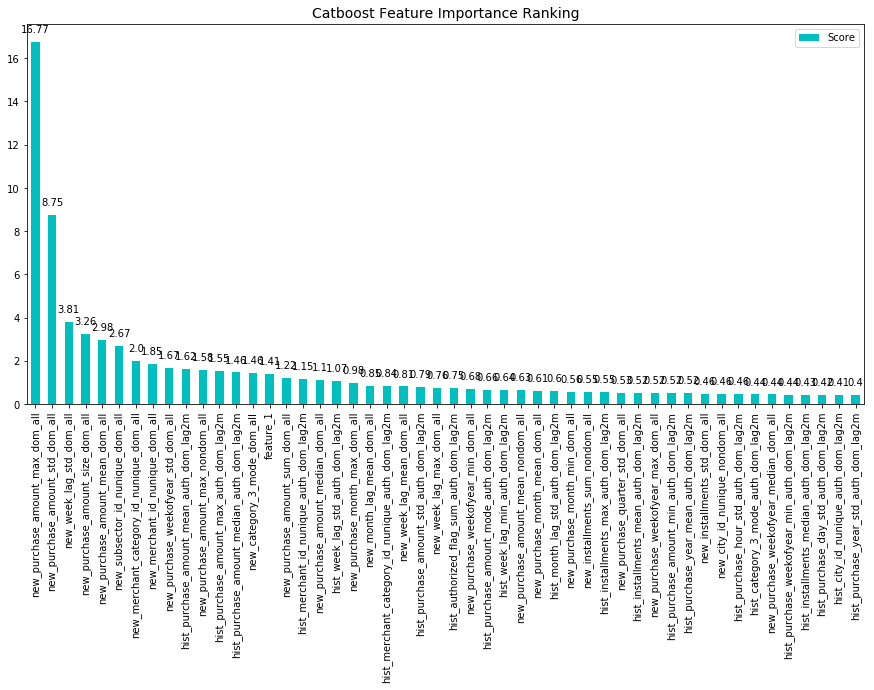

In [12]:
plt.rcParams["figure.figsize"] = (15,7)
ax = feature_score[:50].plot('Feature', 'Score', kind = 'bar', color = 'c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [13]:
feature_score.shape[0], feature_score[feature_score['Score'] > 0].shape[0], feature_score[feature_score['Score'] > 0.97].shape[0]

(487, 353, 20)

In [14]:
all_features = list(feature_score['Feature'].values)
selected_features = list(feature_score.loc[feature_score['Score'] > .97, 'Feature'].values)

In [15]:
len(selected_features), len(all_features)

(20, 487)

#### Correlation between the 20 most important features

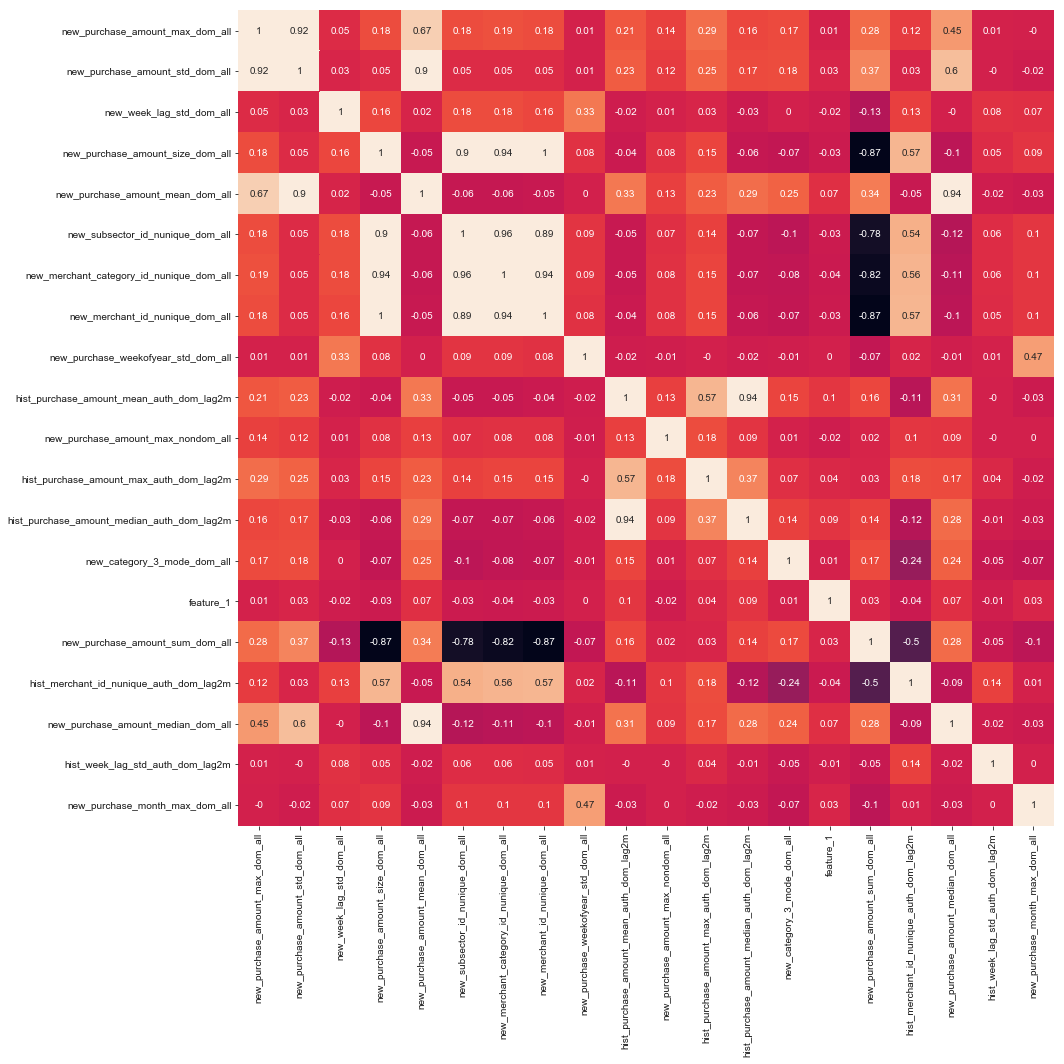

In [16]:
corrmat = X_train[selected_features].corr().round(decimals = 2)
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corrmat, vmax=.8, square=True,xticklabels=True,yticklabels=True,cbar=False,annot=True)
sns.set(font_scale = 0.8)

In [17]:
# remove some features in order that we have only relatively non-correlated (positively or negatively) features
# (where the absolute value of correlation is greater than or equal to 0.9)

selected_features.remove('new_purchase_amount_std_dom_all')
selected_features.remove('new_purchase_amount_median_dom_all')
selected_features.remove('new_subsector_id_nunique_dom_all')
selected_features.remove('new_merchant_category_id_nunique_dom_all')
selected_features.remove('new_merchant_id_nunique_dom_all')
selected_features.remove('hist_purchase_amount_mean_auth_dom_lag2m')

len(selected_features)

14

## Grid search using only the most important 20 features

In [18]:
always_ignored_features = ['first_active_month', 'card_id']
for col in categorical_features:
    X_train[col] = X_train[col].astype('category').cat.codes
categorical_features_indices = [X_train.columns.get_loc(i) for i in categorical_features]

In [19]:
ignored_features = always_ignored_features + [col for col in all_features if col not in selected_features]
ignored_features_indices = [X_train.columns.get_loc(i) for i in ignored_features]
len(ignored_features)

475

In [20]:
def grid_search(params =  {'learning_rate': .99},
                train_set = X_train,
                train_label = y_train,
                param_grid = {'iterations' : [10000, 3000, 1000, 300, 100, 30]},
                cv_folds = 5,
                scoring = 'neg_mean_squared_error',
                n_jobs = -1,
                verbose = 10,
                seed = 1):
    cbr = CatBoostRegressor(**params, ignored_features = ignored_features_indices, random_seed = seed)
    gs = GridSearchCV(estimator = cbr, param_grid = param_grid, scoring = scoring, cv = cv_folds, n_jobs = n_jobs, 
                      verbose = verbose)
    gs.fit(train_set, train_label)
    best_parameters = gs.best_params_ 
    print(gs.cv_results_)
    return gs, best_parameters

In [21]:
gs_iterations, best_parameters_iterations = grid_search()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 23.4min remaining: 13.5min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 24.0min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 24.2min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 24.5min finished


0:	learn: 1.6295249	total: 96.2ms	remaining: 2.79s
1:	learn: 1.6105955	total: 131ms	remaining: 1.84s
2:	learn: 1.6039592	total: 165ms	remaining: 1.48s
3:	learn: 1.6008521	total: 198ms	remaining: 1.28s
4:	learn: 1.5977443	total: 231ms	remaining: 1.15s
5:	learn: 1.5950597	total: 265ms	remaining: 1.06s
6:	learn: 1.5930264	total: 299ms	remaining: 984ms
7:	learn: 1.5913998	total: 344ms	remaining: 945ms
8:	learn: 1.5906663	total: 381ms	remaining: 888ms
9:	learn: 1.5895372	total: 430ms	remaining: 860ms
10:	learn: 1.5882194	total: 466ms	remaining: 805ms
11:	learn: 1.5862700	total: 502ms	remaining: 753ms
12:	learn: 1.5846859	total: 537ms	remaining: 702ms
13:	learn: 1.5835968	total: 578ms	remaining: 661ms
14:	learn: 1.5824694	total: 616ms	remaining: 616ms
15:	learn: 1.5814112	total: 655ms	remaining: 574ms
16:	learn: 1.5806921	total: 690ms	remaining: 528ms
17:	learn: 1.5800342	total: 724ms	remaining: 482ms
18:	learn: 1.5793864	total: 757ms	remaining: 438ms
19:	learn: 1.5788866	total: 790ms	remain

In [22]:
params = {'learning_rate' : 0.1}
param_grid = {'iterations' : [4000, 2000, 1000, 500, 250, 125, 65, 35]}
gs_iterations, best_parameters_iterations = grid_search(params = params, param_grid = param_grid)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed: 15.3min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 15.9min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 16.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 16.3min finished


0:	learn: 1.7007899	total: 56.4ms	remaining: 14s
1:	learn: 1.6865994	total: 90.8ms	remaining: 11.3s
2:	learn: 1.6747255	total: 125ms	remaining: 10.3s
3:	learn: 1.6645117	total: 160ms	remaining: 9.84s
4:	learn: 1.6565242	total: 195ms	remaining: 9.55s
5:	learn: 1.6491632	total: 231ms	remaining: 9.38s
6:	learn: 1.6428869	total: 277ms	remaining: 9.63s
7:	learn: 1.6375641	total: 315ms	remaining: 9.52s
8:	learn: 1.6329693	total: 355ms	remaining: 9.51s
9:	learn: 1.6290735	total: 401ms	remaining: 9.62s
10:	learn: 1.6258141	total: 437ms	remaining: 9.5s
11:	learn: 1.6220437	total: 474ms	remaining: 9.39s
12:	learn: 1.6189790	total: 512ms	remaining: 9.33s
13:	learn: 1.6163297	total: 546ms	remaining: 9.2s
14:	learn: 1.6140616	total: 584ms	remaining: 9.15s
15:	learn: 1.6119862	total: 619ms	remaining: 9.05s
16:	learn: 1.6102236	total: 653ms	remaining: 8.94s
17:	learn: 1.6086292	total: 686ms	remaining: 8.85s
18:	learn: 1.6070847	total: 720ms	remaining: 8.75s
19:	learn: 1.6056500	total: 763ms	remaining

164:	learn: 1.5696853	total: 8.36s	remaining: 4.31s
165:	learn: 1.5695358	total: 8.42s	remaining: 4.26s
166:	learn: 1.5694781	total: 8.47s	remaining: 4.21s
167:	learn: 1.5693782	total: 8.53s	remaining: 4.16s
168:	learn: 1.5693162	total: 8.57s	remaining: 4.11s
169:	learn: 1.5692460	total: 8.64s	remaining: 4.07s
170:	learn: 1.5691634	total: 8.69s	remaining: 4.01s
171:	learn: 1.5691107	total: 8.74s	remaining: 3.96s
172:	learn: 1.5690002	total: 8.8s	remaining: 3.92s
173:	learn: 1.5689419	total: 8.86s	remaining: 3.87s
174:	learn: 1.5688671	total: 8.9s	remaining: 3.81s
175:	learn: 1.5687526	total: 8.95s	remaining: 3.76s
176:	learn: 1.5687124	total: 9.01s	remaining: 3.71s
177:	learn: 1.5686540	total: 9.06s	remaining: 3.66s
178:	learn: 1.5684898	total: 9.11s	remaining: 3.61s
179:	learn: 1.5684429	total: 9.17s	remaining: 3.56s
180:	learn: 1.5683223	total: 9.22s	remaining: 3.51s
181:	learn: 1.5682237	total: 9.26s	remaining: 3.46s
182:	learn: 1.5681611	total: 9.31s	remaining: 3.41s
183:	learn: 1.

In [23]:
params['iterations'] = best_parameters_iterations['iterations']
param_grid = {'depth' : [16, 14, 12, 10, 8, 6, 4, 2]}
gs_depth, best_parameters_depth = grid_search(params = params, param_grid = param_grid)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed: 35.4min remaining: 11.8min
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 36.7min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 36.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 36.7min finished


0:	learn: 1.6998163	total: 108ms	remaining: 26.8s
1:	learn: 1.6847573	total: 164ms	remaining: 20.3s
2:	learn: 1.6718148	total: 207ms	remaining: 17.1s
3:	learn: 1.6609687	total: 256ms	remaining: 15.8s
4:	learn: 1.6517212	total: 304ms	remaining: 14.9s
5:	learn: 1.6434344	total: 370ms	remaining: 15s
6:	learn: 1.6366638	total: 421ms	remaining: 14.6s
7:	learn: 1.6305937	total: 474ms	remaining: 14.3s
8:	learn: 1.6256899	total: 524ms	remaining: 14s
9:	learn: 1.6214884	total: 568ms	remaining: 13.6s
10:	learn: 1.6179416	total: 621ms	remaining: 13.5s
11:	learn: 1.6147797	total: 674ms	remaining: 13.4s
12:	learn: 1.6118504	total: 720ms	remaining: 13.1s
13:	learn: 1.6089212	total: 767ms	remaining: 12.9s
14:	learn: 1.6067472	total: 816ms	remaining: 12.8s
15:	learn: 1.6046223	total: 869ms	remaining: 12.7s
16:	learn: 1.6024611	total: 928ms	remaining: 12.7s
17:	learn: 1.6007509	total: 971ms	remaining: 12.5s
18:	learn: 1.5990180	total: 1.02s	remaining: 12.4s
19:	learn: 1.5974877	total: 1.06s	remaining: 

161:	learn: 1.5552620	total: 10.8s	remaining: 5.89s
162:	learn: 1.5551115	total: 10.9s	remaining: 5.82s
163:	learn: 1.5549009	total: 11s	remaining: 5.75s
164:	learn: 1.5547901	total: 11s	remaining: 5.68s
165:	learn: 1.5546679	total: 11.1s	remaining: 5.62s
166:	learn: 1.5545061	total: 11.2s	remaining: 5.55s
167:	learn: 1.5543438	total: 11.2s	remaining: 5.48s
168:	learn: 1.5542511	total: 11.3s	remaining: 5.42s
169:	learn: 1.5541303	total: 11.4s	remaining: 5.35s
170:	learn: 1.5540558	total: 11.5s	remaining: 5.29s
171:	learn: 1.5538118	total: 11.6s	remaining: 5.24s
172:	learn: 1.5537153	total: 11.6s	remaining: 5.17s
173:	learn: 1.5535194	total: 11.7s	remaining: 5.11s
174:	learn: 1.5534117	total: 11.8s	remaining: 5.04s
175:	learn: 1.5531910	total: 11.8s	remaining: 4.97s
176:	learn: 1.5529150	total: 11.9s	remaining: 4.91s
177:	learn: 1.5527915	total: 12s	remaining: 4.84s
178:	learn: 1.5525785	total: 12s	remaining: 4.77s
179:	learn: 1.5524358	total: 12.1s	remaining: 4.71s
180:	learn: 1.552288

In [24]:
params['depth'] = best_parameters_depth['depth']
param_grid = {'l2_leaf_reg' : [0, 0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.063, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 63, 
                               125, 250, 500, 1000, 2000, 4000]}
gs_l2, best_parameters_l2 = grid_search(params = params, param_grid = param_grid)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed: 22.9min remaining:   23.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 22.9min finished


0:	learn: 1.7000620	total: 98ms	remaining: 24.4s
1:	learn: 1.6853914	total: 143ms	remaining: 17.8s
2:	learn: 1.6735709	total: 194ms	remaining: 16s
3:	learn: 1.6630901	total: 240ms	remaining: 14.8s
4:	learn: 1.6536630	total: 290ms	remaining: 14.2s
5:	learn: 1.6456625	total: 347ms	remaining: 14.1s
6:	learn: 1.6386614	total: 400ms	remaining: 13.9s
7:	learn: 1.6327363	total: 458ms	remaining: 13.9s
8:	learn: 1.6277356	total: 522ms	remaining: 14s
9:	learn: 1.6231887	total: 588ms	remaining: 14.1s
10:	learn: 1.6195548	total: 648ms	remaining: 14.1s
11:	learn: 1.6161946	total: 700ms	remaining: 13.9s
12:	learn: 1.6135299	total: 754ms	remaining: 13.8s
13:	learn: 1.6107648	total: 813ms	remaining: 13.7s
14:	learn: 1.6083774	total: 870ms	remaining: 13.6s
15:	learn: 1.6062676	total: 913ms	remaining: 13.4s
16:	learn: 1.6044363	total: 972ms	remaining: 13.3s
17:	learn: 1.6027757	total: 1.03s	remaining: 13.2s
18:	learn: 1.6010314	total: 1.08s	remaining: 13.2s
19:	learn: 1.5994486	total: 1.13s	remaining: 1

163:	learn: 1.5633234	total: 10.2s	remaining: 5.37s
164:	learn: 1.5632294	total: 10.3s	remaining: 5.31s
165:	learn: 1.5631361	total: 10.4s	remaining: 5.25s
166:	learn: 1.5630809	total: 10.4s	remaining: 5.19s
167:	learn: 1.5630043	total: 10.5s	remaining: 5.12s
168:	learn: 1.5629054	total: 10.6s	remaining: 5.06s
169:	learn: 1.5628095	total: 10.6s	remaining: 5.01s
170:	learn: 1.5626613	total: 10.7s	remaining: 4.94s
171:	learn: 1.5625198	total: 10.8s	remaining: 4.88s
172:	learn: 1.5624539	total: 10.8s	remaining: 4.82s
173:	learn: 1.5622399	total: 10.9s	remaining: 4.76s
174:	learn: 1.5622010	total: 11s	remaining: 4.71s
175:	learn: 1.5620486	total: 11.1s	remaining: 4.65s
176:	learn: 1.5619592	total: 11.1s	remaining: 4.58s
177:	learn: 1.5618831	total: 11.2s	remaining: 4.52s
178:	learn: 1.5617371	total: 11.3s	remaining: 4.47s
179:	learn: 1.5616142	total: 11.3s	remaining: 4.41s
180:	learn: 1.5615791	total: 11.4s	remaining: 4.36s
181:	learn: 1.5614695	total: 11.5s	remaining: 4.3s
182:	learn: 1.5

In [25]:
params['l2_leaf_reg'] = best_parameters_l2['l2_leaf_reg']
params['learning_rate'] /= 10
param_grid = {'iterations' : [20000, 10000, 5000, 2500, 1250, 650, 350]}

gs_iterations, best_parameters_iterations = grid_search(params = params, param_grid = param_grid)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 75.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 84.1min
[Parallel(n_jobs=-1)]: Done  24 out of  35 | elapsed: 88.2min remaining: 40.4min
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed: 89.3min remaining: 22.3min
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed: 90.0min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 90.2min finished


0:	learn: 1.7152953	total: 46.1ms	remaining: 1m 55s
1:	learn: 1.7135256	total: 79.3ms	remaining: 1m 39s
2:	learn: 1.7118130	total: 113ms	remaining: 1m 34s
3:	learn: 1.7100452	total: 147ms	remaining: 1m 31s
4:	learn: 1.7083105	total: 180ms	remaining: 1m 29s
5:	learn: 1.7066503	total: 214ms	remaining: 1m 28s
6:	learn: 1.7049967	total: 264ms	remaining: 1m 34s
7:	learn: 1.7033481	total: 301ms	remaining: 1m 33s
8:	learn: 1.7017635	total: 334ms	remaining: 1m 32s
9:	learn: 1.7001683	total: 367ms	remaining: 1m 31s
10:	learn: 1.6986200	total: 400ms	remaining: 1m 30s
11:	learn: 1.6971614	total: 441ms	remaining: 1m 31s
12:	learn: 1.6956724	total: 475ms	remaining: 1m 30s
13:	learn: 1.6941541	total: 507ms	remaining: 1m 30s
14:	learn: 1.6927055	total: 540ms	remaining: 1m 29s
15:	learn: 1.6913064	total: 572ms	remaining: 1m 28s
16:	learn: 1.6899322	total: 605ms	remaining: 1m 28s
17:	learn: 1.6885533	total: 646ms	remaining: 1m 29s
18:	learn: 1.6872263	total: 687ms	remaining: 1m 29s
19:	learn: 1.6858718

162:	learn: 1.6064311	total: 5.49s	remaining: 1m 18s
163:	learn: 1.6062623	total: 5.52s	remaining: 1m 18s
164:	learn: 1.6060725	total: 5.55s	remaining: 1m 18s
165:	learn: 1.6058645	total: 5.59s	remaining: 1m 18s
166:	learn: 1.6056473	total: 5.62s	remaining: 1m 18s
167:	learn: 1.6054532	total: 5.65s	remaining: 1m 18s
168:	learn: 1.6052543	total: 5.69s	remaining: 1m 18s
169:	learn: 1.6050718	total: 5.72s	remaining: 1m 18s
170:	learn: 1.6049003	total: 5.75s	remaining: 1m 18s
171:	learn: 1.6047124	total: 5.79s	remaining: 1m 18s
172:	learn: 1.6045282	total: 5.82s	remaining: 1m 18s
173:	learn: 1.6043660	total: 5.85s	remaining: 1m 18s
174:	learn: 1.6041957	total: 5.88s	remaining: 1m 18s
175:	learn: 1.6040172	total: 5.92s	remaining: 1m 18s
176:	learn: 1.6038468	total: 5.95s	remaining: 1m 18s
177:	learn: 1.6036591	total: 5.98s	remaining: 1m 18s
178:	learn: 1.6034720	total: 6.01s	remaining: 1m 17s
179:	learn: 1.6032889	total: 6.05s	remaining: 1m 17s
180:	learn: 1.6031046	total: 6.08s	remaining: 

319:	learn: 1.5885515	total: 10.6s	remaining: 1m 12s
320:	learn: 1.5884880	total: 10.7s	remaining: 1m 12s
321:	learn: 1.5884202	total: 10.7s	remaining: 1m 12s
322:	learn: 1.5883538	total: 10.7s	remaining: 1m 12s
323:	learn: 1.5882962	total: 10.8s	remaining: 1m 12s
324:	learn: 1.5882326	total: 10.8s	remaining: 1m 12s
325:	learn: 1.5881792	total: 10.8s	remaining: 1m 12s
326:	learn: 1.5881192	total: 10.9s	remaining: 1m 12s
327:	learn: 1.5880660	total: 10.9s	remaining: 1m 12s
328:	learn: 1.5879929	total: 10.9s	remaining: 1m 12s
329:	learn: 1.5879185	total: 11s	remaining: 1m 12s
330:	learn: 1.5878653	total: 11s	remaining: 1m 12s
331:	learn: 1.5878153	total: 11s	remaining: 1m 12s
332:	learn: 1.5877534	total: 11.1s	remaining: 1m 12s
333:	learn: 1.5876872	total: 11.1s	remaining: 1m 12s
334:	learn: 1.5876457	total: 11.1s	remaining: 1m 12s
335:	learn: 1.5875681	total: 11.2s	remaining: 1m 12s
336:	learn: 1.5874979	total: 11.2s	remaining: 1m 11s
337:	learn: 1.5874384	total: 11.2s	remaining: 1m 11s

478:	learn: 1.5810771	total: 15.9s	remaining: 1m 6s
479:	learn: 1.5810397	total: 15.9s	remaining: 1m 6s
480:	learn: 1.5809971	total: 15.9s	remaining: 1m 6s
481:	learn: 1.5809746	total: 16s	remaining: 1m 6s
482:	learn: 1.5809339	total: 16s	remaining: 1m 6s
483:	learn: 1.5808989	total: 16s	remaining: 1m 6s
484:	learn: 1.5808684	total: 16.1s	remaining: 1m 6s
485:	learn: 1.5808374	total: 16.1s	remaining: 1m 6s
486:	learn: 1.5807906	total: 16.1s	remaining: 1m 6s
487:	learn: 1.5807574	total: 16.2s	remaining: 1m 6s
488:	learn: 1.5807168	total: 16.2s	remaining: 1m 6s
489:	learn: 1.5806774	total: 16.2s	remaining: 1m 6s
490:	learn: 1.5806217	total: 16.3s	remaining: 1m 6s
491:	learn: 1.5805775	total: 16.3s	remaining: 1m 6s
492:	learn: 1.5805471	total: 16.3s	remaining: 1m 6s
493:	learn: 1.5805168	total: 16.4s	remaining: 1m 6s
494:	learn: 1.5804814	total: 16.4s	remaining: 1m 6s
495:	learn: 1.5804514	total: 16.4s	remaining: 1m 6s
496:	learn: 1.5804251	total: 16.5s	remaining: 1m 6s
497:	learn: 1.5803

641:	learn: 1.5764657	total: 21.2s	remaining: 1m 1s
642:	learn: 1.5764471	total: 21.2s	remaining: 1m 1s
643:	learn: 1.5764246	total: 21.3s	remaining: 1m 1s
644:	learn: 1.5764004	total: 21.3s	remaining: 1m 1s
645:	learn: 1.5763776	total: 21.3s	remaining: 1m 1s
646:	learn: 1.5763564	total: 21.4s	remaining: 1m 1s
647:	learn: 1.5763373	total: 21.4s	remaining: 1m 1s
648:	learn: 1.5763123	total: 21.4s	remaining: 1m 1s
649:	learn: 1.5762849	total: 21.4s	remaining: 1m 1s
650:	learn: 1.5762660	total: 21.5s	remaining: 1m 1s
651:	learn: 1.5762458	total: 21.5s	remaining: 1m
652:	learn: 1.5762106	total: 21.5s	remaining: 1m
653:	learn: 1.5761904	total: 21.6s	remaining: 1m
654:	learn: 1.5761727	total: 21.6s	remaining: 1m
655:	learn: 1.5761535	total: 21.6s	remaining: 1m
656:	learn: 1.5761218	total: 21.7s	remaining: 1m
657:	learn: 1.5760934	total: 21.7s	remaining: 1m
658:	learn: 1.5760663	total: 21.7s	remaining: 1m
659:	learn: 1.5760457	total: 21.8s	remaining: 1m
660:	learn: 1.5760293	total: 21.8s	rema

804:	learn: 1.5732152	total: 26.5s	remaining: 55.8s
805:	learn: 1.5731971	total: 26.5s	remaining: 55.7s
806:	learn: 1.5731799	total: 26.6s	remaining: 55.7s
807:	learn: 1.5731601	total: 26.6s	remaining: 55.7s
808:	learn: 1.5731346	total: 26.6s	remaining: 55.6s
809:	learn: 1.5731151	total: 26.7s	remaining: 55.6s
810:	learn: 1.5731014	total: 26.7s	remaining: 55.6s
811:	learn: 1.5730821	total: 26.7s	remaining: 55.5s
812:	learn: 1.5730658	total: 26.8s	remaining: 55.5s
813:	learn: 1.5730502	total: 26.8s	remaining: 55.5s
814:	learn: 1.5730187	total: 26.8s	remaining: 55.5s
815:	learn: 1.5730001	total: 26.9s	remaining: 55.4s
816:	learn: 1.5729796	total: 26.9s	remaining: 55.4s
817:	learn: 1.5729655	total: 26.9s	remaining: 55.4s
818:	learn: 1.5729529	total: 27s	remaining: 55.3s
819:	learn: 1.5729295	total: 27s	remaining: 55.3s
820:	learn: 1.5729169	total: 27s	remaining: 55.2s
821:	learn: 1.5728976	total: 27s	remaining: 55.2s
822:	learn: 1.5728803	total: 27.1s	remaining: 55.2s
823:	learn: 1.572866

967:	learn: 1.5706016	total: 31.8s	remaining: 50.3s
968:	learn: 1.5705834	total: 31.8s	remaining: 50.3s
969:	learn: 1.5705651	total: 31.9s	remaining: 50.2s
970:	learn: 1.5705514	total: 31.9s	remaining: 50.2s
971:	learn: 1.5705282	total: 31.9s	remaining: 50.2s
972:	learn: 1.5705133	total: 31.9s	remaining: 50.1s
973:	learn: 1.5704993	total: 32s	remaining: 50.1s
974:	learn: 1.5704865	total: 32s	remaining: 50.1s
975:	learn: 1.5704715	total: 32s	remaining: 50s
976:	learn: 1.5704609	total: 32.1s	remaining: 50s
977:	learn: 1.5704450	total: 32.1s	remaining: 50s
978:	learn: 1.5704278	total: 32.1s	remaining: 49.9s
979:	learn: 1.5704165	total: 32.2s	remaining: 49.9s
980:	learn: 1.5704053	total: 32.2s	remaining: 49.9s
981:	learn: 1.5703853	total: 32.2s	remaining: 49.8s
982:	learn: 1.5703735	total: 32.3s	remaining: 49.8s
983:	learn: 1.5703638	total: 32.3s	remaining: 49.8s
984:	learn: 1.5703471	total: 32.3s	remaining: 49.7s
985:	learn: 1.5703389	total: 32.4s	remaining: 49.7s
986:	learn: 1.5703324	to

1128:	learn: 1.5684415	total: 37s	remaining: 45s
1129:	learn: 1.5684322	total: 37.1s	remaining: 44.9s
1130:	learn: 1.5684240	total: 37.1s	remaining: 44.9s
1131:	learn: 1.5684060	total: 37.1s	remaining: 44.9s
1132:	learn: 1.5683980	total: 37.2s	remaining: 44.8s
1133:	learn: 1.5683887	total: 37.2s	remaining: 44.8s
1134:	learn: 1.5683736	total: 37.2s	remaining: 44.8s
1135:	learn: 1.5683590	total: 37.3s	remaining: 44.8s
1136:	learn: 1.5683506	total: 37.3s	remaining: 44.7s
1137:	learn: 1.5683407	total: 37.3s	remaining: 44.7s
1138:	learn: 1.5683259	total: 37.4s	remaining: 44.7s
1139:	learn: 1.5683110	total: 37.4s	remaining: 44.6s
1140:	learn: 1.5682994	total: 37.4s	remaining: 44.6s
1141:	learn: 1.5682874	total: 37.5s	remaining: 44.6s
1142:	learn: 1.5682640	total: 37.5s	remaining: 44.5s
1143:	learn: 1.5682536	total: 37.5s	remaining: 44.5s
1144:	learn: 1.5682451	total: 37.6s	remaining: 44.5s
1145:	learn: 1.5682269	total: 37.6s	remaining: 44.4s
1146:	learn: 1.5682156	total: 37.6s	remaining: 44.

1287:	learn: 1.5665289	total: 42.2s	remaining: 39.7s
1288:	learn: 1.5665179	total: 42.2s	remaining: 39.6s
1289:	learn: 1.5664970	total: 42.2s	remaining: 39.6s
1290:	learn: 1.5664863	total: 42.3s	remaining: 39.6s
1291:	learn: 1.5664735	total: 42.3s	remaining: 39.5s
1292:	learn: 1.5664671	total: 42.3s	remaining: 39.5s
1293:	learn: 1.5664553	total: 42.4s	remaining: 39.5s
1294:	learn: 1.5664387	total: 42.4s	remaining: 39.5s
1295:	learn: 1.5664286	total: 42.4s	remaining: 39.4s
1296:	learn: 1.5664127	total: 42.5s	remaining: 39.4s
1297:	learn: 1.5663941	total: 42.5s	remaining: 39.3s
1298:	learn: 1.5663764	total: 42.5s	remaining: 39.3s
1299:	learn: 1.5663692	total: 42.6s	remaining: 39.3s
1300:	learn: 1.5663582	total: 42.6s	remaining: 39.2s
1301:	learn: 1.5663477	total: 42.6s	remaining: 39.2s
1302:	learn: 1.5663393	total: 42.6s	remaining: 39.2s
1303:	learn: 1.5663293	total: 42.7s	remaining: 39.1s
1304:	learn: 1.5663146	total: 42.7s	remaining: 39.1s
1305:	learn: 1.5663058	total: 42.7s	remaining:

1443:	learn: 1.5647696	total: 47.2s	remaining: 34.5s
1444:	learn: 1.5647629	total: 47.2s	remaining: 34.5s
1445:	learn: 1.5647538	total: 47.2s	remaining: 34.4s
1446:	learn: 1.5647439	total: 47.3s	remaining: 34.4s
1447:	learn: 1.5647341	total: 47.3s	remaining: 34.4s
1448:	learn: 1.5647162	total: 47.3s	remaining: 34.3s
1449:	learn: 1.5647082	total: 47.4s	remaining: 34.3s
1450:	learn: 1.5646923	total: 47.4s	remaining: 34.3s
1451:	learn: 1.5646810	total: 47.4s	remaining: 34.2s
1452:	learn: 1.5646621	total: 47.5s	remaining: 34.2s
1453:	learn: 1.5646507	total: 47.5s	remaining: 34.2s
1454:	learn: 1.5646252	total: 47.5s	remaining: 34.1s
1455:	learn: 1.5646191	total: 47.6s	remaining: 34.1s
1456:	learn: 1.5646136	total: 47.6s	remaining: 34.1s
1457:	learn: 1.5646103	total: 47.6s	remaining: 34s
1458:	learn: 1.5646028	total: 47.6s	remaining: 34s
1459:	learn: 1.5645904	total: 47.7s	remaining: 34s
1460:	learn: 1.5645811	total: 47.7s	remaining: 33.9s
1461:	learn: 1.5645667	total: 47.7s	remaining: 33.9s

1601:	learn: 1.5630643	total: 52.2s	remaining: 29.3s
1602:	learn: 1.5630532	total: 52.3s	remaining: 29.2s
1603:	learn: 1.5630431	total: 52.3s	remaining: 29.2s
1604:	learn: 1.5630289	total: 52.3s	remaining: 29.2s
1605:	learn: 1.5630138	total: 52.4s	remaining: 29.1s
1606:	learn: 1.5629926	total: 52.4s	remaining: 29.1s
1607:	learn: 1.5629885	total: 52.4s	remaining: 29.1s
1608:	learn: 1.5629836	total: 52.5s	remaining: 29s
1609:	learn: 1.5629752	total: 52.5s	remaining: 29s
1610:	learn: 1.5629582	total: 52.5s	remaining: 29s
1611:	learn: 1.5629493	total: 52.6s	remaining: 28.9s
1612:	learn: 1.5629257	total: 52.6s	remaining: 28.9s
1613:	learn: 1.5629202	total: 52.6s	remaining: 28.9s
1614:	learn: 1.5629087	total: 52.7s	remaining: 28.9s
1615:	learn: 1.5629005	total: 52.7s	remaining: 28.8s
1616:	learn: 1.5628914	total: 52.7s	remaining: 28.8s
1617:	learn: 1.5628824	total: 52.8s	remaining: 28.8s
1618:	learn: 1.5628745	total: 52.8s	remaining: 28.7s
1619:	learn: 1.5628685	total: 52.8s	remaining: 28.7s

1760:	learn: 1.5614443	total: 57.4s	remaining: 24.1s
1761:	learn: 1.5614335	total: 57.4s	remaining: 24.1s
1762:	learn: 1.5614215	total: 57.5s	remaining: 24s
1763:	learn: 1.5614161	total: 57.5s	remaining: 24s
1764:	learn: 1.5614057	total: 57.5s	remaining: 24s
1765:	learn: 1.5613926	total: 57.6s	remaining: 23.9s
1766:	learn: 1.5613858	total: 57.6s	remaining: 23.9s
1767:	learn: 1.5613779	total: 57.6s	remaining: 23.9s
1768:	learn: 1.5613707	total: 57.7s	remaining: 23.8s
1769:	learn: 1.5613593	total: 57.7s	remaining: 23.8s
1770:	learn: 1.5613456	total: 57.7s	remaining: 23.8s
1771:	learn: 1.5613392	total: 57.7s	remaining: 23.7s
1772:	learn: 1.5613297	total: 57.8s	remaining: 23.7s
1773:	learn: 1.5613235	total: 57.8s	remaining: 23.7s
1774:	learn: 1.5613098	total: 57.8s	remaining: 23.6s
1775:	learn: 1.5613014	total: 57.9s	remaining: 23.6s
1776:	learn: 1.5612864	total: 57.9s	remaining: 23.6s
1777:	learn: 1.5612736	total: 57.9s	remaining: 23.5s
1778:	learn: 1.5612670	total: 58s	remaining: 23.5s
1

1921:	learn: 1.5598346	total: 1m 2s	remaining: 18.8s
1922:	learn: 1.5598296	total: 1m 2s	remaining: 18.8s
1923:	learn: 1.5598168	total: 1m 2s	remaining: 18.7s
1924:	learn: 1.5598108	total: 1m 2s	remaining: 18.7s
1925:	learn: 1.5598025	total: 1m 2s	remaining: 18.7s
1926:	learn: 1.5597987	total: 1m 2s	remaining: 18.6s
1927:	learn: 1.5597876	total: 1m 2s	remaining: 18.6s
1928:	learn: 1.5597759	total: 1m 2s	remaining: 18.6s
1929:	learn: 1.5597628	total: 1m 2s	remaining: 18.6s
1930:	learn: 1.5597482	total: 1m 2s	remaining: 18.5s
1931:	learn: 1.5597367	total: 1m 2s	remaining: 18.5s
1932:	learn: 1.5597206	total: 1m 2s	remaining: 18.5s
1933:	learn: 1.5597027	total: 1m 2s	remaining: 18.4s
1934:	learn: 1.5596972	total: 1m 2s	remaining: 18.4s
1935:	learn: 1.5596874	total: 1m 3s	remaining: 18.4s
1936:	learn: 1.5596709	total: 1m 3s	remaining: 18.3s
1937:	learn: 1.5596595	total: 1m 3s	remaining: 18.3s
1938:	learn: 1.5596482	total: 1m 3s	remaining: 18.3s
1939:	learn: 1.5596354	total: 1m 3s	remaining:

2077:	learn: 1.5583549	total: 1m 7s	remaining: 13.7s
2078:	learn: 1.5583417	total: 1m 7s	remaining: 13.7s
2079:	learn: 1.5583299	total: 1m 7s	remaining: 13.7s
2080:	learn: 1.5583186	total: 1m 7s	remaining: 13.6s
2081:	learn: 1.5583123	total: 1m 7s	remaining: 13.6s
2082:	learn: 1.5583083	total: 1m 7s	remaining: 13.6s
2083:	learn: 1.5583026	total: 1m 7s	remaining: 13.5s
2084:	learn: 1.5582969	total: 1m 7s	remaining: 13.5s
2085:	learn: 1.5582910	total: 1m 7s	remaining: 13.5s
2086:	learn: 1.5582864	total: 1m 7s	remaining: 13.4s
2087:	learn: 1.5582808	total: 1m 7s	remaining: 13.4s
2088:	learn: 1.5582775	total: 1m 7s	remaining: 13.4s
2089:	learn: 1.5582645	total: 1m 8s	remaining: 13.3s
2090:	learn: 1.5582519	total: 1m 8s	remaining: 13.3s
2091:	learn: 1.5582453	total: 1m 8s	remaining: 13.3s
2092:	learn: 1.5582347	total: 1m 8s	remaining: 13.2s
2093:	learn: 1.5582309	total: 1m 8s	remaining: 13.2s
2094:	learn: 1.5582213	total: 1m 8s	remaining: 13.2s
2095:	learn: 1.5582156	total: 1m 8s	remaining:

2233:	learn: 1.5569466	total: 1m 12s	remaining: 8.65s
2234:	learn: 1.5569361	total: 1m 12s	remaining: 8.62s
2235:	learn: 1.5569306	total: 1m 12s	remaining: 8.59s
2236:	learn: 1.5569269	total: 1m 12s	remaining: 8.56s
2237:	learn: 1.5569243	total: 1m 12s	remaining: 8.52s
2238:	learn: 1.5569157	total: 1m 12s	remaining: 8.49s
2239:	learn: 1.5569074	total: 1m 12s	remaining: 8.46s
2240:	learn: 1.5569000	total: 1m 12s	remaining: 8.43s
2241:	learn: 1.5568878	total: 1m 12s	remaining: 8.39s
2242:	learn: 1.5568744	total: 1m 12s	remaining: 8.36s
2243:	learn: 1.5568657	total: 1m 13s	remaining: 8.33s
2244:	learn: 1.5568600	total: 1m 13s	remaining: 8.29s
2245:	learn: 1.5568505	total: 1m 13s	remaining: 8.26s
2246:	learn: 1.5568386	total: 1m 13s	remaining: 8.23s
2247:	learn: 1.5568302	total: 1m 13s	remaining: 8.2s
2248:	learn: 1.5568251	total: 1m 13s	remaining: 8.16s
2249:	learn: 1.5568183	total: 1m 13s	remaining: 8.13s
2250:	learn: 1.5568066	total: 1m 13s	remaining: 8.1s
2251:	learn: 1.5568005	total: 

2389:	learn: 1.5556304	total: 1m 17s	remaining: 3.58s
2390:	learn: 1.5556191	total: 1m 17s	remaining: 3.54s
2391:	learn: 1.5556085	total: 1m 17s	remaining: 3.51s
2392:	learn: 1.5555992	total: 1m 17s	remaining: 3.48s
2393:	learn: 1.5555896	total: 1m 17s	remaining: 3.45s
2394:	learn: 1.5555824	total: 1m 17s	remaining: 3.41s
2395:	learn: 1.5555739	total: 1m 17s	remaining: 3.38s
2396:	learn: 1.5555640	total: 1m 17s	remaining: 3.35s
2397:	learn: 1.5555589	total: 1m 17s	remaining: 3.32s
2398:	learn: 1.5555483	total: 1m 17s	remaining: 3.28s
2399:	learn: 1.5555445	total: 1m 18s	remaining: 3.25s
2400:	learn: 1.5555391	total: 1m 18s	remaining: 3.22s
2401:	learn: 1.5555337	total: 1m 18s	remaining: 3.19s
2402:	learn: 1.5555273	total: 1m 18s	remaining: 3.15s
2403:	learn: 1.5555210	total: 1m 18s	remaining: 3.12s
2404:	learn: 1.5555151	total: 1m 18s	remaining: 3.09s
2405:	learn: 1.5555031	total: 1m 18s	remaining: 3.06s
2406:	learn: 1.5554954	total: 1m 18s	remaining: 3.02s
2407:	learn: 1.5554902	total

In [26]:
params['iterations'] = best_parameters_iterations['iterations']

seed = 1
n_jobs = 8
cbr = CatBoostRegressor(**params, loss_function = 'RMSE', ignored_features = ignored_features_indices, random_seed = seed,
                        thread_count = n_jobs)
cbr.fit(X_train, y_train, cat_features = categorical_features_indices, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.7152897	total: 125ms	remaining: 5m 11s
1:	learn: 1.7135217	total: 241ms	remaining: 5m
2:	learn: 1.7117676	total: 362ms	remaining: 5m 1s
3:	learn: 1.7100323	total: 460ms	remaining: 4m 47s
4:	learn: 1.7083432	total: 571ms	remaining: 4m 44s
5:	learn: 1.7066074	total: 670ms	remaining: 4m 38s
6:	learn: 1.7049707	total: 769ms	remaining: 4m 33s
7:	learn: 1.7033637	total: 873ms	remaining: 4m 31s
8:	learn: 1.7017744	total: 976ms	remaining: 4m 30s
9:	learn: 1.7001726	total: 1.07s	remaining: 4m 27s
10:	learn: 1.6986701	total: 1.17s	remaining: 4m 25s
11:	learn: 1.6971669	total: 1.27s	remaining: 4m 23s
12:	learn: 1.6956870	total: 1.37s	remaining: 4m 22s
13:	learn: 1.6942139	total: 1.47s	remaining: 4m 21s
14:	learn: 1.6927423	total: 1.58s	remaining: 4m 21s
15:	learn: 1.6912918	total: 1.68s	remaining: 4m 20s
16:	learn: 1.6898825	total: 1.79s	remaining: 4m 21s
17:	learn: 1.6885437	total: 1.89s	remaining: 4m 20s
18:	learn: 1.6872198	total: 1.99s	remaining: 4m 19s
19:	learn: 1.6858543	total:

159:	learn: 1.6068919	total: 16.9s	remaining: 4m 6s
160:	learn: 1.6066735	total: 17s	remaining: 4m 6s
161:	learn: 1.6064580	total: 17.1s	remaining: 4m 6s
162:	learn: 1.6062827	total: 17.2s	remaining: 4m 6s
163:	learn: 1.6060794	total: 17.3s	remaining: 4m 6s
164:	learn: 1.6058607	total: 17.4s	remaining: 4m 6s
165:	learn: 1.6056503	total: 17.5s	remaining: 4m 5s
166:	learn: 1.6054479	total: 17.6s	remaining: 4m 5s
167:	learn: 1.6052402	total: 17.7s	remaining: 4m 5s
168:	learn: 1.6050369	total: 17.8s	remaining: 4m 5s
169:	learn: 1.6048365	total: 17.9s	remaining: 4m 5s
170:	learn: 1.6046589	total: 18s	remaining: 4m 5s
171:	learn: 1.6044705	total: 18.1s	remaining: 4m 4s
172:	learn: 1.6042858	total: 18.2s	remaining: 4m 4s
173:	learn: 1.6041105	total: 18.3s	remaining: 4m 4s
174:	learn: 1.6039266	total: 18.4s	remaining: 4m 4s
175:	learn: 1.6037778	total: 18.5s	remaining: 4m 4s
176:	learn: 1.6036078	total: 18.6s	remaining: 4m 3s
177:	learn: 1.6034405	total: 18.7s	remaining: 4m 3s
178:	learn: 1.60

316:	learn: 1.5883725	total: 32.8s	remaining: 3m 46s
317:	learn: 1.5883013	total: 32.9s	remaining: 3m 45s
318:	learn: 1.5882338	total: 33s	remaining: 3m 45s
319:	learn: 1.5881650	total: 33.1s	remaining: 3m 45s
320:	learn: 1.5881039	total: 33.3s	remaining: 3m 45s
321:	learn: 1.5880458	total: 33.4s	remaining: 3m 45s
322:	learn: 1.5879938	total: 33.5s	remaining: 3m 45s
323:	learn: 1.5879338	total: 33.6s	remaining: 3m 45s
324:	learn: 1.5878529	total: 33.7s	remaining: 3m 45s
325:	learn: 1.5877860	total: 33.8s	remaining: 3m 45s
326:	learn: 1.5877151	total: 33.9s	remaining: 3m 45s
327:	learn: 1.5876466	total: 34.1s	remaining: 3m 45s
328:	learn: 1.5875876	total: 34.1s	remaining: 3m 45s
329:	learn: 1.5875258	total: 34.3s	remaining: 3m 45s
330:	learn: 1.5874710	total: 34.4s	remaining: 3m 45s
331:	learn: 1.5874131	total: 34.5s	remaining: 3m 45s
332:	learn: 1.5873441	total: 34.6s	remaining: 3m 44s
333:	learn: 1.5872769	total: 34.7s	remaining: 3m 44s
334:	learn: 1.5872287	total: 34.8s	remaining: 3m

472:	learn: 1.5807970	total: 48.9s	remaining: 3m 29s
473:	learn: 1.5807558	total: 48.9s	remaining: 3m 29s
474:	learn: 1.5807183	total: 49s	remaining: 3m 29s
475:	learn: 1.5806903	total: 49.2s	remaining: 3m 29s
476:	learn: 1.5806559	total: 49.3s	remaining: 3m 28s
477:	learn: 1.5806211	total: 49.4s	remaining: 3m 28s
478:	learn: 1.5805781	total: 49.5s	remaining: 3m 28s
479:	learn: 1.5805507	total: 49.6s	remaining: 3m 28s
480:	learn: 1.5805180	total: 49.7s	remaining: 3m 28s
481:	learn: 1.5804686	total: 49.8s	remaining: 3m 28s
482:	learn: 1.5804244	total: 49.9s	remaining: 3m 28s
483:	learn: 1.5803903	total: 50s	remaining: 3m 28s
484:	learn: 1.5803614	total: 50.1s	remaining: 3m 28s
485:	learn: 1.5803076	total: 50.2s	remaining: 3m 27s
486:	learn: 1.5802809	total: 50.3s	remaining: 3m 27s
487:	learn: 1.5802563	total: 50.4s	remaining: 3m 27s
488:	learn: 1.5802235	total: 50.5s	remaining: 3m 27s
489:	learn: 1.5801852	total: 50.6s	remaining: 3m 27s
490:	learn: 1.5801523	total: 50.7s	remaining: 3m 2

629:	learn: 1.5764918	total: 1m 4s	remaining: 3m 11s
630:	learn: 1.5764495	total: 1m 4s	remaining: 3m 11s
631:	learn: 1.5764233	total: 1m 4s	remaining: 3m 11s
632:	learn: 1.5763964	total: 1m 4s	remaining: 3m 11s
633:	learn: 1.5763615	total: 1m 5s	remaining: 3m 11s
634:	learn: 1.5763463	total: 1m 5s	remaining: 3m 11s
635:	learn: 1.5763318	total: 1m 5s	remaining: 3m 11s
636:	learn: 1.5763116	total: 1m 5s	remaining: 3m 11s
637:	learn: 1.5762738	total: 1m 5s	remaining: 3m 10s
638:	learn: 1.5762444	total: 1m 5s	remaining: 3m 10s
639:	learn: 1.5762444	total: 1m 5s	remaining: 3m 10s
640:	learn: 1.5762296	total: 1m 5s	remaining: 3m 10s
641:	learn: 1.5762100	total: 1m 5s	remaining: 3m 10s
642:	learn: 1.5761830	total: 1m 5s	remaining: 3m 10s
643:	learn: 1.5761543	total: 1m 5s	remaining: 3m 10s
644:	learn: 1.5761307	total: 1m 6s	remaining: 3m 9s
645:	learn: 1.5761109	total: 1m 6s	remaining: 3m 9s
646:	learn: 1.5760948	total: 1m 6s	remaining: 3m 9s
647:	learn: 1.5760654	total: 1m 6s	remaining: 3m 

785:	learn: 1.5734238	total: 1m 19s	remaining: 2m 54s
786:	learn: 1.5734070	total: 1m 20s	remaining: 2m 54s
787:	learn: 1.5733972	total: 1m 20s	remaining: 2m 54s
788:	learn: 1.5733874	total: 1m 20s	remaining: 2m 54s
789:	learn: 1.5733553	total: 1m 20s	remaining: 2m 53s
790:	learn: 1.5733470	total: 1m 20s	remaining: 2m 53s
791:	learn: 1.5733264	total: 1m 20s	remaining: 2m 53s
792:	learn: 1.5733128	total: 1m 20s	remaining: 2m 53s
793:	learn: 1.5732871	total: 1m 20s	remaining: 2m 53s
794:	learn: 1.5732732	total: 1m 20s	remaining: 2m 53s
795:	learn: 1.5732585	total: 1m 20s	remaining: 2m 53s
796:	learn: 1.5732447	total: 1m 21s	remaining: 2m 53s
797:	learn: 1.5732169	total: 1m 21s	remaining: 2m 53s
798:	learn: 1.5732062	total: 1m 21s	remaining: 2m 52s
799:	learn: 1.5731932	total: 1m 21s	remaining: 2m 52s
800:	learn: 1.5731589	total: 1m 21s	remaining: 2m 52s
801:	learn: 1.5731449	total: 1m 21s	remaining: 2m 52s
802:	learn: 1.5731205	total: 1m 21s	remaining: 2m 52s
803:	learn: 1.5731065	total:

937:	learn: 1.5711264	total: 1m 34s	remaining: 2m 37s
938:	learn: 1.5711096	total: 1m 34s	remaining: 2m 37s
939:	learn: 1.5710996	total: 1m 34s	remaining: 2m 37s
940:	learn: 1.5710721	total: 1m 34s	remaining: 2m 37s
941:	learn: 1.5710620	total: 1m 34s	remaining: 2m 37s
942:	learn: 1.5710429	total: 1m 35s	remaining: 2m 36s
943:	learn: 1.5710300	total: 1m 35s	remaining: 2m 36s
944:	learn: 1.5710142	total: 1m 35s	remaining: 2m 36s
945:	learn: 1.5710025	total: 1m 35s	remaining: 2m 36s
946:	learn: 1.5709946	total: 1m 35s	remaining: 2m 36s
947:	learn: 1.5709845	total: 1m 35s	remaining: 2m 36s
948:	learn: 1.5709697	total: 1m 35s	remaining: 2m 36s
949:	learn: 1.5709599	total: 1m 35s	remaining: 2m 36s
950:	learn: 1.5709475	total: 1m 35s	remaining: 2m 36s
951:	learn: 1.5709389	total: 1m 35s	remaining: 2m 36s
952:	learn: 1.5709263	total: 1m 36s	remaining: 2m 35s
953:	learn: 1.5709099	total: 1m 36s	remaining: 2m 35s
954:	learn: 1.5708903	total: 1m 36s	remaining: 2m 35s
955:	learn: 1.5708802	total:

1089:	learn: 1.5691792	total: 1m 49s	remaining: 2m 21s
1090:	learn: 1.5691707	total: 1m 49s	remaining: 2m 21s
1091:	learn: 1.5691549	total: 1m 49s	remaining: 2m 21s
1092:	learn: 1.5691380	total: 1m 49s	remaining: 2m 21s
1093:	learn: 1.5691242	total: 1m 49s	remaining: 2m 21s
1094:	learn: 1.5691014	total: 1m 50s	remaining: 2m 21s
1095:	learn: 1.5690939	total: 1m 50s	remaining: 2m 21s
1096:	learn: 1.5690834	total: 1m 50s	remaining: 2m 20s
1097:	learn: 1.5690700	total: 1m 50s	remaining: 2m 20s
1098:	learn: 1.5690645	total: 1m 50s	remaining: 2m 20s
1099:	learn: 1.5690540	total: 1m 50s	remaining: 2m 20s
1100:	learn: 1.5690397	total: 1m 50s	remaining: 2m 20s
1101:	learn: 1.5690306	total: 1m 50s	remaining: 2m 20s
1102:	learn: 1.5690224	total: 1m 50s	remaining: 2m 20s
1103:	learn: 1.5690173	total: 1m 50s	remaining: 2m 20s
1104:	learn: 1.5690047	total: 1m 51s	remaining: 2m 20s
1105:	learn: 1.5689910	total: 1m 51s	remaining: 2m 20s
1106:	learn: 1.5689747	total: 1m 51s	remaining: 2m 19s
1107:	lear

1243:	learn: 1.5673655	total: 2m 4s	remaining: 2m 6s
1244:	learn: 1.5673541	total: 2m 5s	remaining: 2m 6s
1245:	learn: 1.5673467	total: 2m 5s	remaining: 2m 5s
1246:	learn: 1.5673285	total: 2m 5s	remaining: 2m 5s
1247:	learn: 1.5673171	total: 2m 5s	remaining: 2m 5s
1248:	learn: 1.5673084	total: 2m 5s	remaining: 2m 5s
1249:	learn: 1.5672961	total: 2m 5s	remaining: 2m 5s
1250:	learn: 1.5672863	total: 2m 5s	remaining: 2m 5s
1251:	learn: 1.5672806	total: 2m 5s	remaining: 2m 5s
1252:	learn: 1.5672682	total: 2m 5s	remaining: 2m 5s
1253:	learn: 1.5672544	total: 2m 5s	remaining: 2m 5s
1254:	learn: 1.5672420	total: 2m 6s	remaining: 2m 5s
1255:	learn: 1.5672337	total: 2m 6s	remaining: 2m 4s
1256:	learn: 1.5672272	total: 2m 6s	remaining: 2m 4s
1257:	learn: 1.5672156	total: 2m 6s	remaining: 2m 4s
1258:	learn: 1.5671981	total: 2m 6s	remaining: 2m 4s
1259:	learn: 1.5671788	total: 2m 6s	remaining: 2m 4s
1260:	learn: 1.5671673	total: 2m 6s	remaining: 2m 4s
1261:	learn: 1.5671513	total: 2m 6s	remaining:

1396:	learn: 1.5656232	total: 2m 20s	remaining: 1m 51s
1397:	learn: 1.5656099	total: 2m 20s	remaining: 1m 51s
1398:	learn: 1.5655952	total: 2m 20s	remaining: 1m 50s
1399:	learn: 1.5655800	total: 2m 21s	remaining: 1m 50s
1400:	learn: 1.5655680	total: 2m 21s	remaining: 1m 50s
1401:	learn: 1.5655603	total: 2m 21s	remaining: 1m 50s
1402:	learn: 1.5655424	total: 2m 21s	remaining: 1m 50s
1403:	learn: 1.5655243	total: 2m 21s	remaining: 1m 50s
1404:	learn: 1.5655105	total: 2m 21s	remaining: 1m 50s
1405:	learn: 1.5655002	total: 2m 21s	remaining: 1m 50s
1406:	learn: 1.5654873	total: 2m 21s	remaining: 1m 50s
1407:	learn: 1.5654793	total: 2m 21s	remaining: 1m 50s
1408:	learn: 1.5654657	total: 2m 22s	remaining: 1m 49s
1409:	learn: 1.5654548	total: 2m 22s	remaining: 1m 49s
1410:	learn: 1.5654436	total: 2m 22s	remaining: 1m 49s
1411:	learn: 1.5654306	total: 2m 22s	remaining: 1m 49s
1412:	learn: 1.5654189	total: 2m 22s	remaining: 1m 49s
1413:	learn: 1.5654166	total: 2m 22s	remaining: 1m 49s
1414:	lear

1547:	learn: 1.5639889	total: 2m 36s	remaining: 1m 36s
1548:	learn: 1.5639886	total: 2m 36s	remaining: 1m 35s
1549:	learn: 1.5639885	total: 2m 36s	remaining: 1m 35s
1550:	learn: 1.5639805	total: 2m 36s	remaining: 1m 35s
1551:	learn: 1.5639717	total: 2m 36s	remaining: 1m 35s
1552:	learn: 1.5639613	total: 2m 36s	remaining: 1m 35s
1553:	learn: 1.5639601	total: 2m 36s	remaining: 1m 35s
1554:	learn: 1.5639404	total: 2m 36s	remaining: 1m 35s
1555:	learn: 1.5639387	total: 2m 36s	remaining: 1m 35s
1556:	learn: 1.5639304	total: 2m 36s	remaining: 1m 35s
1557:	learn: 1.5639195	total: 2m 37s	remaining: 1m 34s
1558:	learn: 1.5639117	total: 2m 37s	remaining: 1m 34s
1559:	learn: 1.5639022	total: 2m 37s	remaining: 1m 34s
1560:	learn: 1.5638876	total: 2m 37s	remaining: 1m 34s
1561:	learn: 1.5638796	total: 2m 37s	remaining: 1m 34s
1562:	learn: 1.5638728	total: 2m 37s	remaining: 1m 34s
1563:	learn: 1.5638621	total: 2m 37s	remaining: 1m 34s
1564:	learn: 1.5638592	total: 2m 37s	remaining: 1m 34s
1565:	lear

1698:	learn: 1.5624959	total: 2m 51s	remaining: 1m 20s
1699:	learn: 1.5624860	total: 2m 51s	remaining: 1m 20s
1700:	learn: 1.5624802	total: 2m 51s	remaining: 1m 20s
1701:	learn: 1.5624653	total: 2m 51s	remaining: 1m 20s
1702:	learn: 1.5624549	total: 2m 52s	remaining: 1m 20s
1703:	learn: 1.5624459	total: 2m 52s	remaining: 1m 20s
1704:	learn: 1.5624295	total: 2m 52s	remaining: 1m 20s
1705:	learn: 1.5624191	total: 2m 52s	remaining: 1m 20s
1706:	learn: 1.5624085	total: 2m 52s	remaining: 1m 20s
1707:	learn: 1.5624015	total: 2m 52s	remaining: 1m 20s
1708:	learn: 1.5623868	total: 2m 52s	remaining: 1m 19s
1709:	learn: 1.5623756	total: 2m 52s	remaining: 1m 19s
1710:	learn: 1.5623688	total: 2m 52s	remaining: 1m 19s
1711:	learn: 1.5623524	total: 2m 53s	remaining: 1m 19s
1712:	learn: 1.5623506	total: 2m 53s	remaining: 1m 19s
1713:	learn: 1.5623453	total: 2m 53s	remaining: 1m 19s
1714:	learn: 1.5623364	total: 2m 53s	remaining: 1m 19s
1715:	learn: 1.5623289	total: 2m 53s	remaining: 1m 19s
1716:	lear

1850:	learn: 1.5610741	total: 3m 7s	remaining: 1m 5s
1851:	learn: 1.5610632	total: 3m 7s	remaining: 1m 5s
1852:	learn: 1.5610592	total: 3m 7s	remaining: 1m 5s
1853:	learn: 1.5610493	total: 3m 7s	remaining: 1m 5s
1854:	learn: 1.5610429	total: 3m 7s	remaining: 1m 5s
1855:	learn: 1.5610316	total: 3m 7s	remaining: 1m 5s
1856:	learn: 1.5610184	total: 3m 8s	remaining: 1m 5s
1857:	learn: 1.5610123	total: 3m 8s	remaining: 1m 5s
1858:	learn: 1.5610089	total: 3m 8s	remaining: 1m 4s
1859:	learn: 1.5609974	total: 3m 8s	remaining: 1m 4s
1860:	learn: 1.5609958	total: 3m 8s	remaining: 1m 4s
1861:	learn: 1.5609896	total: 3m 8s	remaining: 1m 4s
1862:	learn: 1.5609739	total: 3m 8s	remaining: 1m 4s
1863:	learn: 1.5609664	total: 3m 8s	remaining: 1m 4s
1864:	learn: 1.5609590	total: 3m 8s	remaining: 1m 4s
1865:	learn: 1.5609451	total: 3m 9s	remaining: 1m 4s
1866:	learn: 1.5609421	total: 3m 9s	remaining: 1m 4s
1867:	learn: 1.5609340	total: 3m 9s	remaining: 1m 4s
1868:	learn: 1.5609256	total: 3m 9s	remaining:

2005:	learn: 1.5597476	total: 3m 23s	remaining: 50.1s
2006:	learn: 1.5597393	total: 3m 23s	remaining: 50s
2007:	learn: 1.5597208	total: 3m 23s	remaining: 49.9s
2008:	learn: 1.5597206	total: 3m 23s	remaining: 49.8s
2009:	learn: 1.5597017	total: 3m 23s	remaining: 49.7s
2010:	learn: 1.5597015	total: 3m 23s	remaining: 49.6s
2011:	learn: 1.5596902	total: 3m 24s	remaining: 49.5s
2012:	learn: 1.5596795	total: 3m 24s	remaining: 49.4s
2013:	learn: 1.5596677	total: 3m 24s	remaining: 49.3s
2014:	learn: 1.5596570	total: 3m 24s	remaining: 49.2s
2015:	learn: 1.5596537	total: 3m 24s	remaining: 49.1s
2016:	learn: 1.5596442	total: 3m 24s	remaining: 49s
2017:	learn: 1.5596333	total: 3m 24s	remaining: 48.9s
2018:	learn: 1.5596278	total: 3m 24s	remaining: 48.8s
2019:	learn: 1.5596203	total: 3m 24s	remaining: 48.7s
2020:	learn: 1.5596129	total: 3m 25s	remaining: 48.6s
2021:	learn: 1.5596006	total: 3m 25s	remaining: 48.5s
2022:	learn: 1.5595941	total: 3m 25s	remaining: 48.4s
2023:	learn: 1.5595856	total: 3m

2158:	learn: 1.5583491	total: 3m 39s	remaining: 34.7s
2159:	learn: 1.5583353	total: 3m 39s	remaining: 34.6s
2160:	learn: 1.5583256	total: 3m 39s	remaining: 34.5s
2161:	learn: 1.5583083	total: 3m 39s	remaining: 34.4s
2162:	learn: 1.5583014	total: 3m 39s	remaining: 34.3s
2163:	learn: 1.5583009	total: 3m 40s	remaining: 34.2s
2164:	learn: 1.5582949	total: 3m 40s	remaining: 34.1s
2165:	learn: 1.5582871	total: 3m 40s	remaining: 34s
2166:	learn: 1.5582796	total: 3m 40s	remaining: 33.9s
2167:	learn: 1.5582753	total: 3m 40s	remaining: 33.8s
2168:	learn: 1.5582715	total: 3m 40s	remaining: 33.7s
2169:	learn: 1.5582625	total: 3m 40s	remaining: 33.6s
2170:	learn: 1.5582513	total: 3m 40s	remaining: 33.5s
2171:	learn: 1.5582398	total: 3m 40s	remaining: 33.4s
2172:	learn: 1.5582286	total: 3m 40s	remaining: 33.3s
2173:	learn: 1.5582194	total: 3m 41s	remaining: 33.2s
2174:	learn: 1.5582057	total: 3m 41s	remaining: 33.1s
2175:	learn: 1.5582007	total: 3m 41s	remaining: 33s
2176:	learn: 1.5581944	total: 3m

2312:	learn: 1.5570815	total: 3m 55s	remaining: 19.1s
2313:	learn: 1.5570771	total: 3m 55s	remaining: 18.9s
2314:	learn: 1.5570704	total: 3m 55s	remaining: 18.8s
2315:	learn: 1.5570646	total: 3m 55s	remaining: 18.7s
2316:	learn: 1.5570568	total: 3m 56s	remaining: 18.6s
2317:	learn: 1.5570488	total: 3m 56s	remaining: 18.5s
2318:	learn: 1.5570416	total: 3m 56s	remaining: 18.4s
2319:	learn: 1.5570334	total: 3m 56s	remaining: 18.3s
2320:	learn: 1.5570273	total: 3m 56s	remaining: 18.2s
2321:	learn: 1.5570273	total: 3m 56s	remaining: 18.1s
2322:	learn: 1.5570199	total: 3m 56s	remaining: 18s
2323:	learn: 1.5570072	total: 3m 56s	remaining: 17.9s
2324:	learn: 1.5569978	total: 3m 56s	remaining: 17.8s
2325:	learn: 1.5569869	total: 3m 56s	remaining: 17.7s
2326:	learn: 1.5569804	total: 3m 57s	remaining: 17.6s
2327:	learn: 1.5569642	total: 3m 57s	remaining: 17.5s
2328:	learn: 1.5569602	total: 3m 57s	remaining: 17.4s
2329:	learn: 1.5569463	total: 3m 57s	remaining: 17.3s
2330:	learn: 1.5569314	total: 

2468:	learn: 1.5557977	total: 4m 11s	remaining: 3.16s
2469:	learn: 1.5557829	total: 4m 12s	remaining: 3.06s
2470:	learn: 1.5557781	total: 4m 12s	remaining: 2.96s
2471:	learn: 1.5557699	total: 4m 12s	remaining: 2.86s
2472:	learn: 1.5557606	total: 4m 12s	remaining: 2.75s
2473:	learn: 1.5557574	total: 4m 12s	remaining: 2.65s
2474:	learn: 1.5557506	total: 4m 12s	remaining: 2.55s
2475:	learn: 1.5557401	total: 4m 12s	remaining: 2.45s
2476:	learn: 1.5557338	total: 4m 12s	remaining: 2.35s
2477:	learn: 1.5557155	total: 4m 12s	remaining: 2.25s
2478:	learn: 1.5557063	total: 4m 13s	remaining: 2.14s
2479:	learn: 1.5556925	total: 4m 13s	remaining: 2.04s
2480:	learn: 1.5556924	total: 4m 13s	remaining: 1.94s
2481:	learn: 1.5556906	total: 4m 13s	remaining: 1.84s
2482:	learn: 1.5556835	total: 4m 13s	remaining: 1.73s
2483:	learn: 1.5556706	total: 4m 13s	remaining: 1.63s
2484:	learn: 1.5556588	total: 4m 13s	remaining: 1.53s
2485:	learn: 1.5556454	total: 4m 13s	remaining: 1.43s
2486:	learn: 1.5556412	total

In [27]:
for col in categorical_features:
    X_localtest[col] = X_localtest[col].astype('category').cat.codes

localtest_pred = cbr.predict(X_localtest)
np.sqrt(mean_squared_error(y_localtest, localtest_pred))

1.789376926543552

In [28]:
cbr.get_feature_importance()

[0.0,
 0.0,
 5.027438271225761,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.595710220881903,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.771772837989037,
 0.0,
 6.173666918843221,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.208669213964981,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,


In [29]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, cbr.get_feature_importance())),
                             columns = ['Feature','Score'])

feature_score = feature_score.sort_values(by ='Score', ascending = False, inplace = False, kind = 'quicksort', 
                                          na_position = 'last')

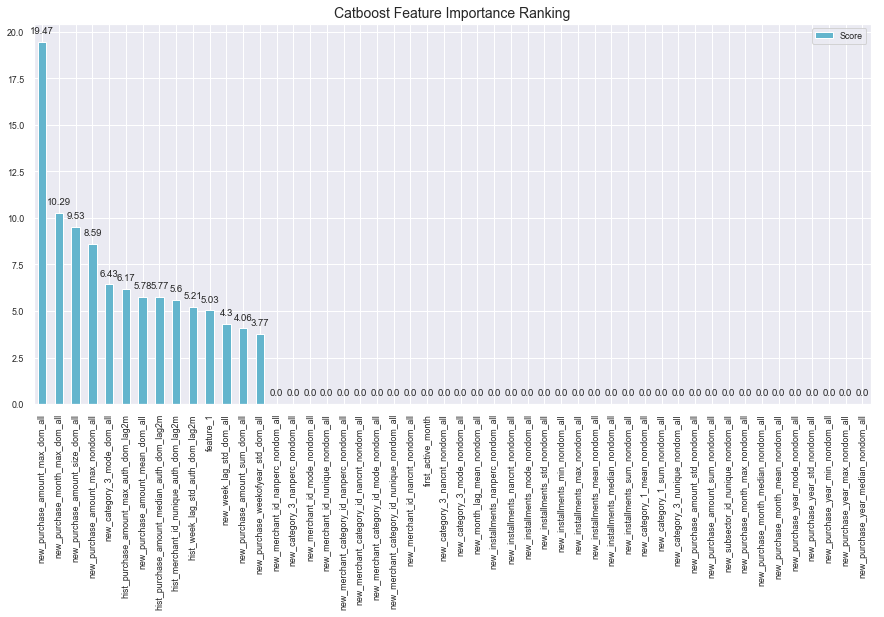

In [30]:
plt.rcParams["figure.figsize"] = (15,7)
ax = feature_score[:50].plot('Feature', 'Score', kind = 'bar', color = 'c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

### Try to change list of selected features

In [31]:
def try_new_selected_feature(new_feature, previous_score, delta, seed):
    is_better = False
    tmp_ignored_features = always_ignored_features + [col for col in all_features if col not in selected_features + [new_feature]]
    tmp_ignored_features_indices = [X_train.columns.get_loc(i) for i in tmp_ignored_features]
    random.seed(seed)
    cbr = CatBoostRegressor(**params, loss_function = 'RMSE', ignored_features = tmp_ignored_features_indices, random_seed = seed,
                            thread_count = n_jobs, verbose = False)
    cbr.fit(X_train, y_train, cat_features = categorical_features_indices, plot = False)
    localtest_pred = cbr.predict(X_localtest)
    new_score = np.sqrt(mean_squared_error(y_localtest, localtest_pred))
    if new_score <= previous_score - delta:
        is_better = True
    return is_better, new_score

def try_remove_feature(feature, previous_score, delta, seed):
    is_better = False
    tmp_ignored_features = always_ignored_features + [col for col in all_features if col not in selected_features] + [feature]
    tmp_ignored_features_indices = [X_train.columns.get_loc(i) for i in tmp_ignored_features]
    random.seed(seed)
    cbr = CatBoostRegressor(**params, loss_function = 'RMSE', ignored_features = tmp_ignored_features_indices, random_seed = seed,
                            thread_count = n_jobs, verbose = False)
    cbr.fit(X_train, y_train, cat_features = categorical_features_indices, plot = False)
    localtest_pred = cbr.predict(X_localtest)
    new_score = np.sqrt(mean_squared_error(y_localtest, localtest_pred))
    if new_score <= previous_score - delta:
        is_better = True
    return is_better, new_score

random.seed(1)
random.shuffle(ignored_features)
localtest_score = np.sqrt(mean_squared_error(y_localtest, localtest_pred))

for i in range(20):
    print('Try feature', i)
    new_feature = ignored_features[i]
    if new_feature not in always_ignored_features:
        is_better, new_score = try_new_selected_feature(new_feature, localtest_score, delta = 0.00001, seed = 1)
        if is_better:
            selected_features.append(new_feature)
            localtest_score = new_score
            print('New feature:', new_feature, ', new localtest score:', localtest_score)
        else:
            print('Feature', new_feature, 'doesn\'t improve localtest score.')

Try feature 0
New feature: new_merchant_category_id_nanperc_dom_all , new localtest score: 1.7878925823993144
Try feature 1
New feature: hist_month_lag_std_auth_nondom_lag2m , new localtest score: 1.77765101414128
Try feature 2
New feature: new_purchase_quarter_mean_dom_all , new localtest score: 1.772660444812899
Try feature 3
Feature hist_category_3_mode_auth_dom_lag2m doesn't improve localtest score.
Try feature 4
Feature new_merchant_id_mode_dom_all doesn't improve localtest score.
Try feature 5
Feature hist_state_id_nanperc_auth_nondom_lag2m doesn't improve localtest score.
Try feature 6
Feature hist_purchase_hour_max_auth_nondom_lag2m doesn't improve localtest score.
Try feature 7
Feature hist_city_id_mode_auth_dom_lag2m doesn't improve localtest score.
Try feature 8
New feature: new_purchase_day_mode_dom_all , new localtest score: 1.7607759450600762
Try feature 9
Feature new_category_3_nanperc_dom_all doesn't improve localtest score.
Try feature 10
Feature hist_state_id_nancnt_a

In [32]:
for i in range(20, 50):
    print('Try feature', i)
    new_feature = ignored_features[i]
    if new_feature not in always_ignored_features:
        is_better, new_score = try_new_selected_feature(new_feature, localtest_score, delta = 0.00001, seed = 1)
        if is_better:
            selected_features.append(new_feature)
            localtest_score = new_score
            print('New feature:', new_feature, ', new localtest score:', localtest_score)
        else:
            print('Feature', new_feature, 'doesn\'t improve localtest score.')

Try feature 20
New feature: hist_purchase_year_min_auth_dom_lag2m , new localtest score: 1.7391710454247158
Try feature 21
New feature: hist_purchase_amount_sum_auth_dom_lag2m , new localtest score: 1.7271370724773318
Try feature 22
Feature hist_purchase_amount_mode_auth_nondom_lag2m doesn't improve localtest score.
Try feature 23
Feature new_merchant_id_nunique_nondom_all doesn't improve localtest score.
Try feature 24
Feature hist_subsector_id_nunique_auth_dom_lag2m doesn't improve localtest score.
Try feature 25
Feature avg_purchases_lag3_new_merchant_id_mode_dom_all doesn't improve localtest score.
Try feature 26
New feature: new_purchase_year_min_dom_all , new localtest score: 1.6851925934139178
Try feature 27
New feature: hist_purchase_year_mean_auth_dom_lag2m , new localtest score: 1.6780557743622426
Try feature 28
New feature: new_category_2_nunique_nondom_all , new localtest score: 1.6671546835747673
Try feature 29
Feature hist_purchase_hour_mean_auth_nondom_lag2m doesn't impr

In [33]:
for i in range(50, 80):
    print('Try feature', i)
    new_feature = ignored_features[i]
    if new_feature not in always_ignored_features:
        is_better, new_score = try_new_selected_feature(new_feature, localtest_score, delta = 0.00001, seed = 1)
        if is_better:
            selected_features.append(new_feature)
            localtest_score = new_score
            print('New feature:', new_feature, ', new localtest score:', localtest_score)
        else:
            print('Feature', new_feature, 'doesn\'t improve localtest score.')

Try feature 50
Feature hist_installments_std_auth_dom_lag2m doesn't improve localtest score.
Try feature 51
Feature avg_purchases_lag12_hist_merchant_id_mode_auth_nondom_lag2m doesn't improve localtest score.
Try feature 52
Feature hist_state_id_nancnt_auth_nondom_lag2m doesn't improve localtest score.
Try feature 53
Feature hist_purchase_weekofyear_std_auth_dom_lag2m doesn't improve localtest score.
Try feature 54
Feature active_months_lag12_new_merchant_id_mode_nondom_all doesn't improve localtest score.
Try feature 55
Feature merchant_group_id_hist_merchant_id_mode_auth_nondom_lag2m doesn't improve localtest score.
Try feature 56
Feature new_purchase_month_std_dom_all doesn't improve localtest score.
Try feature 57
Feature avg_sales_lag12_hist_merchant_id_mode_auth_dom_lag2m doesn't improve localtest score.
Try feature 58
Feature hist_purchase_year_max_auth_dom_lag2m doesn't improve localtest score.
Try feature 59
New feature: new_purchase_day_min_dom_all , new localtest score: 1.64

In [34]:
random.seed(1)
random.shuffle(selected_features)
tmp_selected_features = selected_features.copy()
for feature in tmp_selected_features:
    print('Try feature', feature)
    is_better, new_score = try_remove_feature(feature, localtest_score, delta = 0.00001, seed = 1)
    if is_better:
        selected_features.remove(feature)
        localtest_score = new_score
        print('Drop feature:', feature, ', new localtest score:', localtest_score)
    else:
        print('Removing feature', feature, 'doesn\'t improve localtest score.')

print('Localtest score =', localtest_score)
print('Number of selected features =', len(selected_features))

Try feature hist_purchase_quarter_max_auth_dom_lag2m
Removing feature hist_purchase_quarter_max_auth_dom_lag2m doesn't improve localtest score.
Try feature new_purchase_amount_size_dom_all
Drop feature: new_purchase_amount_size_dom_all , new localtest score: 1.6331460353416902
Try feature hist_merchant_id_nunique_auth_dom_lag2m
Drop feature: hist_merchant_id_nunique_auth_dom_lag2m , new localtest score: 1.6229549237860164
Try feature new_week_lag_std_dom_all
Drop feature: new_week_lag_std_dom_all , new localtest score: 1.6229018937238293
Try feature feature_1
Removing feature feature_1 doesn't improve localtest score.
Try feature new_purchase_amount_max_nondom_all
Removing feature new_purchase_amount_max_nondom_all doesn't improve localtest score.
Try feature new_purchase_day_mode_dom_all
Drop feature: new_purchase_day_mode_dom_all , new localtest score: 1.6223392151423106
Try feature new_purchase_day_min_nondom_all
Removing feature new_purchase_day_min_nondom_all doesn't improve local

In [35]:
for i in range(80, 150):
    print('Try feature', i)
    new_feature = ignored_features[i]
    if new_feature not in always_ignored_features:
        is_better, new_score = try_new_selected_feature(new_feature, localtest_score, delta = 0.00001, seed = 1)
        if is_better:
            selected_features.append(new_feature)
            localtest_score = new_score
            print('New feature:', new_feature, ', new localtest score:', localtest_score)
        else:
            print('Feature', new_feature, 'doesn\'t improve localtest score.')

Try feature 80
Feature hist_category_2_mode_auth_nondom_lag2m doesn't improve localtest score.
Try feature 81
Feature hist_merchant_category_id_nunique_auth_nondom_lag2m doesn't improve localtest score.
Try feature 82
Feature hist_city_id_nancnt_auth_dom_lag2m doesn't improve localtest score.
Try feature 83
Feature new_installments_std_nondom_all doesn't improve localtest score.
Try feature 84
Feature new_purchase_day_max_dom_all doesn't improve localtest score.
Try feature 85
Feature new_category_2_nanperc_nondom_all doesn't improve localtest score.
Try feature 86
Feature avg_sales_lag12_new_merchant_id_mode_nondom_all doesn't improve localtest score.
Try feature 87
Feature hist_purchase_day_mode_auth_dom_lag2m doesn't improve localtest score.
Try feature 88
Feature hist_month_lag_min_auth_dom_lag2m doesn't improve localtest score.
Try feature 89
New feature: hist_purchase_weekofyear_median_auth_nondom_lag2m , new localtest score: 1.611868262337415
Try feature 90
Feature new_installme

In [36]:
for i in range(150, 200):
    print('Try feature', i)
    new_feature = ignored_features[i]
    if new_feature not in always_ignored_features:
        is_better, new_score = try_new_selected_feature(new_feature, localtest_score, delta = 0.00001, seed = 1)
        if is_better:
            selected_features.append(new_feature)
            localtest_score = new_score
            print('New feature:', new_feature, ', new localtest score:', localtest_score)
        else:
            print('Feature', new_feature, 'doesn\'t improve localtest score.')

Try feature 150
Feature new_week_lag_mode_dom_all doesn't improve localtest score.
Try feature 151
Feature new_purchase_month_mean_nondom_all doesn't improve localtest score.
Try feature 152
Feature hist_installments_min_auth_nondom_lag2m doesn't improve localtest score.
Try feature 153
Feature new_purchase_quarter_min_dom_all doesn't improve localtest score.
Try feature 154
Feature city_id_hist_merchant_id_mode_auth_dom_lag2m doesn't improve localtest score.
Try feature 155
Feature hist_purchase_dayofweek_max_auth_dom_lag2m doesn't improve localtest score.
Try feature 156
Feature new_installments_sum_nondom_all doesn't improve localtest score.
Try feature 157
Feature new_purchase_year_max_dom_all doesn't improve localtest score.
Try feature 158
Feature new_purchase_quarter_mode_nondom_all doesn't improve localtest score.
Try feature 159
Feature new_category_2_nancnt_nondom_all doesn't improve localtest score.
Try feature 160
Feature new_subsector_id_nancnt_dom_all doesn't improve loca

In [37]:
for i in range(200, 250):
    print('Try feature', i)
    new_feature = ignored_features[i]
    if new_feature not in always_ignored_features:
        is_better, new_score = try_new_selected_feature(new_feature, localtest_score, delta = 0.00001, seed = 1)
        if is_better:
            selected_features.append(new_feature)
            localtest_score = new_score
            print('New feature:', new_feature, ', new localtest score:', localtest_score)
        else:
            print('Feature', new_feature, 'doesn\'t improve localtest score.')

Try feature 200
Feature hist_purchase_year_median_auth_nondom_lag2m doesn't improve localtest score.
Try feature 201
Feature new_category_1_mean_dom_all doesn't improve localtest score.
Try feature 202
Feature hist_city_id_nunique_auth_nondom_lag2m doesn't improve localtest score.
Try feature 203
Feature most_recent_sales_range_hist_merchant_id_mode_auth_dom_lag2m doesn't improve localtest score.
Try feature 204
Feature hist_purchase_amount_median_auth_nondom_lag2m doesn't improve localtest score.
Try feature 205
Feature hist_installments_nanperc_auth_nondom_lag2m doesn't improve localtest score.
Try feature 206
Feature avg_sales_lag3_new_merchant_id_mode_nondom_all doesn't improve localtest score.
Try feature 207
Feature hist_month_lag_median_auth_nondom_lag2m doesn't improve localtest score.
Try feature 208
Feature hist_category_2_nanperc_auth_nondom_lag2m doesn't improve localtest score.
Try feature 209
Feature hist_category_2_nanperc_auth_dom_lag2m doesn't improve localtest score.


In [38]:
for i in range(250, 350):
    print('Try feature', i)
    new_feature = ignored_features[i]
    if new_feature not in always_ignored_features:
        is_better, new_score = try_new_selected_feature(new_feature, localtest_score, delta = 0.00001, seed = 1)
        if is_better:
            selected_features.append(new_feature)
            localtest_score = new_score
            print('New feature:', new_feature, ', new localtest score:', localtest_score)
        else:
            print('Feature', new_feature, 'doesn\'t improve localtest score.')

Try feature 250
Feature hist_purchase_quarter_median_auth_dom_lag2m doesn't improve localtest score.
Try feature 251
Feature hist_purchase_amount_max_auth_nondom_lag2m doesn't improve localtest score.
Try feature 252
Feature hist_purchase_month_mode_auth_dom_lag2m doesn't improve localtest score.
Try feature 253
Feature avg_purchases_lag6_hist_merchant_id_mode_auth_dom_lag2m doesn't improve localtest score.
Try feature 254
Feature category_1_hist_merchant_id_mode_auth_nondom_lag2m doesn't improve localtest score.
Try feature 255
Feature new_purchase_month_min_nondom_all doesn't improve localtest score.
Try feature 256
Feature hist_purchase_month_mean_auth_dom_lag2m doesn't improve localtest score.
Try feature 257
Feature new_purchase_month_mean_dom_all doesn't improve localtest score.
Try feature 258
Feature new_purchase_hour_min_dom_all doesn't improve localtest score.
Try feature 259
Feature hist_week_lag_min_auth_nondom_lag2m doesn't improve localtest score.
Try feature 260
Feature 

Feature new_purchase_amount_std_dom_all doesn't improve localtest score.
Try feature 336
Feature numerical_2_hist_merchant_id_mode_auth_dom_lag2m doesn't improve localtest score.
Try feature 337
Feature active_months_lag12_new_merchant_id_mode_dom_all doesn't improve localtest score.
Try feature 338
Feature new_subsector_id_nunique_nondom_all doesn't improve localtest score.
Try feature 339
Feature hist_purchase_day_median_auth_nondom_lag2m doesn't improve localtest score.
Try feature 340
Feature new_category_1_sum_dom_all doesn't improve localtest score.
Try feature 341
Feature new_purchase_quarter_median_dom_all doesn't improve localtest score.
Try feature 342
Feature hist_month_lag_mode_auth_nondom_lag2m doesn't improve localtest score.
Try feature 343
Feature hist_merchant_category_id_nancnt_auth_nondom_lag2m doesn't improve localtest score.
Try feature 344
Feature new_installments_mean_nondom_all doesn't improve localtest score.
Try feature 345
Feature hist_purchase_year_std_auth_

In [39]:
for i in range(350, len(ignored_features)):
    print('Try feature', i)
    new_feature = ignored_features[i]
    if new_feature not in always_ignored_features:
        is_better, new_score = try_new_selected_feature(new_feature, localtest_score, delta = 0.00001, seed = 1)
        if is_better:
            selected_features.append(new_feature)
            localtest_score = new_score
            print('New feature:', new_feature, ', new localtest score:', localtest_score)
        else:
            print('Feature', new_feature, 'doesn\'t improve localtest score.')

Try feature 350
Feature hist_purchase_amount_mean_auth_dom_lag2m doesn't improve localtest score.
Try feature 351
Feature new_purchase_hour_max_dom_all doesn't improve localtest score.
Try feature 352
Feature new_category_3_nancnt_dom_all doesn't improve localtest score.
Try feature 353
Feature new_purchase_hour_mean_dom_all doesn't improve localtest score.
Try feature 354
Feature hist_purchase_weekofyear_mean_auth_dom_lag2m doesn't improve localtest score.
Try feature 355
Feature hist_merchant_id_nancnt_auth_nondom_lag2m doesn't improve localtest score.
Try feature 356
Feature active_months_lag6_hist_merchant_id_mode_auth_dom_lag2m doesn't improve localtest score.
Try feature 357
Feature hist_purchase_year_max_auth_nondom_lag2m doesn't improve localtest score.
Try feature 358
Feature hist_merchant_id_nanperc_auth_nondom_lag2m doesn't improve localtest score.
Try feature 359
Feature hist_city_id_mode_auth_nondom_lag2m doesn't improve localtest score.
Try feature 360
Feature state_id_ne

Feature hist_category_3_nancnt_auth_dom_lag2m doesn't improve localtest score.
Try feature 436
Feature new_merchant_category_id_nunique_nondom_all doesn't improve localtest score.
Try feature 437
Feature hist_authorized_flag_sum_auth_dom_lag2m doesn't improve localtest score.
Try feature 438
New feature: hist_purchase_amount_std_auth_dom_lag2m , new localtest score: 1.6054572303583001
Try feature 439
Feature hist_purchase_amount_mode_auth_dom_lag2m doesn't improve localtest score.
Try feature 440
Feature hist_purchase_day_mean_auth_nondom_lag2m doesn't improve localtest score.
Try feature 441
Feature new_purchase_day_mean_dom_all doesn't improve localtest score.
Try feature 442
Feature new_category_3_nunique_nondom_all doesn't improve localtest score.
Try feature 443
Feature new_purchase_hour_median_dom_all doesn't improve localtest score.
Try feature 444
Feature new_merchant_id_nanperc_nondom_all doesn't improve localtest score.
Try feature 445
Feature active_months_lag6_new_merchant_

In [40]:
print(len(selected_features))
for feat in selected_features:
    print(feat)

45
hist_purchase_quarter_max_auth_dom_lag2m
feature_1
new_purchase_amount_max_nondom_all
new_purchase_day_min_nondom_all
new_category_2_nunique_nondom_all
hist_purchase_year_min_auth_dom_lag2m
hist_week_lag_max_auth_nondom_lag2m
new_installments_sum_dom_all
new_purchase_day_min_dom_all
new_purchase_amount_sum_dom_all
hist_purchase_year_mean_auth_dom_lag2m
new_installments_min_dom_all
hist_purchase_hour_mode_auth_nondom_lag2m
new_merchant_category_id_nanperc_dom_all
hist_purchase_amount_sum_auth_dom_lag2m
hist_month_lag_max_auth_nondom_lag2m
new_purchase_amount_max_dom_all
hist_month_lag_std_auth_nondom_lag2m
new_purchase_amount_mean_dom_all
hist_purchase_amount_max_auth_dom_lag2m
new_purchase_year_min_dom_all
hist_week_lag_std_auth_dom_lag2m
hist_subsector_id_nanperc_auth_dom_lag2m
subsector_id_hist_merchant_id_mode_auth_dom_lag2m
hist_week_lag_mean_auth_dom_lag2m
new_purchase_hour_mode_dom_all
hist_purchase_amount_median_auth_dom_lag2m
new_purchase_quarter_mean_dom_all
new_purchase_we

In [41]:
pickle.dump(selected_features, open(DIRECTORY + 'selected_feats_17_notebook_190210.p', 'wb'))

In [44]:
remaining_features = ['card_id'] + selected_features
X_train_restricted = X_train[remaining_features].copy()
X_localtest_restricted = X_localtest[remaining_features].copy()
X_test_restricted = X_test[remaining_features].copy()

pickle.dump((X_train_restricted, y_train), open(DIRECTORY + 'train_restricted_17_notebook.p', 'wb'))
pickle.dump((X_localtest_restricted, y_localtest), open(DIRECTORY + 'localtest_restricted_17_notebook.p', 'wb'))
pickle.dump(X_test_restricted, open(DIRECTORY + 'test_restricted_17_notebook.p', 'wb'))

In [45]:
X_train_restricted.head()

card_id  hist_purchase_quarter_max_auth_dom_lag2m  feature_1  \
88577    105084                                  0.416555          2   
91416     64328                                  0.416555          1   
187776    80404                                  0.416555          1   
31980    106475                                  0.416555          2   
179360   154379                                  0.416555          2   

        new_purchase_amount_max_nondom_all  new_purchase_day_min_nondom_all  \
88577                                  NaN                              NaN   
91416                                  NaN                              NaN   
187776                                 NaN                              NaN   
31980                                  NaN                              NaN   
179360                                 NaN                              NaN   

        new_category_2_nunique_nondom_all  \
88577                                 NaN   
91416                                 NaN   
187776                                NaN   
31980                                 NaN   
179360                                NaN   

        hist_purchase_year_min_auth_dom_lag2m  \
88577                               -0.273538   
91416                               -0.273538   
187776                              -0.273538   
31980                               -0.273538   
179360                              -0.273538   

        hist_week_lag_max_auth_nondom_lag2m  new_installments_sum_dom_all  \
88577                                   NaN                           0.0   
91416                                   NaN                           0.0   
187776                                  NaN                           0.0   
31980                                   NaN                           0.0   
179360                                  NaN                           NaN   

        new_purchase_day_min_dom_all                   ...                     \
88577                      -0.713571                   ...                      
91416                      -0.443567                   ...                      
187776                     -0.308565                   ...                      
31980                      -0.443567                   ...                      
179360                           NaN                   ...                      

        hist_purchase_dayofweek_mode_auth_dom_lag2m  \
88577                                     -1.056508   
91416                                      1.639907   
187776                                     1.639907   
31980                                      1.100624   
179360                                    -0.517225   

        new_purchase_dayofweek_mean_nondom_all  \
88577                                      NaN   
91416                                      NaN   
187776                                     NaN   
31980                                      NaN   
179360                                     NaN   

        hist_merchant_category_id_mode_auth_dom_lag2m  \
88577                                             206   
91416                                             207   
187776                                            172   
31980                                              77   
179360                                            207   

        hist_week_lag_min_auth_dom_lag2m  new_category_3_nanperc_nondom_all  \
88577                          -0.285868                                NaN   
91416                           2.278417                                NaN   
187776                          0.446785                                NaN   
31980                           0.080459                                NaN   
179360                         -0.652194                                NaN   

        new_week_lag_max_nondom_all  new_purchase_day_std_nondom_all  \
88577                           NaN                           

In [46]:
X_train_restricted.describe()

card_id  hist_purchase_quarter_max_auth_dom_lag2m      feature_1  \
count  159768.000000                              1.515050e+05  159768.000000   
mean    79883.500000                              4.943176e-16       2.103995   
std     46121.193241                              1.000000e+00       1.185856   
min         0.000000                             -2.982010e+00       0.000000   
25%     39941.750000                              4.165553e-01       1.000000   
50%     79883.500000                              4.165553e-01       2.000000   
75%    119825.250000                              4.165553e-01       3.000000   
max    159767.000000                              4.165553e-01       4.000000   

       new_purchase_amount_max_nondom_all  new_purchase_day_min_nondom_all  \
count                        24824.000000                     2.482400e+04   
mean                            -0.127197                    -4.143658e-17   
std                              1.433594                     1.000000e+00   
min                             -0.747070                    -1.498110e+00   
25%                             -0.701660                    -9.199646e-01   
50%                             -0.556152                    -1.105612e-01   
75%                             -0.177063                     8.144713e-01   
max                             30.390625                     1.970762e+00   

       new_category_2_nunique_nondom_all  \
count                            24824.0   
mean                                 0.0   
std                                  0.0   
min                                  0.0   
25%                                  0.0   
50%                                  0.0   
75%                                  0.0   
max                                  0.0   

       hist_purchase_year_min_auth_dom_lag2m  \
count                           1.515050e+05   
mean                           -2.175330e-13   
std                             1.000000e+00   
min                            -2.735383e-01   
25%                            -2.735383e-01   
50%                            -2.735383e-01   
75%                            -2.735383e-01   
max                             3.655771e+00   

       hist_week_lag_max_auth_nondom_lag2m  new_installments_sum_dom_all  \
count                         5.025900e+04                      139176.0   
mean                          1.790309e-16                           NaN   
std                           1.000000e+00                           0.0   
min                          -2.966191e+00                           0.0   
25%                          -6.522032e-01                           0.0   
50%                           2.155422e-01                           1.0   
75%                           7.940391e-01                           6.0   
max                           1.083288e+00                         152.0   

       new_purchase_day_min_dom_all                   ...                     \
count                  1.391760e+05                   ...                      
mean                   2.738213e-16                   ...                      
std                    1.000000e+00                   ...                      
min                   -9.835744e-01                   ...                      
25%                   -8.485726e-01                   ...                      
50%                   -3.085653e-01                   ...                      
75%                    5.014456e-01                   ...                      
max                    3.066480e+00                   ...                      

       hist_purchase_dayofweek_mode_auth_dom_lag2m  \
count                                 1.515050e+05   
mean                                 -1.718300e-15   
std                                   1.000000e+00   
min                                  -1.595791e+00   
25%                                  -1.056508e+00   
50%                 

## Grid Search for the restricted set of features

In [47]:
print('Categorical features in the restricted feature set:')
for col in X_train_restricted.columns:
    if col in categorical_features:
        print(col)

Categorical features in the restricted feature set:
card_id
feature_1
subsector_id_hist_merchant_id_mode_auth_dom_lag2m
new_category_3_mode_dom_all
hist_merchant_category_id_mode_auth_dom_lag2m


In [51]:
always_ignored_features = ['card_id']
categorical_features_restricted = []
for col in X_train_restricted.columns:
    if col in categorical_features:
        X_train_restricted[col] = X_train_restricted[col].astype('category').cat.codes
        categorical_features_restricted.append(col)
categorical_features_indices = [X_train_restricted.columns.get_loc(i) for i in categorical_features_restricted]
ignored_features_indices = [X_train.columns.get_loc(i) for i in always_ignored_features]

In [53]:
random.seed(1)
params = {'learning_rate' : 0.1}
param_grid = {'iterations' : [4000, 2000, 1000, 500, 250, 125, 65, 35]}
gs_iterations, best_parameters_iterations = grid_search(params = params, param_grid = param_grid,
                                                        train_set = X_train_restricted, train_label = y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed: 14.7min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 14.8min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 14.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 14.9min finished


0:	learn: 1.7010867	total: 48.7ms	remaining: 24.3s
1:	learn: 1.6872954	total: 85.5ms	remaining: 21.3s
2:	learn: 1.6760811	total: 121ms	remaining: 20.1s
3:	learn: 1.6655168	total: 157ms	remaining: 19.5s
4:	learn: 1.6570844	total: 195ms	remaining: 19.3s
5:	learn: 1.6495018	total: 229ms	remaining: 18.9s
6:	learn: 1.6434997	total: 272ms	remaining: 19.2s
7:	learn: 1.6378008	total: 317ms	remaining: 19.5s
8:	learn: 1.6328583	total: 354ms	remaining: 19.3s
9:	learn: 1.6288925	total: 390ms	remaining: 19.1s
10:	learn: 1.6258256	total: 428ms	remaining: 19s
11:	learn: 1.6223974	total: 462ms	remaining: 18.8s
12:	learn: 1.6195214	total: 511ms	remaining: 19.1s
13:	learn: 1.6171871	total: 551ms	remaining: 19.1s
14:	learn: 1.6152010	total: 587ms	remaining: 19s
15:	learn: 1.6130010	total: 624ms	remaining: 18.9s
16:	learn: 1.6112643	total: 661ms	remaining: 18.8s
17:	learn: 1.6094519	total: 698ms	remaining: 18.7s
18:	learn: 1.6077671	total: 745ms	remaining: 18.9s
19:	learn: 1.6063623	total: 789ms	remaining

165:	learn: 1.5656614	total: 6.15s	remaining: 12.4s
166:	learn: 1.5655621	total: 6.18s	remaining: 12.3s
167:	learn: 1.5654019	total: 6.22s	remaining: 12.3s
168:	learn: 1.5653009	total: 6.25s	remaining: 12.2s
169:	learn: 1.5651862	total: 6.28s	remaining: 12.2s
170:	learn: 1.5650965	total: 6.32s	remaining: 12.2s
171:	learn: 1.5649547	total: 6.36s	remaining: 12.1s
172:	learn: 1.5648432	total: 6.39s	remaining: 12.1s
173:	learn: 1.5646780	total: 6.43s	remaining: 12s
174:	learn: 1.5645752	total: 6.46s	remaining: 12s
175:	learn: 1.5644258	total: 6.5s	remaining: 12s
176:	learn: 1.5643322	total: 6.53s	remaining: 11.9s
177:	learn: 1.5642489	total: 6.58s	remaining: 11.9s
178:	learn: 1.5641369	total: 6.61s	remaining: 11.9s
179:	learn: 1.5640569	total: 6.64s	remaining: 11.8s
180:	learn: 1.5639420	total: 6.68s	remaining: 11.8s
181:	learn: 1.5637952	total: 6.71s	remaining: 11.7s
182:	learn: 1.5636818	total: 6.76s	remaining: 11.7s
183:	learn: 1.5635615	total: 6.8s	remaining: 11.7s
184:	learn: 1.563418

326:	learn: 1.5500196	total: 12.1s	remaining: 6.4s
327:	learn: 1.5499682	total: 12.1s	remaining: 6.37s
328:	learn: 1.5498874	total: 12.2s	remaining: 6.33s
329:	learn: 1.5498075	total: 12.2s	remaining: 6.3s
330:	learn: 1.5497209	total: 12.3s	remaining: 6.26s
331:	learn: 1.5496219	total: 12.3s	remaining: 6.22s
332:	learn: 1.5495597	total: 12.3s	remaining: 6.19s
333:	learn: 1.5494692	total: 12.4s	remaining: 6.16s
334:	learn: 1.5494102	total: 12.4s	remaining: 6.12s
335:	learn: 1.5493187	total: 12.5s	remaining: 6.08s
336:	learn: 1.5492482	total: 12.5s	remaining: 6.05s
337:	learn: 1.5491965	total: 12.5s	remaining: 6.01s
338:	learn: 1.5491114	total: 12.6s	remaining: 5.98s
339:	learn: 1.5490482	total: 12.6s	remaining: 5.94s
340:	learn: 1.5489691	total: 12.7s	remaining: 5.9s
341:	learn: 1.5488957	total: 12.7s	remaining: 5.86s
342:	learn: 1.5488144	total: 12.7s	remaining: 5.82s
343:	learn: 1.5487104	total: 12.8s	remaining: 5.79s
344:	learn: 1.5486167	total: 12.8s	remaining: 5.76s
345:	learn: 1.5

486:	learn: 1.5378595	total: 18.3s	remaining: 488ms
487:	learn: 1.5377689	total: 18.3s	remaining: 451ms
488:	learn: 1.5377076	total: 18.4s	remaining: 413ms
489:	learn: 1.5376727	total: 18.4s	remaining: 376ms
490:	learn: 1.5376240	total: 18.4s	remaining: 338ms
491:	learn: 1.5375506	total: 18.5s	remaining: 300ms
492:	learn: 1.5374888	total: 18.5s	remaining: 263ms
493:	learn: 1.5373901	total: 18.5s	remaining: 225ms
494:	learn: 1.5373241	total: 18.6s	remaining: 188ms
495:	learn: 1.5372594	total: 18.6s	remaining: 150ms
496:	learn: 1.5371988	total: 18.7s	remaining: 113ms
497:	learn: 1.5371358	total: 18.7s	remaining: 75.1ms
498:	learn: 1.5370736	total: 18.7s	remaining: 37.6ms
499:	learn: 1.5369964	total: 18.8s	remaining: 0us
{'mean_fit_time': array([674.67290287, 346.63891101, 170.15987482,  86.99792399,
        40.22674055,  21.84973569,  11.94266706,   6.81658602]), 'std_fit_time': array([ 7.20084857, 11.73691081, 12.7085515 ,  2.92224521,  5.47865918,
        0.94557407,  1.71485518,  0.52

In [54]:
params['iterations'] = best_parameters_iterations['iterations']
param_grid = {'depth' : [16, 14, 12, 10, 8, 6, 4, 2]}
gs_depth, best_parameters_depth = grid_search(params = params, param_grid = param_grid,
                                              train_set = X_train_restricted, train_label = y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 44.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 103.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 124.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 130.7min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed: 131.9min remaining: 43.9min
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 132.1min remaining: 18.9min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 132.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 132.4min finished


0:	learn: 1.7010867	total: 38.1ms	remaining: 19s
1:	learn: 1.6872954	total: 79.2ms	remaining: 19.7s
2:	learn: 1.6760811	total: 140ms	remaining: 23.2s
3:	learn: 1.6655168	total: 187ms	remaining: 23.2s
4:	learn: 1.6570844	total: 233ms	remaining: 23s
5:	learn: 1.6495018	total: 275ms	remaining: 22.6s
6:	learn: 1.6434997	total: 319ms	remaining: 22.4s
7:	learn: 1.6378008	total: 361ms	remaining: 22.2s
8:	learn: 1.6328583	total: 405ms	remaining: 22.1s
9:	learn: 1.6288925	total: 448ms	remaining: 21.9s
10:	learn: 1.6258256	total: 508ms	remaining: 22.6s
11:	learn: 1.6223974	total: 557ms	remaining: 22.6s
12:	learn: 1.6195214	total: 595ms	remaining: 22.3s
13:	learn: 1.6171871	total: 630ms	remaining: 21.9s
14:	learn: 1.6152010	total: 665ms	remaining: 21.5s
15:	learn: 1.6130010	total: 701ms	remaining: 21.2s
16:	learn: 1.6112643	total: 746ms	remaining: 21.2s
17:	learn: 1.6094519	total: 782ms	remaining: 20.9s
18:	learn: 1.6077671	total: 817ms	remaining: 20.7s
19:	learn: 1.6063623	total: 855ms	remaining

162:	learn: 1.5661361	total: 6.03s	remaining: 12.5s
163:	learn: 1.5660340	total: 6.06s	remaining: 12.4s
164:	learn: 1.5658430	total: 6.1s	remaining: 12.4s
165:	learn: 1.5656614	total: 6.13s	remaining: 12.3s
166:	learn: 1.5655621	total: 6.17s	remaining: 12.3s
167:	learn: 1.5654019	total: 6.2s	remaining: 12.3s
168:	learn: 1.5653009	total: 6.24s	remaining: 12.2s
169:	learn: 1.5651862	total: 6.28s	remaining: 12.2s
170:	learn: 1.5650965	total: 6.31s	remaining: 12.1s
171:	learn: 1.5649547	total: 6.34s	remaining: 12.1s
172:	learn: 1.5648432	total: 6.38s	remaining: 12.1s
173:	learn: 1.5646780	total: 6.41s	remaining: 12s
174:	learn: 1.5645752	total: 6.45s	remaining: 12s
175:	learn: 1.5644258	total: 6.49s	remaining: 11.9s
176:	learn: 1.5643322	total: 6.52s	remaining: 11.9s
177:	learn: 1.5642489	total: 6.55s	remaining: 11.9s
178:	learn: 1.5641369	total: 6.58s	remaining: 11.8s
179:	learn: 1.5640569	total: 6.62s	remaining: 11.8s
180:	learn: 1.5639420	total: 6.65s	remaining: 11.7s
181:	learn: 1.5637

326:	learn: 1.5500196	total: 11.8s	remaining: 6.23s
327:	learn: 1.5499682	total: 11.8s	remaining: 6.2s
328:	learn: 1.5498874	total: 11.9s	remaining: 6.16s
329:	learn: 1.5498075	total: 11.9s	remaining: 6.12s
330:	learn: 1.5497209	total: 11.9s	remaining: 6.08s
331:	learn: 1.5496219	total: 11.9s	remaining: 6.05s
332:	learn: 1.5495597	total: 12s	remaining: 6.01s
333:	learn: 1.5494692	total: 12s	remaining: 5.98s
334:	learn: 1.5494102	total: 12.1s	remaining: 5.94s
335:	learn: 1.5493187	total: 12.1s	remaining: 5.9s
336:	learn: 1.5492482	total: 12.1s	remaining: 5.87s
337:	learn: 1.5491965	total: 12.2s	remaining: 5.83s
338:	learn: 1.5491114	total: 12.2s	remaining: 5.79s
339:	learn: 1.5490482	total: 12.2s	remaining: 5.76s
340:	learn: 1.5489691	total: 12.3s	remaining: 5.72s
341:	learn: 1.5488957	total: 12.3s	remaining: 5.68s
342:	learn: 1.5488144	total: 12.3s	remaining: 5.65s
343:	learn: 1.5487104	total: 12.4s	remaining: 5.61s
344:	learn: 1.5486167	total: 12.4s	remaining: 5.58s
345:	learn: 1.5485

489:	learn: 1.5376727	total: 17.6s	remaining: 358ms
490:	learn: 1.5376240	total: 17.6s	remaining: 323ms
491:	learn: 1.5375506	total: 17.6s	remaining: 287ms
492:	learn: 1.5374888	total: 17.7s	remaining: 251ms
493:	learn: 1.5373901	total: 17.7s	remaining: 215ms
494:	learn: 1.5373241	total: 17.7s	remaining: 179ms
495:	learn: 1.5372594	total: 17.8s	remaining: 143ms
496:	learn: 1.5371988	total: 17.8s	remaining: 108ms
497:	learn: 1.5371358	total: 17.9s	remaining: 71.7ms
498:	learn: 1.5370736	total: 17.9s	remaining: 35.9ms
499:	learn: 1.5369964	total: 17.9s	remaining: 0us
{'mean_fit_time': array([7763.90099964, 2603.46729565,  994.62249861,  602.87207975,
        427.97788296,  103.82560334,   68.78580441,   32.53245959]), 'std_fit_time': array([ 59.97183467,  66.45587857,  24.15704918,  35.9580896 ,
       131.29634871,  25.51439247,   1.52976651,   9.11981991]), 'mean_score_time': array([1.87162404, 3.79762588, 4.07200637, 3.38365026, 1.16242208,
       1.15115786, 1.02173948, 0.55172205]),

In [55]:
params['depth'] = best_parameters_depth['depth']
param_grid = {'l2_leaf_reg' : [0, 0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.063, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 63, 
                               125, 250, 500, 1000, 2000, 4000]}
gs_l2, best_parameters_l2 = grid_search(params = params, param_grid = param_grid,
                                        train_set = X_train_restricted, train_label = y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed: 25.4min remaining:   25.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 25.5min finished


0:	learn: 1.7017034	total: 99.8ms	remaining: 49.8s
1:	learn: 1.6882714	total: 190ms	remaining: 47.3s
2:	learn: 1.6774407	total: 253ms	remaining: 41.9s
3:	learn: 1.6670519	total: 342ms	remaining: 42.4s
4:	learn: 1.6590175	total: 439ms	remaining: 43.4s
5:	learn: 1.6516189	total: 512ms	remaining: 42.1s
6:	learn: 1.6456594	total: 620ms	remaining: 43.7s
7:	learn: 1.6402386	total: 694ms	remaining: 42.7s
8:	learn: 1.6353333	total: 775ms	remaining: 42.3s
9:	learn: 1.6311416	total: 849ms	remaining: 41.6s
10:	learn: 1.6277909	total: 944ms	remaining: 42s
11:	learn: 1.6250981	total: 1.03s	remaining: 41.8s
12:	learn: 1.6221212	total: 1.11s	remaining: 41.7s
13:	learn: 1.6193773	total: 1.21s	remaining: 42s
14:	learn: 1.6172061	total: 1.27s	remaining: 41.1s
15:	learn: 1.6152348	total: 1.34s	remaining: 40.7s
16:	learn: 1.6132008	total: 1.44s	remaining: 41s
17:	learn: 1.6118343	total: 1.51s	remaining: 40.4s
18:	learn: 1.6103899	total: 1.59s	remaining: 40.3s
19:	learn: 1.6089760	total: 1.68s	remaining: 4

162:	learn: 1.5716793	total: 13s	remaining: 26.9s
163:	learn: 1.5715403	total: 13.1s	remaining: 26.8s
164:	learn: 1.5713919	total: 13.2s	remaining: 26.8s
165:	learn: 1.5712903	total: 13.3s	remaining: 26.7s
166:	learn: 1.5712813	total: 13.4s	remaining: 26.6s
167:	learn: 1.5711996	total: 13.4s	remaining: 26.5s
168:	learn: 1.5711043	total: 13.5s	remaining: 26.4s
169:	learn: 1.5710369	total: 13.6s	remaining: 26.3s
170:	learn: 1.5709249	total: 13.6s	remaining: 26.2s
171:	learn: 1.5708914	total: 13.7s	remaining: 26.1s
172:	learn: 1.5707417	total: 13.8s	remaining: 26.1s
173:	learn: 1.5705917	total: 13.9s	remaining: 26s
174:	learn: 1.5705555	total: 13.9s	remaining: 25.9s
175:	learn: 1.5704322	total: 14s	remaining: 25.8s
176:	learn: 1.5703802	total: 14.1s	remaining: 25.7s
177:	learn: 1.5703456	total: 14.2s	remaining: 25.6s
178:	learn: 1.5702928	total: 14.2s	remaining: 25.5s
179:	learn: 1.5702334	total: 14.3s	remaining: 25.5s
180:	learn: 1.5702023	total: 14.4s	remaining: 25.4s
181:	learn: 1.5700

323:	learn: 1.5612202	total: 25.1s	remaining: 13.6s
324:	learn: 1.5611775	total: 25.2s	remaining: 13.6s
325:	learn: 1.5611607	total: 25.2s	remaining: 13.5s
326:	learn: 1.5610966	total: 25.3s	remaining: 13.4s
327:	learn: 1.5610465	total: 25.4s	remaining: 13.3s
328:	learn: 1.5609808	total: 25.5s	remaining: 13.2s
329:	learn: 1.5609125	total: 25.5s	remaining: 13.2s
330:	learn: 1.5608740	total: 25.6s	remaining: 13.1s
331:	learn: 1.5608125	total: 25.7s	remaining: 13s
332:	learn: 1.5607622	total: 25.8s	remaining: 12.9s
333:	learn: 1.5606887	total: 25.8s	remaining: 12.8s
334:	learn: 1.5606681	total: 25.9s	remaining: 12.8s
335:	learn: 1.5606181	total: 26s	remaining: 12.7s
336:	learn: 1.5605631	total: 26.1s	remaining: 12.6s
337:	learn: 1.5605180	total: 26.1s	remaining: 12.5s
338:	learn: 1.5604430	total: 26.2s	remaining: 12.5s
339:	learn: 1.5603913	total: 26.3s	remaining: 12.4s
340:	learn: 1.5603275	total: 26.4s	remaining: 12.3s
341:	learn: 1.5602928	total: 26.4s	remaining: 12.2s
342:	learn: 1.56

482:	learn: 1.5540188	total: 37.1s	remaining: 1.31s
483:	learn: 1.5539734	total: 37.2s	remaining: 1.23s
484:	learn: 1.5539246	total: 37.3s	remaining: 1.15s
485:	learn: 1.5538802	total: 37.4s	remaining: 1.08s
486:	learn: 1.5538415	total: 37.4s	remaining: 999ms
487:	learn: 1.5537748	total: 37.5s	remaining: 923ms
488:	learn: 1.5537071	total: 37.6s	remaining: 845ms
489:	learn: 1.5536681	total: 37.7s	remaining: 769ms
490:	learn: 1.5536431	total: 37.7s	remaining: 692ms
491:	learn: 1.5535805	total: 37.8s	remaining: 615ms
492:	learn: 1.5535447	total: 37.9s	remaining: 538ms
493:	learn: 1.5534784	total: 38s	remaining: 461ms
494:	learn: 1.5534588	total: 38s	remaining: 384ms
495:	learn: 1.5534441	total: 38.1s	remaining: 307ms
496:	learn: 1.5533988	total: 38.2s	remaining: 230ms
497:	learn: 1.5533212	total: 38.2s	remaining: 154ms
498:	learn: 1.5532322	total: 38.3s	remaining: 76.8ms
499:	learn: 1.5531882	total: 38.4s	remaining: 0us
{'mean_fit_time': array([77.21437984, 86.82787223, 88.11745911, 90.27

In [56]:
params['l2_leaf_reg'] = best_parameters_l2['l2_leaf_reg']
params['learning_rate'] /= 10
param_grid = {'iterations' : [10000, 7500, 5000, 3350, 2250, 1500, 1000]}

gs_iterations, best_parameters_iterations = grid_search(params = params, param_grid = param_grid,
                                                        train_set = X_train_restricted, train_label = y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 45.6min
[Parallel(n_jobs=-1)]: Done  24 out of  35 | elapsed: 52.5min remaining: 24.1min
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed: 54.1min remaining: 13.5min
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed: 55.9min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 56.0min finished


0:	learn: 1.7154672	total: 35.6ms	remaining: 5m 55s
1:	learn: 1.7138259	total: 72.8ms	remaining: 6m 4s
2:	learn: 1.7122413	total: 107ms	remaining: 5m 56s
3:	learn: 1.7106774	total: 143ms	remaining: 5m 58s
4:	learn: 1.7091229	total: 179ms	remaining: 5m 58s
5:	learn: 1.7075659	total: 214ms	remaining: 5m 56s
6:	learn: 1.7060417	total: 264ms	remaining: 6m 17s
7:	learn: 1.7045621	total: 302ms	remaining: 6m 17s
8:	learn: 1.7031824	total: 337ms	remaining: 6m 14s
9:	learn: 1.7017089	total: 373ms	remaining: 6m 12s
10:	learn: 1.7002914	total: 410ms	remaining: 6m 12s
11:	learn: 1.6988649	total: 447ms	remaining: 6m 11s
12:	learn: 1.6975318	total: 483ms	remaining: 6m 11s
13:	learn: 1.6961689	total: 528ms	remaining: 6m 16s
14:	learn: 1.6948438	total: 567ms	remaining: 6m 17s
15:	learn: 1.6935299	total: 604ms	remaining: 6m 17s
16:	learn: 1.6922803	total: 640ms	remaining: 6m 15s
17:	learn: 1.6910313	total: 675ms	remaining: 6m 14s
18:	learn: 1.6898256	total: 718ms	remaining: 6m 17s
19:	learn: 1.6885945	

160:	learn: 1.6152939	total: 6.09s	remaining: 6m 12s
161:	learn: 1.6150962	total: 6.13s	remaining: 6m 12s
162:	learn: 1.6149121	total: 6.17s	remaining: 6m 12s
163:	learn: 1.6147244	total: 6.21s	remaining: 6m 12s
164:	learn: 1.6145406	total: 6.24s	remaining: 6m 12s
165:	learn: 1.6143587	total: 6.28s	remaining: 6m 11s
166:	learn: 1.6141673	total: 6.32s	remaining: 6m 11s
167:	learn: 1.6139833	total: 6.36s	remaining: 6m 11s
168:	learn: 1.6137747	total: 6.39s	remaining: 6m 11s
169:	learn: 1.6136160	total: 6.43s	remaining: 6m 11s
170:	learn: 1.6134356	total: 6.46s	remaining: 6m 11s
171:	learn: 1.6132524	total: 6.5s	remaining: 6m 11s
172:	learn: 1.6130561	total: 6.54s	remaining: 6m 11s
173:	learn: 1.6128719	total: 6.58s	remaining: 6m 11s
174:	learn: 1.6127085	total: 6.61s	remaining: 6m 11s
175:	learn: 1.6125273	total: 6.65s	remaining: 6m 11s
176:	learn: 1.6123764	total: 6.68s	remaining: 6m 10s
177:	learn: 1.6121873	total: 6.72s	remaining: 6m 10s
178:	learn: 1.6120082	total: 6.76s	remaining: 6

318:	learn: 1.5974108	total: 11.8s	remaining: 5m 58s
319:	learn: 1.5973479	total: 11.9s	remaining: 5m 58s
320:	learn: 1.5972901	total: 11.9s	remaining: 5m 58s
321:	learn: 1.5972198	total: 11.9s	remaining: 5m 58s
322:	learn: 1.5971687	total: 12s	remaining: 5m 58s
323:	learn: 1.5970973	total: 12s	remaining: 5m 58s
324:	learn: 1.5970436	total: 12s	remaining: 5m 58s
325:	learn: 1.5969831	total: 12.1s	remaining: 5m 58s
326:	learn: 1.5969196	total: 12.1s	remaining: 5m 58s
327:	learn: 1.5968334	total: 12.2s	remaining: 5m 58s
328:	learn: 1.5967695	total: 12.2s	remaining: 5m 58s
329:	learn: 1.5967085	total: 12.2s	remaining: 5m 58s
330:	learn: 1.5966407	total: 12.3s	remaining: 5m 58s
331:	learn: 1.5965756	total: 12.3s	remaining: 5m 58s
332:	learn: 1.5965077	total: 12.3s	remaining: 5m 58s
333:	learn: 1.5964340	total: 12.4s	remaining: 5m 58s
334:	learn: 1.5963675	total: 12.4s	remaining: 5m 57s
335:	learn: 1.5963151	total: 12.4s	remaining: 5m 57s
336:	learn: 1.5962537	total: 12.5s	remaining: 5m 57s

479:	learn: 1.5895637	total: 17.5s	remaining: 5m 47s
480:	learn: 1.5895347	total: 17.5s	remaining: 5m 47s
481:	learn: 1.5894845	total: 17.6s	remaining: 5m 47s
482:	learn: 1.5894555	total: 17.6s	remaining: 5m 47s
483:	learn: 1.5894167	total: 17.6s	remaining: 5m 47s
484:	learn: 1.5893796	total: 17.7s	remaining: 5m 46s
485:	learn: 1.5893351	total: 17.7s	remaining: 5m 46s
486:	learn: 1.5893032	total: 17.8s	remaining: 5m 46s
487:	learn: 1.5892555	total: 17.8s	remaining: 5m 46s
488:	learn: 1.5892296	total: 17.8s	remaining: 5m 46s
489:	learn: 1.5891865	total: 17.9s	remaining: 5m 46s
490:	learn: 1.5891386	total: 17.9s	remaining: 5m 46s
491:	learn: 1.5890983	total: 17.9s	remaining: 5m 46s
492:	learn: 1.5890583	total: 18s	remaining: 5m 46s
493:	learn: 1.5890215	total: 18s	remaining: 5m 46s
494:	learn: 1.5889846	total: 18s	remaining: 5m 46s
495:	learn: 1.5889511	total: 18.1s	remaining: 5m 46s
496:	learn: 1.5889176	total: 18.1s	remaining: 5m 46s
497:	learn: 1.5888833	total: 18.1s	remaining: 5m 46s

638:	learn: 1.5846227	total: 23.2s	remaining: 5m 39s
639:	learn: 1.5845916	total: 23.2s	remaining: 5m 39s
640:	learn: 1.5845651	total: 23.2s	remaining: 5m 39s
641:	learn: 1.5845338	total: 23.3s	remaining: 5m 39s
642:	learn: 1.5845136	total: 23.3s	remaining: 5m 39s
643:	learn: 1.5844967	total: 23.3s	remaining: 5m 39s
644:	learn: 1.5844791	total: 23.4s	remaining: 5m 38s
645:	learn: 1.5844565	total: 23.4s	remaining: 5m 38s
646:	learn: 1.5844251	total: 23.4s	remaining: 5m 38s
647:	learn: 1.5844056	total: 23.5s	remaining: 5m 38s
648:	learn: 1.5843718	total: 23.5s	remaining: 5m 38s
649:	learn: 1.5843618	total: 23.5s	remaining: 5m 38s
650:	learn: 1.5843448	total: 23.6s	remaining: 5m 38s
651:	learn: 1.5843159	total: 23.6s	remaining: 5m 38s
652:	learn: 1.5842895	total: 23.7s	remaining: 5m 38s
653:	learn: 1.5842668	total: 23.7s	remaining: 5m 38s
654:	learn: 1.5842485	total: 23.7s	remaining: 5m 38s
655:	learn: 1.5842295	total: 23.8s	remaining: 5m 38s
656:	learn: 1.5842055	total: 23.8s	remaining: 

797:	learn: 1.5812026	total: 28.8s	remaining: 5m 32s
798:	learn: 1.5811817	total: 28.8s	remaining: 5m 32s
799:	learn: 1.5811577	total: 28.9s	remaining: 5m 32s
800:	learn: 1.5811360	total: 28.9s	remaining: 5m 31s
801:	learn: 1.5811167	total: 28.9s	remaining: 5m 31s
802:	learn: 1.5810986	total: 29s	remaining: 5m 31s
803:	learn: 1.5810790	total: 29s	remaining: 5m 31s
804:	learn: 1.5810661	total: 29.1s	remaining: 5m 31s
805:	learn: 1.5810478	total: 29.1s	remaining: 5m 31s
806:	learn: 1.5810192	total: 29.1s	remaining: 5m 31s
807:	learn: 1.5809952	total: 29.2s	remaining: 5m 31s
808:	learn: 1.5809774	total: 29.2s	remaining: 5m 31s
809:	learn: 1.5809582	total: 29.2s	remaining: 5m 31s
810:	learn: 1.5809397	total: 29.3s	remaining: 5m 31s
811:	learn: 1.5809179	total: 29.3s	remaining: 5m 31s
812:	learn: 1.5808962	total: 29.3s	remaining: 5m 31s
813:	learn: 1.5808632	total: 29.4s	remaining: 5m 31s
814:	learn: 1.5808395	total: 29.4s	remaining: 5m 31s
815:	learn: 1.5808236	total: 29.4s	remaining: 5m 3

957:	learn: 1.5783915	total: 34.5s	remaining: 5m 25s
958:	learn: 1.5783833	total: 34.5s	remaining: 5m 25s
959:	learn: 1.5783593	total: 34.6s	remaining: 5m 25s
960:	learn: 1.5783513	total: 34.6s	remaining: 5m 25s
961:	learn: 1.5783379	total: 34.6s	remaining: 5m 25s
962:	learn: 1.5783275	total: 34.7s	remaining: 5m 25s
963:	learn: 1.5783194	total: 34.7s	remaining: 5m 25s
964:	learn: 1.5783043	total: 34.7s	remaining: 5m 25s
965:	learn: 1.5782915	total: 34.8s	remaining: 5m 25s
966:	learn: 1.5782838	total: 34.8s	remaining: 5m 25s
967:	learn: 1.5782674	total: 34.8s	remaining: 5m 25s
968:	learn: 1.5782610	total: 34.9s	remaining: 5m 25s
969:	learn: 1.5782309	total: 34.9s	remaining: 5m 25s
970:	learn: 1.5782162	total: 35s	remaining: 5m 25s
971:	learn: 1.5782010	total: 35s	remaining: 5m 24s
972:	learn: 1.5781926	total: 35s	remaining: 5m 24s
973:	learn: 1.5781767	total: 35.1s	remaining: 5m 24s
974:	learn: 1.5781703	total: 35.1s	remaining: 5m 24s
975:	learn: 1.5781586	total: 35.1s	remaining: 5m 24s

1116:	learn: 1.5762522	total: 40.1s	remaining: 5m 19s
1117:	learn: 1.5762407	total: 40.2s	remaining: 5m 19s
1118:	learn: 1.5762304	total: 40.2s	remaining: 5m 19s
1119:	learn: 1.5762197	total: 40.3s	remaining: 5m 19s
1120:	learn: 1.5762084	total: 40.3s	remaining: 5m 19s
1121:	learn: 1.5761969	total: 40.3s	remaining: 5m 19s
1122:	learn: 1.5761849	total: 40.3s	remaining: 5m 18s
1123:	learn: 1.5761748	total: 40.4s	remaining: 5m 18s
1124:	learn: 1.5761678	total: 40.4s	remaining: 5m 18s
1125:	learn: 1.5761592	total: 40.5s	remaining: 5m 18s
1126:	learn: 1.5761422	total: 40.5s	remaining: 5m 18s
1127:	learn: 1.5761335	total: 40.5s	remaining: 5m 18s
1128:	learn: 1.5761150	total: 40.6s	remaining: 5m 18s
1129:	learn: 1.5761056	total: 40.6s	remaining: 5m 18s
1130:	learn: 1.5760917	total: 40.6s	remaining: 5m 18s
1131:	learn: 1.5760813	total: 40.7s	remaining: 5m 18s
1132:	learn: 1.5760686	total: 40.7s	remaining: 5m 18s
1133:	learn: 1.5760613	total: 40.7s	remaining: 5m 18s
1134:	learn: 1.5760444	total

1272:	learn: 1.5743885	total: 45.7s	remaining: 5m 13s
1273:	learn: 1.5743762	total: 45.7s	remaining: 5m 13s
1274:	learn: 1.5743707	total: 45.7s	remaining: 5m 13s
1275:	learn: 1.5743641	total: 45.8s	remaining: 5m 12s
1276:	learn: 1.5743547	total: 45.8s	remaining: 5m 12s
1277:	learn: 1.5743465	total: 45.8s	remaining: 5m 12s
1278:	learn: 1.5743348	total: 45.9s	remaining: 5m 12s
1279:	learn: 1.5743208	total: 45.9s	remaining: 5m 12s
1280:	learn: 1.5743110	total: 45.9s	remaining: 5m 12s
1281:	learn: 1.5743034	total: 46s	remaining: 5m 12s
1282:	learn: 1.5742854	total: 46s	remaining: 5m 12s
1283:	learn: 1.5742695	total: 46s	remaining: 5m 12s
1284:	learn: 1.5742608	total: 46.1s	remaining: 5m 12s
1285:	learn: 1.5742522	total: 46.1s	remaining: 5m 12s
1286:	learn: 1.5742421	total: 46.2s	remaining: 5m 12s
1287:	learn: 1.5742319	total: 46.2s	remaining: 5m 12s
1288:	learn: 1.5742287	total: 46.2s	remaining: 5m 12s
1289:	learn: 1.5742067	total: 46.3s	remaining: 5m 12s
1290:	learn: 1.5741988	total: 46.3

1427:	learn: 1.5726769	total: 51.1s	remaining: 5m 6s
1428:	learn: 1.5726678	total: 51.1s	remaining: 5m 6s
1429:	learn: 1.5726552	total: 51.2s	remaining: 5m 6s
1430:	learn: 1.5726444	total: 51.2s	remaining: 5m 6s
1431:	learn: 1.5726318	total: 51.3s	remaining: 5m 6s
1432:	learn: 1.5726221	total: 51.3s	remaining: 5m 6s
1433:	learn: 1.5726200	total: 51.3s	remaining: 5m 6s
1434:	learn: 1.5726068	total: 51.4s	remaining: 5m 6s
1435:	learn: 1.5726014	total: 51.4s	remaining: 5m 6s
1436:	learn: 1.5725916	total: 51.4s	remaining: 5m 6s
1437:	learn: 1.5725843	total: 51.5s	remaining: 5m 6s
1438:	learn: 1.5725819	total: 51.5s	remaining: 5m 6s
1439:	learn: 1.5725692	total: 51.5s	remaining: 5m 6s
1440:	learn: 1.5725567	total: 51.6s	remaining: 5m 6s
1441:	learn: 1.5725477	total: 51.6s	remaining: 5m 6s
1442:	learn: 1.5725374	total: 51.6s	remaining: 5m 6s
1443:	learn: 1.5725296	total: 51.7s	remaining: 5m 6s
1444:	learn: 1.5725149	total: 51.7s	remaining: 5m 6s
1445:	learn: 1.5725057	total: 51.7s	remaining:

1584:	learn: 1.5712337	total: 56.6s	remaining: 5m
1585:	learn: 1.5712194	total: 56.6s	remaining: 5m
1586:	learn: 1.5712110	total: 56.7s	remaining: 5m
1587:	learn: 1.5711937	total: 56.7s	remaining: 5m
1588:	learn: 1.5711848	total: 56.8s	remaining: 5m
1589:	learn: 1.5711798	total: 56.8s	remaining: 5m
1590:	learn: 1.5711727	total: 56.8s	remaining: 5m
1591:	learn: 1.5711696	total: 56.9s	remaining: 5m
1592:	learn: 1.5711624	total: 56.9s	remaining: 5m
1593:	learn: 1.5711509	total: 56.9s	remaining: 5m
1594:	learn: 1.5711384	total: 57s	remaining: 5m
1595:	learn: 1.5711268	total: 57s	remaining: 5m
1596:	learn: 1.5711127	total: 57s	remaining: 5m
1597:	learn: 1.5711084	total: 57.1s	remaining: 5m
1598:	learn: 1.5710965	total: 57.1s	remaining: 4m 59s
1599:	learn: 1.5710901	total: 57.1s	remaining: 4m 59s
1600:	learn: 1.5710838	total: 57.2s	remaining: 4m 59s
1601:	learn: 1.5710756	total: 57.2s	remaining: 4m 59s
1602:	learn: 1.5710596	total: 57.2s	remaining: 4m 59s
1603:	learn: 1.5710505	total: 57.3s	

1741:	learn: 1.5698245	total: 1m 2s	remaining: 4m 54s
1742:	learn: 1.5698155	total: 1m 2s	remaining: 4m 54s
1743:	learn: 1.5698130	total: 1m 2s	remaining: 4m 54s
1744:	learn: 1.5697971	total: 1m 2s	remaining: 4m 54s
1745:	learn: 1.5697836	total: 1m 2s	remaining: 4m 54s
1746:	learn: 1.5697740	total: 1m 2s	remaining: 4m 54s
1747:	learn: 1.5697635	total: 1m 2s	remaining: 4m 54s
1748:	learn: 1.5697587	total: 1m 2s	remaining: 4m 54s
1749:	learn: 1.5697492	total: 1m 2s	remaining: 4m 54s
1750:	learn: 1.5697403	total: 1m 2s	remaining: 4m 54s
1751:	learn: 1.5697247	total: 1m 2s	remaining: 4m 54s
1752:	learn: 1.5697174	total: 1m 2s	remaining: 4m 54s
1753:	learn: 1.5696980	total: 1m 2s	remaining: 4m 53s
1754:	learn: 1.5696939	total: 1m 2s	remaining: 4m 54s
1755:	learn: 1.5696884	total: 1m 2s	remaining: 4m 53s
1756:	learn: 1.5696835	total: 1m 2s	remaining: 4m 53s
1757:	learn: 1.5696745	total: 1m 2s	remaining: 4m 53s
1758:	learn: 1.5696644	total: 1m 2s	remaining: 4m 53s
1759:	learn: 1.5696549	total

1897:	learn: 1.5685167	total: 1m 7s	remaining: 4m 48s
1898:	learn: 1.5685128	total: 1m 7s	remaining: 4m 48s
1899:	learn: 1.5685023	total: 1m 7s	remaining: 4m 48s
1900:	learn: 1.5684922	total: 1m 7s	remaining: 4m 48s
1901:	learn: 1.5684824	total: 1m 7s	remaining: 4m 48s
1902:	learn: 1.5684744	total: 1m 7s	remaining: 4m 48s
1903:	learn: 1.5684683	total: 1m 7s	remaining: 4m 48s
1904:	learn: 1.5684618	total: 1m 7s	remaining: 4m 48s
1905:	learn: 1.5684544	total: 1m 7s	remaining: 4m 48s
1906:	learn: 1.5684515	total: 1m 7s	remaining: 4m 48s
1907:	learn: 1.5684418	total: 1m 7s	remaining: 4m 48s
1908:	learn: 1.5684334	total: 1m 7s	remaining: 4m 48s
1909:	learn: 1.5684253	total: 1m 8s	remaining: 4m 48s
1910:	learn: 1.5684132	total: 1m 8s	remaining: 4m 48s
1911:	learn: 1.5684040	total: 1m 8s	remaining: 4m 48s
1912:	learn: 1.5683996	total: 1m 8s	remaining: 4m 48s
1913:	learn: 1.5683942	total: 1m 8s	remaining: 4m 47s
1914:	learn: 1.5683807	total: 1m 8s	remaining: 4m 47s
1915:	learn: 1.5683697	total

2053:	learn: 1.5673762	total: 1m 13s	remaining: 4m 42s
2054:	learn: 1.5673751	total: 1m 13s	remaining: 4m 42s
2055:	learn: 1.5673691	total: 1m 13s	remaining: 4m 42s
2056:	learn: 1.5673636	total: 1m 13s	remaining: 4m 42s
2057:	learn: 1.5673569	total: 1m 13s	remaining: 4m 42s
2058:	learn: 1.5673528	total: 1m 13s	remaining: 4m 42s
2059:	learn: 1.5673424	total: 1m 13s	remaining: 4m 42s
2060:	learn: 1.5673349	total: 1m 13s	remaining: 4m 42s
2061:	learn: 1.5673304	total: 1m 13s	remaining: 4m 42s
2062:	learn: 1.5673191	total: 1m 13s	remaining: 4m 42s
2063:	learn: 1.5673148	total: 1m 13s	remaining: 4m 42s
2064:	learn: 1.5673055	total: 1m 13s	remaining: 4m 42s
2065:	learn: 1.5672982	total: 1m 13s	remaining: 4m 42s
2066:	learn: 1.5672911	total: 1m 13s	remaining: 4m 42s
2067:	learn: 1.5672852	total: 1m 13s	remaining: 4m 42s
2068:	learn: 1.5672790	total: 1m 13s	remaining: 4m 42s
2069:	learn: 1.5672694	total: 1m 13s	remaining: 4m 42s
2070:	learn: 1.5672657	total: 1m 13s	remaining: 4m 42s
2071:	lear

2208:	learn: 1.5663380	total: 1m 18s	remaining: 4m 36s
2209:	learn: 1.5663345	total: 1m 18s	remaining: 4m 36s
2210:	learn: 1.5663286	total: 1m 18s	remaining: 4m 36s
2211:	learn: 1.5663200	total: 1m 18s	remaining: 4m 36s
2212:	learn: 1.5663120	total: 1m 18s	remaining: 4m 36s
2213:	learn: 1.5663072	total: 1m 18s	remaining: 4m 36s
2214:	learn: 1.5663005	total: 1m 18s	remaining: 4m 36s
2215:	learn: 1.5662959	total: 1m 18s	remaining: 4m 36s
2216:	learn: 1.5662868	total: 1m 18s	remaining: 4m 36s
2217:	learn: 1.5662793	total: 1m 18s	remaining: 4m 36s
2218:	learn: 1.5662710	total: 1m 18s	remaining: 4m 36s
2219:	learn: 1.5662602	total: 1m 18s	remaining: 4m 36s
2220:	learn: 1.5662566	total: 1m 18s	remaining: 4m 36s
2221:	learn: 1.5662509	total: 1m 18s	remaining: 4m 36s
2222:	learn: 1.5662447	total: 1m 19s	remaining: 4m 36s
2223:	learn: 1.5662335	total: 1m 19s	remaining: 4m 36s
2224:	learn: 1.5662269	total: 1m 19s	remaining: 4m 36s
2225:	learn: 1.5662251	total: 1m 19s	remaining: 4m 36s
2226:	lear

2361:	learn: 1.5653342	total: 1m 23s	remaining: 4m 31s
2362:	learn: 1.5653265	total: 1m 23s	remaining: 4m 31s
2363:	learn: 1.5653204	total: 1m 23s	remaining: 4m 31s
2364:	learn: 1.5653173	total: 1m 24s	remaining: 4m 31s
2365:	learn: 1.5653138	total: 1m 24s	remaining: 4m 31s
2366:	learn: 1.5653068	total: 1m 24s	remaining: 4m 31s
2367:	learn: 1.5653008	total: 1m 24s	remaining: 4m 31s
2368:	learn: 1.5652951	total: 1m 24s	remaining: 4m 31s
2369:	learn: 1.5652898	total: 1m 24s	remaining: 4m 31s
2370:	learn: 1.5652850	total: 1m 24s	remaining: 4m 30s
2371:	learn: 1.5652771	total: 1m 24s	remaining: 4m 30s
2372:	learn: 1.5652687	total: 1m 24s	remaining: 4m 30s
2373:	learn: 1.5652650	total: 1m 24s	remaining: 4m 30s
2374:	learn: 1.5652566	total: 1m 24s	remaining: 4m 30s
2375:	learn: 1.5652523	total: 1m 24s	remaining: 4m 30s
2376:	learn: 1.5652393	total: 1m 24s	remaining: 4m 30s
2377:	learn: 1.5652321	total: 1m 24s	remaining: 4m 30s
2378:	learn: 1.5652254	total: 1m 24s	remaining: 4m 30s
2379:	lear

2511:	learn: 1.5644252	total: 1m 29s	remaining: 4m 25s
2512:	learn: 1.5644187	total: 1m 29s	remaining: 4m 25s
2513:	learn: 1.5644184	total: 1m 29s	remaining: 4m 25s
2514:	learn: 1.5644106	total: 1m 29s	remaining: 4m 25s
2515:	learn: 1.5644062	total: 1m 29s	remaining: 4m 25s
2516:	learn: 1.5644004	total: 1m 29s	remaining: 4m 25s
2517:	learn: 1.5643950	total: 1m 29s	remaining: 4m 25s
2518:	learn: 1.5643886	total: 1m 29s	remaining: 4m 25s
2519:	learn: 1.5643817	total: 1m 29s	remaining: 4m 25s
2520:	learn: 1.5643766	total: 1m 29s	remaining: 4m 25s
2521:	learn: 1.5643684	total: 1m 29s	remaining: 4m 25s
2522:	learn: 1.5643674	total: 1m 29s	remaining: 4m 25s
2523:	learn: 1.5643650	total: 1m 29s	remaining: 4m 25s
2524:	learn: 1.5643600	total: 1m 29s	remaining: 4m 25s
2525:	learn: 1.5643530	total: 1m 29s	remaining: 4m 25s
2526:	learn: 1.5643519	total: 1m 29s	remaining: 4m 25s
2527:	learn: 1.5643464	total: 1m 29s	remaining: 4m 24s
2528:	learn: 1.5643438	total: 1m 29s	remaining: 4m 24s
2529:	lear

2662:	learn: 1.5635858	total: 1m 34s	remaining: 4m 20s
2663:	learn: 1.5635812	total: 1m 34s	remaining: 4m 20s
2664:	learn: 1.5635671	total: 1m 34s	remaining: 4m 20s
2665:	learn: 1.5635620	total: 1m 34s	remaining: 4m 20s
2666:	learn: 1.5635513	total: 1m 34s	remaining: 4m 20s
2667:	learn: 1.5635477	total: 1m 34s	remaining: 4m 20s
2668:	learn: 1.5635436	total: 1m 34s	remaining: 4m 20s
2669:	learn: 1.5635413	total: 1m 34s	remaining: 4m 20s
2670:	learn: 1.5635323	total: 1m 34s	remaining: 4m 20s
2671:	learn: 1.5635296	total: 1m 34s	remaining: 4m 20s
2672:	learn: 1.5635253	total: 1m 34s	remaining: 4m 19s
2673:	learn: 1.5635223	total: 1m 34s	remaining: 4m 19s
2674:	learn: 1.5635184	total: 1m 34s	remaining: 4m 19s
2675:	learn: 1.5635124	total: 1m 34s	remaining: 4m 19s
2676:	learn: 1.5635092	total: 1m 34s	remaining: 4m 19s
2677:	learn: 1.5635013	total: 1m 35s	remaining: 4m 19s
2678:	learn: 1.5634978	total: 1m 35s	remaining: 4m 19s
2679:	learn: 1.5634937	total: 1m 35s	remaining: 4m 19s
2680:	lear

2812:	learn: 1.5627575	total: 1m 39s	remaining: 4m 14s
2813:	learn: 1.5627568	total: 1m 39s	remaining: 4m 14s
2814:	learn: 1.5627513	total: 1m 39s	remaining: 4m 14s
2815:	learn: 1.5627445	total: 1m 39s	remaining: 4m 14s
2816:	learn: 1.5627351	total: 1m 39s	remaining: 4m 14s
2817:	learn: 1.5627269	total: 1m 39s	remaining: 4m 14s
2818:	learn: 1.5627225	total: 1m 39s	remaining: 4m 14s
2819:	learn: 1.5627139	total: 1m 40s	remaining: 4m 14s
2820:	learn: 1.5627105	total: 1m 40s	remaining: 4m 14s
2821:	learn: 1.5627075	total: 1m 40s	remaining: 4m 14s
2822:	learn: 1.5627067	total: 1m 40s	remaining: 4m 14s
2823:	learn: 1.5626986	total: 1m 40s	remaining: 4m 14s
2824:	learn: 1.5626921	total: 1m 40s	remaining: 4m 14s
2825:	learn: 1.5626842	total: 1m 40s	remaining: 4m 14s
2826:	learn: 1.5626780	total: 1m 40s	remaining: 4m 14s
2827:	learn: 1.5626691	total: 1m 40s	remaining: 4m 14s
2828:	learn: 1.5626628	total: 1m 40s	remaining: 4m 14s
2829:	learn: 1.5626553	total: 1m 40s	remaining: 4m 14s
2830:	lear

2967:	learn: 1.5618530	total: 1m 45s	remaining: 4m 9s
2968:	learn: 1.5618522	total: 1m 45s	remaining: 4m 9s
2969:	learn: 1.5618502	total: 1m 45s	remaining: 4m 9s
2970:	learn: 1.5618414	total: 1m 45s	remaining: 4m 9s
2971:	learn: 1.5618366	total: 1m 45s	remaining: 4m 9s
2972:	learn: 1.5618327	total: 1m 45s	remaining: 4m 8s
2973:	learn: 1.5618246	total: 1m 45s	remaining: 4m 8s
2974:	learn: 1.5618198	total: 1m 45s	remaining: 4m 8s
2975:	learn: 1.5618140	total: 1m 45s	remaining: 4m 8s
2976:	learn: 1.5618115	total: 1m 45s	remaining: 4m 8s
2977:	learn: 1.5618090	total: 1m 45s	remaining: 4m 8s
2978:	learn: 1.5618031	total: 1m 45s	remaining: 4m 8s
2979:	learn: 1.5618002	total: 1m 45s	remaining: 4m 8s
2980:	learn: 1.5617914	total: 1m 45s	remaining: 4m 8s
2981:	learn: 1.5617912	total: 1m 45s	remaining: 4m 8s
2982:	learn: 1.5617881	total: 1m 45s	remaining: 4m 8s
2983:	learn: 1.5617845	total: 1m 45s	remaining: 4m 8s
2984:	learn: 1.5617772	total: 1m 45s	remaining: 4m 8s
2985:	learn: 1.5617702	total

3123:	learn: 1.5609977	total: 1m 50s	remaining: 4m 3s
3124:	learn: 1.5609934	total: 1m 50s	remaining: 4m 3s
3125:	learn: 1.5609861	total: 1m 50s	remaining: 4m 3s
3126:	learn: 1.5609798	total: 1m 50s	remaining: 4m 3s
3127:	learn: 1.5609723	total: 1m 50s	remaining: 4m 3s
3128:	learn: 1.5609688	total: 1m 50s	remaining: 4m 3s
3129:	learn: 1.5609652	total: 1m 50s	remaining: 4m 3s
3130:	learn: 1.5609608	total: 1m 50s	remaining: 4m 3s
3131:	learn: 1.5609546	total: 1m 50s	remaining: 4m 3s
3132:	learn: 1.5609523	total: 1m 50s	remaining: 4m 3s
3133:	learn: 1.5609472	total: 1m 50s	remaining: 4m 3s
3134:	learn: 1.5609428	total: 1m 51s	remaining: 4m 3s
3135:	learn: 1.5609396	total: 1m 51s	remaining: 4m 3s
3136:	learn: 1.5609345	total: 1m 51s	remaining: 4m 3s
3137:	learn: 1.5609285	total: 1m 51s	remaining: 4m 3s
3138:	learn: 1.5609239	total: 1m 51s	remaining: 4m 2s
3139:	learn: 1.5609181	total: 1m 51s	remaining: 4m 2s
3140:	learn: 1.5609079	total: 1m 51s	remaining: 4m 2s
3141:	learn: 1.5609069	total

3279:	learn: 1.5601759	total: 1m 56s	remaining: 3m 57s
3280:	learn: 1.5601721	total: 1m 56s	remaining: 3m 57s
3281:	learn: 1.5601697	total: 1m 56s	remaining: 3m 57s
3282:	learn: 1.5601612	total: 1m 56s	remaining: 3m 57s
3283:	learn: 1.5601528	total: 1m 56s	remaining: 3m 57s
3284:	learn: 1.5601527	total: 1m 56s	remaining: 3m 57s
3285:	learn: 1.5601444	total: 1m 56s	remaining: 3m 57s
3286:	learn: 1.5601380	total: 1m 56s	remaining: 3m 57s
3287:	learn: 1.5601317	total: 1m 56s	remaining: 3m 57s
3288:	learn: 1.5601221	total: 1m 56s	remaining: 3m 57s
3289:	learn: 1.5601160	total: 1m 56s	remaining: 3m 57s
3290:	learn: 1.5601114	total: 1m 56s	remaining: 3m 57s
3291:	learn: 1.5601040	total: 1m 56s	remaining: 3m 57s
3292:	learn: 1.5600992	total: 1m 56s	remaining: 3m 57s
3293:	learn: 1.5600948	total: 1m 56s	remaining: 3m 57s
3294:	learn: 1.5600920	total: 1m 56s	remaining: 3m 57s
3295:	learn: 1.5600886	total: 1m 56s	remaining: 3m 57s
3296:	learn: 1.5600834	total: 1m 56s	remaining: 3m 57s
3297:	lear

3432:	learn: 1.5593926	total: 2m 1s	remaining: 3m 52s
3433:	learn: 1.5593883	total: 2m 1s	remaining: 3m 52s
3434:	learn: 1.5593803	total: 2m 1s	remaining: 3m 52s
3435:	learn: 1.5593756	total: 2m 1s	remaining: 3m 52s
3436:	learn: 1.5593674	total: 2m 1s	remaining: 3m 52s
3437:	learn: 1.5593644	total: 2m 1s	remaining: 3m 52s
3438:	learn: 1.5593563	total: 2m 1s	remaining: 3m 52s
3439:	learn: 1.5593509	total: 2m 1s	remaining: 3m 52s
3440:	learn: 1.5593425	total: 2m 1s	remaining: 3m 52s
3441:	learn: 1.5593380	total: 2m 1s	remaining: 3m 51s
3442:	learn: 1.5593326	total: 2m 1s	remaining: 3m 51s
3443:	learn: 1.5593238	total: 2m 1s	remaining: 3m 51s
3444:	learn: 1.5593183	total: 2m 1s	remaining: 3m 51s
3445:	learn: 1.5593153	total: 2m 1s	remaining: 3m 51s
3446:	learn: 1.5593125	total: 2m 1s	remaining: 3m 51s
3447:	learn: 1.5593091	total: 2m 1s	remaining: 3m 51s
3448:	learn: 1.5593038	total: 2m 2s	remaining: 3m 51s
3449:	learn: 1.5592933	total: 2m 2s	remaining: 3m 51s
3450:	learn: 1.5592899	total

3588:	learn: 1.5586024	total: 2m 6s	remaining: 3m 46s
3589:	learn: 1.5585995	total: 2m 6s	remaining: 3m 46s
3590:	learn: 1.5585921	total: 2m 6s	remaining: 3m 46s
3591:	learn: 1.5585853	total: 2m 7s	remaining: 3m 46s
3592:	learn: 1.5585794	total: 2m 7s	remaining: 3m 46s
3593:	learn: 1.5585759	total: 2m 7s	remaining: 3m 46s
3594:	learn: 1.5585713	total: 2m 7s	remaining: 3m 46s
3595:	learn: 1.5585671	total: 2m 7s	remaining: 3m 46s
3596:	learn: 1.5585586	total: 2m 7s	remaining: 3m 46s
3597:	learn: 1.5585527	total: 2m 7s	remaining: 3m 46s
3598:	learn: 1.5585455	total: 2m 7s	remaining: 3m 46s
3599:	learn: 1.5585451	total: 2m 7s	remaining: 3m 46s
3600:	learn: 1.5585402	total: 2m 7s	remaining: 3m 46s
3601:	learn: 1.5585400	total: 2m 7s	remaining: 3m 46s
3602:	learn: 1.5585354	total: 2m 7s	remaining: 3m 46s
3603:	learn: 1.5585349	total: 2m 7s	remaining: 3m 46s
3604:	learn: 1.5585262	total: 2m 7s	remaining: 3m 46s
3605:	learn: 1.5585244	total: 2m 7s	remaining: 3m 46s
3606:	learn: 1.5585215	total

3743:	learn: 1.5578745	total: 2m 12s	remaining: 3m 41s
3744:	learn: 1.5578701	total: 2m 12s	remaining: 3m 41s
3745:	learn: 1.5578647	total: 2m 12s	remaining: 3m 40s
3746:	learn: 1.5578591	total: 2m 12s	remaining: 3m 40s
3747:	learn: 1.5578584	total: 2m 12s	remaining: 3m 40s
3748:	learn: 1.5578549	total: 2m 12s	remaining: 3m 40s
3749:	learn: 1.5578495	total: 2m 12s	remaining: 3m 40s
3750:	learn: 1.5578418	total: 2m 12s	remaining: 3m 40s
3751:	learn: 1.5578337	total: 2m 12s	remaining: 3m 40s
3752:	learn: 1.5578264	total: 2m 12s	remaining: 3m 40s
3753:	learn: 1.5578187	total: 2m 12s	remaining: 3m 40s
3754:	learn: 1.5578157	total: 2m 12s	remaining: 3m 40s
3755:	learn: 1.5578090	total: 2m 12s	remaining: 3m 40s
3756:	learn: 1.5578030	total: 2m 12s	remaining: 3m 40s
3757:	learn: 1.5578027	total: 2m 12s	remaining: 3m 40s
3758:	learn: 1.5577976	total: 2m 12s	remaining: 3m 40s
3759:	learn: 1.5577933	total: 2m 12s	remaining: 3m 40s
3760:	learn: 1.5577890	total: 2m 12s	remaining: 3m 40s
3761:	lear

3897:	learn: 1.5571039	total: 2m 17s	remaining: 3m 35s
3898:	learn: 1.5570985	total: 2m 17s	remaining: 3m 35s
3899:	learn: 1.5570943	total: 2m 17s	remaining: 3m 35s
3900:	learn: 1.5570920	total: 2m 17s	remaining: 3m 35s
3901:	learn: 1.5570893	total: 2m 17s	remaining: 3m 35s
3902:	learn: 1.5570823	total: 2m 17s	remaining: 3m 35s
3903:	learn: 1.5570753	total: 2m 17s	remaining: 3m 35s
3904:	learn: 1.5570696	total: 2m 17s	remaining: 3m 35s
3905:	learn: 1.5570648	total: 2m 17s	remaining: 3m 35s
3906:	learn: 1.5570565	total: 2m 18s	remaining: 3m 35s
3907:	learn: 1.5570488	total: 2m 18s	remaining: 3m 35s
3908:	learn: 1.5570469	total: 2m 18s	remaining: 3m 35s
3909:	learn: 1.5570434	total: 2m 18s	remaining: 3m 35s
3910:	learn: 1.5570382	total: 2m 18s	remaining: 3m 35s
3911:	learn: 1.5570345	total: 2m 18s	remaining: 3m 35s
3912:	learn: 1.5570295	total: 2m 18s	remaining: 3m 35s
3913:	learn: 1.5570283	total: 2m 18s	remaining: 3m 34s
3914:	learn: 1.5570221	total: 2m 18s	remaining: 3m 34s
3915:	lear

4047:	learn: 1.5563931	total: 2m 22s	remaining: 3m 30s
4048:	learn: 1.5563867	total: 2m 22s	remaining: 3m 30s
4049:	learn: 1.5563821	total: 2m 22s	remaining: 3m 30s
4050:	learn: 1.5563763	total: 2m 23s	remaining: 3m 30s
4051:	learn: 1.5563728	total: 2m 23s	remaining: 3m 29s
4052:	learn: 1.5563684	total: 2m 23s	remaining: 3m 29s
4053:	learn: 1.5563628	total: 2m 23s	remaining: 3m 29s
4054:	learn: 1.5563615	total: 2m 23s	remaining: 3m 29s
4055:	learn: 1.5563541	total: 2m 23s	remaining: 3m 29s
4056:	learn: 1.5563488	total: 2m 23s	remaining: 3m 29s
4057:	learn: 1.5563443	total: 2m 23s	remaining: 3m 29s
4058:	learn: 1.5563376	total: 2m 23s	remaining: 3m 29s
4059:	learn: 1.5563339	total: 2m 23s	remaining: 3m 29s
4060:	learn: 1.5563297	total: 2m 23s	remaining: 3m 29s
4061:	learn: 1.5563245	total: 2m 23s	remaining: 3m 29s
4062:	learn: 1.5563201	total: 2m 23s	remaining: 3m 29s
4063:	learn: 1.5563157	total: 2m 23s	remaining: 3m 29s
4064:	learn: 1.5563111	total: 2m 23s	remaining: 3m 29s
4065:	lear

4200:	learn: 1.5556901	total: 2m 28s	remaining: 3m 24s
4201:	learn: 1.5556897	total: 2m 28s	remaining: 3m 24s
4202:	learn: 1.5556871	total: 2m 28s	remaining: 3m 24s
4203:	learn: 1.5556830	total: 2m 28s	remaining: 3m 24s
4204:	learn: 1.5556810	total: 2m 28s	remaining: 3m 24s
4205:	learn: 1.5556770	total: 2m 28s	remaining: 3m 24s
4206:	learn: 1.5556711	total: 2m 28s	remaining: 3m 24s
4207:	learn: 1.5556685	total: 2m 28s	remaining: 3m 24s
4208:	learn: 1.5556634	total: 2m 28s	remaining: 3m 24s
4209:	learn: 1.5556525	total: 2m 28s	remaining: 3m 24s
4210:	learn: 1.5556454	total: 2m 28s	remaining: 3m 24s
4211:	learn: 1.5556396	total: 2m 28s	remaining: 3m 24s
4212:	learn: 1.5556360	total: 2m 28s	remaining: 3m 24s
4213:	learn: 1.5556293	total: 2m 28s	remaining: 3m 24s
4214:	learn: 1.5556259	total: 2m 28s	remaining: 3m 24s
4215:	learn: 1.5556245	total: 2m 28s	remaining: 3m 24s
4216:	learn: 1.5556204	total: 2m 28s	remaining: 3m 24s
4217:	learn: 1.5556158	total: 2m 28s	remaining: 3m 23s
4218:	lear

4349:	learn: 1.5549978	total: 2m 33s	remaining: 3m 19s
4350:	learn: 1.5549965	total: 2m 33s	remaining: 3m 19s
4351:	learn: 1.5549928	total: 2m 33s	remaining: 3m 19s
4352:	learn: 1.5549879	total: 2m 33s	remaining: 3m 19s
4353:	learn: 1.5549849	total: 2m 33s	remaining: 3m 19s
4354:	learn: 1.5549801	total: 2m 33s	remaining: 3m 19s
4355:	learn: 1.5549797	total: 2m 33s	remaining: 3m 19s
4356:	learn: 1.5549746	total: 2m 33s	remaining: 3m 19s
4357:	learn: 1.5549682	total: 2m 33s	remaining: 3m 18s
4358:	learn: 1.5549647	total: 2m 33s	remaining: 3m 18s
4359:	learn: 1.5549595	total: 2m 33s	remaining: 3m 18s
4360:	learn: 1.5549527	total: 2m 33s	remaining: 3m 18s
4361:	learn: 1.5549506	total: 2m 33s	remaining: 3m 18s
4362:	learn: 1.5549441	total: 2m 33s	remaining: 3m 18s
4363:	learn: 1.5549430	total: 2m 33s	remaining: 3m 18s
4364:	learn: 1.5549384	total: 2m 33s	remaining: 3m 18s
4365:	learn: 1.5549369	total: 2m 33s	remaining: 3m 18s
4366:	learn: 1.5549310	total: 2m 33s	remaining: 3m 18s
4367:	lear

4502:	learn: 1.5542983	total: 2m 38s	remaining: 3m 13s
4503:	learn: 1.5542963	total: 2m 38s	remaining: 3m 13s
4504:	learn: 1.5542911	total: 2m 38s	remaining: 3m 13s
4505:	learn: 1.5542844	total: 2m 38s	remaining: 3m 13s
4506:	learn: 1.5542782	total: 2m 38s	remaining: 3m 13s
4507:	learn: 1.5542729	total: 2m 38s	remaining: 3m 13s
4508:	learn: 1.5542678	total: 2m 39s	remaining: 3m 13s
4509:	learn: 1.5542648	total: 2m 39s	remaining: 3m 13s
4510:	learn: 1.5542597	total: 2m 39s	remaining: 3m 13s
4511:	learn: 1.5542555	total: 2m 39s	remaining: 3m 13s
4512:	learn: 1.5542488	total: 2m 39s	remaining: 3m 13s
4513:	learn: 1.5542455	total: 2m 39s	remaining: 3m 13s
4514:	learn: 1.5542410	total: 2m 39s	remaining: 3m 13s
4515:	learn: 1.5542378	total: 2m 39s	remaining: 3m 13s
4516:	learn: 1.5542351	total: 2m 39s	remaining: 3m 13s
4517:	learn: 1.5542310	total: 2m 39s	remaining: 3m 13s
4518:	learn: 1.5542282	total: 2m 39s	remaining: 3m 13s
4519:	learn: 1.5542268	total: 2m 39s	remaining: 3m 13s
4520:	lear

4653:	learn: 1.5535938	total: 2m 44s	remaining: 3m 8s
4654:	learn: 1.5535899	total: 2m 44s	remaining: 3m 8s
4655:	learn: 1.5535871	total: 2m 44s	remaining: 3m 8s
4656:	learn: 1.5535818	total: 2m 44s	remaining: 3m 8s
4657:	learn: 1.5535755	total: 2m 44s	remaining: 3m 8s
4658:	learn: 1.5535753	total: 2m 44s	remaining: 3m 8s
4659:	learn: 1.5535733	total: 2m 44s	remaining: 3m 8s
4660:	learn: 1.5535641	total: 2m 44s	remaining: 3m 8s
4661:	learn: 1.5535556	total: 2m 44s	remaining: 3m 8s
4662:	learn: 1.5535554	total: 2m 44s	remaining: 3m 8s
4663:	learn: 1.5535486	total: 2m 44s	remaining: 3m 8s
4664:	learn: 1.5535448	total: 2m 44s	remaining: 3m 8s
4665:	learn: 1.5535381	total: 2m 44s	remaining: 3m 7s
4666:	learn: 1.5535362	total: 2m 44s	remaining: 3m 7s
4667:	learn: 1.5535277	total: 2m 44s	remaining: 3m 7s
4668:	learn: 1.5535208	total: 2m 44s	remaining: 3m 7s
4669:	learn: 1.5535196	total: 2m 44s	remaining: 3m 7s
4670:	learn: 1.5535139	total: 2m 44s	remaining: 3m 7s
4671:	learn: 1.5535095	total

4808:	learn: 1.5528885	total: 2m 49s	remaining: 3m 2s
4809:	learn: 1.5528853	total: 2m 49s	remaining: 3m 2s
4810:	learn: 1.5528803	total: 2m 49s	remaining: 3m 2s
4811:	learn: 1.5528759	total: 2m 49s	remaining: 3m 2s
4812:	learn: 1.5528737	total: 2m 49s	remaining: 3m 2s
4813:	learn: 1.5528730	total: 2m 49s	remaining: 3m 2s
4814:	learn: 1.5528665	total: 2m 49s	remaining: 3m 2s
4815:	learn: 1.5528606	total: 2m 49s	remaining: 3m 2s
4816:	learn: 1.5528567	total: 2m 49s	remaining: 3m 2s
4817:	learn: 1.5528520	total: 2m 49s	remaining: 3m 2s
4818:	learn: 1.5528480	total: 2m 49s	remaining: 3m 2s
4819:	learn: 1.5528447	total: 2m 49s	remaining: 3m 2s
4820:	learn: 1.5528416	total: 2m 49s	remaining: 3m 2s
4821:	learn: 1.5528369	total: 2m 49s	remaining: 3m 2s
4822:	learn: 1.5528312	total: 2m 49s	remaining: 3m 2s
4823:	learn: 1.5528260	total: 2m 50s	remaining: 3m 2s
4824:	learn: 1.5528197	total: 2m 50s	remaining: 3m 2s
4825:	learn: 1.5528141	total: 2m 50s	remaining: 3m 2s
4826:	learn: 1.5528091	total

4965:	learn: 1.5521969	total: 2m 54s	remaining: 2m 57s
4966:	learn: 1.5521948	total: 2m 54s	remaining: 2m 57s
4967:	learn: 1.5521902	total: 2m 55s	remaining: 2m 57s
4968:	learn: 1.5521862	total: 2m 55s	remaining: 2m 57s
4969:	learn: 1.5521833	total: 2m 55s	remaining: 2m 57s
4970:	learn: 1.5521804	total: 2m 55s	remaining: 2m 57s
4971:	learn: 1.5521783	total: 2m 55s	remaining: 2m 57s
4972:	learn: 1.5521757	total: 2m 55s	remaining: 2m 57s
4973:	learn: 1.5521742	total: 2m 55s	remaining: 2m 57s
4974:	learn: 1.5521692	total: 2m 55s	remaining: 2m 56s
4975:	learn: 1.5521634	total: 2m 55s	remaining: 2m 56s
4976:	learn: 1.5521587	total: 2m 55s	remaining: 2m 56s
4977:	learn: 1.5521526	total: 2m 55s	remaining: 2m 56s
4978:	learn: 1.5521474	total: 2m 55s	remaining: 2m 56s
4979:	learn: 1.5521455	total: 2m 55s	remaining: 2m 56s
4980:	learn: 1.5521416	total: 2m 55s	remaining: 2m 56s
4981:	learn: 1.5521342	total: 2m 55s	remaining: 2m 56s
4982:	learn: 1.5521308	total: 2m 55s	remaining: 2m 56s
4983:	lear

5119:	learn: 1.5515406	total: 3m	remaining: 2m 51s
5120:	learn: 1.5515356	total: 3m	remaining: 2m 51s
5121:	learn: 1.5515312	total: 3m	remaining: 2m 51s
5122:	learn: 1.5515267	total: 3m	remaining: 2m 51s
5123:	learn: 1.5515224	total: 3m	remaining: 2m 51s
5124:	learn: 1.5515135	total: 3m	remaining: 2m 51s
5125:	learn: 1.5515071	total: 3m	remaining: 2m 51s
5126:	learn: 1.5515003	total: 3m	remaining: 2m 51s
5127:	learn: 1.5514955	total: 3m	remaining: 2m 51s
5128:	learn: 1.5514888	total: 3m	remaining: 2m 51s
5129:	learn: 1.5514838	total: 3m	remaining: 2m 51s
5130:	learn: 1.5514774	total: 3m	remaining: 2m 51s
5131:	learn: 1.5514721	total: 3m	remaining: 2m 51s
5132:	learn: 1.5514703	total: 3m	remaining: 2m 51s
5133:	learn: 1.5514646	total: 3m	remaining: 2m 51s
5134:	learn: 1.5514620	total: 3m	remaining: 2m 51s
5135:	learn: 1.5514616	total: 3m	remaining: 2m 51s
5136:	learn: 1.5514556	total: 3m	remaining: 2m 51s
5137:	learn: 1.5514523	total: 3m	remaining: 2m 51s
5138:	learn: 1.5514470	total: 3

5275:	learn: 1.5508447	total: 3m 5s	remaining: 2m 46s
5276:	learn: 1.5508391	total: 3m 5s	remaining: 2m 46s
5277:	learn: 1.5508332	total: 3m 5s	remaining: 2m 46s
5278:	learn: 1.5508263	total: 3m 5s	remaining: 2m 46s
5279:	learn: 1.5508224	total: 3m 5s	remaining: 2m 46s
5280:	learn: 1.5508173	total: 3m 5s	remaining: 2m 46s
5281:	learn: 1.5508143	total: 3m 5s	remaining: 2m 46s
5282:	learn: 1.5508083	total: 3m 6s	remaining: 2m 46s
5283:	learn: 1.5508048	total: 3m 6s	remaining: 2m 46s
5284:	learn: 1.5508009	total: 3m 6s	remaining: 2m 46s
5285:	learn: 1.5507961	total: 3m 6s	remaining: 2m 45s
5286:	learn: 1.5507915	total: 3m 6s	remaining: 2m 45s
5287:	learn: 1.5507912	total: 3m 6s	remaining: 2m 45s
5288:	learn: 1.5507879	total: 3m 6s	remaining: 2m 45s
5289:	learn: 1.5507855	total: 3m 6s	remaining: 2m 45s
5290:	learn: 1.5507829	total: 3m 6s	remaining: 2m 45s
5291:	learn: 1.5507790	total: 3m 6s	remaining: 2m 45s
5292:	learn: 1.5507756	total: 3m 6s	remaining: 2m 45s
5293:	learn: 1.5507701	total

5428:	learn: 1.5502236	total: 3m 11s	remaining: 2m 40s
5429:	learn: 1.5502173	total: 3m 11s	remaining: 2m 40s
5430:	learn: 1.5502127	total: 3m 11s	remaining: 2m 40s
5431:	learn: 1.5502074	total: 3m 11s	remaining: 2m 40s
5432:	learn: 1.5502008	total: 3m 11s	remaining: 2m 40s
5433:	learn: 1.5501928	total: 3m 11s	remaining: 2m 40s
5434:	learn: 1.5501890	total: 3m 11s	remaining: 2m 40s
5435:	learn: 1.5501847	total: 3m 11s	remaining: 2m 40s
5436:	learn: 1.5501776	total: 3m 11s	remaining: 2m 40s
5437:	learn: 1.5501746	total: 3m 11s	remaining: 2m 40s
5438:	learn: 1.5501730	total: 3m 11s	remaining: 2m 40s
5439:	learn: 1.5501707	total: 3m 11s	remaining: 2m 40s
5440:	learn: 1.5501671	total: 3m 11s	remaining: 2m 40s
5441:	learn: 1.5501634	total: 3m 11s	remaining: 2m 40s
5442:	learn: 1.5501571	total: 3m 11s	remaining: 2m 40s
5443:	learn: 1.5501524	total: 3m 11s	remaining: 2m 40s
5444:	learn: 1.5501469	total: 3m 11s	remaining: 2m 40s
5445:	learn: 1.5501418	total: 3m 11s	remaining: 2m 40s
5446:	lear

5577:	learn: 1.5495699	total: 3m 16s	remaining: 2m 35s
5578:	learn: 1.5495683	total: 3m 16s	remaining: 2m 35s
5579:	learn: 1.5495644	total: 3m 16s	remaining: 2m 35s
5580:	learn: 1.5495591	total: 3m 16s	remaining: 2m 35s
5581:	learn: 1.5495585	total: 3m 16s	remaining: 2m 35s
5582:	learn: 1.5495560	total: 3m 16s	remaining: 2m 35s
5583:	learn: 1.5495525	total: 3m 16s	remaining: 2m 35s
5584:	learn: 1.5495485	total: 3m 16s	remaining: 2m 35s
5585:	learn: 1.5495435	total: 3m 16s	remaining: 2m 35s
5586:	learn: 1.5495375	total: 3m 16s	remaining: 2m 35s
5587:	learn: 1.5495322	total: 3m 16s	remaining: 2m 35s
5588:	learn: 1.5495293	total: 3m 16s	remaining: 2m 35s
5589:	learn: 1.5495256	total: 3m 16s	remaining: 2m 35s
5590:	learn: 1.5495234	total: 3m 16s	remaining: 2m 35s
5591:	learn: 1.5495191	total: 3m 16s	remaining: 2m 35s
5592:	learn: 1.5495155	total: 3m 16s	remaining: 2m 35s
5593:	learn: 1.5495109	total: 3m 16s	remaining: 2m 35s
5594:	learn: 1.5495045	total: 3m 16s	remaining: 2m 34s
5595:	lear

5731:	learn: 1.5489395	total: 3m 21s	remaining: 2m 30s
5732:	learn: 1.5489358	total: 3m 21s	remaining: 2m 30s
5733:	learn: 1.5489346	total: 3m 21s	remaining: 2m 30s
5734:	learn: 1.5489319	total: 3m 21s	remaining: 2m 30s
5735:	learn: 1.5489258	total: 3m 21s	remaining: 2m 29s
5736:	learn: 1.5489180	total: 3m 21s	remaining: 2m 29s
5737:	learn: 1.5489179	total: 3m 21s	remaining: 2m 29s
5738:	learn: 1.5489147	total: 3m 21s	remaining: 2m 29s
5739:	learn: 1.5489114	total: 3m 21s	remaining: 2m 29s
5740:	learn: 1.5489087	total: 3m 21s	remaining: 2m 29s
5741:	learn: 1.5489048	total: 3m 21s	remaining: 2m 29s
5742:	learn: 1.5488970	total: 3m 22s	remaining: 2m 29s
5743:	learn: 1.5488957	total: 3m 22s	remaining: 2m 29s
5744:	learn: 1.5488922	total: 3m 22s	remaining: 2m 29s
5745:	learn: 1.5488859	total: 3m 22s	remaining: 2m 29s
5746:	learn: 1.5488835	total: 3m 22s	remaining: 2m 29s
5747:	learn: 1.5488802	total: 3m 22s	remaining: 2m 29s
5748:	learn: 1.5488754	total: 3m 22s	remaining: 2m 29s
5749:	lear

5884:	learn: 1.5483164	total: 3m 27s	remaining: 2m 24s
5885:	learn: 1.5483132	total: 3m 27s	remaining: 2m 24s
5886:	learn: 1.5483097	total: 3m 27s	remaining: 2m 24s
5887:	learn: 1.5483066	total: 3m 27s	remaining: 2m 24s
5888:	learn: 1.5483015	total: 3m 27s	remaining: 2m 24s
5889:	learn: 1.5482973	total: 3m 27s	remaining: 2m 24s
5890:	learn: 1.5482945	total: 3m 27s	remaining: 2m 24s
5891:	learn: 1.5482907	total: 3m 27s	remaining: 2m 24s
5892:	learn: 1.5482850	total: 3m 27s	remaining: 2m 24s
5893:	learn: 1.5482826	total: 3m 27s	remaining: 2m 24s
5894:	learn: 1.5482811	total: 3m 27s	remaining: 2m 24s
5895:	learn: 1.5482754	total: 3m 27s	remaining: 2m 24s
5896:	learn: 1.5482736	total: 3m 27s	remaining: 2m 24s
5897:	learn: 1.5482730	total: 3m 27s	remaining: 2m 24s
5898:	learn: 1.5482677	total: 3m 27s	remaining: 2m 24s
5899:	learn: 1.5482615	total: 3m 27s	remaining: 2m 24s
5900:	learn: 1.5482576	total: 3m 27s	remaining: 2m 24s
5901:	learn: 1.5482553	total: 3m 27s	remaining: 2m 24s
5902:	lear

6035:	learn: 1.5477523	total: 3m 32s	remaining: 2m 19s
6036:	learn: 1.5477486	total: 3m 32s	remaining: 2m 19s
6037:	learn: 1.5477448	total: 3m 32s	remaining: 2m 19s
6038:	learn: 1.5477436	total: 3m 32s	remaining: 2m 19s
6039:	learn: 1.5477376	total: 3m 32s	remaining: 2m 19s
6040:	learn: 1.5477323	total: 3m 32s	remaining: 2m 19s
6041:	learn: 1.5477262	total: 3m 32s	remaining: 2m 19s
6042:	learn: 1.5477221	total: 3m 32s	remaining: 2m 19s
6043:	learn: 1.5477202	total: 3m 32s	remaining: 2m 19s
6044:	learn: 1.5477149	total: 3m 32s	remaining: 2m 19s
6045:	learn: 1.5477124	total: 3m 32s	remaining: 2m 19s
6046:	learn: 1.5477086	total: 3m 32s	remaining: 2m 19s
6047:	learn: 1.5477029	total: 3m 32s	remaining: 2m 19s
6048:	learn: 1.5476996	total: 3m 32s	remaining: 2m 19s
6049:	learn: 1.5476957	total: 3m 32s	remaining: 2m 19s
6050:	learn: 1.5476899	total: 3m 32s	remaining: 2m 18s
6051:	learn: 1.5476850	total: 3m 32s	remaining: 2m 18s
6052:	learn: 1.5476812	total: 3m 33s	remaining: 2m 18s
6053:	lear

6187:	learn: 1.5471474	total: 3m 37s	remaining: 2m 14s
6188:	learn: 1.5471440	total: 3m 37s	remaining: 2m 14s
6189:	learn: 1.5471348	total: 3m 37s	remaining: 2m 14s
6190:	learn: 1.5471323	total: 3m 37s	remaining: 2m 14s
6191:	learn: 1.5471299	total: 3m 37s	remaining: 2m 13s
6192:	learn: 1.5471230	total: 3m 37s	remaining: 2m 13s
6193:	learn: 1.5471180	total: 3m 37s	remaining: 2m 13s
6194:	learn: 1.5471142	total: 3m 37s	remaining: 2m 13s
6195:	learn: 1.5471103	total: 3m 38s	remaining: 2m 13s
6196:	learn: 1.5471070	total: 3m 38s	remaining: 2m 13s
6197:	learn: 1.5471067	total: 3m 38s	remaining: 2m 13s
6198:	learn: 1.5470990	total: 3m 38s	remaining: 2m 13s
6199:	learn: 1.5470949	total: 3m 38s	remaining: 2m 13s
6200:	learn: 1.5470880	total: 3m 38s	remaining: 2m 13s
6201:	learn: 1.5470866	total: 3m 38s	remaining: 2m 13s
6202:	learn: 1.5470820	total: 3m 38s	remaining: 2m 13s
6203:	learn: 1.5470801	total: 3m 38s	remaining: 2m 13s
6204:	learn: 1.5470750	total: 3m 38s	remaining: 2m 13s
6205:	lear

6341:	learn: 1.5464988	total: 3m 43s	remaining: 2m 8s
6342:	learn: 1.5464968	total: 3m 43s	remaining: 2m 8s
6343:	learn: 1.5464893	total: 3m 43s	remaining: 2m 8s
6344:	learn: 1.5464862	total: 3m 43s	remaining: 2m 8s
6345:	learn: 1.5464836	total: 3m 43s	remaining: 2m 8s
6346:	learn: 1.5464793	total: 3m 43s	remaining: 2m 8s
6347:	learn: 1.5464752	total: 3m 43s	remaining: 2m 8s
6348:	learn: 1.5464705	total: 3m 43s	remaining: 2m 8s
6349:	learn: 1.5464663	total: 3m 43s	remaining: 2m 8s
6350:	learn: 1.5464634	total: 3m 43s	remaining: 2m 8s
6351:	learn: 1.5464579	total: 3m 43s	remaining: 2m 8s
6352:	learn: 1.5464529	total: 3m 43s	remaining: 2m 8s
6353:	learn: 1.5464513	total: 3m 43s	remaining: 2m 8s
6354:	learn: 1.5464443	total: 3m 43s	remaining: 2m 8s
6355:	learn: 1.5464379	total: 3m 43s	remaining: 2m 8s
6356:	learn: 1.5464315	total: 3m 43s	remaining: 2m 8s
6357:	learn: 1.5464271	total: 3m 43s	remaining: 2m 8s
6358:	learn: 1.5464237	total: 3m 43s	remaining: 2m 8s
6359:	learn: 1.5464199	total

6495:	learn: 1.5458952	total: 3m 48s	remaining: 2m 3s
6496:	learn: 1.5458926	total: 3m 48s	remaining: 2m 3s
6497:	learn: 1.5458910	total: 3m 48s	remaining: 2m 3s
6498:	learn: 1.5458868	total: 3m 48s	remaining: 2m 3s
6499:	learn: 1.5458821	total: 3m 48s	remaining: 2m 3s
6500:	learn: 1.5458773	total: 3m 48s	remaining: 2m 3s
6501:	learn: 1.5458741	total: 3m 48s	remaining: 2m 3s
6502:	learn: 1.5458712	total: 3m 48s	remaining: 2m 3s
6503:	learn: 1.5458668	total: 3m 48s	remaining: 2m 3s
6504:	learn: 1.5458647	total: 3m 48s	remaining: 2m 2s
6505:	learn: 1.5458621	total: 3m 48s	remaining: 2m 2s
6506:	learn: 1.5458583	total: 3m 48s	remaining: 2m 2s
6507:	learn: 1.5458554	total: 3m 48s	remaining: 2m 2s
6508:	learn: 1.5458504	total: 3m 49s	remaining: 2m 2s
6509:	learn: 1.5458450	total: 3m 49s	remaining: 2m 2s
6510:	learn: 1.5458390	total: 3m 49s	remaining: 2m 2s
6511:	learn: 1.5458338	total: 3m 49s	remaining: 2m 2s
6512:	learn: 1.5458293	total: 3m 49s	remaining: 2m 2s
6513:	learn: 1.5458264	total

6649:	learn: 1.5452780	total: 3m 53s	remaining: 1m 57s
6650:	learn: 1.5452718	total: 3m 54s	remaining: 1m 57s
6651:	learn: 1.5452690	total: 3m 54s	remaining: 1m 57s
6652:	learn: 1.5452628	total: 3m 54s	remaining: 1m 57s
6653:	learn: 1.5452595	total: 3m 54s	remaining: 1m 57s
6654:	learn: 1.5452580	total: 3m 54s	remaining: 1m 57s
6655:	learn: 1.5452539	total: 3m 54s	remaining: 1m 57s
6656:	learn: 1.5452490	total: 3m 54s	remaining: 1m 57s
6657:	learn: 1.5452432	total: 3m 54s	remaining: 1m 57s
6658:	learn: 1.5452373	total: 3m 54s	remaining: 1m 57s
6659:	learn: 1.5452325	total: 3m 54s	remaining: 1m 57s
6660:	learn: 1.5452292	total: 3m 54s	remaining: 1m 57s
6661:	learn: 1.5452232	total: 3m 54s	remaining: 1m 57s
6662:	learn: 1.5452185	total: 3m 54s	remaining: 1m 57s
6663:	learn: 1.5452135	total: 3m 54s	remaining: 1m 57s
6664:	learn: 1.5452089	total: 3m 54s	remaining: 1m 57s
6665:	learn: 1.5452038	total: 3m 54s	remaining: 1m 57s
6666:	learn: 1.5451993	total: 3m 54s	remaining: 1m 57s
6667:	lear

6803:	learn: 1.5446634	total: 3m 59s	remaining: 1m 52s
6804:	learn: 1.5446630	total: 3m 59s	remaining: 1m 52s
6805:	learn: 1.5446564	total: 3m 59s	remaining: 1m 52s
6806:	learn: 1.5446541	total: 3m 59s	remaining: 1m 52s
6807:	learn: 1.5446493	total: 3m 59s	remaining: 1m 52s
6808:	learn: 1.5446459	total: 3m 59s	remaining: 1m 52s
6809:	learn: 1.5446431	total: 3m 59s	remaining: 1m 52s
6810:	learn: 1.5446395	total: 3m 59s	remaining: 1m 52s
6811:	learn: 1.5446361	total: 3m 59s	remaining: 1m 52s
6812:	learn: 1.5446320	total: 3m 59s	remaining: 1m 52s
6813:	learn: 1.5446276	total: 3m 59s	remaining: 1m 52s
6814:	learn: 1.5446233	total: 3m 59s	remaining: 1m 52s
6815:	learn: 1.5446204	total: 3m 59s	remaining: 1m 51s
6816:	learn: 1.5446197	total: 3m 59s	remaining: 1m 51s
6817:	learn: 1.5446143	total: 3m 59s	remaining: 1m 51s
6818:	learn: 1.5446122	total: 3m 59s	remaining: 1m 51s
6819:	learn: 1.5446092	total: 3m 59s	remaining: 1m 51s
6820:	learn: 1.5446047	total: 3m 59s	remaining: 1m 51s
6821:	lear

6960:	learn: 1.5440796	total: 4m 4s	remaining: 1m 46s
6961:	learn: 1.5440773	total: 4m 4s	remaining: 1m 46s
6962:	learn: 1.5440736	total: 4m 4s	remaining: 1m 46s
6963:	learn: 1.5440669	total: 4m 4s	remaining: 1m 46s
6964:	learn: 1.5440638	total: 4m 4s	remaining: 1m 46s
6965:	learn: 1.5440609	total: 4m 4s	remaining: 1m 46s
6966:	learn: 1.5440572	total: 4m 5s	remaining: 1m 46s
6967:	learn: 1.5440536	total: 4m 5s	remaining: 1m 46s
6968:	learn: 1.5440495	total: 4m 5s	remaining: 1m 46s
6969:	learn: 1.5440466	total: 4m 5s	remaining: 1m 46s
6970:	learn: 1.5440409	total: 4m 5s	remaining: 1m 46s
6971:	learn: 1.5440388	total: 4m 5s	remaining: 1m 46s
6972:	learn: 1.5440328	total: 4m 5s	remaining: 1m 46s
6973:	learn: 1.5440288	total: 4m 5s	remaining: 1m 46s
6974:	learn: 1.5440230	total: 4m 5s	remaining: 1m 46s
6975:	learn: 1.5440174	total: 4m 5s	remaining: 1m 46s
6976:	learn: 1.5440119	total: 4m 5s	remaining: 1m 46s
6977:	learn: 1.5440075	total: 4m 5s	remaining: 1m 46s
6978:	learn: 1.5440054	total

7115:	learn: 1.5435070	total: 4m 10s	remaining: 1m 41s
7116:	learn: 1.5435002	total: 4m 10s	remaining: 1m 41s
7117:	learn: 1.5434960	total: 4m 10s	remaining: 1m 41s
7118:	learn: 1.5434926	total: 4m 10s	remaining: 1m 41s
7119:	learn: 1.5434885	total: 4m 10s	remaining: 1m 41s
7120:	learn: 1.5434812	total: 4m 10s	remaining: 1m 41s
7121:	learn: 1.5434762	total: 4m 10s	remaining: 1m 41s
7122:	learn: 1.5434728	total: 4m 10s	remaining: 1m 41s
7123:	learn: 1.5434677	total: 4m 10s	remaining: 1m 41s
7124:	learn: 1.5434644	total: 4m 10s	remaining: 1m 41s
7125:	learn: 1.5434604	total: 4m 10s	remaining: 1m 41s
7126:	learn: 1.5434572	total: 4m 10s	remaining: 1m 41s
7127:	learn: 1.5434522	total: 4m 10s	remaining: 1m 40s
7128:	learn: 1.5434514	total: 4m 10s	remaining: 1m 40s
7129:	learn: 1.5434460	total: 4m 10s	remaining: 1m 40s
7130:	learn: 1.5434436	total: 4m 10s	remaining: 1m 40s
7131:	learn: 1.5434407	total: 4m 10s	remaining: 1m 40s
7132:	learn: 1.5434406	total: 4m 10s	remaining: 1m 40s
7133:	lear

7268:	learn: 1.5429152	total: 4m 15s	remaining: 1m 35s
7269:	learn: 1.5429119	total: 4m 15s	remaining: 1m 35s
7270:	learn: 1.5429091	total: 4m 15s	remaining: 1m 35s
7271:	learn: 1.5429018	total: 4m 15s	remaining: 1m 35s
7272:	learn: 1.5428971	total: 4m 15s	remaining: 1m 35s
7273:	learn: 1.5428922	total: 4m 15s	remaining: 1m 35s
7274:	learn: 1.5428878	total: 4m 15s	remaining: 1m 35s
7275:	learn: 1.5428854	total: 4m 15s	remaining: 1m 35s
7276:	learn: 1.5428830	total: 4m 15s	remaining: 1m 35s
7277:	learn: 1.5428768	total: 4m 15s	remaining: 1m 35s
7278:	learn: 1.5428740	total: 4m 15s	remaining: 1m 35s
7279:	learn: 1.5428717	total: 4m 15s	remaining: 1m 35s
7280:	learn: 1.5428691	total: 4m 15s	remaining: 1m 35s
7281:	learn: 1.5428660	total: 4m 15s	remaining: 1m 35s
7282:	learn: 1.5428643	total: 4m 15s	remaining: 1m 35s
7283:	learn: 1.5428560	total: 4m 16s	remaining: 1m 35s
7284:	learn: 1.5428540	total: 4m 16s	remaining: 1m 35s
7285:	learn: 1.5428490	total: 4m 16s	remaining: 1m 35s
7286:	lear

7417:	learn: 1.5423364	total: 4m 20s	remaining: 1m 30s
7418:	learn: 1.5423343	total: 4m 20s	remaining: 1m 30s
7419:	learn: 1.5423313	total: 4m 20s	remaining: 1m 30s
7420:	learn: 1.5423305	total: 4m 20s	remaining: 1m 30s
7421:	learn: 1.5423228	total: 4m 20s	remaining: 1m 30s
7422:	learn: 1.5423195	total: 4m 20s	remaining: 1m 30s
7423:	learn: 1.5423167	total: 4m 20s	remaining: 1m 30s
7424:	learn: 1.5423124	total: 4m 20s	remaining: 1m 30s
7425:	learn: 1.5423113	total: 4m 20s	remaining: 1m 30s
7426:	learn: 1.5423076	total: 4m 21s	remaining: 1m 30s
7427:	learn: 1.5423021	total: 4m 21s	remaining: 1m 30s
7428:	learn: 1.5422965	total: 4m 21s	remaining: 1m 30s
7429:	learn: 1.5422919	total: 4m 21s	remaining: 1m 30s
7430:	learn: 1.5422878	total: 4m 21s	remaining: 1m 30s
7431:	learn: 1.5422840	total: 4m 21s	remaining: 1m 30s
7432:	learn: 1.5422808	total: 4m 21s	remaining: 1m 30s
7433:	learn: 1.5422765	total: 4m 21s	remaining: 1m 30s
7434:	learn: 1.5422725	total: 4m 21s	remaining: 1m 30s
7435:	lear

7571:	learn: 1.5417521	total: 4m 26s	remaining: 1m 25s
7572:	learn: 1.5417472	total: 4m 26s	remaining: 1m 25s
7573:	learn: 1.5417457	total: 4m 26s	remaining: 1m 25s
7574:	learn: 1.5417432	total: 4m 26s	remaining: 1m 25s
7575:	learn: 1.5417390	total: 4m 26s	remaining: 1m 25s
7576:	learn: 1.5417361	total: 4m 26s	remaining: 1m 25s
7577:	learn: 1.5417307	total: 4m 26s	remaining: 1m 25s
7578:	learn: 1.5417253	total: 4m 26s	remaining: 1m 25s
7579:	learn: 1.5417202	total: 4m 26s	remaining: 1m 25s
7580:	learn: 1.5417176	total: 4m 26s	remaining: 1m 25s
7581:	learn: 1.5417134	total: 4m 26s	remaining: 1m 24s
7582:	learn: 1.5417099	total: 4m 26s	remaining: 1m 24s
7583:	learn: 1.5417055	total: 4m 26s	remaining: 1m 24s
7584:	learn: 1.5417001	total: 4m 26s	remaining: 1m 24s
7585:	learn: 1.5416953	total: 4m 26s	remaining: 1m 24s
7586:	learn: 1.5416940	total: 4m 26s	remaining: 1m 24s
7587:	learn: 1.5416887	total: 4m 26s	remaining: 1m 24s
7588:	learn: 1.5416879	total: 4m 26s	remaining: 1m 24s
7589:	lear

7720:	learn: 1.5411840	total: 4m 31s	remaining: 1m 20s
7721:	learn: 1.5411795	total: 4m 31s	remaining: 1m 20s
7722:	learn: 1.5411761	total: 4m 31s	remaining: 1m 20s
7723:	learn: 1.5411752	total: 4m 31s	remaining: 1m 19s
7724:	learn: 1.5411734	total: 4m 31s	remaining: 1m 19s
7725:	learn: 1.5411678	total: 4m 31s	remaining: 1m 19s
7726:	learn: 1.5411667	total: 4m 31s	remaining: 1m 19s
7727:	learn: 1.5411621	total: 4m 31s	remaining: 1m 19s
7728:	learn: 1.5411572	total: 4m 31s	remaining: 1m 19s
7729:	learn: 1.5411568	total: 4m 31s	remaining: 1m 19s
7730:	learn: 1.5411523	total: 4m 31s	remaining: 1m 19s
7731:	learn: 1.5411488	total: 4m 31s	remaining: 1m 19s
7732:	learn: 1.5411453	total: 4m 31s	remaining: 1m 19s
7733:	learn: 1.5411416	total: 4m 31s	remaining: 1m 19s
7734:	learn: 1.5411379	total: 4m 31s	remaining: 1m 19s
7735:	learn: 1.5411330	total: 4m 31s	remaining: 1m 19s
7736:	learn: 1.5411285	total: 4m 31s	remaining: 1m 19s
7737:	learn: 1.5411247	total: 4m 31s	remaining: 1m 19s
7738:	lear

7872:	learn: 1.5406498	total: 4m 36s	remaining: 1m 14s
7873:	learn: 1.5406487	total: 4m 36s	remaining: 1m 14s
7874:	learn: 1.5406445	total: 4m 36s	remaining: 1m 14s
7875:	learn: 1.5406396	total: 4m 36s	remaining: 1m 14s
7876:	learn: 1.5406367	total: 4m 36s	remaining: 1m 14s
7877:	learn: 1.5406319	total: 4m 36s	remaining: 1m 14s
7878:	learn: 1.5406290	total: 4m 36s	remaining: 1m 14s
7879:	learn: 1.5406270	total: 4m 36s	remaining: 1m 14s
7880:	learn: 1.5406226	total: 4m 36s	remaining: 1m 14s
7881:	learn: 1.5406207	total: 4m 36s	remaining: 1m 14s
7882:	learn: 1.5406164	total: 4m 36s	remaining: 1m 14s
7883:	learn: 1.5406118	total: 4m 36s	remaining: 1m 14s
7884:	learn: 1.5406064	total: 4m 37s	remaining: 1m 14s
7885:	learn: 1.5406062	total: 4m 37s	remaining: 1m 14s
7886:	learn: 1.5406028	total: 4m 37s	remaining: 1m 14s
7887:	learn: 1.5405982	total: 4m 37s	remaining: 1m 14s
7888:	learn: 1.5405936	total: 4m 37s	remaining: 1m 14s
7889:	learn: 1.5405904	total: 4m 37s	remaining: 1m 14s
7890:	lear

8025:	learn: 1.5400992	total: 4m 41s	remaining: 1m 9s
8026:	learn: 1.5400975	total: 4m 41s	remaining: 1m 9s
8027:	learn: 1.5400945	total: 4m 42s	remaining: 1m 9s
8028:	learn: 1.5400924	total: 4m 42s	remaining: 1m 9s
8029:	learn: 1.5400895	total: 4m 42s	remaining: 1m 9s
8030:	learn: 1.5400832	total: 4m 42s	remaining: 1m 9s
8031:	learn: 1.5400794	total: 4m 42s	remaining: 1m 9s
8032:	learn: 1.5400763	total: 4m 42s	remaining: 1m 9s
8033:	learn: 1.5400737	total: 4m 42s	remaining: 1m 9s
8034:	learn: 1.5400710	total: 4m 42s	remaining: 1m 9s
8035:	learn: 1.5400685	total: 4m 42s	remaining: 1m 8s
8036:	learn: 1.5400647	total: 4m 42s	remaining: 1m 8s
8037:	learn: 1.5400618	total: 4m 42s	remaining: 1m 8s
8038:	learn: 1.5400584	total: 4m 42s	remaining: 1m 8s
8039:	learn: 1.5400541	total: 4m 42s	remaining: 1m 8s
8040:	learn: 1.5400503	total: 4m 42s	remaining: 1m 8s
8041:	learn: 1.5400475	total: 4m 42s	remaining: 1m 8s
8042:	learn: 1.5400423	total: 4m 42s	remaining: 1m 8s
8043:	learn: 1.5400385	total

8181:	learn: 1.5395495	total: 4m 47s	remaining: 1m 3s
8182:	learn: 1.5395445	total: 4m 47s	remaining: 1m 3s
8183:	learn: 1.5395390	total: 4m 47s	remaining: 1m 3s
8184:	learn: 1.5395349	total: 4m 47s	remaining: 1m 3s
8185:	learn: 1.5395267	total: 4m 47s	remaining: 1m 3s
8186:	learn: 1.5395219	total: 4m 47s	remaining: 1m 3s
8187:	learn: 1.5395191	total: 4m 47s	remaining: 1m 3s
8188:	learn: 1.5395140	total: 4m 47s	remaining: 1m 3s
8189:	learn: 1.5395073	total: 4m 47s	remaining: 1m 3s
8190:	learn: 1.5395048	total: 4m 47s	remaining: 1m 3s
8191:	learn: 1.5394999	total: 4m 47s	remaining: 1m 3s
8192:	learn: 1.5394974	total: 4m 47s	remaining: 1m 3s
8193:	learn: 1.5394959	total: 4m 47s	remaining: 1m 3s
8194:	learn: 1.5394906	total: 4m 47s	remaining: 1m 3s
8195:	learn: 1.5394885	total: 4m 47s	remaining: 1m 3s
8196:	learn: 1.5394853	total: 4m 47s	remaining: 1m 3s
8197:	learn: 1.5394836	total: 4m 47s	remaining: 1m 3s
8198:	learn: 1.5394786	total: 4m 47s	remaining: 1m 3s
8199:	learn: 1.5394770	total

8337:	learn: 1.5390173	total: 4m 52s	remaining: 58.3s
8338:	learn: 1.5390123	total: 4m 52s	remaining: 58.3s
8339:	learn: 1.5390077	total: 4m 52s	remaining: 58.3s
8340:	learn: 1.5390040	total: 4m 52s	remaining: 58.2s
8341:	learn: 1.5390029	total: 4m 52s	remaining: 58.2s
8342:	learn: 1.5389995	total: 4m 52s	remaining: 58.2s
8343:	learn: 1.5389969	total: 4m 52s	remaining: 58.1s
8344:	learn: 1.5389930	total: 4m 52s	remaining: 58.1s
8345:	learn: 1.5389888	total: 4m 52s	remaining: 58.1s
8346:	learn: 1.5389826	total: 4m 53s	remaining: 58s
8347:	learn: 1.5389799	total: 4m 53s	remaining: 58s
8348:	learn: 1.5389779	total: 4m 53s	remaining: 58s
8349:	learn: 1.5389712	total: 4m 53s	remaining: 57.9s
8350:	learn: 1.5389668	total: 4m 53s	remaining: 57.9s
8351:	learn: 1.5389641	total: 4m 53s	remaining: 57.9s
8352:	learn: 1.5389622	total: 4m 53s	remaining: 57.8s
8353:	learn: 1.5389578	total: 4m 53s	remaining: 57.8s
8354:	learn: 1.5389542	total: 4m 53s	remaining: 57.7s
8355:	learn: 1.5389504	total: 4m 5

8494:	learn: 1.5384524	total: 4m 58s	remaining: 52.8s
8495:	learn: 1.5384475	total: 4m 58s	remaining: 52.8s
8496:	learn: 1.5384438	total: 4m 58s	remaining: 52.8s
8497:	learn: 1.5384404	total: 4m 58s	remaining: 52.7s
8498:	learn: 1.5384355	total: 4m 58s	remaining: 52.7s
8499:	learn: 1.5384334	total: 4m 58s	remaining: 52.6s
8500:	learn: 1.5384294	total: 4m 58s	remaining: 52.6s
8501:	learn: 1.5384240	total: 4m 58s	remaining: 52.6s
8502:	learn: 1.5384200	total: 4m 58s	remaining: 52.5s
8503:	learn: 1.5384177	total: 4m 58s	remaining: 52.5s
8504:	learn: 1.5384140	total: 4m 58s	remaining: 52.5s
8505:	learn: 1.5384118	total: 4m 58s	remaining: 52.4s
8506:	learn: 1.5384073	total: 4m 58s	remaining: 52.4s
8507:	learn: 1.5384048	total: 4m 58s	remaining: 52.4s
8508:	learn: 1.5383993	total: 4m 58s	remaining: 52.3s
8509:	learn: 1.5383971	total: 4m 58s	remaining: 52.3s
8510:	learn: 1.5383938	total: 4m 58s	remaining: 52.3s
8511:	learn: 1.5383913	total: 4m 58s	remaining: 52.2s
8512:	learn: 1.5383884	total

8654:	learn: 1.5378831	total: 5m 3s	remaining: 47.2s
8655:	learn: 1.5378778	total: 5m 3s	remaining: 47.2s
8656:	learn: 1.5378749	total: 5m 3s	remaining: 47.1s
8657:	learn: 1.5378724	total: 5m 3s	remaining: 47.1s
8658:	learn: 1.5378722	total: 5m 3s	remaining: 47.1s
8659:	learn: 1.5378682	total: 5m 4s	remaining: 47s
8660:	learn: 1.5378673	total: 5m 4s	remaining: 47s
8661:	learn: 1.5378604	total: 5m 4s	remaining: 47s
8662:	learn: 1.5378559	total: 5m 4s	remaining: 46.9s
8663:	learn: 1.5378555	total: 5m 4s	remaining: 46.9s
8664:	learn: 1.5378531	total: 5m 4s	remaining: 46.9s
8665:	learn: 1.5378497	total: 5m 4s	remaining: 46.8s
8666:	learn: 1.5378448	total: 5m 4s	remaining: 46.8s
8667:	learn: 1.5378399	total: 5m 4s	remaining: 46.8s
8668:	learn: 1.5378373	total: 5m 4s	remaining: 46.7s
8669:	learn: 1.5378322	total: 5m 4s	remaining: 46.7s
8670:	learn: 1.5378267	total: 5m 4s	remaining: 46.7s
8671:	learn: 1.5378221	total: 5m 4s	remaining: 46.6s
8672:	learn: 1.5378184	total: 5m 4s	remaining: 46.6s

8814:	learn: 1.5373308	total: 5m 9s	remaining: 41.6s
8815:	learn: 1.5373295	total: 5m 9s	remaining: 41.6s
8816:	learn: 1.5373260	total: 5m 9s	remaining: 41.5s
8817:	learn: 1.5373211	total: 5m 9s	remaining: 41.5s
8818:	learn: 1.5373201	total: 5m 9s	remaining: 41.5s
8819:	learn: 1.5373167	total: 5m 9s	remaining: 41.4s
8820:	learn: 1.5373129	total: 5m 9s	remaining: 41.4s
8821:	learn: 1.5373092	total: 5m 9s	remaining: 41.4s
8822:	learn: 1.5373049	total: 5m 9s	remaining: 41.3s
8823:	learn: 1.5373025	total: 5m 9s	remaining: 41.3s
8824:	learn: 1.5372964	total: 5m 9s	remaining: 41.2s
8825:	learn: 1.5372933	total: 5m 9s	remaining: 41.2s
8826:	learn: 1.5372879	total: 5m 9s	remaining: 41.2s
8827:	learn: 1.5372855	total: 5m 9s	remaining: 41.1s
8828:	learn: 1.5372808	total: 5m 9s	remaining: 41.1s
8829:	learn: 1.5372767	total: 5m 9s	remaining: 41.1s
8830:	learn: 1.5372729	total: 5m 10s	remaining: 41s
8831:	learn: 1.5372702	total: 5m 10s	remaining: 41s
8832:	learn: 1.5372677	total: 5m 10s	remaining: 

8969:	learn: 1.5367860	total: 5m 14s	remaining: 36.1s
8970:	learn: 1.5367824	total: 5m 14s	remaining: 36.1s
8971:	learn: 1.5367805	total: 5m 14s	remaining: 36.1s
8972:	learn: 1.5367774	total: 5m 14s	remaining: 36s
8973:	learn: 1.5367751	total: 5m 14s	remaining: 36s
8974:	learn: 1.5367718	total: 5m 15s	remaining: 36s
8975:	learn: 1.5367687	total: 5m 15s	remaining: 35.9s
8976:	learn: 1.5367656	total: 5m 15s	remaining: 35.9s
8977:	learn: 1.5367613	total: 5m 15s	remaining: 35.9s
8978:	learn: 1.5367574	total: 5m 15s	remaining: 35.8s
8979:	learn: 1.5367538	total: 5m 15s	remaining: 35.8s
8980:	learn: 1.5367490	total: 5m 15s	remaining: 35.8s
8981:	learn: 1.5367462	total: 5m 15s	remaining: 35.7s
8982:	learn: 1.5367410	total: 5m 15s	remaining: 35.7s
8983:	learn: 1.5367384	total: 5m 15s	remaining: 35.7s
8984:	learn: 1.5367331	total: 5m 15s	remaining: 35.6s
8985:	learn: 1.5367285	total: 5m 15s	remaining: 35.6s
8986:	learn: 1.5367259	total: 5m 15s	remaining: 35.6s
8987:	learn: 1.5367226	total: 5m 1

9122:	learn: 1.5362084	total: 5m 20s	remaining: 30.8s
9123:	learn: 1.5362057	total: 5m 20s	remaining: 30.8s
9124:	learn: 1.5362022	total: 5m 20s	remaining: 30.7s
9125:	learn: 1.5361979	total: 5m 20s	remaining: 30.7s
9126:	learn: 1.5361934	total: 5m 20s	remaining: 30.7s
9127:	learn: 1.5361883	total: 5m 20s	remaining: 30.6s
9128:	learn: 1.5361845	total: 5m 20s	remaining: 30.6s
9129:	learn: 1.5361815	total: 5m 20s	remaining: 30.6s
9130:	learn: 1.5361812	total: 5m 20s	remaining: 30.5s
9131:	learn: 1.5361762	total: 5m 20s	remaining: 30.5s
9132:	learn: 1.5361721	total: 5m 20s	remaining: 30.4s
9133:	learn: 1.5361688	total: 5m 20s	remaining: 30.4s
9134:	learn: 1.5361652	total: 5m 20s	remaining: 30.4s
9135:	learn: 1.5361625	total: 5m 20s	remaining: 30.3s
9136:	learn: 1.5361595	total: 5m 20s	remaining: 30.3s
9137:	learn: 1.5361550	total: 5m 20s	remaining: 30.3s
9138:	learn: 1.5361493	total: 5m 20s	remaining: 30.2s
9139:	learn: 1.5361470	total: 5m 20s	remaining: 30.2s
9140:	learn: 1.5361432	total

9275:	learn: 1.5356679	total: 5m 25s	remaining: 25.4s
9276:	learn: 1.5356636	total: 5m 25s	remaining: 25.4s
9277:	learn: 1.5356593	total: 5m 25s	remaining: 25.3s
9278:	learn: 1.5356564	total: 5m 25s	remaining: 25.3s
9279:	learn: 1.5356500	total: 5m 25s	remaining: 25.3s
9280:	learn: 1.5356470	total: 5m 25s	remaining: 25.2s
9281:	learn: 1.5356467	total: 5m 25s	remaining: 25.2s
9282:	learn: 1.5356423	total: 5m 25s	remaining: 25.2s
9283:	learn: 1.5356378	total: 5m 25s	remaining: 25.1s
9284:	learn: 1.5356356	total: 5m 25s	remaining: 25.1s
9285:	learn: 1.5356336	total: 5m 26s	remaining: 25.1s
9286:	learn: 1.5356286	total: 5m 26s	remaining: 25s
9287:	learn: 1.5356252	total: 5m 26s	remaining: 25s
9288:	learn: 1.5356211	total: 5m 26s	remaining: 25s
9289:	learn: 1.5356170	total: 5m 26s	remaining: 24.9s
9290:	learn: 1.5356137	total: 5m 26s	remaining: 24.9s
9291:	learn: 1.5356091	total: 5m 26s	remaining: 24.9s
9292:	learn: 1.5356059	total: 5m 26s	remaining: 24.8s
9293:	learn: 1.5356042	total: 5m 2

9433:	learn: 1.5351057	total: 5m 31s	remaining: 19.9s
9434:	learn: 1.5351032	total: 5m 31s	remaining: 19.8s
9435:	learn: 1.5351014	total: 5m 31s	remaining: 19.8s
9436:	learn: 1.5350986	total: 5m 31s	remaining: 19.8s
9437:	learn: 1.5350935	total: 5m 31s	remaining: 19.7s
9438:	learn: 1.5350897	total: 5m 31s	remaining: 19.7s
9439:	learn: 1.5350870	total: 5m 31s	remaining: 19.7s
9440:	learn: 1.5350856	total: 5m 31s	remaining: 19.6s
9441:	learn: 1.5350837	total: 5m 31s	remaining: 19.6s
9442:	learn: 1.5350784	total: 5m 31s	remaining: 19.6s
9443:	learn: 1.5350768	total: 5m 31s	remaining: 19.5s
9444:	learn: 1.5350765	total: 5m 31s	remaining: 19.5s
9445:	learn: 1.5350762	total: 5m 31s	remaining: 19.5s
9446:	learn: 1.5350718	total: 5m 31s	remaining: 19.4s
9447:	learn: 1.5350691	total: 5m 31s	remaining: 19.4s
9448:	learn: 1.5350665	total: 5m 31s	remaining: 19.4s
9449:	learn: 1.5350628	total: 5m 31s	remaining: 19.3s
9450:	learn: 1.5350605	total: 5m 31s	remaining: 19.3s
9451:	learn: 1.5350578	total

9586:	learn: 1.5345820	total: 5m 36s	remaining: 14.5s
9587:	learn: 1.5345780	total: 5m 36s	remaining: 14.5s
9588:	learn: 1.5345751	total: 5m 36s	remaining: 14.4s
9589:	learn: 1.5345701	total: 5m 36s	remaining: 14.4s
9590:	learn: 1.5345661	total: 5m 36s	remaining: 14.4s
9591:	learn: 1.5345632	total: 5m 36s	remaining: 14.3s
9592:	learn: 1.5345598	total: 5m 36s	remaining: 14.3s
9593:	learn: 1.5345557	total: 5m 36s	remaining: 14.3s
9594:	learn: 1.5345531	total: 5m 36s	remaining: 14.2s
9595:	learn: 1.5345505	total: 5m 37s	remaining: 14.2s
9596:	learn: 1.5345463	total: 5m 37s	remaining: 14.2s
9597:	learn: 1.5345448	total: 5m 37s	remaining: 14.1s
9598:	learn: 1.5345443	total: 5m 37s	remaining: 14.1s
9599:	learn: 1.5345419	total: 5m 37s	remaining: 14s
9600:	learn: 1.5345403	total: 5m 37s	remaining: 14s
9601:	learn: 1.5345357	total: 5m 37s	remaining: 14s
9602:	learn: 1.5345327	total: 5m 37s	remaining: 13.9s
9603:	learn: 1.5345285	total: 5m 37s	remaining: 13.9s
9604:	learn: 1.5345238	total: 5m 3

9740:	learn: 1.5340618	total: 5m 42s	remaining: 9.1s
9741:	learn: 1.5340569	total: 5m 42s	remaining: 9.06s
9742:	learn: 1.5340540	total: 5m 42s	remaining: 9.03s
9743:	learn: 1.5340495	total: 5m 42s	remaining: 8.99s
9744:	learn: 1.5340465	total: 5m 42s	remaining: 8.95s
9745:	learn: 1.5340418	total: 5m 42s	remaining: 8.92s
9746:	learn: 1.5340386	total: 5m 42s	remaining: 8.88s
9747:	learn: 1.5340348	total: 5m 42s	remaining: 8.85s
9748:	learn: 1.5340307	total: 5m 42s	remaining: 8.81s
9749:	learn: 1.5340302	total: 5m 42s	remaining: 8.78s
9750:	learn: 1.5340284	total: 5m 42s	remaining: 8.74s
9751:	learn: 1.5340259	total: 5m 42s	remaining: 8.71s
9752:	learn: 1.5340222	total: 5m 42s	remaining: 8.67s
9753:	learn: 1.5340156	total: 5m 42s	remaining: 8.64s
9754:	learn: 1.5340120	total: 5m 42s	remaining: 8.6s
9755:	learn: 1.5340105	total: 5m 42s	remaining: 8.57s
9756:	learn: 1.5340080	total: 5m 42s	remaining: 8.53s
9757:	learn: 1.5340032	total: 5m 42s	remaining: 8.5s
9758:	learn: 1.5340009	total: 5

9893:	learn: 1.5335207	total: 5m 47s	remaining: 3.72s
9894:	learn: 1.5335164	total: 5m 47s	remaining: 3.69s
9895:	learn: 1.5335104	total: 5m 47s	remaining: 3.65s
9896:	learn: 1.5335027	total: 5m 47s	remaining: 3.62s
9897:	learn: 1.5334990	total: 5m 47s	remaining: 3.58s
9898:	learn: 1.5334968	total: 5m 47s	remaining: 3.55s
9899:	learn: 1.5334950	total: 5m 47s	remaining: 3.51s
9900:	learn: 1.5334918	total: 5m 47s	remaining: 3.48s
9901:	learn: 1.5334880	total: 5m 47s	remaining: 3.44s
9902:	learn: 1.5334856	total: 5m 47s	remaining: 3.41s
9903:	learn: 1.5334827	total: 5m 47s	remaining: 3.37s
9904:	learn: 1.5334783	total: 5m 47s	remaining: 3.34s
9905:	learn: 1.5334741	total: 5m 47s	remaining: 3.3s
9906:	learn: 1.5334712	total: 5m 47s	remaining: 3.27s
9907:	learn: 1.5334659	total: 5m 47s	remaining: 3.23s
9908:	learn: 1.5334659	total: 5m 48s	remaining: 3.2s
9909:	learn: 1.5334635	total: 5m 48s	remaining: 3.16s
9910:	learn: 1.5334606	total: 5m 48s	remaining: 3.13s
9911:	learn: 1.5334572	total: 

In [57]:
param_grid = {'iterations' : [22000, 17000, 13000]}

gs_iterations1, best_parameters_iterations1 = grid_search(params = params, param_grid = param_grid,
                                                        train_set = X_train_restricted, train_label = y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed: 51.6min remaining: 335.7min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed: 69.0min remaining: 189.8min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed: 69.7min remaining: 104.5min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed: 70.6min remaining: 61.8min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 98.4min remaining: 49.2min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 100.7min remaining: 25.2min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 101.2min finished


0:	learn: 1.7154672	total: 58.5ms	remaining: 12m 40s
1:	learn: 1.7138259	total: 95ms	remaining: 10m 17s
2:	learn: 1.7122413	total: 129ms	remaining: 9m 17s
3:	learn: 1.7106774	total: 165ms	remaining: 8m 57s
4:	learn: 1.7091229	total: 202ms	remaining: 8m 44s
5:	learn: 1.7075659	total: 236ms	remaining: 8m 31s
6:	learn: 1.7060417	total: 282ms	remaining: 8m 42s
7:	learn: 1.7045621	total: 322ms	remaining: 8m 42s
8:	learn: 1.7031824	total: 358ms	remaining: 8m 36s
9:	learn: 1.7017089	total: 395ms	remaining: 8m 32s
10:	learn: 1.7002914	total: 432ms	remaining: 8m 29s
11:	learn: 1.6988649	total: 468ms	remaining: 8m 26s
12:	learn: 1.6975318	total: 510ms	remaining: 8m 29s
13:	learn: 1.6961689	total: 556ms	remaining: 8m 35s
14:	learn: 1.6948438	total: 591ms	remaining: 8m 31s
15:	learn: 1.6935299	total: 626ms	remaining: 8m 28s
16:	learn: 1.6922803	total: 662ms	remaining: 8m 25s
17:	learn: 1.6910313	total: 702ms	remaining: 8m 26s
18:	learn: 1.6898256	total: 741ms	remaining: 8m 25s
19:	learn: 1.6885945

165:	learn: 1.6143587	total: 6.19s	remaining: 7m 58s
166:	learn: 1.6141673	total: 6.24s	remaining: 7m 59s
167:	learn: 1.6139833	total: 6.27s	remaining: 7m 59s
168:	learn: 1.6137747	total: 6.31s	remaining: 7m 58s
169:	learn: 1.6136160	total: 6.34s	remaining: 7m 58s
170:	learn: 1.6134356	total: 6.38s	remaining: 7m 58s
171:	learn: 1.6132524	total: 6.41s	remaining: 7m 58s
172:	learn: 1.6130561	total: 6.45s	remaining: 7m 58s
173:	learn: 1.6128719	total: 6.49s	remaining: 7m 58s
174:	learn: 1.6127085	total: 6.52s	remaining: 7m 57s
175:	learn: 1.6125273	total: 6.55s	remaining: 7m 57s
176:	learn: 1.6123764	total: 6.59s	remaining: 7m 57s
177:	learn: 1.6121873	total: 6.63s	remaining: 7m 57s
178:	learn: 1.6120082	total: 6.67s	remaining: 7m 57s
179:	learn: 1.6118480	total: 6.71s	remaining: 7m 57s
180:	learn: 1.6116857	total: 6.74s	remaining: 7m 57s
181:	learn: 1.6115382	total: 6.77s	remaining: 7m 57s
182:	learn: 1.6113771	total: 6.81s	remaining: 7m 56s
183:	learn: 1.6112329	total: 6.84s	remaining: 

320:	learn: 1.5972901	total: 11.8s	remaining: 7m 44s
321:	learn: 1.5972198	total: 11.8s	remaining: 7m 44s
322:	learn: 1.5971687	total: 11.8s	remaining: 7m 44s
323:	learn: 1.5970973	total: 11.9s	remaining: 7m 44s
324:	learn: 1.5970436	total: 11.9s	remaining: 7m 44s
325:	learn: 1.5969831	total: 11.9s	remaining: 7m 44s
326:	learn: 1.5969196	total: 12s	remaining: 7m 44s
327:	learn: 1.5968334	total: 12s	remaining: 7m 44s
328:	learn: 1.5967695	total: 12.1s	remaining: 7m 44s
329:	learn: 1.5967085	total: 12.1s	remaining: 7m 43s
330:	learn: 1.5966407	total: 12.1s	remaining: 7m 43s
331:	learn: 1.5965756	total: 12.2s	remaining: 7m 43s
332:	learn: 1.5965077	total: 12.2s	remaining: 7m 43s
333:	learn: 1.5964340	total: 12.2s	remaining: 7m 43s
334:	learn: 1.5963675	total: 12.3s	remaining: 7m 43s
335:	learn: 1.5963151	total: 12.3s	remaining: 7m 43s
336:	learn: 1.5962537	total: 12.3s	remaining: 7m 43s
337:	learn: 1.5961986	total: 12.4s	remaining: 7m 43s
338:	learn: 1.5961316	total: 12.4s	remaining: 7m 4

480:	learn: 1.5895347	total: 17.4s	remaining: 7m 32s
481:	learn: 1.5894845	total: 17.4s	remaining: 7m 32s
482:	learn: 1.5894555	total: 17.5s	remaining: 7m 32s
483:	learn: 1.5894167	total: 17.5s	remaining: 7m 32s
484:	learn: 1.5893796	total: 17.5s	remaining: 7m 32s
485:	learn: 1.5893351	total: 17.6s	remaining: 7m 32s
486:	learn: 1.5893032	total: 17.6s	remaining: 7m 31s
487:	learn: 1.5892555	total: 17.6s	remaining: 7m 32s
488:	learn: 1.5892296	total: 17.7s	remaining: 7m 31s
489:	learn: 1.5891865	total: 17.7s	remaining: 7m 31s
490:	learn: 1.5891386	total: 17.7s	remaining: 7m 31s
491:	learn: 1.5890983	total: 17.8s	remaining: 7m 31s
492:	learn: 1.5890583	total: 17.8s	remaining: 7m 31s
493:	learn: 1.5890215	total: 17.8s	remaining: 7m 31s
494:	learn: 1.5889846	total: 17.9s	remaining: 7m 31s
495:	learn: 1.5889511	total: 17.9s	remaining: 7m 31s
496:	learn: 1.5889176	total: 17.9s	remaining: 7m 31s
497:	learn: 1.5888833	total: 18s	remaining: 7m 31s
498:	learn: 1.5888473	total: 18s	remaining: 7m 3

636:	learn: 1.5846707	total: 22.9s	remaining: 7m 24s
637:	learn: 1.5846466	total: 22.9s	remaining: 7m 24s
638:	learn: 1.5846227	total: 23s	remaining: 7m 24s
639:	learn: 1.5845916	total: 23s	remaining: 7m 24s
640:	learn: 1.5845651	total: 23s	remaining: 7m 23s
641:	learn: 1.5845338	total: 23.1s	remaining: 7m 23s
642:	learn: 1.5845136	total: 23.1s	remaining: 7m 23s
643:	learn: 1.5844967	total: 23.1s	remaining: 7m 23s
644:	learn: 1.5844791	total: 23.2s	remaining: 7m 23s
645:	learn: 1.5844565	total: 23.2s	remaining: 7m 23s
646:	learn: 1.5844251	total: 23.2s	remaining: 7m 23s
647:	learn: 1.5844056	total: 23.3s	remaining: 7m 23s
648:	learn: 1.5843718	total: 23.3s	remaining: 7m 23s
649:	learn: 1.5843618	total: 23.3s	remaining: 7m 23s
650:	learn: 1.5843448	total: 23.4s	remaining: 7m 23s
651:	learn: 1.5843159	total: 23.4s	remaining: 7m 23s
652:	learn: 1.5842895	total: 23.4s	remaining: 7m 23s
653:	learn: 1.5842668	total: 23.5s	remaining: 7m 23s
654:	learn: 1.5842485	total: 23.5s	remaining: 7m 23s

793:	learn: 1.5812737	total: 28.4s	remaining: 7m 16s
794:	learn: 1.5812525	total: 28.4s	remaining: 7m 16s
795:	learn: 1.5812344	total: 28.5s	remaining: 7m 16s
796:	learn: 1.5812108	total: 28.5s	remaining: 7m 16s
797:	learn: 1.5812026	total: 28.5s	remaining: 7m 16s
798:	learn: 1.5811817	total: 28.6s	remaining: 7m 16s
799:	learn: 1.5811577	total: 28.6s	remaining: 7m 16s
800:	learn: 1.5811360	total: 28.6s	remaining: 7m 16s
801:	learn: 1.5811167	total: 28.7s	remaining: 7m 16s
802:	learn: 1.5810986	total: 28.7s	remaining: 7m 16s
803:	learn: 1.5810790	total: 28.8s	remaining: 7m 16s
804:	learn: 1.5810661	total: 28.8s	remaining: 7m 16s
805:	learn: 1.5810478	total: 28.8s	remaining: 7m 16s
806:	learn: 1.5810192	total: 28.9s	remaining: 7m 15s
807:	learn: 1.5809952	total: 28.9s	remaining: 7m 15s
808:	learn: 1.5809774	total: 28.9s	remaining: 7m 15s
809:	learn: 1.5809582	total: 29s	remaining: 7m 15s
810:	learn: 1.5809397	total: 29s	remaining: 7m 15s
811:	learn: 1.5809179	total: 29s	remaining: 7m 15s

951:	learn: 1.5784968	total: 34s	remaining: 7m 9s
952:	learn: 1.5784813	total: 34s	remaining: 7m 9s
953:	learn: 1.5784537	total: 34s	remaining: 7m 9s
954:	learn: 1.5784408	total: 34.1s	remaining: 7m 9s
955:	learn: 1.5784277	total: 34.1s	remaining: 7m 9s
956:	learn: 1.5784056	total: 34.1s	remaining: 7m 9s
957:	learn: 1.5783915	total: 34.2s	remaining: 7m 9s
958:	learn: 1.5783833	total: 34.2s	remaining: 7m 9s
959:	learn: 1.5783593	total: 34.2s	remaining: 7m 9s
960:	learn: 1.5783513	total: 34.3s	remaining: 7m 9s
961:	learn: 1.5783379	total: 34.3s	remaining: 7m 9s
962:	learn: 1.5783275	total: 34.3s	remaining: 7m 9s
963:	learn: 1.5783194	total: 34.4s	remaining: 7m 9s
964:	learn: 1.5783043	total: 34.4s	remaining: 7m 9s
965:	learn: 1.5782915	total: 34.4s	remaining: 7m 9s
966:	learn: 1.5782838	total: 34.5s	remaining: 7m 8s
967:	learn: 1.5782674	total: 34.5s	remaining: 7m 8s
968:	learn: 1.5782610	total: 34.5s	remaining: 7m 8s
969:	learn: 1.5782309	total: 34.6s	remaining: 7m 8s
970:	learn: 1.5782

1110:	learn: 1.5763234	total: 39.5s	remaining: 7m 3s
1111:	learn: 1.5763099	total: 39.6s	remaining: 7m 3s
1112:	learn: 1.5762988	total: 39.6s	remaining: 7m 3s
1113:	learn: 1.5762886	total: 39.6s	remaining: 7m 2s
1114:	learn: 1.5762777	total: 39.7s	remaining: 7m 2s
1115:	learn: 1.5762605	total: 39.7s	remaining: 7m 2s
1116:	learn: 1.5762522	total: 39.7s	remaining: 7m 2s
1117:	learn: 1.5762407	total: 39.8s	remaining: 7m 2s
1118:	learn: 1.5762304	total: 39.8s	remaining: 7m 2s
1119:	learn: 1.5762197	total: 39.9s	remaining: 7m 2s
1120:	learn: 1.5762084	total: 39.9s	remaining: 7m 2s
1121:	learn: 1.5761969	total: 39.9s	remaining: 7m 2s
1122:	learn: 1.5761849	total: 40s	remaining: 7m 2s
1123:	learn: 1.5761748	total: 40s	remaining: 7m 2s
1124:	learn: 1.5761678	total: 40s	remaining: 7m 2s
1125:	learn: 1.5761592	total: 40.1s	remaining: 7m 2s
1126:	learn: 1.5761422	total: 40.1s	remaining: 7m 2s
1127:	learn: 1.5761335	total: 40.1s	remaining: 7m 2s
1128:	learn: 1.5761150	total: 40.2s	remaining: 7m 2s

1266:	learn: 1.5744554	total: 45.1s	remaining: 6m 57s
1267:	learn: 1.5744406	total: 45.2s	remaining: 6m 57s
1268:	learn: 1.5744312	total: 45.2s	remaining: 6m 57s
1269:	learn: 1.5744200	total: 45.2s	remaining: 6m 57s
1270:	learn: 1.5744128	total: 45.2s	remaining: 6m 57s
1271:	learn: 1.5743986	total: 45.3s	remaining: 6m 57s
1272:	learn: 1.5743885	total: 45.3s	remaining: 6m 57s
1273:	learn: 1.5743762	total: 45.4s	remaining: 6m 57s
1274:	learn: 1.5743707	total: 45.4s	remaining: 6m 57s
1275:	learn: 1.5743641	total: 45.5s	remaining: 6m 57s
1276:	learn: 1.5743547	total: 45.5s	remaining: 6m 57s
1277:	learn: 1.5743465	total: 45.5s	remaining: 6m 57s
1278:	learn: 1.5743348	total: 45.6s	remaining: 6m 57s
1279:	learn: 1.5743208	total: 45.6s	remaining: 6m 57s
1280:	learn: 1.5743110	total: 45.6s	remaining: 6m 57s
1281:	learn: 1.5743034	total: 45.7s	remaining: 6m 57s
1282:	learn: 1.5742854	total: 45.7s	remaining: 6m 57s
1283:	learn: 1.5742695	total: 45.7s	remaining: 6m 57s
1284:	learn: 1.5742608	total

1419:	learn: 1.5727817	total: 50.5s	remaining: 6m 51s
1420:	learn: 1.5727724	total: 50.5s	remaining: 6m 51s
1421:	learn: 1.5727673	total: 50.6s	remaining: 6m 51s
1422:	learn: 1.5727586	total: 50.6s	remaining: 6m 51s
1423:	learn: 1.5727534	total: 50.6s	remaining: 6m 51s
1424:	learn: 1.5727368	total: 50.7s	remaining: 6m 51s
1425:	learn: 1.5727179	total: 50.7s	remaining: 6m 51s
1426:	learn: 1.5726989	total: 50.8s	remaining: 6m 51s
1427:	learn: 1.5726769	total: 50.8s	remaining: 6m 51s
1428:	learn: 1.5726678	total: 50.8s	remaining: 6m 51s
1429:	learn: 1.5726552	total: 50.9s	remaining: 6m 51s
1430:	learn: 1.5726444	total: 50.9s	remaining: 6m 51s
1431:	learn: 1.5726318	total: 50.9s	remaining: 6m 51s
1432:	learn: 1.5726221	total: 51s	remaining: 6m 51s
1433:	learn: 1.5726200	total: 51s	remaining: 6m 51s
1434:	learn: 1.5726068	total: 51s	remaining: 6m 51s
1435:	learn: 1.5726014	total: 51.1s	remaining: 6m 51s
1436:	learn: 1.5725916	total: 51.1s	remaining: 6m 51s
1437:	learn: 1.5725843	total: 51.1

1575:	learn: 1.5713135	total: 55.9s	remaining: 6m 45s
1576:	learn: 1.5713086	total: 55.9s	remaining: 6m 45s
1577:	learn: 1.5713029	total: 56s	remaining: 6m 45s
1578:	learn: 1.5712986	total: 56s	remaining: 6m 45s
1579:	learn: 1.5712955	total: 56s	remaining: 6m 45s
1580:	learn: 1.5712781	total: 56.1s	remaining: 6m 45s
1581:	learn: 1.5712698	total: 56.1s	remaining: 6m 45s
1582:	learn: 1.5712577	total: 56.2s	remaining: 6m 44s
1583:	learn: 1.5712474	total: 56.2s	remaining: 6m 44s
1584:	learn: 1.5712337	total: 56.2s	remaining: 6m 44s
1585:	learn: 1.5712194	total: 56.3s	remaining: 6m 44s
1586:	learn: 1.5712110	total: 56.3s	remaining: 6m 44s
1587:	learn: 1.5711937	total: 56.3s	remaining: 6m 44s
1588:	learn: 1.5711848	total: 56.4s	remaining: 6m 44s
1589:	learn: 1.5711798	total: 56.4s	remaining: 6m 44s
1590:	learn: 1.5711727	total: 56.4s	remaining: 6m 44s
1591:	learn: 1.5711696	total: 56.5s	remaining: 6m 44s
1592:	learn: 1.5711624	total: 56.5s	remaining: 6m 44s
1593:	learn: 1.5711509	total: 56.5

1731:	learn: 1.5699256	total: 1m 1s	remaining: 6m 38s
1732:	learn: 1.5699117	total: 1m 1s	remaining: 6m 38s
1733:	learn: 1.5699034	total: 1m 1s	remaining: 6m 38s
1734:	learn: 1.5698904	total: 1m 1s	remaining: 6m 38s
1735:	learn: 1.5698824	total: 1m 1s	remaining: 6m 38s
1736:	learn: 1.5698747	total: 1m 1s	remaining: 6m 38s
1737:	learn: 1.5698614	total: 1m 1s	remaining: 6m 38s
1738:	learn: 1.5698594	total: 1m 1s	remaining: 6m 38s
1739:	learn: 1.5698457	total: 1m 1s	remaining: 6m 38s
1740:	learn: 1.5698364	total: 1m 1s	remaining: 6m 38s
1741:	learn: 1.5698245	total: 1m 1s	remaining: 6m 38s
1742:	learn: 1.5698155	total: 1m 1s	remaining: 6m 38s
1743:	learn: 1.5698130	total: 1m 1s	remaining: 6m 38s
1744:	learn: 1.5697971	total: 1m 1s	remaining: 6m 38s
1745:	learn: 1.5697836	total: 1m 1s	remaining: 6m 38s
1746:	learn: 1.5697740	total: 1m 1s	remaining: 6m 38s
1747:	learn: 1.5697635	total: 1m 1s	remaining: 6m 38s
1748:	learn: 1.5697587	total: 1m 1s	remaining: 6m 38s
1749:	learn: 1.5697492	total

1886:	learn: 1.5686002	total: 1m 6s	remaining: 6m 32s
1887:	learn: 1.5685989	total: 1m 6s	remaining: 6m 32s
1888:	learn: 1.5685962	total: 1m 6s	remaining: 6m 32s
1889:	learn: 1.5685858	total: 1m 6s	remaining: 6m 32s
1890:	learn: 1.5685797	total: 1m 6s	remaining: 6m 32s
1891:	learn: 1.5685742	total: 1m 6s	remaining: 6m 32s
1892:	learn: 1.5685613	total: 1m 6s	remaining: 6m 32s
1893:	learn: 1.5685486	total: 1m 6s	remaining: 6m 32s
1894:	learn: 1.5685431	total: 1m 7s	remaining: 6m 32s
1895:	learn: 1.5685369	total: 1m 7s	remaining: 6m 32s
1896:	learn: 1.5685270	total: 1m 7s	remaining: 6m 32s
1897:	learn: 1.5685167	total: 1m 7s	remaining: 6m 32s
1898:	learn: 1.5685128	total: 1m 7s	remaining: 6m 32s
1899:	learn: 1.5685023	total: 1m 7s	remaining: 6m 32s
1900:	learn: 1.5684922	total: 1m 7s	remaining: 6m 32s
1901:	learn: 1.5684824	total: 1m 7s	remaining: 6m 32s
1902:	learn: 1.5684744	total: 1m 7s	remaining: 6m 32s
1903:	learn: 1.5684683	total: 1m 7s	remaining: 6m 32s
1904:	learn: 1.5684618	total

2041:	learn: 1.5674668	total: 1m 12s	remaining: 6m 27s
2042:	learn: 1.5674599	total: 1m 12s	remaining: 6m 27s
2043:	learn: 1.5674527	total: 1m 12s	remaining: 6m 27s
2044:	learn: 1.5674369	total: 1m 12s	remaining: 6m 27s
2045:	learn: 1.5674263	total: 1m 12s	remaining: 6m 27s
2046:	learn: 1.5674212	total: 1m 12s	remaining: 6m 27s
2047:	learn: 1.5674189	total: 1m 12s	remaining: 6m 27s
2048:	learn: 1.5674089	total: 1m 12s	remaining: 6m 26s
2049:	learn: 1.5674005	total: 1m 12s	remaining: 6m 26s
2050:	learn: 1.5673928	total: 1m 12s	remaining: 6m 26s
2051:	learn: 1.5673869	total: 1m 12s	remaining: 6m 26s
2052:	learn: 1.5673808	total: 1m 12s	remaining: 6m 26s
2053:	learn: 1.5673762	total: 1m 12s	remaining: 6m 26s
2054:	learn: 1.5673751	total: 1m 12s	remaining: 6m 26s
2055:	learn: 1.5673691	total: 1m 12s	remaining: 6m 26s
2056:	learn: 1.5673636	total: 1m 12s	remaining: 6m 26s
2057:	learn: 1.5673569	total: 1m 12s	remaining: 6m 26s
2058:	learn: 1.5673528	total: 1m 12s	remaining: 6m 26s
2059:	lear

2190:	learn: 1.5664501	total: 1m 17s	remaining: 6m 21s
2191:	learn: 1.5664437	total: 1m 17s	remaining: 6m 21s
2192:	learn: 1.5664367	total: 1m 17s	remaining: 6m 21s
2193:	learn: 1.5664275	total: 1m 17s	remaining: 6m 21s
2194:	learn: 1.5664216	total: 1m 17s	remaining: 6m 21s
2195:	learn: 1.5664166	total: 1m 17s	remaining: 6m 21s
2196:	learn: 1.5664068	total: 1m 17s	remaining: 6m 21s
2197:	learn: 1.5664005	total: 1m 17s	remaining: 6m 21s
2198:	learn: 1.5663952	total: 1m 17s	remaining: 6m 21s
2199:	learn: 1.5663891	total: 1m 17s	remaining: 6m 21s
2200:	learn: 1.5663780	total: 1m 17s	remaining: 6m 21s
2201:	learn: 1.5663742	total: 1m 17s	remaining: 6m 21s
2202:	learn: 1.5663675	total: 1m 17s	remaining: 6m 21s
2203:	learn: 1.5663617	total: 1m 17s	remaining: 6m 21s
2204:	learn: 1.5663565	total: 1m 17s	remaining: 6m 20s
2205:	learn: 1.5663520	total: 1m 17s	remaining: 6m 20s
2206:	learn: 1.5663476	total: 1m 17s	remaining: 6m 20s
2207:	learn: 1.5663436	total: 1m 17s	remaining: 6m 20s
2208:	lear

2342:	learn: 1.5654526	total: 1m 22s	remaining: 6m 15s
2343:	learn: 1.5654451	total: 1m 22s	remaining: 6m 15s
2344:	learn: 1.5654443	total: 1m 22s	remaining: 6m 15s
2345:	learn: 1.5654355	total: 1m 22s	remaining: 6m 15s
2346:	learn: 1.5654288	total: 1m 22s	remaining: 6m 15s
2347:	learn: 1.5654195	total: 1m 22s	remaining: 6m 15s
2348:	learn: 1.5654156	total: 1m 22s	remaining: 6m 15s
2349:	learn: 1.5654111	total: 1m 22s	remaining: 6m 15s
2350:	learn: 1.5654060	total: 1m 22s	remaining: 6m 15s
2351:	learn: 1.5654006	total: 1m 22s	remaining: 6m 15s
2352:	learn: 1.5653927	total: 1m 22s	remaining: 6m 15s
2353:	learn: 1.5653882	total: 1m 23s	remaining: 6m 15s
2354:	learn: 1.5653815	total: 1m 23s	remaining: 6m 15s
2355:	learn: 1.5653815	total: 1m 23s	remaining: 6m 15s
2356:	learn: 1.5653711	total: 1m 23s	remaining: 6m 15s
2357:	learn: 1.5653650	total: 1m 23s	remaining: 6m 15s
2358:	learn: 1.5653632	total: 1m 23s	remaining: 6m 15s
2359:	learn: 1.5653498	total: 1m 23s	remaining: 6m 15s
2360:	lear

2492:	learn: 1.5645284	total: 1m 27s	remaining: 6m 10s
2493:	learn: 1.5645219	total: 1m 27s	remaining: 6m 10s
2494:	learn: 1.5645163	total: 1m 27s	remaining: 6m 10s
2495:	learn: 1.5645155	total: 1m 27s	remaining: 6m 10s
2496:	learn: 1.5645090	total: 1m 28s	remaining: 6m 10s
2497:	learn: 1.5645041	total: 1m 28s	remaining: 6m 10s
2498:	learn: 1.5645010	total: 1m 28s	remaining: 6m 10s
2499:	learn: 1.5644884	total: 1m 28s	remaining: 6m 10s
2500:	learn: 1.5644846	total: 1m 28s	remaining: 6m 10s
2501:	learn: 1.5644792	total: 1m 28s	remaining: 6m 10s
2502:	learn: 1.5644751	total: 1m 28s	remaining: 6m 10s
2503:	learn: 1.5644683	total: 1m 28s	remaining: 6m 10s
2504:	learn: 1.5644597	total: 1m 28s	remaining: 6m 10s
2505:	learn: 1.5644552	total: 1m 28s	remaining: 6m 9s
2506:	learn: 1.5644507	total: 1m 28s	remaining: 6m 9s
2507:	learn: 1.5644463	total: 1m 28s	remaining: 6m 9s
2508:	learn: 1.5644438	total: 1m 28s	remaining: 6m 9s
2509:	learn: 1.5644342	total: 1m 28s	remaining: 6m 9s
2510:	learn: 1.

2645:	learn: 1.5636737	total: 1m 33s	remaining: 6m 4s
2646:	learn: 1.5636702	total: 1m 33s	remaining: 6m 4s
2647:	learn: 1.5636627	total: 1m 33s	remaining: 6m 4s
2648:	learn: 1.5636578	total: 1m 33s	remaining: 6m 4s
2649:	learn: 1.5636555	total: 1m 33s	remaining: 6m 4s
2650:	learn: 1.5636547	total: 1m 33s	remaining: 6m 4s
2651:	learn: 1.5636503	total: 1m 33s	remaining: 6m 4s
2652:	learn: 1.5636415	total: 1m 33s	remaining: 6m 4s
2653:	learn: 1.5636362	total: 1m 33s	remaining: 6m 4s
2654:	learn: 1.5636290	total: 1m 33s	remaining: 6m 4s
2655:	learn: 1.5636239	total: 1m 33s	remaining: 6m 4s
2656:	learn: 1.5636206	total: 1m 33s	remaining: 6m 4s
2657:	learn: 1.5636117	total: 1m 33s	remaining: 6m 4s
2658:	learn: 1.5636067	total: 1m 33s	remaining: 6m 4s
2659:	learn: 1.5636023	total: 1m 33s	remaining: 6m 4s
2660:	learn: 1.5635975	total: 1m 33s	remaining: 6m 4s
2661:	learn: 1.5635895	total: 1m 33s	remaining: 6m 4s
2662:	learn: 1.5635858	total: 1m 33s	remaining: 6m 4s
2663:	learn: 1.5635812	total

2802:	learn: 1.5628078	total: 1m 38s	remaining: 5m 58s
2803:	learn: 1.5628020	total: 1m 38s	remaining: 5m 58s
2804:	learn: 1.5627962	total: 1m 38s	remaining: 5m 58s
2805:	learn: 1.5627901	total: 1m 38s	remaining: 5m 58s
2806:	learn: 1.5627866	total: 1m 38s	remaining: 5m 58s
2807:	learn: 1.5627828	total: 1m 38s	remaining: 5m 58s
2808:	learn: 1.5627781	total: 1m 38s	remaining: 5m 58s
2809:	learn: 1.5627746	total: 1m 38s	remaining: 5m 58s
2810:	learn: 1.5627662	total: 1m 38s	remaining: 5m 58s
2811:	learn: 1.5627629	total: 1m 38s	remaining: 5m 58s
2812:	learn: 1.5627575	total: 1m 39s	remaining: 5m 58s
2813:	learn: 1.5627568	total: 1m 39s	remaining: 5m 58s
2814:	learn: 1.5627513	total: 1m 39s	remaining: 5m 58s
2815:	learn: 1.5627445	total: 1m 39s	remaining: 5m 58s
2816:	learn: 1.5627351	total: 1m 39s	remaining: 5m 58s
2817:	learn: 1.5627269	total: 1m 39s	remaining: 5m 58s
2818:	learn: 1.5627225	total: 1m 39s	remaining: 5m 58s
2819:	learn: 1.5627139	total: 1m 39s	remaining: 5m 58s
2820:	lear

2954:	learn: 1.5619222	total: 1m 43s	remaining: 5m 53s
2955:	learn: 1.5619156	total: 1m 44s	remaining: 5m 53s
2956:	learn: 1.5619107	total: 1m 44s	remaining: 5m 53s
2957:	learn: 1.5619058	total: 1m 44s	remaining: 5m 53s
2958:	learn: 1.5618990	total: 1m 44s	remaining: 5m 53s
2959:	learn: 1.5618926	total: 1m 44s	remaining: 5m 53s
2960:	learn: 1.5618870	total: 1m 44s	remaining: 5m 53s
2961:	learn: 1.5618823	total: 1m 44s	remaining: 5m 53s
2962:	learn: 1.5618794	total: 1m 44s	remaining: 5m 53s
2963:	learn: 1.5618722	total: 1m 44s	remaining: 5m 53s
2964:	learn: 1.5618683	total: 1m 44s	remaining: 5m 53s
2965:	learn: 1.5618608	total: 1m 44s	remaining: 5m 52s
2966:	learn: 1.5618569	total: 1m 44s	remaining: 5m 52s
2967:	learn: 1.5618530	total: 1m 44s	remaining: 5m 52s
2968:	learn: 1.5618522	total: 1m 44s	remaining: 5m 52s
2969:	learn: 1.5618502	total: 1m 44s	remaining: 5m 52s
2970:	learn: 1.5618414	total: 1m 44s	remaining: 5m 52s
2971:	learn: 1.5618366	total: 1m 44s	remaining: 5m 52s
2972:	lear

3105:	learn: 1.5610950	total: 1m 49s	remaining: 5m 48s
3106:	learn: 1.5610914	total: 1m 49s	remaining: 5m 47s
3107:	learn: 1.5610873	total: 1m 49s	remaining: 5m 47s
3108:	learn: 1.5610871	total: 1m 49s	remaining: 5m 47s
3109:	learn: 1.5610795	total: 1m 49s	remaining: 5m 47s
3110:	learn: 1.5610724	total: 1m 49s	remaining: 5m 47s
3111:	learn: 1.5610682	total: 1m 49s	remaining: 5m 47s
3112:	learn: 1.5610605	total: 1m 49s	remaining: 5m 47s
3113:	learn: 1.5610500	total: 1m 49s	remaining: 5m 47s
3114:	learn: 1.5610406	total: 1m 49s	remaining: 5m 47s
3115:	learn: 1.5610365	total: 1m 49s	remaining: 5m 47s
3116:	learn: 1.5610312	total: 1m 49s	remaining: 5m 47s
3117:	learn: 1.5610238	total: 1m 49s	remaining: 5m 47s
3118:	learn: 1.5610235	total: 1m 49s	remaining: 5m 47s
3119:	learn: 1.5610178	total: 1m 49s	remaining: 5m 47s
3120:	learn: 1.5610109	total: 1m 49s	remaining: 5m 47s
3121:	learn: 1.5610050	total: 1m 49s	remaining: 5m 47s
3122:	learn: 1.5610003	total: 1m 49s	remaining: 5m 47s
3123:	lear

3259:	learn: 1.5602632	total: 1m 54s	remaining: 5m 42s
3260:	learn: 1.5602554	total: 1m 54s	remaining: 5m 42s
3261:	learn: 1.5602489	total: 1m 54s	remaining: 5m 42s
3262:	learn: 1.5602448	total: 1m 54s	remaining: 5m 42s
3263:	learn: 1.5602417	total: 1m 54s	remaining: 5m 42s
3264:	learn: 1.5602385	total: 1m 54s	remaining: 5m 42s
3265:	learn: 1.5602346	total: 1m 54s	remaining: 5m 42s
3266:	learn: 1.5602303	total: 1m 54s	remaining: 5m 42s
3267:	learn: 1.5602263	total: 1m 54s	remaining: 5m 42s
3268:	learn: 1.5602167	total: 1m 54s	remaining: 5m 42s
3269:	learn: 1.5602131	total: 1m 54s	remaining: 5m 42s
3270:	learn: 1.5602114	total: 1m 54s	remaining: 5m 41s
3271:	learn: 1.5602067	total: 1m 55s	remaining: 5m 41s
3272:	learn: 1.5602037	total: 1m 55s	remaining: 5m 41s
3273:	learn: 1.5602028	total: 1m 55s	remaining: 5m 41s
3274:	learn: 1.5601986	total: 1m 55s	remaining: 5m 41s
3275:	learn: 1.5601934	total: 1m 55s	remaining: 5m 41s
3276:	learn: 1.5601893	total: 1m 55s	remaining: 5m 41s
3277:	lear

3412:	learn: 1.5594801	total: 1m 59s	remaining: 5m 36s
3413:	learn: 1.5594711	total: 1m 59s	remaining: 5m 36s
3414:	learn: 1.5594687	total: 1m 59s	remaining: 5m 36s
3415:	learn: 1.5594653	total: 2m	remaining: 5m 36s
3416:	learn: 1.5594583	total: 2m	remaining: 5m 36s
3417:	learn: 1.5594556	total: 2m	remaining: 5m 36s
3418:	learn: 1.5594512	total: 2m	remaining: 5m 36s
3419:	learn: 1.5594472	total: 2m	remaining: 5m 36s
3420:	learn: 1.5594438	total: 2m	remaining: 5m 36s
3421:	learn: 1.5594391	total: 2m	remaining: 5m 36s
3422:	learn: 1.5594317	total: 2m	remaining: 5m 36s
3423:	learn: 1.5594281	total: 2m	remaining: 5m 36s
3424:	learn: 1.5594277	total: 2m	remaining: 5m 36s
3425:	learn: 1.5594242	total: 2m	remaining: 5m 36s
3426:	learn: 1.5594187	total: 2m	remaining: 5m 36s
3427:	learn: 1.5594150	total: 2m	remaining: 5m 36s
3428:	learn: 1.5594098	total: 2m	remaining: 5m 36s
3429:	learn: 1.5594052	total: 2m	remaining: 5m 36s
3430:	learn: 1.5594004	total: 2m	remaining: 5m 36s
3431:	learn: 1.5593

3570:	learn: 1.5586867	total: 2m 5s	remaining: 5m 30s
3571:	learn: 1.5586807	total: 2m 5s	remaining: 5m 30s
3572:	learn: 1.5586753	total: 2m 5s	remaining: 5m 30s
3573:	learn: 1.5586712	total: 2m 5s	remaining: 5m 30s
3574:	learn: 1.5586650	total: 2m 5s	remaining: 5m 30s
3575:	learn: 1.5586600	total: 2m 5s	remaining: 5m 30s
3576:	learn: 1.5586572	total: 2m 5s	remaining: 5m 30s
3577:	learn: 1.5586516	total: 2m 5s	remaining: 5m 30s
3578:	learn: 1.5586474	total: 2m 5s	remaining: 5m 30s
3579:	learn: 1.5586433	total: 2m 5s	remaining: 5m 30s
3580:	learn: 1.5586388	total: 2m 5s	remaining: 5m 30s
3581:	learn: 1.5586354	total: 2m 5s	remaining: 5m 30s
3582:	learn: 1.5586340	total: 2m 5s	remaining: 5m 30s
3583:	learn: 1.5586252	total: 2m 5s	remaining: 5m 30s
3584:	learn: 1.5586232	total: 2m 5s	remaining: 5m 30s
3585:	learn: 1.5586197	total: 2m 5s	remaining: 5m 30s
3586:	learn: 1.5586159	total: 2m 5s	remaining: 5m 30s
3587:	learn: 1.5586090	total: 2m 5s	remaining: 5m 30s
3588:	learn: 1.5586024	total

3728:	learn: 1.5579535	total: 2m 10s	remaining: 5m 25s
3729:	learn: 1.5579474	total: 2m 10s	remaining: 5m 25s
3730:	learn: 1.5579444	total: 2m 10s	remaining: 5m 25s
3731:	learn: 1.5579388	total: 2m 10s	remaining: 5m 25s
3732:	learn: 1.5579339	total: 2m 10s	remaining: 5m 25s
3733:	learn: 1.5579282	total: 2m 10s	remaining: 5m 25s
3734:	learn: 1.5579218	total: 2m 11s	remaining: 5m 25s
3735:	learn: 1.5579181	total: 2m 11s	remaining: 5m 25s
3736:	learn: 1.5579127	total: 2m 11s	remaining: 5m 24s
3737:	learn: 1.5579107	total: 2m 11s	remaining: 5m 24s
3738:	learn: 1.5579065	total: 2m 11s	remaining: 5m 24s
3739:	learn: 1.5579018	total: 2m 11s	remaining: 5m 24s
3740:	learn: 1.5578979	total: 2m 11s	remaining: 5m 24s
3741:	learn: 1.5578895	total: 2m 11s	remaining: 5m 24s
3742:	learn: 1.5578824	total: 2m 11s	remaining: 5m 24s
3743:	learn: 1.5578745	total: 2m 11s	remaining: 5m 24s
3744:	learn: 1.5578701	total: 2m 11s	remaining: 5m 24s
3745:	learn: 1.5578647	total: 2m 11s	remaining: 5m 24s
3746:	lear

3878:	learn: 1.5571982	total: 2m 16s	remaining: 5m 19s
3879:	learn: 1.5571947	total: 2m 16s	remaining: 5m 19s
3880:	learn: 1.5571914	total: 2m 16s	remaining: 5m 19s
3881:	learn: 1.5571868	total: 2m 16s	remaining: 5m 19s
3882:	learn: 1.5571803	total: 2m 16s	remaining: 5m 19s
3883:	learn: 1.5571730	total: 2m 16s	remaining: 5m 19s
3884:	learn: 1.5571673	total: 2m 16s	remaining: 5m 19s
3885:	learn: 1.5571629	total: 2m 16s	remaining: 5m 19s
3886:	learn: 1.5571583	total: 2m 16s	remaining: 5m 19s
3887:	learn: 1.5571554	total: 2m 16s	remaining: 5m 19s
3888:	learn: 1.5571510	total: 2m 16s	remaining: 5m 19s
3889:	learn: 1.5571473	total: 2m 16s	remaining: 5m 19s
3890:	learn: 1.5571431	total: 2m 16s	remaining: 5m 19s
3891:	learn: 1.5571370	total: 2m 16s	remaining: 5m 19s
3892:	learn: 1.5571275	total: 2m 16s	remaining: 5m 19s
3893:	learn: 1.5571205	total: 2m 16s	remaining: 5m 19s
3894:	learn: 1.5571164	total: 2m 16s	remaining: 5m 19s
3895:	learn: 1.5571143	total: 2m 16s	remaining: 5m 19s
3896:	lear

4028:	learn: 1.5564992	total: 2m 21s	remaining: 5m 14s
4029:	learn: 1.5564921	total: 2m 21s	remaining: 5m 14s
4030:	learn: 1.5564826	total: 2m 21s	remaining: 5m 14s
4031:	learn: 1.5564759	total: 2m 21s	remaining: 5m 14s
4032:	learn: 1.5564716	total: 2m 21s	remaining: 5m 14s
4033:	learn: 1.5564662	total: 2m 21s	remaining: 5m 14s
4034:	learn: 1.5564593	total: 2m 21s	remaining: 5m 14s
4035:	learn: 1.5564546	total: 2m 21s	remaining: 5m 14s
4036:	learn: 1.5564479	total: 2m 21s	remaining: 5m 14s
4037:	learn: 1.5564466	total: 2m 21s	remaining: 5m 14s
4038:	learn: 1.5564388	total: 2m 21s	remaining: 5m 14s
4039:	learn: 1.5564377	total: 2m 21s	remaining: 5m 14s
4040:	learn: 1.5564329	total: 2m 21s	remaining: 5m 14s
4041:	learn: 1.5564278	total: 2m 21s	remaining: 5m 14s
4042:	learn: 1.5564234	total: 2m 21s	remaining: 5m 14s
4043:	learn: 1.5564168	total: 2m 21s	remaining: 5m 13s
4044:	learn: 1.5564125	total: 2m 21s	remaining: 5m 13s
4045:	learn: 1.5564042	total: 2m 21s	remaining: 5m 13s
4046:	lear

4182:	learn: 1.5557633	total: 2m 26s	remaining: 5m 9s
4183:	learn: 1.5557579	total: 2m 26s	remaining: 5m 8s
4184:	learn: 1.5557528	total: 2m 26s	remaining: 5m 8s
4185:	learn: 1.5557474	total: 2m 26s	remaining: 5m 8s
4186:	learn: 1.5557416	total: 2m 26s	remaining: 5m 8s
4187:	learn: 1.5557373	total: 2m 26s	remaining: 5m 8s
4188:	learn: 1.5557327	total: 2m 26s	remaining: 5m 8s
4189:	learn: 1.5557304	total: 2m 26s	remaining: 5m 8s
4190:	learn: 1.5557252	total: 2m 26s	remaining: 5m 8s
4191:	learn: 1.5557218	total: 2m 26s	remaining: 5m 8s
4192:	learn: 1.5557192	total: 2m 26s	remaining: 5m 8s
4193:	learn: 1.5557166	total: 2m 26s	remaining: 5m 8s
4194:	learn: 1.5557107	total: 2m 27s	remaining: 5m 8s
4195:	learn: 1.5557071	total: 2m 27s	remaining: 5m 8s
4196:	learn: 1.5557046	total: 2m 27s	remaining: 5m 8s
4197:	learn: 1.5557014	total: 2m 27s	remaining: 5m 8s
4198:	learn: 1.5556978	total: 2m 27s	remaining: 5m 8s
4199:	learn: 1.5556971	total: 2m 27s	remaining: 5m 8s
4200:	learn: 1.5556901	total

4338:	learn: 1.5550446	total: 2m 32s	remaining: 5m 3s
4339:	learn: 1.5550373	total: 2m 32s	remaining: 5m 3s
4340:	learn: 1.5550361	total: 2m 32s	remaining: 5m 3s
4341:	learn: 1.5550317	total: 2m 32s	remaining: 5m 3s
4342:	learn: 1.5550272	total: 2m 32s	remaining: 5m 3s
4343:	learn: 1.5550241	total: 2m 32s	remaining: 5m 3s
4344:	learn: 1.5550201	total: 2m 32s	remaining: 5m 3s
4345:	learn: 1.5550171	total: 2m 32s	remaining: 5m 3s
4346:	learn: 1.5550126	total: 2m 32s	remaining: 5m 3s
4347:	learn: 1.5550109	total: 2m 32s	remaining: 5m 3s
4348:	learn: 1.5550048	total: 2m 32s	remaining: 5m 3s
4349:	learn: 1.5549978	total: 2m 32s	remaining: 5m 3s
4350:	learn: 1.5549965	total: 2m 32s	remaining: 5m 3s
4351:	learn: 1.5549928	total: 2m 32s	remaining: 5m 3s
4352:	learn: 1.5549879	total: 2m 32s	remaining: 5m 2s
4353:	learn: 1.5549849	total: 2m 32s	remaining: 5m 2s
4354:	learn: 1.5549801	total: 2m 32s	remaining: 5m 2s
4355:	learn: 1.5549797	total: 2m 32s	remaining: 5m 2s
4356:	learn: 1.5549746	total

4491:	learn: 1.5543464	total: 2m 37s	remaining: 4m 58s
4492:	learn: 1.5543410	total: 2m 37s	remaining: 4m 58s
4493:	learn: 1.5543358	total: 2m 37s	remaining: 4m 57s
4494:	learn: 1.5543355	total: 2m 37s	remaining: 4m 57s
4495:	learn: 1.5543331	total: 2m 37s	remaining: 4m 57s
4496:	learn: 1.5543322	total: 2m 37s	remaining: 4m 57s
4497:	learn: 1.5543254	total: 2m 37s	remaining: 4m 57s
4498:	learn: 1.5543236	total: 2m 37s	remaining: 4m 57s
4499:	learn: 1.5543154	total: 2m 37s	remaining: 4m 57s
4500:	learn: 1.5543099	total: 2m 37s	remaining: 4m 57s
4501:	learn: 1.5543054	total: 2m 37s	remaining: 4m 57s
4502:	learn: 1.5542983	total: 2m 37s	remaining: 4m 57s
4503:	learn: 1.5542963	total: 2m 37s	remaining: 4m 57s
4504:	learn: 1.5542911	total: 2m 37s	remaining: 4m 57s
4505:	learn: 1.5542844	total: 2m 37s	remaining: 4m 57s
4506:	learn: 1.5542782	total: 2m 37s	remaining: 4m 57s
4507:	learn: 1.5542729	total: 2m 37s	remaining: 4m 57s
4508:	learn: 1.5542678	total: 2m 37s	remaining: 4m 57s
4509:	lear

4642:	learn: 1.5536442	total: 2m 42s	remaining: 4m 53s
4643:	learn: 1.5536373	total: 2m 42s	remaining: 4m 53s
4644:	learn: 1.5536327	total: 2m 42s	remaining: 4m 52s
4645:	learn: 1.5536261	total: 2m 42s	remaining: 4m 52s
4646:	learn: 1.5536207	total: 2m 42s	remaining: 4m 52s
4647:	learn: 1.5536175	total: 2m 42s	remaining: 4m 52s
4648:	learn: 1.5536132	total: 2m 43s	remaining: 4m 52s
4649:	learn: 1.5536103	total: 2m 43s	remaining: 4m 52s
4650:	learn: 1.5536055	total: 2m 43s	remaining: 4m 52s
4651:	learn: 1.5536005	total: 2m 43s	remaining: 4m 52s
4652:	learn: 1.5535970	total: 2m 43s	remaining: 4m 52s
4653:	learn: 1.5535938	total: 2m 43s	remaining: 4m 52s
4654:	learn: 1.5535899	total: 2m 43s	remaining: 4m 52s
4655:	learn: 1.5535871	total: 2m 43s	remaining: 4m 52s
4656:	learn: 1.5535818	total: 2m 43s	remaining: 4m 52s
4657:	learn: 1.5535755	total: 2m 43s	remaining: 4m 52s
4658:	learn: 1.5535753	total: 2m 43s	remaining: 4m 52s
4659:	learn: 1.5535733	total: 2m 43s	remaining: 4m 52s
4660:	lear

4791:	learn: 1.5529583	total: 2m 48s	remaining: 4m 47s
4792:	learn: 1.5529530	total: 2m 48s	remaining: 4m 47s
4793:	learn: 1.5529490	total: 2m 48s	remaining: 4m 47s
4794:	learn: 1.5529464	total: 2m 48s	remaining: 4m 47s
4795:	learn: 1.5529419	total: 2m 48s	remaining: 4m 47s
4796:	learn: 1.5529355	total: 2m 48s	remaining: 4m 47s
4797:	learn: 1.5529305	total: 2m 48s	remaining: 4m 47s
4798:	learn: 1.5529240	total: 2m 48s	remaining: 4m 47s
4799:	learn: 1.5529179	total: 2m 48s	remaining: 4m 47s
4800:	learn: 1.5529157	total: 2m 48s	remaining: 4m 47s
4801:	learn: 1.5529153	total: 2m 48s	remaining: 4m 47s
4802:	learn: 1.5529122	total: 2m 48s	remaining: 4m 47s
4803:	learn: 1.5529093	total: 2m 48s	remaining: 4m 47s
4804:	learn: 1.5529044	total: 2m 48s	remaining: 4m 47s
4805:	learn: 1.5529004	total: 2m 48s	remaining: 4m 47s
4806:	learn: 1.5528972	total: 2m 48s	remaining: 4m 47s
4807:	learn: 1.5528923	total: 2m 48s	remaining: 4m 47s
4808:	learn: 1.5528885	total: 2m 48s	remaining: 4m 47s
4809:	lear

4944:	learn: 1.5522813	total: 2m 53s	remaining: 4m 42s
4945:	learn: 1.5522781	total: 2m 53s	remaining: 4m 42s
4946:	learn: 1.5522760	total: 2m 53s	remaining: 4m 42s
4947:	learn: 1.5522759	total: 2m 53s	remaining: 4m 42s
4948:	learn: 1.5522704	total: 2m 53s	remaining: 4m 42s
4949:	learn: 1.5522681	total: 2m 53s	remaining: 4m 42s
4950:	learn: 1.5522671	total: 2m 53s	remaining: 4m 42s
4951:	learn: 1.5522624	total: 2m 53s	remaining: 4m 42s
4952:	learn: 1.5522541	total: 2m 53s	remaining: 4m 42s
4953:	learn: 1.5522526	total: 2m 53s	remaining: 4m 42s
4954:	learn: 1.5522495	total: 2m 53s	remaining: 4m 41s
4955:	learn: 1.5522445	total: 2m 53s	remaining: 4m 41s
4956:	learn: 1.5522395	total: 2m 53s	remaining: 4m 41s
4957:	learn: 1.5522351	total: 2m 53s	remaining: 4m 41s
4958:	learn: 1.5522261	total: 2m 53s	remaining: 4m 41s
4959:	learn: 1.5522210	total: 2m 53s	remaining: 4m 41s
4960:	learn: 1.5522154	total: 2m 53s	remaining: 4m 41s
4961:	learn: 1.5522111	total: 2m 53s	remaining: 4m 41s
4962:	lear

5097:	learn: 1.5516347	total: 2m 58s	remaining: 4m 36s
5098:	learn: 1.5516325	total: 2m 58s	remaining: 4m 36s
5099:	learn: 1.5516271	total: 2m 58s	remaining: 4m 36s
5100:	learn: 1.5516221	total: 2m 58s	remaining: 4m 36s
5101:	learn: 1.5516143	total: 2m 58s	remaining: 4m 36s
5102:	learn: 1.5516118	total: 2m 58s	remaining: 4m 36s
5103:	learn: 1.5516063	total: 2m 58s	remaining: 4m 36s
5104:	learn: 1.5516037	total: 2m 58s	remaining: 4m 36s
5105:	learn: 1.5515999	total: 2m 58s	remaining: 4m 36s
5106:	learn: 1.5515967	total: 2m 58s	remaining: 4m 36s
5107:	learn: 1.5515936	total: 2m 58s	remaining: 4m 36s
5108:	learn: 1.5515901	total: 2m 59s	remaining: 4m 36s
5109:	learn: 1.5515846	total: 2m 59s	remaining: 4m 36s
5110:	learn: 1.5515796	total: 2m 59s	remaining: 4m 36s
5111:	learn: 1.5515779	total: 2m 59s	remaining: 4m 36s
5112:	learn: 1.5515735	total: 2m 59s	remaining: 4m 36s
5113:	learn: 1.5515682	total: 2m 59s	remaining: 4m 36s
5114:	learn: 1.5515640	total: 2m 59s	remaining: 4m 36s
5115:	lear

5253:	learn: 1.5509496	total: 3m 4s	remaining: 4m 31s
5254:	learn: 1.5509483	total: 3m 4s	remaining: 4m 31s
5255:	learn: 1.5509467	total: 3m 4s	remaining: 4m 31s
5256:	learn: 1.5509372	total: 3m 4s	remaining: 4m 31s
5257:	learn: 1.5509345	total: 3m 4s	remaining: 4m 31s
5258:	learn: 1.5509320	total: 3m 4s	remaining: 4m 31s
5259:	learn: 1.5509256	total: 3m 4s	remaining: 4m 31s
5260:	learn: 1.5509168	total: 3m 4s	remaining: 4m 31s
5261:	learn: 1.5509157	total: 3m 4s	remaining: 4m 31s
5262:	learn: 1.5509060	total: 3m 4s	remaining: 4m 31s
5263:	learn: 1.5509015	total: 3m 4s	remaining: 4m 31s
5264:	learn: 1.5508941	total: 3m 4s	remaining: 4m 31s
5265:	learn: 1.5508880	total: 3m 4s	remaining: 4m 30s
5266:	learn: 1.5508856	total: 3m 4s	remaining: 4m 30s
5267:	learn: 1.5508855	total: 3m 4s	remaining: 4m 30s
5268:	learn: 1.5508817	total: 3m 4s	remaining: 4m 30s
5269:	learn: 1.5508758	total: 3m 4s	remaining: 4m 30s
5270:	learn: 1.5508700	total: 3m 4s	remaining: 4m 30s
5271:	learn: 1.5508662	total

5405:	learn: 1.5503176	total: 3m 9s	remaining: 4m 25s
5406:	learn: 1.5503125	total: 3m 9s	remaining: 4m 25s
5407:	learn: 1.5503067	total: 3m 9s	remaining: 4m 25s
5408:	learn: 1.5503018	total: 3m 9s	remaining: 4m 25s
5409:	learn: 1.5502977	total: 3m 9s	remaining: 4m 25s
5410:	learn: 1.5502898	total: 3m 9s	remaining: 4m 25s
5411:	learn: 1.5502868	total: 3m 9s	remaining: 4m 25s
5412:	learn: 1.5502811	total: 3m 9s	remaining: 4m 25s
5413:	learn: 1.5502775	total: 3m 9s	remaining: 4m 25s
5414:	learn: 1.5502741	total: 3m 9s	remaining: 4m 25s
5415:	learn: 1.5502703	total: 3m 9s	remaining: 4m 25s
5416:	learn: 1.5502655	total: 3m 9s	remaining: 4m 25s
5417:	learn: 1.5502619	total: 3m 9s	remaining: 4m 25s
5418:	learn: 1.5502617	total: 3m 9s	remaining: 4m 25s
5419:	learn: 1.5502565	total: 3m 9s	remaining: 4m 25s
5420:	learn: 1.5502552	total: 3m 9s	remaining: 4m 25s
5421:	learn: 1.5502532	total: 3m 9s	remaining: 4m 25s
5422:	learn: 1.5502507	total: 3m 9s	remaining: 4m 25s
5423:	learn: 1.5502457	total

5559:	learn: 1.5496490	total: 3m 14s	remaining: 4m 20s
5560:	learn: 1.5496465	total: 3m 14s	remaining: 4m 20s
5561:	learn: 1.5496410	total: 3m 14s	remaining: 4m 20s
5562:	learn: 1.5496361	total: 3m 14s	remaining: 4m 20s
5563:	learn: 1.5496286	total: 3m 14s	remaining: 4m 20s
5564:	learn: 1.5496269	total: 3m 14s	remaining: 4m 20s
5565:	learn: 1.5496224	total: 3m 14s	remaining: 4m 20s
5566:	learn: 1.5496176	total: 3m 14s	remaining: 4m 20s
5567:	learn: 1.5496132	total: 3m 15s	remaining: 4m 20s
5568:	learn: 1.5496090	total: 3m 15s	remaining: 4m 20s
5569:	learn: 1.5496070	total: 3m 15s	remaining: 4m 20s
5570:	learn: 1.5496045	total: 3m 15s	remaining: 4m 20s
5571:	learn: 1.5496014	total: 3m 15s	remaining: 4m 20s
5572:	learn: 1.5495967	total: 3m 15s	remaining: 4m 20s
5573:	learn: 1.5495900	total: 3m 15s	remaining: 4m 20s
5574:	learn: 1.5495835	total: 3m 15s	remaining: 4m 20s
5575:	learn: 1.5495815	total: 3m 15s	remaining: 4m 20s
5576:	learn: 1.5495758	total: 3m 15s	remaining: 4m 19s
5577:	lear

5712:	learn: 1.5490140	total: 3m 20s	remaining: 4m 15s
5713:	learn: 1.5490088	total: 3m 20s	remaining: 4m 15s
5714:	learn: 1.5490082	total: 3m 20s	remaining: 4m 15s
5715:	learn: 1.5490040	total: 3m 20s	remaining: 4m 15s
5716:	learn: 1.5489978	total: 3m 20s	remaining: 4m 15s
5717:	learn: 1.5489926	total: 3m 20s	remaining: 4m 15s
5718:	learn: 1.5489879	total: 3m 20s	remaining: 4m 14s
5719:	learn: 1.5489799	total: 3m 20s	remaining: 4m 14s
5720:	learn: 1.5489770	total: 3m 20s	remaining: 4m 14s
5721:	learn: 1.5489745	total: 3m 20s	remaining: 4m 14s
5722:	learn: 1.5489700	total: 3m 20s	remaining: 4m 14s
5723:	learn: 1.5489672	total: 3m 20s	remaining: 4m 14s
5724:	learn: 1.5489669	total: 3m 20s	remaining: 4m 14s
5725:	learn: 1.5489620	total: 3m 20s	remaining: 4m 14s
5726:	learn: 1.5489581	total: 3m 20s	remaining: 4m 14s
5727:	learn: 1.5489529	total: 3m 20s	remaining: 4m 14s
5728:	learn: 1.5489509	total: 3m 20s	remaining: 4m 14s
5729:	learn: 1.5489476	total: 3m 20s	remaining: 4m 14s
5730:	lear

5863:	learn: 1.5484009	total: 3m 25s	remaining: 4m 9s
5864:	learn: 1.5483967	total: 3m 25s	remaining: 4m 9s
5865:	learn: 1.5483928	total: 3m 25s	remaining: 4m 9s
5866:	learn: 1.5483858	total: 3m 25s	remaining: 4m 9s
5867:	learn: 1.5483819	total: 3m 25s	remaining: 4m 9s
5868:	learn: 1.5483755	total: 3m 25s	remaining: 4m 9s
5869:	learn: 1.5483707	total: 3m 25s	remaining: 4m 9s
5870:	learn: 1.5483674	total: 3m 25s	remaining: 4m 9s
5871:	learn: 1.5483642	total: 3m 25s	remaining: 4m 9s
5872:	learn: 1.5483638	total: 3m 25s	remaining: 4m 9s
5873:	learn: 1.5483591	total: 3m 25s	remaining: 4m 9s
5874:	learn: 1.5483568	total: 3m 25s	remaining: 4m 9s
5875:	learn: 1.5483530	total: 3m 25s	remaining: 4m 9s
5876:	learn: 1.5483478	total: 3m 25s	remaining: 4m 9s
5877:	learn: 1.5483450	total: 3m 25s	remaining: 4m 9s
5878:	learn: 1.5483407	total: 3m 25s	remaining: 4m 9s
5879:	learn: 1.5483371	total: 3m 25s	remaining: 4m 9s
5880:	learn: 1.5483344	total: 3m 25s	remaining: 4m 9s
5881:	learn: 1.5483300	total

6015:	learn: 1.5478282	total: 3m 30s	remaining: 4m 4s
6016:	learn: 1.5478243	total: 3m 30s	remaining: 4m 4s
6017:	learn: 1.5478222	total: 3m 30s	remaining: 4m 4s
6018:	learn: 1.5478168	total: 3m 30s	remaining: 4m 4s
6019:	learn: 1.5478141	total: 3m 30s	remaining: 4m 4s
6020:	learn: 1.5478109	total: 3m 30s	remaining: 4m 4s
6021:	learn: 1.5478068	total: 3m 30s	remaining: 4m 4s
6022:	learn: 1.5478008	total: 3m 30s	remaining: 4m 4s
6023:	learn: 1.5477979	total: 3m 30s	remaining: 4m 4s
6024:	learn: 1.5477945	total: 3m 30s	remaining: 4m 4s
6025:	learn: 1.5477901	total: 3m 30s	remaining: 4m 4s
6026:	learn: 1.5477847	total: 3m 30s	remaining: 4m 4s
6027:	learn: 1.5477779	total: 3m 30s	remaining: 4m 4s
6028:	learn: 1.5477742	total: 3m 31s	remaining: 4m 3s
6029:	learn: 1.5477702	total: 3m 31s	remaining: 4m 3s
6030:	learn: 1.5477667	total: 3m 31s	remaining: 4m 3s
6031:	learn: 1.5477652	total: 3m 31s	remaining: 4m 3s
6032:	learn: 1.5477620	total: 3m 31s	remaining: 4m 3s
6033:	learn: 1.5477605	total

6170:	learn: 1.5472156	total: 3m 35s	remaining: 3m 58s
6171:	learn: 1.5472134	total: 3m 35s	remaining: 3m 58s
6172:	learn: 1.5472083	total: 3m 35s	remaining: 3m 58s
6173:	learn: 1.5472046	total: 3m 36s	remaining: 3m 58s
6174:	learn: 1.5472011	total: 3m 36s	remaining: 3m 58s
6175:	learn: 1.5471990	total: 3m 36s	remaining: 3m 58s
6176:	learn: 1.5471947	total: 3m 36s	remaining: 3m 58s
6177:	learn: 1.5471895	total: 3m 36s	remaining: 3m 58s
6178:	learn: 1.5471871	total: 3m 36s	remaining: 3m 58s
6179:	learn: 1.5471806	total: 3m 36s	remaining: 3m 58s
6180:	learn: 1.5471746	total: 3m 36s	remaining: 3m 58s
6181:	learn: 1.5471709	total: 3m 36s	remaining: 3m 58s
6182:	learn: 1.5471676	total: 3m 36s	remaining: 3m 58s
6183:	learn: 1.5471636	total: 3m 36s	remaining: 3m 58s
6184:	learn: 1.5471608	total: 3m 36s	remaining: 3m 58s
6185:	learn: 1.5471556	total: 3m 36s	remaining: 3m 58s
6186:	learn: 1.5471522	total: 3m 36s	remaining: 3m 58s
6187:	learn: 1.5471474	total: 3m 36s	remaining: 3m 58s
6188:	lear

6320:	learn: 1.5465812	total: 3m 41s	remaining: 3m 53s
6321:	learn: 1.5465751	total: 3m 41s	remaining: 3m 53s
6322:	learn: 1.5465717	total: 3m 41s	remaining: 3m 53s
6323:	learn: 1.5465679	total: 3m 41s	remaining: 3m 53s
6324:	learn: 1.5465664	total: 3m 41s	remaining: 3m 53s
6325:	learn: 1.5465621	total: 3m 41s	remaining: 3m 53s
6326:	learn: 1.5465603	total: 3m 41s	remaining: 3m 53s
6327:	learn: 1.5465577	total: 3m 41s	remaining: 3m 53s
6328:	learn: 1.5465576	total: 3m 41s	remaining: 3m 53s
6329:	learn: 1.5465558	total: 3m 41s	remaining: 3m 53s
6330:	learn: 1.5465490	total: 3m 41s	remaining: 3m 53s
6331:	learn: 1.5465461	total: 3m 41s	remaining: 3m 53s
6332:	learn: 1.5465436	total: 3m 41s	remaining: 3m 53s
6333:	learn: 1.5465348	total: 3m 41s	remaining: 3m 53s
6334:	learn: 1.5465303	total: 3m 41s	remaining: 3m 53s
6335:	learn: 1.5465244	total: 3m 41s	remaining: 3m 53s
6336:	learn: 1.5465192	total: 3m 41s	remaining: 3m 53s
6337:	learn: 1.5465148	total: 3m 41s	remaining: 3m 53s
6338:	lear

6469:	learn: 1.5459966	total: 3m 46s	remaining: 3m 48s
6470:	learn: 1.5459940	total: 3m 46s	remaining: 3m 48s
6471:	learn: 1.5459898	total: 3m 46s	remaining: 3m 48s
6472:	learn: 1.5459840	total: 3m 46s	remaining: 3m 48s
6473:	learn: 1.5459800	total: 3m 46s	remaining: 3m 48s
6474:	learn: 1.5459763	total: 3m 46s	remaining: 3m 48s
6475:	learn: 1.5459735	total: 3m 46s	remaining: 3m 48s
6476:	learn: 1.5459705	total: 3m 46s	remaining: 3m 48s
6477:	learn: 1.5459659	total: 3m 46s	remaining: 3m 48s
6478:	learn: 1.5459642	total: 3m 46s	remaining: 3m 48s
6479:	learn: 1.5459611	total: 3m 46s	remaining: 3m 48s
6480:	learn: 1.5459602	total: 3m 46s	remaining: 3m 48s
6481:	learn: 1.5459566	total: 3m 46s	remaining: 3m 48s
6482:	learn: 1.5459501	total: 3m 46s	remaining: 3m 47s
6483:	learn: 1.5459410	total: 3m 46s	remaining: 3m 47s
6484:	learn: 1.5459368	total: 3m 46s	remaining: 3m 47s
6485:	learn: 1.5459326	total: 3m 46s	remaining: 3m 47s
6486:	learn: 1.5459307	total: 3m 46s	remaining: 3m 47s
6487:	lear

6621:	learn: 1.5453918	total: 3m 51s	remaining: 3m 43s
6622:	learn: 1.5453860	total: 3m 51s	remaining: 3m 43s
6623:	learn: 1.5453807	total: 3m 51s	remaining: 3m 43s
6624:	learn: 1.5453742	total: 3m 51s	remaining: 3m 42s
6625:	learn: 1.5453706	total: 3m 51s	remaining: 3m 42s
6626:	learn: 1.5453679	total: 3m 51s	remaining: 3m 42s
6627:	learn: 1.5453671	total: 3m 51s	remaining: 3m 42s
6628:	learn: 1.5453620	total: 3m 51s	remaining: 3m 42s
6629:	learn: 1.5453565	total: 3m 51s	remaining: 3m 42s
6630:	learn: 1.5453509	total: 3m 51s	remaining: 3m 42s
6631:	learn: 1.5453458	total: 3m 51s	remaining: 3m 42s
6632:	learn: 1.5453430	total: 3m 51s	remaining: 3m 42s
6633:	learn: 1.5453382	total: 3m 52s	remaining: 3m 42s
6634:	learn: 1.5453347	total: 3m 52s	remaining: 3m 42s
6635:	learn: 1.5453325	total: 3m 52s	remaining: 3m 42s
6636:	learn: 1.5453294	total: 3m 52s	remaining: 3m 42s
6637:	learn: 1.5453246	total: 3m 52s	remaining: 3m 42s
6638:	learn: 1.5453215	total: 3m 52s	remaining: 3m 42s
6639:	lear

6770:	learn: 1.5447902	total: 3m 56s	remaining: 3m 37s
6771:	learn: 1.5447886	total: 3m 56s	remaining: 3m 37s
6772:	learn: 1.5447820	total: 3m 56s	remaining: 3m 37s
6773:	learn: 1.5447766	total: 3m 56s	remaining: 3m 37s
6774:	learn: 1.5447731	total: 3m 56s	remaining: 3m 37s
6775:	learn: 1.5447699	total: 3m 56s	remaining: 3m 37s
6776:	learn: 1.5447670	total: 3m 57s	remaining: 3m 37s
6777:	learn: 1.5447641	total: 3m 57s	remaining: 3m 37s
6778:	learn: 1.5447592	total: 3m 57s	remaining: 3m 37s
6779:	learn: 1.5447524	total: 3m 57s	remaining: 3m 37s
6780:	learn: 1.5447492	total: 3m 57s	remaining: 3m 37s
6781:	learn: 1.5447449	total: 3m 57s	remaining: 3m 37s
6782:	learn: 1.5447419	total: 3m 57s	remaining: 3m 37s
6783:	learn: 1.5447408	total: 3m 57s	remaining: 3m 37s
6784:	learn: 1.5447357	total: 3m 57s	remaining: 3m 37s
6785:	learn: 1.5447326	total: 3m 57s	remaining: 3m 37s
6786:	learn: 1.5447271	total: 3m 57s	remaining: 3m 37s
6787:	learn: 1.5447239	total: 3m 57s	remaining: 3m 37s
6788:	lear

6924:	learn: 1.5442016	total: 4m 2s	remaining: 3m 32s
6925:	learn: 1.5441974	total: 4m 2s	remaining: 3m 32s
6926:	learn: 1.5441941	total: 4m 2s	remaining: 3m 32s
6927:	learn: 1.5441907	total: 4m 2s	remaining: 3m 32s
6928:	learn: 1.5441887	total: 4m 2s	remaining: 3m 32s
6929:	learn: 1.5441826	total: 4m 2s	remaining: 3m 32s
6930:	learn: 1.5441787	total: 4m 2s	remaining: 3m 32s
6931:	learn: 1.5441761	total: 4m 2s	remaining: 3m 32s
6932:	learn: 1.5441721	total: 4m 2s	remaining: 3m 32s
6933:	learn: 1.5441694	total: 4m 2s	remaining: 3m 32s
6934:	learn: 1.5441648	total: 4m 2s	remaining: 3m 32s
6935:	learn: 1.5441586	total: 4m 2s	remaining: 3m 32s
6936:	learn: 1.5441551	total: 4m 2s	remaining: 3m 32s
6937:	learn: 1.5441544	total: 4m 2s	remaining: 3m 31s
6938:	learn: 1.5441515	total: 4m 2s	remaining: 3m 31s
6939:	learn: 1.5441479	total: 4m 2s	remaining: 3m 31s
6940:	learn: 1.5441411	total: 4m 2s	remaining: 3m 31s
6941:	learn: 1.5441396	total: 4m 2s	remaining: 3m 31s
6942:	learn: 1.5441392	total

7076:	learn: 1.5436453	total: 4m 7s	remaining: 3m 27s
7077:	learn: 1.5436432	total: 4m 7s	remaining: 3m 27s
7078:	learn: 1.5436412	total: 4m 7s	remaining: 3m 26s
7079:	learn: 1.5436359	total: 4m 7s	remaining: 3m 26s
7080:	learn: 1.5436310	total: 4m 7s	remaining: 3m 26s
7081:	learn: 1.5436289	total: 4m 7s	remaining: 3m 26s
7082:	learn: 1.5436246	total: 4m 7s	remaining: 3m 26s
7083:	learn: 1.5436219	total: 4m 7s	remaining: 3m 26s
7084:	learn: 1.5436196	total: 4m 7s	remaining: 3m 26s
7085:	learn: 1.5436173	total: 4m 7s	remaining: 3m 26s
7086:	learn: 1.5436129	total: 4m 7s	remaining: 3m 26s
7087:	learn: 1.5436103	total: 4m 7s	remaining: 3m 26s
7088:	learn: 1.5436072	total: 4m 7s	remaining: 3m 26s
7089:	learn: 1.5435998	total: 4m 7s	remaining: 3m 26s
7090:	learn: 1.5435926	total: 4m 7s	remaining: 3m 26s
7091:	learn: 1.5435885	total: 4m 7s	remaining: 3m 26s
7092:	learn: 1.5435858	total: 4m 7s	remaining: 3m 26s
7093:	learn: 1.5435827	total: 4m 7s	remaining: 3m 26s
7094:	learn: 1.5435769	total

7227:	learn: 1.5430607	total: 4m 12s	remaining: 3m 21s
7228:	learn: 1.5430555	total: 4m 12s	remaining: 3m 21s
7229:	learn: 1.5430502	total: 4m 12s	remaining: 3m 21s
7230:	learn: 1.5430431	total: 4m 12s	remaining: 3m 21s
7231:	learn: 1.5430399	total: 4m 12s	remaining: 3m 21s
7232:	learn: 1.5430371	total: 4m 12s	remaining: 3m 21s
7233:	learn: 1.5430344	total: 4m 12s	remaining: 3m 21s
7234:	learn: 1.5430290	total: 4m 12s	remaining: 3m 21s
7235:	learn: 1.5430252	total: 4m 12s	remaining: 3m 21s
7236:	learn: 1.5430209	total: 4m 12s	remaining: 3m 21s
7237:	learn: 1.5430201	total: 4m 13s	remaining: 3m 21s
7238:	learn: 1.5430182	total: 4m 13s	remaining: 3m 21s
7239:	learn: 1.5430139	total: 4m 13s	remaining: 3m 21s
7240:	learn: 1.5430134	total: 4m 13s	remaining: 3m 21s
7241:	learn: 1.5430124	total: 4m 13s	remaining: 3m 21s
7242:	learn: 1.5430095	total: 4m 13s	remaining: 3m 21s
7243:	learn: 1.5430037	total: 4m 13s	remaining: 3m 21s
7244:	learn: 1.5430002	total: 4m 13s	remaining: 3m 21s
7245:	lear

7380:	learn: 1.5424861	total: 4m 18s	remaining: 3m 16s
7381:	learn: 1.5424824	total: 4m 18s	remaining: 3m 16s
7382:	learn: 1.5424786	total: 4m 18s	remaining: 3m 16s
7383:	learn: 1.5424731	total: 4m 18s	remaining: 3m 16s
7384:	learn: 1.5424664	total: 4m 18s	remaining: 3m 16s
7385:	learn: 1.5424624	total: 4m 18s	remaining: 3m 16s
7386:	learn: 1.5424548	total: 4m 18s	remaining: 3m 16s
7387:	learn: 1.5424492	total: 4m 18s	remaining: 3m 16s
7388:	learn: 1.5424455	total: 4m 18s	remaining: 3m 16s
7389:	learn: 1.5424422	total: 4m 18s	remaining: 3m 16s
7390:	learn: 1.5424401	total: 4m 18s	remaining: 3m 16s
7391:	learn: 1.5424372	total: 4m 18s	remaining: 3m 16s
7392:	learn: 1.5424324	total: 4m 18s	remaining: 3m 16s
7393:	learn: 1.5424277	total: 4m 18s	remaining: 3m 15s
7394:	learn: 1.5424254	total: 4m 18s	remaining: 3m 15s
7395:	learn: 1.5424222	total: 4m 18s	remaining: 3m 15s
7396:	learn: 1.5424180	total: 4m 18s	remaining: 3m 15s
7397:	learn: 1.5424112	total: 4m 18s	remaining: 3m 15s
7398:	lear

7529:	learn: 1.5419122	total: 4m 23s	remaining: 3m 11s
7530:	learn: 1.5419066	total: 4m 23s	remaining: 3m 11s
7531:	learn: 1.5419028	total: 4m 23s	remaining: 3m 11s
7532:	learn: 1.5418998	total: 4m 23s	remaining: 3m 11s
7533:	learn: 1.5418951	total: 4m 23s	remaining: 3m 11s
7534:	learn: 1.5418914	total: 4m 23s	remaining: 3m 11s
7535:	learn: 1.5418880	total: 4m 23s	remaining: 3m 11s
7536:	learn: 1.5418835	total: 4m 23s	remaining: 3m 10s
7537:	learn: 1.5418790	total: 4m 23s	remaining: 3m 10s
7538:	learn: 1.5418765	total: 4m 23s	remaining: 3m 10s
7539:	learn: 1.5418696	total: 4m 23s	remaining: 3m 10s
7540:	learn: 1.5418683	total: 4m 23s	remaining: 3m 10s
7541:	learn: 1.5418659	total: 4m 23s	remaining: 3m 10s
7542:	learn: 1.5418630	total: 4m 23s	remaining: 3m 10s
7543:	learn: 1.5418594	total: 4m 23s	remaining: 3m 10s
7544:	learn: 1.5418571	total: 4m 23s	remaining: 3m 10s
7545:	learn: 1.5418533	total: 4m 23s	remaining: 3m 10s
7546:	learn: 1.5418476	total: 4m 23s	remaining: 3m 10s
7547:	lear

7685:	learn: 1.5413319	total: 4m 28s	remaining: 3m 5s
7686:	learn: 1.5413279	total: 4m 28s	remaining: 3m 5s
7687:	learn: 1.5413222	total: 4m 28s	remaining: 3m 5s
7688:	learn: 1.5413160	total: 4m 28s	remaining: 3m 5s
7689:	learn: 1.5413136	total: 4m 28s	remaining: 3m 5s
7690:	learn: 1.5413076	total: 4m 28s	remaining: 3m 5s
7691:	learn: 1.5413013	total: 4m 28s	remaining: 3m 5s
7692:	learn: 1.5412970	total: 4m 28s	remaining: 3m 5s
7693:	learn: 1.5412932	total: 4m 28s	remaining: 3m 5s
7694:	learn: 1.5412891	total: 4m 28s	remaining: 3m 5s
7695:	learn: 1.5412859	total: 4m 28s	remaining: 3m 5s
7696:	learn: 1.5412817	total: 4m 29s	remaining: 3m 5s
7697:	learn: 1.5412783	total: 4m 29s	remaining: 3m 5s
7698:	learn: 1.5412701	total: 4m 29s	remaining: 3m 5s
7699:	learn: 1.5412658	total: 4m 29s	remaining: 3m 5s
7700:	learn: 1.5412647	total: 4m 29s	remaining: 3m 5s
7701:	learn: 1.5412613	total: 4m 29s	remaining: 3m 5s
7702:	learn: 1.5412566	total: 4m 29s	remaining: 3m 5s
7703:	learn: 1.5412531	total

7840:	learn: 1.5407544	total: 4m 34s	remaining: 3m
7841:	learn: 1.5407508	total: 4m 34s	remaining: 3m
7842:	learn: 1.5407484	total: 4m 34s	remaining: 3m
7843:	learn: 1.5407463	total: 4m 34s	remaining: 3m
7844:	learn: 1.5407404	total: 4m 34s	remaining: 3m
7845:	learn: 1.5407359	total: 4m 34s	remaining: 3m
7846:	learn: 1.5407315	total: 4m 34s	remaining: 3m
7847:	learn: 1.5407311	total: 4m 34s	remaining: 3m
7848:	learn: 1.5407268	total: 4m 34s	remaining: 3m
7849:	learn: 1.5407257	total: 4m 34s	remaining: 3m
7850:	learn: 1.5407219	total: 4m 34s	remaining: 3m
7851:	learn: 1.5407194	total: 4m 34s	remaining: 3m
7852:	learn: 1.5407139	total: 4m 34s	remaining: 3m
7853:	learn: 1.5407120	total: 4m 34s	remaining: 2m 59s
7854:	learn: 1.5407091	total: 4m 34s	remaining: 2m 59s
7855:	learn: 1.5407076	total: 4m 34s	remaining: 2m 59s
7856:	learn: 1.5407037	total: 4m 34s	remaining: 2m 59s
7857:	learn: 1.5406994	total: 4m 34s	remaining: 2m 59s
7858:	learn: 1.5406954	total: 4m 34s	remaining: 2m 59s
7859:	l

7993:	learn: 1.5402234	total: 4m 39s	remaining: 2m 55s
7994:	learn: 1.5402188	total: 4m 39s	remaining: 2m 55s
7995:	learn: 1.5402163	total: 4m 39s	remaining: 2m 54s
7996:	learn: 1.5402130	total: 4m 39s	remaining: 2m 54s
7997:	learn: 1.5402098	total: 4m 39s	remaining: 2m 54s
7998:	learn: 1.5402043	total: 4m 39s	remaining: 2m 54s
7999:	learn: 1.5402022	total: 4m 39s	remaining: 2m 54s
8000:	learn: 1.5401993	total: 4m 39s	remaining: 2m 54s
8001:	learn: 1.5401945	total: 4m 39s	remaining: 2m 54s
8002:	learn: 1.5401915	total: 4m 39s	remaining: 2m 54s
8003:	learn: 1.5401852	total: 4m 39s	remaining: 2m 54s
8004:	learn: 1.5401823	total: 4m 39s	remaining: 2m 54s
8005:	learn: 1.5401783	total: 4m 39s	remaining: 2m 54s
8006:	learn: 1.5401756	total: 4m 40s	remaining: 2m 54s
8007:	learn: 1.5401748	total: 4m 40s	remaining: 2m 54s
8008:	learn: 1.5401728	total: 4m 40s	remaining: 2m 54s
8009:	learn: 1.5401675	total: 4m 40s	remaining: 2m 54s
8010:	learn: 1.5401635	total: 4m 40s	remaining: 2m 54s
8011:	lear

8144:	learn: 1.5396850	total: 4m 44s	remaining: 2m 49s
8145:	learn: 1.5396797	total: 4m 44s	remaining: 2m 49s
8146:	learn: 1.5396777	total: 4m 44s	remaining: 2m 49s
8147:	learn: 1.5396755	total: 4m 44s	remaining: 2m 49s
8148:	learn: 1.5396717	total: 4m 44s	remaining: 2m 49s
8149:	learn: 1.5396683	total: 4m 45s	remaining: 2m 49s
8150:	learn: 1.5396661	total: 4m 45s	remaining: 2m 49s
8151:	learn: 1.5396611	total: 4m 45s	remaining: 2m 49s
8152:	learn: 1.5396531	total: 4m 45s	remaining: 2m 49s
8153:	learn: 1.5396490	total: 4m 45s	remaining: 2m 49s
8154:	learn: 1.5396457	total: 4m 45s	remaining: 2m 49s
8155:	learn: 1.5396418	total: 4m 45s	remaining: 2m 49s
8156:	learn: 1.5396376	total: 4m 45s	remaining: 2m 49s
8157:	learn: 1.5396343	total: 4m 45s	remaining: 2m 49s
8158:	learn: 1.5396306	total: 4m 45s	remaining: 2m 49s
8159:	learn: 1.5396297	total: 4m 45s	remaining: 2m 49s
8160:	learn: 1.5396249	total: 4m 45s	remaining: 2m 49s
8161:	learn: 1.5396221	total: 4m 45s	remaining: 2m 49s
8162:	lear

8293:	learn: 1.5391607	total: 4m 49s	remaining: 2m 44s
8294:	learn: 1.5391583	total: 4m 50s	remaining: 2m 44s
8295:	learn: 1.5391556	total: 4m 50s	remaining: 2m 44s
8296:	learn: 1.5391518	total: 4m 50s	remaining: 2m 44s
8297:	learn: 1.5391441	total: 4m 50s	remaining: 2m 44s
8298:	learn: 1.5391417	total: 4m 50s	remaining: 2m 44s
8299:	learn: 1.5391394	total: 4m 50s	remaining: 2m 44s
8300:	learn: 1.5391353	total: 4m 50s	remaining: 2m 44s
8301:	learn: 1.5391352	total: 4m 50s	remaining: 2m 44s
8302:	learn: 1.5391327	total: 4m 50s	remaining: 2m 44s
8303:	learn: 1.5391304	total: 4m 50s	remaining: 2m 44s
8304:	learn: 1.5391254	total: 4m 50s	remaining: 2m 44s
8305:	learn: 1.5391209	total: 4m 50s	remaining: 2m 44s
8306:	learn: 1.5391175	total: 4m 50s	remaining: 2m 44s
8307:	learn: 1.5391135	total: 4m 50s	remaining: 2m 44s
8308:	learn: 1.5391088	total: 4m 50s	remaining: 2m 44s
8309:	learn: 1.5391033	total: 4m 50s	remaining: 2m 43s
8310:	learn: 1.5391010	total: 4m 50s	remaining: 2m 43s
8311:	lear

8447:	learn: 1.5386138	total: 4m 55s	remaining: 2m 39s
8448:	learn: 1.5386094	total: 4m 55s	remaining: 2m 39s
8449:	learn: 1.5386092	total: 4m 55s	remaining: 2m 39s
8450:	learn: 1.5386065	total: 4m 55s	remaining: 2m 39s
8451:	learn: 1.5386041	total: 4m 55s	remaining: 2m 38s
8452:	learn: 1.5386005	total: 4m 55s	remaining: 2m 38s
8453:	learn: 1.5385941	total: 4m 55s	remaining: 2m 38s
8454:	learn: 1.5385911	total: 4m 55s	remaining: 2m 38s
8455:	learn: 1.5385876	total: 4m 55s	remaining: 2m 38s
8456:	learn: 1.5385836	total: 4m 55s	remaining: 2m 38s
8457:	learn: 1.5385809	total: 4m 55s	remaining: 2m 38s
8458:	learn: 1.5385769	total: 4m 55s	remaining: 2m 38s
8459:	learn: 1.5385723	total: 4m 55s	remaining: 2m 38s
8460:	learn: 1.5385692	total: 4m 55s	remaining: 2m 38s
8461:	learn: 1.5385682	total: 4m 55s	remaining: 2m 38s
8462:	learn: 1.5385641	total: 4m 55s	remaining: 2m 38s
8463:	learn: 1.5385621	total: 4m 55s	remaining: 2m 38s
8464:	learn: 1.5385580	total: 4m 55s	remaining: 2m 38s
8465:	lear

8599:	learn: 1.5380699	total: 5m	remaining: 2m 33s
8600:	learn: 1.5380645	total: 5m	remaining: 2m 33s
8601:	learn: 1.5380618	total: 5m	remaining: 2m 33s
8602:	learn: 1.5380582	total: 5m	remaining: 2m 33s
8603:	learn: 1.5380559	total: 5m	remaining: 2m 33s
8604:	learn: 1.5380557	total: 5m	remaining: 2m 33s
8605:	learn: 1.5380519	total: 5m	remaining: 2m 33s
8606:	learn: 1.5380485	total: 5m	remaining: 2m 33s
8607:	learn: 1.5380468	total: 5m	remaining: 2m 33s
8608:	learn: 1.5380449	total: 5m	remaining: 2m 33s
8609:	learn: 1.5380415	total: 5m	remaining: 2m 33s
8610:	learn: 1.5380388	total: 5m 1s	remaining: 2m 33s
8611:	learn: 1.5380350	total: 5m 1s	remaining: 2m 33s
8612:	learn: 1.5380309	total: 5m 1s	remaining: 2m 33s
8613:	learn: 1.5380299	total: 5m 1s	remaining: 2m 33s
8614:	learn: 1.5380270	total: 5m 1s	remaining: 2m 33s
8615:	learn: 1.5380249	total: 5m 1s	remaining: 2m 33s
8616:	learn: 1.5380222	total: 5m 1s	remaining: 2m 33s
8617:	learn: 1.5380187	total: 5m 1s	remaining: 2m 33s
8618:	l

8755:	learn: 1.5375308	total: 5m 6s	remaining: 2m 28s
8756:	learn: 1.5375251	total: 5m 6s	remaining: 2m 28s
8757:	learn: 1.5375222	total: 5m 6s	remaining: 2m 28s
8758:	learn: 1.5375192	total: 5m 6s	remaining: 2m 28s
8759:	learn: 1.5375170	total: 5m 6s	remaining: 2m 28s
8760:	learn: 1.5375150	total: 5m 6s	remaining: 2m 28s
8761:	learn: 1.5375115	total: 5m 6s	remaining: 2m 28s
8762:	learn: 1.5375081	total: 5m 6s	remaining: 2m 28s
8763:	learn: 1.5375031	total: 5m 6s	remaining: 2m 28s
8764:	learn: 1.5375000	total: 5m 6s	remaining: 2m 28s
8765:	learn: 1.5374996	total: 5m 6s	remaining: 2m 27s
8766:	learn: 1.5374980	total: 5m 6s	remaining: 2m 27s
8767:	learn: 1.5374942	total: 5m 6s	remaining: 2m 27s
8768:	learn: 1.5374900	total: 5m 6s	remaining: 2m 27s
8769:	learn: 1.5374859	total: 5m 6s	remaining: 2m 27s
8770:	learn: 1.5374832	total: 5m 6s	remaining: 2m 27s
8771:	learn: 1.5374808	total: 5m 6s	remaining: 2m 27s
8772:	learn: 1.5374781	total: 5m 6s	remaining: 2m 27s
8773:	learn: 1.5374723	total

8907:	learn: 1.5370133	total: 5m 11s	remaining: 2m 23s
8908:	learn: 1.5370091	total: 5m 11s	remaining: 2m 22s
8909:	learn: 1.5370066	total: 5m 11s	remaining: 2m 22s
8910:	learn: 1.5370041	total: 5m 11s	remaining: 2m 22s
8911:	learn: 1.5369993	total: 5m 11s	remaining: 2m 22s
8912:	learn: 1.5369967	total: 5m 11s	remaining: 2m 22s
8913:	learn: 1.5369941	total: 5m 11s	remaining: 2m 22s
8914:	learn: 1.5369885	total: 5m 11s	remaining: 2m 22s
8915:	learn: 1.5369852	total: 5m 11s	remaining: 2m 22s
8916:	learn: 1.5369830	total: 5m 11s	remaining: 2m 22s
8917:	learn: 1.5369766	total: 5m 11s	remaining: 2m 22s
8918:	learn: 1.5369725	total: 5m 11s	remaining: 2m 22s
8919:	learn: 1.5369691	total: 5m 11s	remaining: 2m 22s
8920:	learn: 1.5369654	total: 5m 11s	remaining: 2m 22s
8921:	learn: 1.5369633	total: 5m 11s	remaining: 2m 22s
8922:	learn: 1.5369613	total: 5m 11s	remaining: 2m 22s
8923:	learn: 1.5369555	total: 5m 11s	remaining: 2m 22s
8924:	learn: 1.5369524	total: 5m 11s	remaining: 2m 22s
8925:	lear

9060:	learn: 1.5364495	total: 5m 16s	remaining: 2m 17s
9061:	learn: 1.5364454	total: 5m 16s	remaining: 2m 17s
9062:	learn: 1.5364406	total: 5m 16s	remaining: 2m 17s
9063:	learn: 1.5364379	total: 5m 16s	remaining: 2m 17s
9064:	learn: 1.5364336	total: 5m 16s	remaining: 2m 17s
9065:	learn: 1.5364295	total: 5m 16s	remaining: 2m 17s
9066:	learn: 1.5364272	total: 5m 16s	remaining: 2m 17s
9067:	learn: 1.5364235	total: 5m 16s	remaining: 2m 17s
9068:	learn: 1.5364195	total: 5m 16s	remaining: 2m 17s
9069:	learn: 1.5364165	total: 5m 17s	remaining: 2m 17s
9070:	learn: 1.5364110	total: 5m 17s	remaining: 2m 17s
9071:	learn: 1.5364076	total: 5m 17s	remaining: 2m 17s
9072:	learn: 1.5364050	total: 5m 17s	remaining: 2m 17s
9073:	learn: 1.5364008	total: 5m 17s	remaining: 2m 17s
9074:	learn: 1.5363966	total: 5m 17s	remaining: 2m 17s
9075:	learn: 1.5363905	total: 5m 17s	remaining: 2m 17s
9076:	learn: 1.5363875	total: 5m 17s	remaining: 2m 17s
9077:	learn: 1.5363836	total: 5m 17s	remaining: 2m 17s
9078:	lear

9211:	learn: 1.5358922	total: 5m 21s	remaining: 2m 12s
9212:	learn: 1.5358895	total: 5m 21s	remaining: 2m 12s
9213:	learn: 1.5358856	total: 5m 22s	remaining: 2m 12s
9214:	learn: 1.5358803	total: 5m 22s	remaining: 2m 12s
9215:	learn: 1.5358768	total: 5m 22s	remaining: 2m 12s
9216:	learn: 1.5358747	total: 5m 22s	remaining: 2m 12s
9217:	learn: 1.5358723	total: 5m 22s	remaining: 2m 12s
9218:	learn: 1.5358701	total: 5m 22s	remaining: 2m 12s
9219:	learn: 1.5358670	total: 5m 22s	remaining: 2m 12s
9220:	learn: 1.5358636	total: 5m 22s	remaining: 2m 12s
9221:	learn: 1.5358610	total: 5m 22s	remaining: 2m 12s
9222:	learn: 1.5358604	total: 5m 22s	remaining: 2m 12s
9223:	learn: 1.5358584	total: 5m 22s	remaining: 2m 11s
9224:	learn: 1.5358545	total: 5m 22s	remaining: 2m 11s
9225:	learn: 1.5358495	total: 5m 22s	remaining: 2m 11s
9226:	learn: 1.5358462	total: 5m 22s	remaining: 2m 11s
9227:	learn: 1.5358408	total: 5m 22s	remaining: 2m 11s
9228:	learn: 1.5358339	total: 5m 22s	remaining: 2m 11s
9229:	lear

9363:	learn: 1.5353566	total: 5m 27s	remaining: 2m 7s
9364:	learn: 1.5353534	total: 5m 27s	remaining: 2m 7s
9365:	learn: 1.5353488	total: 5m 27s	remaining: 2m 6s
9366:	learn: 1.5353438	total: 5m 27s	remaining: 2m 6s
9367:	learn: 1.5353436	total: 5m 27s	remaining: 2m 6s
9368:	learn: 1.5353393	total: 5m 27s	remaining: 2m 6s
9369:	learn: 1.5353356	total: 5m 27s	remaining: 2m 6s
9370:	learn: 1.5353330	total: 5m 27s	remaining: 2m 6s
9371:	learn: 1.5353297	total: 5m 27s	remaining: 2m 6s
9372:	learn: 1.5353250	total: 5m 27s	remaining: 2m 6s
9373:	learn: 1.5353216	total: 5m 27s	remaining: 2m 6s
9374:	learn: 1.5353180	total: 5m 27s	remaining: 2m 6s
9375:	learn: 1.5353167	total: 5m 27s	remaining: 2m 6s
9376:	learn: 1.5353147	total: 5m 27s	remaining: 2m 6s
9377:	learn: 1.5353101	total: 5m 27s	remaining: 2m 6s
9378:	learn: 1.5353074	total: 5m 27s	remaining: 2m 6s
9379:	learn: 1.5353051	total: 5m 27s	remaining: 2m 6s
9380:	learn: 1.5353016	total: 5m 27s	remaining: 2m 6s
9381:	learn: 1.5352968	total

9517:	learn: 1.5348241	total: 5m 32s	remaining: 2m 1s
9518:	learn: 1.5348200	total: 5m 32s	remaining: 2m 1s
9519:	learn: 1.5348194	total: 5m 32s	remaining: 2m 1s
9520:	learn: 1.5348152	total: 5m 32s	remaining: 2m 1s
9521:	learn: 1.5348089	total: 5m 32s	remaining: 2m 1s
9522:	learn: 1.5348048	total: 5m 32s	remaining: 2m 1s
9523:	learn: 1.5347999	total: 5m 32s	remaining: 2m 1s
9524:	learn: 1.5347977	total: 5m 32s	remaining: 2m 1s
9525:	learn: 1.5347945	total: 5m 32s	remaining: 2m 1s
9526:	learn: 1.5347917	total: 5m 32s	remaining: 2m 1s
9527:	learn: 1.5347887	total: 5m 32s	remaining: 2m 1s
9528:	learn: 1.5347882	total: 5m 32s	remaining: 2m 1s
9529:	learn: 1.5347845	total: 5m 32s	remaining: 2m 1s
9530:	learn: 1.5347807	total: 5m 33s	remaining: 2m 1s
9531:	learn: 1.5347754	total: 5m 33s	remaining: 2m 1s
9532:	learn: 1.5347707	total: 5m 33s	remaining: 2m 1s
9533:	learn: 1.5347677	total: 5m 33s	remaining: 2m 1s
9534:	learn: 1.5347616	total: 5m 33s	remaining: 2m 1s
9535:	learn: 1.5347576	total

9671:	learn: 1.5342967	total: 5m 37s	remaining: 1m 56s
9672:	learn: 1.5342909	total: 5m 37s	remaining: 1m 56s
9673:	learn: 1.5342883	total: 5m 37s	remaining: 1m 56s
9674:	learn: 1.5342867	total: 5m 37s	remaining: 1m 56s
9675:	learn: 1.5342798	total: 5m 38s	remaining: 1m 56s
9676:	learn: 1.5342763	total: 5m 38s	remaining: 1m 56s
9677:	learn: 1.5342721	total: 5m 38s	remaining: 1m 56s
9678:	learn: 1.5342676	total: 5m 38s	remaining: 1m 56s
9679:	learn: 1.5342655	total: 5m 38s	remaining: 1m 55s
9680:	learn: 1.5342611	total: 5m 38s	remaining: 1m 55s
9681:	learn: 1.5342576	total: 5m 38s	remaining: 1m 55s
9682:	learn: 1.5342525	total: 5m 38s	remaining: 1m 55s
9683:	learn: 1.5342524	total: 5m 38s	remaining: 1m 55s
9684:	learn: 1.5342494	total: 5m 38s	remaining: 1m 55s
9685:	learn: 1.5342403	total: 5m 38s	remaining: 1m 55s
9686:	learn: 1.5342340	total: 5m 38s	remaining: 1m 55s
9687:	learn: 1.5342320	total: 5m 38s	remaining: 1m 55s
9688:	learn: 1.5342290	total: 5m 38s	remaining: 1m 55s
9689:	lear

9821:	learn: 1.5337772	total: 5m 43s	remaining: 1m 51s
9822:	learn: 1.5337727	total: 5m 43s	remaining: 1m 50s
9823:	learn: 1.5337695	total: 5m 43s	remaining: 1m 50s
9824:	learn: 1.5337663	total: 5m 43s	remaining: 1m 50s
9825:	learn: 1.5337611	total: 5m 43s	remaining: 1m 50s
9826:	learn: 1.5337558	total: 5m 43s	remaining: 1m 50s
9827:	learn: 1.5337505	total: 5m 43s	remaining: 1m 50s
9828:	learn: 1.5337455	total: 5m 43s	remaining: 1m 50s
9829:	learn: 1.5337426	total: 5m 43s	remaining: 1m 50s
9830:	learn: 1.5337388	total: 5m 43s	remaining: 1m 50s
9831:	learn: 1.5337334	total: 5m 43s	remaining: 1m 50s
9832:	learn: 1.5337284	total: 5m 43s	remaining: 1m 50s
9833:	learn: 1.5337277	total: 5m 43s	remaining: 1m 50s
9834:	learn: 1.5337243	total: 5m 43s	remaining: 1m 50s
9835:	learn: 1.5337210	total: 5m 43s	remaining: 1m 50s
9836:	learn: 1.5337184	total: 5m 43s	remaining: 1m 50s
9837:	learn: 1.5337149	total: 5m 43s	remaining: 1m 50s
9838:	learn: 1.5337121	total: 5m 43s	remaining: 1m 50s
9839:	lear

9971:	learn: 1.5332379	total: 5m 48s	remaining: 1m 45s
9972:	learn: 1.5332376	total: 5m 48s	remaining: 1m 45s
9973:	learn: 1.5332324	total: 5m 48s	remaining: 1m 45s
9974:	learn: 1.5332322	total: 5m 48s	remaining: 1m 45s
9975:	learn: 1.5332313	total: 5m 48s	remaining: 1m 45s
9976:	learn: 1.5332260	total: 5m 48s	remaining: 1m 45s
9977:	learn: 1.5332237	total: 5m 48s	remaining: 1m 45s
9978:	learn: 1.5332202	total: 5m 48s	remaining: 1m 45s
9979:	learn: 1.5332182	total: 5m 48s	remaining: 1m 45s
9980:	learn: 1.5332150	total: 5m 48s	remaining: 1m 45s
9981:	learn: 1.5332106	total: 5m 48s	remaining: 1m 45s
9982:	learn: 1.5332044	total: 5m 48s	remaining: 1m 45s
9983:	learn: 1.5332009	total: 5m 48s	remaining: 1m 45s
9984:	learn: 1.5331959	total: 5m 48s	remaining: 1m 45s
9985:	learn: 1.5331914	total: 5m 48s	remaining: 1m 45s
9986:	learn: 1.5331854	total: 5m 48s	remaining: 1m 45s
9987:	learn: 1.5331815	total: 5m 48s	remaining: 1m 45s
9988:	learn: 1.5331770	total: 5m 48s	remaining: 1m 45s
9989:	lear

10123:	learn: 1.5326933	total: 5m 53s	remaining: 1m 40s
10124:	learn: 1.5326875	total: 5m 53s	remaining: 1m 40s
10125:	learn: 1.5326837	total: 5m 53s	remaining: 1m 40s
10126:	learn: 1.5326825	total: 5m 53s	remaining: 1m 40s
10127:	learn: 1.5326782	total: 5m 53s	remaining: 1m 40s
10128:	learn: 1.5326751	total: 5m 53s	remaining: 1m 40s
10129:	learn: 1.5326743	total: 5m 53s	remaining: 1m 40s
10130:	learn: 1.5326698	total: 5m 53s	remaining: 1m 40s
10131:	learn: 1.5326659	total: 5m 53s	remaining: 1m 40s
10132:	learn: 1.5326654	total: 5m 53s	remaining: 1m 40s
10133:	learn: 1.5326613	total: 5m 53s	remaining: 1m 40s
10134:	learn: 1.5326570	total: 5m 54s	remaining: 1m 40s
10135:	learn: 1.5326564	total: 5m 54s	remaining: 1m 40s
10136:	learn: 1.5326519	total: 5m 54s	remaining: 1m 40s
10137:	learn: 1.5326479	total: 5m 54s	remaining: 1m 39s
10138:	learn: 1.5326452	total: 5m 54s	remaining: 1m 39s
10139:	learn: 1.5326420	total: 5m 54s	remaining: 1m 39s
10140:	learn: 1.5326356	total: 5m 54s	remaining:

10272:	learn: 1.5321827	total: 5m 58s	remaining: 1m 35s
10273:	learn: 1.5321795	total: 5m 58s	remaining: 1m 35s
10274:	learn: 1.5321784	total: 5m 58s	remaining: 1m 35s
10275:	learn: 1.5321759	total: 5m 58s	remaining: 1m 35s
10276:	learn: 1.5321724	total: 5m 58s	remaining: 1m 35s
10277:	learn: 1.5321720	total: 5m 59s	remaining: 1m 35s
10278:	learn: 1.5321688	total: 5m 59s	remaining: 1m 35s
10279:	learn: 1.5321655	total: 5m 59s	remaining: 1m 35s
10280:	learn: 1.5321608	total: 5m 59s	remaining: 1m 34s
10281:	learn: 1.5321576	total: 5m 59s	remaining: 1m 34s
10282:	learn: 1.5321521	total: 5m 59s	remaining: 1m 34s
10283:	learn: 1.5321475	total: 5m 59s	remaining: 1m 34s
10284:	learn: 1.5321456	total: 5m 59s	remaining: 1m 34s
10285:	learn: 1.5321416	total: 5m 59s	remaining: 1m 34s
10286:	learn: 1.5321380	total: 5m 59s	remaining: 1m 34s
10287:	learn: 1.5321351	total: 5m 59s	remaining: 1m 34s
10288:	learn: 1.5321308	total: 5m 59s	remaining: 1m 34s
10289:	learn: 1.5321260	total: 5m 59s	remaining:

10425:	learn: 1.5316710	total: 6m 4s	remaining: 1m 29s
10426:	learn: 1.5316672	total: 6m 4s	remaining: 1m 29s
10427:	learn: 1.5316615	total: 6m 4s	remaining: 1m 29s
10428:	learn: 1.5316589	total: 6m 4s	remaining: 1m 29s
10429:	learn: 1.5316579	total: 6m 4s	remaining: 1m 29s
10430:	learn: 1.5316542	total: 6m 4s	remaining: 1m 29s
10431:	learn: 1.5316518	total: 6m 4s	remaining: 1m 29s
10432:	learn: 1.5316460	total: 6m 4s	remaining: 1m 29s
10433:	learn: 1.5316439	total: 6m 4s	remaining: 1m 29s
10434:	learn: 1.5316419	total: 6m 4s	remaining: 1m 29s
10435:	learn: 1.5316386	total: 6m 4s	remaining: 1m 29s
10436:	learn: 1.5316351	total: 6m 4s	remaining: 1m 29s
10437:	learn: 1.5316308	total: 6m 4s	remaining: 1m 29s
10438:	learn: 1.5316301	total: 6m 4s	remaining: 1m 29s
10439:	learn: 1.5316247	total: 6m 4s	remaining: 1m 29s
10440:	learn: 1.5316221	total: 6m 4s	remaining: 1m 29s
10441:	learn: 1.5316171	total: 6m 4s	remaining: 1m 29s
10442:	learn: 1.5316145	total: 6m 4s	remaining: 1m 29s
10443:	lea

10579:	learn: 1.5311624	total: 6m 9s	remaining: 1m 24s
10580:	learn: 1.5311619	total: 6m 9s	remaining: 1m 24s
10581:	learn: 1.5311590	total: 6m 9s	remaining: 1m 24s
10582:	learn: 1.5311575	total: 6m 9s	remaining: 1m 24s
10583:	learn: 1.5311540	total: 6m 9s	remaining: 1m 24s
10584:	learn: 1.5311496	total: 6m 9s	remaining: 1m 24s
10585:	learn: 1.5311485	total: 6m 9s	remaining: 1m 24s
10586:	learn: 1.5311455	total: 6m 9s	remaining: 1m 24s
10587:	learn: 1.5311439	total: 6m 9s	remaining: 1m 24s
10588:	learn: 1.5311384	total: 6m 9s	remaining: 1m 24s
10589:	learn: 1.5311329	total: 6m 9s	remaining: 1m 24s
10590:	learn: 1.5311285	total: 6m 9s	remaining: 1m 24s
10591:	learn: 1.5311263	total: 6m 9s	remaining: 1m 24s
10592:	learn: 1.5311237	total: 6m 9s	remaining: 1m 24s
10593:	learn: 1.5311191	total: 6m 9s	remaining: 1m 24s
10594:	learn: 1.5311147	total: 6m 10s	remaining: 1m 23s
10595:	learn: 1.5311128	total: 6m 10s	remaining: 1m 23s
10596:	learn: 1.5311103	total: 6m 10s	remaining: 1m 23s
10597:	

10728:	learn: 1.5306784	total: 6m 14s	remaining: 1m 19s
10729:	learn: 1.5306773	total: 6m 14s	remaining: 1m 19s
10730:	learn: 1.5306741	total: 6m 14s	remaining: 1m 19s
10731:	learn: 1.5306702	total: 6m 14s	remaining: 1m 19s
10732:	learn: 1.5306639	total: 6m 14s	remaining: 1m 19s
10733:	learn: 1.5306589	total: 6m 14s	remaining: 1m 19s
10734:	learn: 1.5306550	total: 6m 14s	remaining: 1m 19s
10735:	learn: 1.5306495	total: 6m 14s	remaining: 1m 19s
10736:	learn: 1.5306470	total: 6m 14s	remaining: 1m 19s
10737:	learn: 1.5306445	total: 6m 15s	remaining: 1m 19s
10738:	learn: 1.5306399	total: 6m 15s	remaining: 1m 18s
10739:	learn: 1.5306352	total: 6m 15s	remaining: 1m 18s
10740:	learn: 1.5306325	total: 6m 15s	remaining: 1m 18s
10741:	learn: 1.5306276	total: 6m 15s	remaining: 1m 18s
10742:	learn: 1.5306245	total: 6m 15s	remaining: 1m 18s
10743:	learn: 1.5306183	total: 6m 15s	remaining: 1m 18s
10744:	learn: 1.5306133	total: 6m 15s	remaining: 1m 18s
10745:	learn: 1.5306105	total: 6m 15s	remaining:

10879:	learn: 1.5301428	total: 6m 19s	remaining: 1m 14s
10880:	learn: 1.5301396	total: 6m 20s	remaining: 1m 14s
10881:	learn: 1.5301368	total: 6m 20s	remaining: 1m 13s
10882:	learn: 1.5301335	total: 6m 20s	remaining: 1m 13s
10883:	learn: 1.5301314	total: 6m 20s	remaining: 1m 13s
10884:	learn: 1.5301290	total: 6m 20s	remaining: 1m 13s
10885:	learn: 1.5301236	total: 6m 20s	remaining: 1m 13s
10886:	learn: 1.5301207	total: 6m 20s	remaining: 1m 13s
10887:	learn: 1.5301148	total: 6m 20s	remaining: 1m 13s
10888:	learn: 1.5301119	total: 6m 20s	remaining: 1m 13s
10889:	learn: 1.5301083	total: 6m 20s	remaining: 1m 13s
10890:	learn: 1.5301043	total: 6m 20s	remaining: 1m 13s
10891:	learn: 1.5301003	total: 6m 20s	remaining: 1m 13s
10892:	learn: 1.5300952	total: 6m 20s	remaining: 1m 13s
10893:	learn: 1.5300918	total: 6m 20s	remaining: 1m 13s
10894:	learn: 1.5300870	total: 6m 20s	remaining: 1m 13s
10895:	learn: 1.5300869	total: 6m 20s	remaining: 1m 13s
10896:	learn: 1.5300856	total: 6m 20s	remaining:

11027:	learn: 1.5296544	total: 6m 25s	remaining: 1m 8s
11028:	learn: 1.5296528	total: 6m 25s	remaining: 1m 8s
11029:	learn: 1.5296487	total: 6m 25s	remaining: 1m 8s
11030:	learn: 1.5296462	total: 6m 25s	remaining: 1m 8s
11031:	learn: 1.5296398	total: 6m 25s	remaining: 1m 8s
11032:	learn: 1.5296360	total: 6m 25s	remaining: 1m 8s
11033:	learn: 1.5296320	total: 6m 25s	remaining: 1m 8s
11034:	learn: 1.5296272	total: 6m 25s	remaining: 1m 8s
11035:	learn: 1.5296245	total: 6m 25s	remaining: 1m 8s
11036:	learn: 1.5296214	total: 6m 25s	remaining: 1m 8s
11037:	learn: 1.5296146	total: 6m 25s	remaining: 1m 8s
11038:	learn: 1.5296129	total: 6m 25s	remaining: 1m 8s
11039:	learn: 1.5296091	total: 6m 25s	remaining: 1m 8s
11040:	learn: 1.5296044	total: 6m 25s	remaining: 1m 8s
11041:	learn: 1.5296035	total: 6m 25s	remaining: 1m 8s
11042:	learn: 1.5295986	total: 6m 25s	remaining: 1m 8s
11043:	learn: 1.5295984	total: 6m 25s	remaining: 1m 8s
11044:	learn: 1.5295956	total: 6m 25s	remaining: 1m 8s
11045:	lea

11176:	learn: 1.5291538	total: 6m 30s	remaining: 1m 3s
11177:	learn: 1.5291506	total: 6m 30s	remaining: 1m 3s
11178:	learn: 1.5291480	total: 6m 30s	remaining: 1m 3s
11179:	learn: 1.5291451	total: 6m 30s	remaining: 1m 3s
11180:	learn: 1.5291420	total: 6m 30s	remaining: 1m 3s
11181:	learn: 1.5291395	total: 6m 30s	remaining: 1m 3s
11182:	learn: 1.5291363	total: 6m 30s	remaining: 1m 3s
11183:	learn: 1.5291330	total: 6m 30s	remaining: 1m 3s
11184:	learn: 1.5291287	total: 6m 30s	remaining: 1m 3s
11185:	learn: 1.5291264	total: 6m 30s	remaining: 1m 3s
11186:	learn: 1.5291224	total: 6m 30s	remaining: 1m 3s
11187:	learn: 1.5291179	total: 6m 30s	remaining: 1m 3s
11188:	learn: 1.5291168	total: 6m 30s	remaining: 1m 3s
11189:	learn: 1.5291147	total: 6m 30s	remaining: 1m 3s
11190:	learn: 1.5291136	total: 6m 30s	remaining: 1m 3s
11191:	learn: 1.5291078	total: 6m 31s	remaining: 1m 3s
11192:	learn: 1.5291053	total: 6m 31s	remaining: 1m 3s
11193:	learn: 1.5290974	total: 6m 31s	remaining: 1m 3s
11194:	lea

11327:	learn: 1.5286329	total: 6m 35s	remaining: 58.4s
11328:	learn: 1.5286286	total: 6m 35s	remaining: 58.4s
11329:	learn: 1.5286256	total: 6m 35s	remaining: 58.3s
11330:	learn: 1.5286230	total: 6m 35s	remaining: 58.3s
11331:	learn: 1.5286181	total: 6m 35s	remaining: 58.3s
11332:	learn: 1.5286146	total: 6m 35s	remaining: 58.2s
11333:	learn: 1.5286106	total: 6m 36s	remaining: 58.2s
11334:	learn: 1.5286056	total: 6m 36s	remaining: 58.2s
11335:	learn: 1.5286035	total: 6m 36s	remaining: 58.1s
11336:	learn: 1.5286013	total: 6m 36s	remaining: 58.1s
11337:	learn: 1.5285977	total: 6m 36s	remaining: 58.1s
11338:	learn: 1.5285950	total: 6m 36s	remaining: 58s
11339:	learn: 1.5285931	total: 6m 36s	remaining: 58s
11340:	learn: 1.5285905	total: 6m 36s	remaining: 58s
11341:	learn: 1.5285872	total: 6m 36s	remaining: 57.9s
11342:	learn: 1.5285843	total: 6m 36s	remaining: 57.9s
11343:	learn: 1.5285801	total: 6m 36s	remaining: 57.9s
11344:	learn: 1.5285765	total: 6m 36s	remaining: 57.8s
11345:	learn: 1.

11477:	learn: 1.5281475	total: 6m 41s	remaining: 53.2s
11478:	learn: 1.5281449	total: 6m 41s	remaining: 53.1s
11479:	learn: 1.5281416	total: 6m 41s	remaining: 53.1s
11480:	learn: 1.5281356	total: 6m 41s	remaining: 53.1s
11481:	learn: 1.5281328	total: 6m 41s	remaining: 53s
11482:	learn: 1.5281299	total: 6m 41s	remaining: 53s
11483:	learn: 1.5281290	total: 6m 41s	remaining: 53s
11484:	learn: 1.5281260	total: 6m 41s	remaining: 52.9s
11485:	learn: 1.5281224	total: 6m 41s	remaining: 52.9s
11486:	learn: 1.5281192	total: 6m 41s	remaining: 52.9s
11487:	learn: 1.5281145	total: 6m 41s	remaining: 52.8s
11488:	learn: 1.5281100	total: 6m 41s	remaining: 52.8s
11489:	learn: 1.5281070	total: 6m 41s	remaining: 52.8s
11490:	learn: 1.5281033	total: 6m 41s	remaining: 52.7s
11491:	learn: 1.5281011	total: 6m 41s	remaining: 52.7s
11492:	learn: 1.5280954	total: 6m 41s	remaining: 52.6s
11493:	learn: 1.5280931	total: 6m 41s	remaining: 52.6s
11494:	learn: 1.5280884	total: 6m 41s	remaining: 52.6s
11495:	learn: 1.

11632:	learn: 1.5275966	total: 6m 46s	remaining: 47.8s
11633:	learn: 1.5275954	total: 6m 46s	remaining: 47.7s
11634:	learn: 1.5275919	total: 6m 46s	remaining: 47.7s
11635:	learn: 1.5275897	total: 6m 46s	remaining: 47.7s
11636:	learn: 1.5275889	total: 6m 46s	remaining: 47.6s
11637:	learn: 1.5275854	total: 6m 46s	remaining: 47.6s
11638:	learn: 1.5275817	total: 6m 46s	remaining: 47.5s
11639:	learn: 1.5275794	total: 6m 46s	remaining: 47.5s
11640:	learn: 1.5275751	total: 6m 46s	remaining: 47.5s
11641:	learn: 1.5275741	total: 6m 46s	remaining: 47.4s
11642:	learn: 1.5275720	total: 6m 46s	remaining: 47.4s
11643:	learn: 1.5275689	total: 6m 46s	remaining: 47.4s
11644:	learn: 1.5275667	total: 6m 46s	remaining: 47.3s
11645:	learn: 1.5275636	total: 6m 46s	remaining: 47.3s
11646:	learn: 1.5275598	total: 6m 46s	remaining: 47.3s
11647:	learn: 1.5275574	total: 6m 46s	remaining: 47.2s
11648:	learn: 1.5275549	total: 6m 46s	remaining: 47.2s
11649:	learn: 1.5275514	total: 6m 47s	remaining: 47.2s
11650:	lea

11783:	learn: 1.5271022	total: 6m 51s	remaining: 42.5s
11784:	learn: 1.5271002	total: 6m 51s	remaining: 42.4s
11785:	learn: 1.5270962	total: 6m 51s	remaining: 42.4s
11786:	learn: 1.5270940	total: 6m 51s	remaining: 42.4s
11787:	learn: 1.5270901	total: 6m 51s	remaining: 42.3s
11788:	learn: 1.5270880	total: 6m 51s	remaining: 42.3s
11789:	learn: 1.5270871	total: 6m 51s	remaining: 42.3s
11790:	learn: 1.5270840	total: 6m 51s	remaining: 42.2s
11791:	learn: 1.5270821	total: 6m 51s	remaining: 42.2s
11792:	learn: 1.5270802	total: 6m 51s	remaining: 42.2s
11793:	learn: 1.5270782	total: 6m 52s	remaining: 42.1s
11794:	learn: 1.5270741	total: 6m 52s	remaining: 42.1s
11795:	learn: 1.5270711	total: 6m 52s	remaining: 42.1s
11796:	learn: 1.5270677	total: 6m 52s	remaining: 42s
11797:	learn: 1.5270649	total: 6m 52s	remaining: 42s
11798:	learn: 1.5270612	total: 6m 52s	remaining: 42s
11799:	learn: 1.5270579	total: 6m 52s	remaining: 41.9s
11800:	learn: 1.5270560	total: 6m 52s	remaining: 41.9s
11801:	learn: 1.

11933:	learn: 1.5265979	total: 6m 56s	remaining: 37.2s
11934:	learn: 1.5265964	total: 6m 56s	remaining: 37.2s
11935:	learn: 1.5265901	total: 6m 56s	remaining: 37.2s
11936:	learn: 1.5265864	total: 6m 57s	remaining: 37.1s
11937:	learn: 1.5265849	total: 6m 57s	remaining: 37.1s
11938:	learn: 1.5265816	total: 6m 57s	remaining: 37.1s
11939:	learn: 1.5265793	total: 6m 57s	remaining: 37s
11940:	learn: 1.5265765	total: 6m 57s	remaining: 37s
11941:	learn: 1.5265719	total: 6m 57s	remaining: 37s
11942:	learn: 1.5265671	total: 6m 57s	remaining: 36.9s
11943:	learn: 1.5265654	total: 6m 57s	remaining: 36.9s
11944:	learn: 1.5265606	total: 6m 57s	remaining: 36.9s
11945:	learn: 1.5265559	total: 6m 57s	remaining: 36.8s
11946:	learn: 1.5265510	total: 6m 57s	remaining: 36.8s
11947:	learn: 1.5265484	total: 6m 57s	remaining: 36.7s
11948:	learn: 1.5265449	total: 6m 57s	remaining: 36.7s
11949:	learn: 1.5265429	total: 6m 57s	remaining: 36.7s
11950:	learn: 1.5265403	total: 6m 57s	remaining: 36.6s
11951:	learn: 1.

12090:	learn: 1.5260891	total: 7m 2s	remaining: 31.8s
12091:	learn: 1.5260845	total: 7m 2s	remaining: 31.7s
12092:	learn: 1.5260803	total: 7m 2s	remaining: 31.7s
12093:	learn: 1.5260763	total: 7m 2s	remaining: 31.6s
12094:	learn: 1.5260721	total: 7m 2s	remaining: 31.6s
12095:	learn: 1.5260684	total: 7m 2s	remaining: 31.6s
12096:	learn: 1.5260641	total: 7m 2s	remaining: 31.5s
12097:	learn: 1.5260619	total: 7m 2s	remaining: 31.5s
12098:	learn: 1.5260572	total: 7m 2s	remaining: 31.5s
12099:	learn: 1.5260532	total: 7m 2s	remaining: 31.4s
12100:	learn: 1.5260508	total: 7m 2s	remaining: 31.4s
12101:	learn: 1.5260497	total: 7m 2s	remaining: 31.4s
12102:	learn: 1.5260469	total: 7m 2s	remaining: 31.3s
12103:	learn: 1.5260461	total: 7m 2s	remaining: 31.3s
12104:	learn: 1.5260408	total: 7m 2s	remaining: 31.3s
12105:	learn: 1.5260370	total: 7m 2s	remaining: 31.2s
12106:	learn: 1.5260338	total: 7m 2s	remaining: 31.2s
12107:	learn: 1.5260314	total: 7m 2s	remaining: 31.2s
12108:	learn: 1.5260269	tota

12246:	learn: 1.5255927	total: 7m 7s	remaining: 26.3s
12247:	learn: 1.5255898	total: 7m 7s	remaining: 26.3s
12248:	learn: 1.5255874	total: 7m 7s	remaining: 26.2s
12249:	learn: 1.5255838	total: 7m 7s	remaining: 26.2s
12250:	learn: 1.5255803	total: 7m 7s	remaining: 26.2s
12251:	learn: 1.5255750	total: 7m 7s	remaining: 26.1s
12252:	learn: 1.5255708	total: 7m 7s	remaining: 26.1s
12253:	learn: 1.5255667	total: 7m 7s	remaining: 26.1s
12254:	learn: 1.5255643	total: 7m 8s	remaining: 26s
12255:	learn: 1.5255605	total: 7m 8s	remaining: 26s
12256:	learn: 1.5255578	total: 7m 8s	remaining: 25.9s
12257:	learn: 1.5255568	total: 7m 8s	remaining: 25.9s
12258:	learn: 1.5255521	total: 7m 8s	remaining: 25.9s
12259:	learn: 1.5255488	total: 7m 8s	remaining: 25.8s
12260:	learn: 1.5255448	total: 7m 8s	remaining: 25.8s
12261:	learn: 1.5255409	total: 7m 8s	remaining: 25.8s
12262:	learn: 1.5255386	total: 7m 8s	remaining: 25.7s
12263:	learn: 1.5255364	total: 7m 8s	remaining: 25.7s
12264:	learn: 1.5255302	total: 7

12398:	learn: 1.5250645	total: 7m 13s	remaining: 21s
12399:	learn: 1.5250620	total: 7m 13s	remaining: 21s
12400:	learn: 1.5250572	total: 7m 13s	remaining: 20.9s
12401:	learn: 1.5250525	total: 7m 13s	remaining: 20.9s
12402:	learn: 1.5250477	total: 7m 13s	remaining: 20.8s
12403:	learn: 1.5250442	total: 7m 13s	remaining: 20.8s
12404:	learn: 1.5250423	total: 7m 13s	remaining: 20.8s
12405:	learn: 1.5250382	total: 7m 13s	remaining: 20.7s
12406:	learn: 1.5250329	total: 7m 13s	remaining: 20.7s
12407:	learn: 1.5250305	total: 7m 13s	remaining: 20.7s
12408:	learn: 1.5250281	total: 7m 13s	remaining: 20.6s
12409:	learn: 1.5250274	total: 7m 13s	remaining: 20.6s
12410:	learn: 1.5250266	total: 7m 13s	remaining: 20.6s
12411:	learn: 1.5250220	total: 7m 13s	remaining: 20.5s
12412:	learn: 1.5250203	total: 7m 13s	remaining: 20.5s
12413:	learn: 1.5250191	total: 7m 13s	remaining: 20.5s
12414:	learn: 1.5250149	total: 7m 13s	remaining: 20.4s
12415:	learn: 1.5250120	total: 7m 13s	remaining: 20.4s
12416:	learn: 

12548:	learn: 1.5245571	total: 7m 18s	remaining: 15.7s
12549:	learn: 1.5245519	total: 7m 18s	remaining: 15.7s
12550:	learn: 1.5245494	total: 7m 18s	remaining: 15.7s
12551:	learn: 1.5245462	total: 7m 18s	remaining: 15.6s
12552:	learn: 1.5245431	total: 7m 18s	remaining: 15.6s
12553:	learn: 1.5245393	total: 7m 18s	remaining: 15.6s
12554:	learn: 1.5245352	total: 7m 18s	remaining: 15.5s
12555:	learn: 1.5245324	total: 7m 18s	remaining: 15.5s
12556:	learn: 1.5245308	total: 7m 18s	remaining: 15.5s
12557:	learn: 1.5245278	total: 7m 18s	remaining: 15.4s
12558:	learn: 1.5245242	total: 7m 18s	remaining: 15.4s
12559:	learn: 1.5245193	total: 7m 18s	remaining: 15.4s
12560:	learn: 1.5245180	total: 7m 18s	remaining: 15.3s
12561:	learn: 1.5245161	total: 7m 18s	remaining: 15.3s
12562:	learn: 1.5245135	total: 7m 18s	remaining: 15.3s
12563:	learn: 1.5245101	total: 7m 18s	remaining: 15.2s
12564:	learn: 1.5245073	total: 7m 18s	remaining: 15.2s
12565:	learn: 1.5245036	total: 7m 18s	remaining: 15.2s
12566:	lea

12699:	learn: 1.5240497	total: 7m 23s	remaining: 10.5s
12700:	learn: 1.5240457	total: 7m 23s	remaining: 10.4s
12701:	learn: 1.5240437	total: 7m 23s	remaining: 10.4s
12702:	learn: 1.5240394	total: 7m 23s	remaining: 10.4s
12703:	learn: 1.5240382	total: 7m 23s	remaining: 10.3s
12704:	learn: 1.5240357	total: 7m 23s	remaining: 10.3s
12705:	learn: 1.5240329	total: 7m 23s	remaining: 10.3s
12706:	learn: 1.5240288	total: 7m 23s	remaining: 10.2s
12707:	learn: 1.5240254	total: 7m 23s	remaining: 10.2s
12708:	learn: 1.5240212	total: 7m 23s	remaining: 10.2s
12709:	learn: 1.5240188	total: 7m 23s	remaining: 10.1s
12710:	learn: 1.5240169	total: 7m 23s	remaining: 10.1s
12711:	learn: 1.5240141	total: 7m 23s	remaining: 10.1s
12712:	learn: 1.5240124	total: 7m 23s	remaining: 10s
12713:	learn: 1.5240079	total: 7m 23s	remaining: 9.99s
12714:	learn: 1.5240044	total: 7m 23s	remaining: 9.95s
12715:	learn: 1.5240023	total: 7m 24s	remaining: 9.92s
12716:	learn: 1.5239991	total: 7m 24s	remaining: 9.88s
12717:	learn

12852:	learn: 1.5235856	total: 7m 28s	remaining: 5.13s
12853:	learn: 1.5235823	total: 7m 28s	remaining: 5.1s
12854:	learn: 1.5235791	total: 7m 28s	remaining: 5.06s
12855:	learn: 1.5235755	total: 7m 28s	remaining: 5.03s
12856:	learn: 1.5235724	total: 7m 28s	remaining: 4.99s
12857:	learn: 1.5235678	total: 7m 28s	remaining: 4.96s
12858:	learn: 1.5235658	total: 7m 28s	remaining: 4.92s
12859:	learn: 1.5235608	total: 7m 28s	remaining: 4.89s
12860:	learn: 1.5235573	total: 7m 29s	remaining: 4.85s
12861:	learn: 1.5235545	total: 7m 29s	remaining: 4.82s
12862:	learn: 1.5235506	total: 7m 29s	remaining: 4.78s
12863:	learn: 1.5235484	total: 7m 29s	remaining: 4.75s
12864:	learn: 1.5235468	total: 7m 29s	remaining: 4.71s
12865:	learn: 1.5235410	total: 7m 29s	remaining: 4.68s
12866:	learn: 1.5235379	total: 7m 29s	remaining: 4.64s
12867:	learn: 1.5235317	total: 7m 29s	remaining: 4.61s
12868:	learn: 1.5235272	total: 7m 29s	remaining: 4.57s
12869:	learn: 1.5235242	total: 7m 29s	remaining: 4.54s
12870:	lear

In [58]:
param_grid = {'iterations' : [12500, 12000, 11500, 11000, 10500, 10000, 9500, 9000, 8500, 8000]}

gs_iterations2, best_parameters_iterations2 = grid_search(params = params, param_grid = param_grid,
                                                        train_set = X_train_restricted, train_label = y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 35.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 69.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 71.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 129.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 157.0min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 181.4min remaining: 39.8min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 182.2min remaining: 11.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 188.6min finished


0:	learn: 1.7154672	total: 44.1ms	remaining: 7m 20s
1:	learn: 1.7138259	total: 80.6ms	remaining: 6m 43s
2:	learn: 1.7122413	total: 115ms	remaining: 6m 23s
3:	learn: 1.7106774	total: 151ms	remaining: 6m 16s
4:	learn: 1.7091229	total: 187ms	remaining: 6m 14s
5:	learn: 1.7075659	total: 226ms	remaining: 6m 15s
6:	learn: 1.7060417	total: 269ms	remaining: 6m 24s
7:	learn: 1.7045621	total: 314ms	remaining: 6m 32s
8:	learn: 1.7031824	total: 350ms	remaining: 6m 28s
9:	learn: 1.7017089	total: 385ms	remaining: 6m 24s
10:	learn: 1.7002914	total: 422ms	remaining: 6m 23s
11:	learn: 1.6988649	total: 458ms	remaining: 6m 21s
12:	learn: 1.6975318	total: 503ms	remaining: 6m 26s
13:	learn: 1.6961689	total: 551ms	remaining: 6m 32s
14:	learn: 1.6948438	total: 587ms	remaining: 6m 30s
15:	learn: 1.6935299	total: 623ms	remaining: 6m 28s
16:	learn: 1.6922803	total: 658ms	remaining: 6m 26s
17:	learn: 1.6910313	total: 693ms	remaining: 6m 24s
18:	learn: 1.6898256	total: 743ms	remaining: 6m 30s
19:	learn: 1.6885945

159:	learn: 1.6154785	total: 6.21s	remaining: 6m 21s
160:	learn: 1.6152939	total: 6.25s	remaining: 6m 21s
161:	learn: 1.6150962	total: 6.28s	remaining: 6m 21s
162:	learn: 1.6149121	total: 6.32s	remaining: 6m 21s
163:	learn: 1.6147244	total: 6.36s	remaining: 6m 21s
164:	learn: 1.6145406	total: 6.39s	remaining: 6m 20s
165:	learn: 1.6143587	total: 6.42s	remaining: 6m 20s
166:	learn: 1.6141673	total: 6.47s	remaining: 6m 21s
167:	learn: 1.6139833	total: 6.51s	remaining: 6m 20s
168:	learn: 1.6137747	total: 6.55s	remaining: 6m 20s
169:	learn: 1.6136160	total: 6.58s	remaining: 6m 20s
170:	learn: 1.6134356	total: 6.62s	remaining: 6m 20s
171:	learn: 1.6132524	total: 6.66s	remaining: 6m 20s
172:	learn: 1.6130561	total: 6.7s	remaining: 6m 20s
173:	learn: 1.6128719	total: 6.74s	remaining: 6m 20s
174:	learn: 1.6127085	total: 6.77s	remaining: 6m 20s
175:	learn: 1.6125273	total: 6.8s	remaining: 6m 19s
176:	learn: 1.6123764	total: 6.84s	remaining: 6m 19s
177:	learn: 1.6121873	total: 6.89s	remaining: 6m

315:	learn: 1.5976287	total: 12s	remaining: 6m 7s
316:	learn: 1.5975586	total: 12s	remaining: 6m 7s
317:	learn: 1.5974874	total: 12.1s	remaining: 6m 7s
318:	learn: 1.5974108	total: 12.1s	remaining: 6m 7s
319:	learn: 1.5973479	total: 12.1s	remaining: 6m 7s
320:	learn: 1.5972901	total: 12.2s	remaining: 6m 7s
321:	learn: 1.5972198	total: 12.2s	remaining: 6m 7s
322:	learn: 1.5971687	total: 12.3s	remaining: 6m 7s
323:	learn: 1.5970973	total: 12.3s	remaining: 6m 7s
324:	learn: 1.5970436	total: 12.3s	remaining: 6m 7s
325:	learn: 1.5969831	total: 12.4s	remaining: 6m 7s
326:	learn: 1.5969196	total: 12.4s	remaining: 6m 7s
327:	learn: 1.5968334	total: 12.5s	remaining: 6m 7s
328:	learn: 1.5967695	total: 12.5s	remaining: 6m 7s
329:	learn: 1.5967085	total: 12.5s	remaining: 6m 6s
330:	learn: 1.5966407	total: 12.6s	remaining: 6m 6s
331:	learn: 1.5965756	total: 12.6s	remaining: 6m 6s
332:	learn: 1.5965077	total: 12.6s	remaining: 6m 6s
333:	learn: 1.5964340	total: 12.7s	remaining: 6m 6s
334:	learn: 1.59

478:	learn: 1.5896116	total: 17.9s	remaining: 5m 56s
479:	learn: 1.5895637	total: 18s	remaining: 5m 56s
480:	learn: 1.5895347	total: 18s	remaining: 5m 56s
481:	learn: 1.5894845	total: 18s	remaining: 5m 56s
482:	learn: 1.5894555	total: 18.1s	remaining: 5m 56s
483:	learn: 1.5894167	total: 18.1s	remaining: 5m 56s
484:	learn: 1.5893796	total: 18.1s	remaining: 5m 55s
485:	learn: 1.5893351	total: 18.2s	remaining: 5m 56s
486:	learn: 1.5893032	total: 18.2s	remaining: 5m 56s
487:	learn: 1.5892555	total: 18.3s	remaining: 5m 55s
488:	learn: 1.5892296	total: 18.3s	remaining: 5m 55s
489:	learn: 1.5891865	total: 18.3s	remaining: 5m 55s
490:	learn: 1.5891386	total: 18.4s	remaining: 5m 55s
491:	learn: 1.5890983	total: 18.4s	remaining: 5m 55s
492:	learn: 1.5890583	total: 18.4s	remaining: 5m 55s
493:	learn: 1.5890215	total: 18.5s	remaining: 5m 55s
494:	learn: 1.5889846	total: 18.5s	remaining: 5m 55s
495:	learn: 1.5889511	total: 18.6s	remaining: 5m 55s
496:	learn: 1.5889176	total: 18.6s	remaining: 5m 55s

638:	learn: 1.5846227	total: 24.2s	remaining: 5m 54s
639:	learn: 1.5845916	total: 24.3s	remaining: 5m 54s
640:	learn: 1.5845651	total: 24.3s	remaining: 5m 54s
641:	learn: 1.5845338	total: 24.3s	remaining: 5m 54s
642:	learn: 1.5845136	total: 24.4s	remaining: 5m 54s
643:	learn: 1.5844967	total: 24.4s	remaining: 5m 54s
644:	learn: 1.5844791	total: 24.5s	remaining: 5m 54s
645:	learn: 1.5844565	total: 24.5s	remaining: 5m 54s
646:	learn: 1.5844251	total: 24.5s	remaining: 5m 54s
647:	learn: 1.5844056	total: 24.6s	remaining: 5m 54s
648:	learn: 1.5843718	total: 24.6s	remaining: 5m 54s
649:	learn: 1.5843618	total: 24.7s	remaining: 5m 54s
650:	learn: 1.5843448	total: 24.7s	remaining: 5m 54s
651:	learn: 1.5843159	total: 24.7s	remaining: 5m 54s
652:	learn: 1.5842895	total: 24.8s	remaining: 5m 54s
653:	learn: 1.5842668	total: 24.8s	remaining: 5m 54s
654:	learn: 1.5842485	total: 24.9s	remaining: 5m 54s
655:	learn: 1.5842295	total: 24.9s	remaining: 5m 54s
656:	learn: 1.5842055	total: 24.9s	remaining: 

796:	learn: 1.5812108	total: 31.1s	remaining: 5m 59s
797:	learn: 1.5812026	total: 31.2s	remaining: 5m 59s
798:	learn: 1.5811817	total: 31.2s	remaining: 5m 59s
799:	learn: 1.5811577	total: 31.3s	remaining: 5m 59s
800:	learn: 1.5811360	total: 31.3s	remaining: 5m 59s
801:	learn: 1.5811167	total: 31.4s	remaining: 5m 59s
802:	learn: 1.5810986	total: 31.4s	remaining: 5m 59s
803:	learn: 1.5810790	total: 31.5s	remaining: 5m 59s
804:	learn: 1.5810661	total: 31.5s	remaining: 5m 59s
805:	learn: 1.5810478	total: 31.5s	remaining: 5m 59s
806:	learn: 1.5810192	total: 31.6s	remaining: 5m 59s
807:	learn: 1.5809952	total: 31.6s	remaining: 5m 59s
808:	learn: 1.5809774	total: 31.7s	remaining: 5m 59s
809:	learn: 1.5809582	total: 31.7s	remaining: 5m 59s
810:	learn: 1.5809397	total: 31.7s	remaining: 5m 59s
811:	learn: 1.5809179	total: 31.8s	remaining: 5m 59s
812:	learn: 1.5808962	total: 31.8s	remaining: 5m 59s
813:	learn: 1.5808632	total: 31.9s	remaining: 5m 59s
814:	learn: 1.5808395	total: 31.9s	remaining: 

956:	learn: 1.5784056	total: 37.5s	remaining: 5m 54s
957:	learn: 1.5783915	total: 37.5s	remaining: 5m 54s
958:	learn: 1.5783833	total: 37.6s	remaining: 5m 54s
959:	learn: 1.5783593	total: 37.6s	remaining: 5m 53s
960:	learn: 1.5783513	total: 37.6s	remaining: 5m 53s
961:	learn: 1.5783379	total: 37.7s	remaining: 5m 53s
962:	learn: 1.5783275	total: 37.7s	remaining: 5m 53s
963:	learn: 1.5783194	total: 37.7s	remaining: 5m 53s
964:	learn: 1.5783043	total: 37.8s	remaining: 5m 53s
965:	learn: 1.5782915	total: 37.8s	remaining: 5m 53s
966:	learn: 1.5782838	total: 37.8s	remaining: 5m 53s
967:	learn: 1.5782674	total: 37.9s	remaining: 5m 53s
968:	learn: 1.5782610	total: 37.9s	remaining: 5m 53s
969:	learn: 1.5782309	total: 38s	remaining: 5m 53s
970:	learn: 1.5782162	total: 38s	remaining: 5m 53s
971:	learn: 1.5782010	total: 38s	remaining: 5m 53s
972:	learn: 1.5781926	total: 38.1s	remaining: 5m 53s
973:	learn: 1.5781767	total: 38.1s	remaining: 5m 53s
974:	learn: 1.5781703	total: 38.1s	remaining: 5m 53s

1115:	learn: 1.5762605	total: 43.4s	remaining: 5m 45s
1116:	learn: 1.5762522	total: 43.4s	remaining: 5m 45s
1117:	learn: 1.5762407	total: 43.5s	remaining: 5m 45s
1118:	learn: 1.5762304	total: 43.5s	remaining: 5m 45s
1119:	learn: 1.5762197	total: 43.5s	remaining: 5m 45s
1120:	learn: 1.5762084	total: 43.6s	remaining: 5m 45s
1121:	learn: 1.5761969	total: 43.6s	remaining: 5m 45s
1122:	learn: 1.5761849	total: 43.7s	remaining: 5m 45s
1123:	learn: 1.5761748	total: 43.7s	remaining: 5m 44s
1124:	learn: 1.5761678	total: 43.7s	remaining: 5m 44s
1125:	learn: 1.5761592	total: 43.8s	remaining: 5m 44s
1126:	learn: 1.5761422	total: 43.8s	remaining: 5m 44s
1127:	learn: 1.5761335	total: 43.8s	remaining: 5m 44s
1128:	learn: 1.5761150	total: 43.9s	remaining: 5m 44s
1129:	learn: 1.5761056	total: 43.9s	remaining: 5m 44s
1130:	learn: 1.5760917	total: 43.9s	remaining: 5m 44s
1131:	learn: 1.5760813	total: 44s	remaining: 5m 44s
1132:	learn: 1.5760686	total: 44s	remaining: 5m 44s
1133:	learn: 1.5760613	total: 44

1273:	learn: 1.5743762	total: 49.2s	remaining: 5m 37s
1274:	learn: 1.5743707	total: 49.3s	remaining: 5m 37s
1275:	learn: 1.5743641	total: 49.3s	remaining: 5m 36s
1276:	learn: 1.5743547	total: 49.3s	remaining: 5m 36s
1277:	learn: 1.5743465	total: 49.4s	remaining: 5m 36s
1278:	learn: 1.5743348	total: 49.4s	remaining: 5m 36s
1279:	learn: 1.5743208	total: 49.4s	remaining: 5m 36s
1280:	learn: 1.5743110	total: 49.5s	remaining: 5m 36s
1281:	learn: 1.5743034	total: 49.5s	remaining: 5m 36s
1282:	learn: 1.5742854	total: 49.5s	remaining: 5m 36s
1283:	learn: 1.5742695	total: 49.6s	remaining: 5m 36s
1284:	learn: 1.5742608	total: 49.6s	remaining: 5m 36s
1285:	learn: 1.5742522	total: 49.6s	remaining: 5m 36s
1286:	learn: 1.5742421	total: 49.7s	remaining: 5m 36s
1287:	learn: 1.5742319	total: 49.7s	remaining: 5m 36s
1288:	learn: 1.5742287	total: 49.7s	remaining: 5m 36s
1289:	learn: 1.5742067	total: 49.8s	remaining: 5m 36s
1290:	learn: 1.5741988	total: 49.8s	remaining: 5m 36s
1291:	learn: 1.5741850	total

1430:	learn: 1.5726444	total: 55.1s	remaining: 5m 29s
1431:	learn: 1.5726318	total: 55.1s	remaining: 5m 29s
1432:	learn: 1.5726221	total: 55.1s	remaining: 5m 29s
1433:	learn: 1.5726200	total: 55.2s	remaining: 5m 29s
1434:	learn: 1.5726068	total: 55.2s	remaining: 5m 29s
1435:	learn: 1.5726014	total: 55.2s	remaining: 5m 29s
1436:	learn: 1.5725916	total: 55.3s	remaining: 5m 29s
1437:	learn: 1.5725843	total: 55.3s	remaining: 5m 29s
1438:	learn: 1.5725819	total: 55.4s	remaining: 5m 29s
1439:	learn: 1.5725692	total: 55.4s	remaining: 5m 29s
1440:	learn: 1.5725567	total: 55.4s	remaining: 5m 29s
1441:	learn: 1.5725477	total: 55.5s	remaining: 5m 29s
1442:	learn: 1.5725374	total: 55.5s	remaining: 5m 29s
1443:	learn: 1.5725296	total: 55.5s	remaining: 5m 29s
1444:	learn: 1.5725149	total: 55.6s	remaining: 5m 29s
1445:	learn: 1.5725057	total: 55.6s	remaining: 5m 28s
1446:	learn: 1.5724956	total: 55.6s	remaining: 5m 28s
1447:	learn: 1.5724840	total: 55.7s	remaining: 5m 28s
1448:	learn: 1.5724796	total

1584:	learn: 1.5712337	total: 1m	remaining: 5m 22s
1585:	learn: 1.5712194	total: 1m	remaining: 5m 22s
1586:	learn: 1.5712110	total: 1m	remaining: 5m 22s
1587:	learn: 1.5711937	total: 1m	remaining: 5m 21s
1588:	learn: 1.5711848	total: 1m	remaining: 5m 21s
1589:	learn: 1.5711798	total: 1m	remaining: 5m 21s
1590:	learn: 1.5711727	total: 1m	remaining: 5m 21s
1591:	learn: 1.5711696	total: 1m	remaining: 5m 21s
1592:	learn: 1.5711624	total: 1m	remaining: 5m 21s
1593:	learn: 1.5711509	total: 1m	remaining: 5m 21s
1594:	learn: 1.5711384	total: 1m 1s	remaining: 5m 21s
1595:	learn: 1.5711268	total: 1m 1s	remaining: 5m 21s
1596:	learn: 1.5711127	total: 1m 1s	remaining: 5m 21s
1597:	learn: 1.5711084	total: 1m 1s	remaining: 5m 21s
1598:	learn: 1.5710965	total: 1m 1s	remaining: 5m 21s
1599:	learn: 1.5710901	total: 1m 1s	remaining: 5m 21s
1600:	learn: 1.5710838	total: 1m 1s	remaining: 5m 21s
1601:	learn: 1.5710756	total: 1m 1s	remaining: 5m 21s
1602:	learn: 1.5710596	total: 1m 1s	remaining: 5m 21s
1603

1742:	learn: 1.5698155	total: 1m 6s	remaining: 5m 14s
1743:	learn: 1.5698130	total: 1m 6s	remaining: 5m 14s
1744:	learn: 1.5697971	total: 1m 6s	remaining: 5m 14s
1745:	learn: 1.5697836	total: 1m 6s	remaining: 5m 14s
1746:	learn: 1.5697740	total: 1m 6s	remaining: 5m 14s
1747:	learn: 1.5697635	total: 1m 6s	remaining: 5m 14s
1748:	learn: 1.5697587	total: 1m 6s	remaining: 5m 14s
1749:	learn: 1.5697492	total: 1m 6s	remaining: 5m 14s
1750:	learn: 1.5697403	total: 1m 6s	remaining: 5m 14s
1751:	learn: 1.5697247	total: 1m 6s	remaining: 5m 14s
1752:	learn: 1.5697174	total: 1m 6s	remaining: 5m 14s
1753:	learn: 1.5696980	total: 1m 6s	remaining: 5m 14s
1754:	learn: 1.5696939	total: 1m 6s	remaining: 5m 14s
1755:	learn: 1.5696884	total: 1m 6s	remaining: 5m 14s
1756:	learn: 1.5696835	total: 1m 6s	remaining: 5m 14s
1757:	learn: 1.5696745	total: 1m 6s	remaining: 5m 14s
1758:	learn: 1.5696644	total: 1m 7s	remaining: 5m 13s
1759:	learn: 1.5696549	total: 1m 7s	remaining: 5m 13s
1760:	learn: 1.5696431	total

1895:	learn: 1.5685369	total: 1m 12s	remaining: 5m 7s
1896:	learn: 1.5685270	total: 1m 12s	remaining: 5m 7s
1897:	learn: 1.5685167	total: 1m 12s	remaining: 5m 7s
1898:	learn: 1.5685128	total: 1m 12s	remaining: 5m 7s
1899:	learn: 1.5685023	total: 1m 12s	remaining: 5m 7s
1900:	learn: 1.5684922	total: 1m 12s	remaining: 5m 7s
1901:	learn: 1.5684824	total: 1m 12s	remaining: 5m 7s
1902:	learn: 1.5684744	total: 1m 12s	remaining: 5m 7s
1903:	learn: 1.5684683	total: 1m 12s	remaining: 5m 7s
1904:	learn: 1.5684618	total: 1m 12s	remaining: 5m 7s
1905:	learn: 1.5684544	total: 1m 12s	remaining: 5m 7s
1906:	learn: 1.5684515	total: 1m 12s	remaining: 5m 7s
1907:	learn: 1.5684418	total: 1m 12s	remaining: 5m 7s
1908:	learn: 1.5684334	total: 1m 12s	remaining: 5m 7s
1909:	learn: 1.5684253	total: 1m 12s	remaining: 5m 7s
1910:	learn: 1.5684132	total: 1m 12s	remaining: 5m 7s
1911:	learn: 1.5684040	total: 1m 12s	remaining: 5m 7s
1912:	learn: 1.5683996	total: 1m 12s	remaining: 5m 7s
1913:	learn: 1.5683942	total

2049:	learn: 1.5674005	total: 1m 17s	remaining: 5m 1s
2050:	learn: 1.5673928	total: 1m 17s	remaining: 5m 1s
2051:	learn: 1.5673869	total: 1m 17s	remaining: 5m 1s
2052:	learn: 1.5673808	total: 1m 17s	remaining: 5m 1s
2053:	learn: 1.5673762	total: 1m 17s	remaining: 5m 1s
2054:	learn: 1.5673751	total: 1m 17s	remaining: 5m 1s
2055:	learn: 1.5673691	total: 1m 17s	remaining: 5m 1s
2056:	learn: 1.5673636	total: 1m 17s	remaining: 5m 1s
2057:	learn: 1.5673569	total: 1m 18s	remaining: 5m 1s
2058:	learn: 1.5673528	total: 1m 18s	remaining: 5m
2059:	learn: 1.5673424	total: 1m 18s	remaining: 5m
2060:	learn: 1.5673349	total: 1m 18s	remaining: 5m
2061:	learn: 1.5673304	total: 1m 18s	remaining: 5m
2062:	learn: 1.5673191	total: 1m 18s	remaining: 5m
2063:	learn: 1.5673148	total: 1m 18s	remaining: 5m
2064:	learn: 1.5673055	total: 1m 18s	remaining: 5m
2065:	learn: 1.5672982	total: 1m 18s	remaining: 5m
2066:	learn: 1.5672911	total: 1m 18s	remaining: 5m
2067:	learn: 1.5672852	total: 1m 18s	remaining: 5m
2068

2205:	learn: 1.5663520	total: 1m 23s	remaining: 4m 56s
2206:	learn: 1.5663476	total: 1m 23s	remaining: 4m 56s
2207:	learn: 1.5663436	total: 1m 23s	remaining: 4m 56s
2208:	learn: 1.5663380	total: 1m 23s	remaining: 4m 56s
2209:	learn: 1.5663345	total: 1m 24s	remaining: 4m 56s
2210:	learn: 1.5663286	total: 1m 24s	remaining: 4m 56s
2211:	learn: 1.5663200	total: 1m 24s	remaining: 4m 56s
2212:	learn: 1.5663120	total: 1m 24s	remaining: 4m 56s
2213:	learn: 1.5663072	total: 1m 24s	remaining: 4m 56s
2214:	learn: 1.5663005	total: 1m 24s	remaining: 4m 56s
2215:	learn: 1.5662959	total: 1m 24s	remaining: 4m 56s
2216:	learn: 1.5662868	total: 1m 24s	remaining: 4m 56s
2217:	learn: 1.5662793	total: 1m 24s	remaining: 4m 56s
2218:	learn: 1.5662710	total: 1m 24s	remaining: 4m 56s
2219:	learn: 1.5662602	total: 1m 24s	remaining: 4m 56s
2220:	learn: 1.5662566	total: 1m 24s	remaining: 4m 56s
2221:	learn: 1.5662509	total: 1m 24s	remaining: 4m 56s
2222:	learn: 1.5662447	total: 1m 24s	remaining: 4m 56s
2223:	lear

2358:	learn: 1.5653632	total: 1m 29s	remaining: 4m 51s
2359:	learn: 1.5653498	total: 1m 29s	remaining: 4m 51s
2360:	learn: 1.5653371	total: 1m 29s	remaining: 4m 51s
2361:	learn: 1.5653342	total: 1m 30s	remaining: 4m 51s
2362:	learn: 1.5653265	total: 1m 30s	remaining: 4m 51s
2363:	learn: 1.5653204	total: 1m 30s	remaining: 4m 51s
2364:	learn: 1.5653173	total: 1m 30s	remaining: 4m 51s
2365:	learn: 1.5653138	total: 1m 30s	remaining: 4m 51s
2366:	learn: 1.5653068	total: 1m 30s	remaining: 4m 50s
2367:	learn: 1.5653008	total: 1m 30s	remaining: 4m 50s
2368:	learn: 1.5652951	total: 1m 30s	remaining: 4m 50s
2369:	learn: 1.5652898	total: 1m 30s	remaining: 4m 50s
2370:	learn: 1.5652850	total: 1m 30s	remaining: 4m 50s
2371:	learn: 1.5652771	total: 1m 30s	remaining: 4m 50s
2372:	learn: 1.5652687	total: 1m 30s	remaining: 4m 50s
2373:	learn: 1.5652650	total: 1m 30s	remaining: 4m 50s
2374:	learn: 1.5652566	total: 1m 30s	remaining: 4m 50s
2375:	learn: 1.5652523	total: 1m 30s	remaining: 4m 50s
2376:	lear

2508:	learn: 1.5644438	total: 1m 35s	remaining: 4m 45s
2509:	learn: 1.5644342	total: 1m 35s	remaining: 4m 45s
2510:	learn: 1.5644267	total: 1m 35s	remaining: 4m 45s
2511:	learn: 1.5644252	total: 1m 35s	remaining: 4m 45s
2512:	learn: 1.5644187	total: 1m 35s	remaining: 4m 45s
2513:	learn: 1.5644184	total: 1m 35s	remaining: 4m 45s
2514:	learn: 1.5644106	total: 1m 35s	remaining: 4m 45s
2515:	learn: 1.5644062	total: 1m 35s	remaining: 4m 45s
2516:	learn: 1.5644004	total: 1m 35s	remaining: 4m 45s
2517:	learn: 1.5643950	total: 1m 35s	remaining: 4m 45s
2518:	learn: 1.5643886	total: 1m 35s	remaining: 4m 45s
2519:	learn: 1.5643817	total: 1m 36s	remaining: 4m 44s
2520:	learn: 1.5643766	total: 1m 36s	remaining: 4m 44s
2521:	learn: 1.5643684	total: 1m 36s	remaining: 4m 44s
2522:	learn: 1.5643674	total: 1m 36s	remaining: 4m 44s
2523:	learn: 1.5643650	total: 1m 36s	remaining: 4m 44s
2524:	learn: 1.5643600	total: 1m 36s	remaining: 4m 44s
2525:	learn: 1.5643530	total: 1m 36s	remaining: 4m 44s
2526:	lear

2660:	learn: 1.5635975	total: 1m 41s	remaining: 4m 38s
2661:	learn: 1.5635895	total: 1m 41s	remaining: 4m 38s
2662:	learn: 1.5635858	total: 1m 41s	remaining: 4m 38s
2663:	learn: 1.5635812	total: 1m 41s	remaining: 4m 38s
2664:	learn: 1.5635671	total: 1m 41s	remaining: 4m 38s
2665:	learn: 1.5635620	total: 1m 41s	remaining: 4m 38s
2666:	learn: 1.5635513	total: 1m 41s	remaining: 4m 38s
2667:	learn: 1.5635477	total: 1m 41s	remaining: 4m 38s
2668:	learn: 1.5635436	total: 1m 41s	remaining: 4m 38s
2669:	learn: 1.5635413	total: 1m 41s	remaining: 4m 38s
2670:	learn: 1.5635323	total: 1m 41s	remaining: 4m 38s
2671:	learn: 1.5635296	total: 1m 41s	remaining: 4m 38s
2672:	learn: 1.5635253	total: 1m 41s	remaining: 4m 38s
2673:	learn: 1.5635223	total: 1m 41s	remaining: 4m 38s
2674:	learn: 1.5635184	total: 1m 41s	remaining: 4m 38s
2675:	learn: 1.5635124	total: 1m 41s	remaining: 4m 38s
2676:	learn: 1.5635092	total: 1m 41s	remaining: 4m 38s
2677:	learn: 1.5635013	total: 1m 41s	remaining: 4m 38s
2678:	lear

2809:	learn: 1.5627746	total: 1m 46s	remaining: 4m 33s
2810:	learn: 1.5627662	total: 1m 47s	remaining: 4m 33s
2811:	learn: 1.5627629	total: 1m 47s	remaining: 4m 33s
2812:	learn: 1.5627575	total: 1m 47s	remaining: 4m 33s
2813:	learn: 1.5627568	total: 1m 47s	remaining: 4m 33s
2814:	learn: 1.5627513	total: 1m 47s	remaining: 4m 33s
2815:	learn: 1.5627445	total: 1m 47s	remaining: 4m 33s
2816:	learn: 1.5627351	total: 1m 47s	remaining: 4m 33s
2817:	learn: 1.5627269	total: 1m 47s	remaining: 4m 33s
2818:	learn: 1.5627225	total: 1m 47s	remaining: 4m 33s
2819:	learn: 1.5627139	total: 1m 47s	remaining: 4m 33s
2820:	learn: 1.5627105	total: 1m 47s	remaining: 4m 33s
2821:	learn: 1.5627075	total: 1m 47s	remaining: 4m 33s
2822:	learn: 1.5627067	total: 1m 47s	remaining: 4m 33s
2823:	learn: 1.5626986	total: 1m 47s	remaining: 4m 33s
2824:	learn: 1.5626921	total: 1m 47s	remaining: 4m 33s
2825:	learn: 1.5626842	total: 1m 47s	remaining: 4m 33s
2826:	learn: 1.5626780	total: 1m 47s	remaining: 4m 33s
2827:	lear

2959:	learn: 1.5618926	total: 1m 53s	remaining: 4m 29s
2960:	learn: 1.5618870	total: 1m 53s	remaining: 4m 29s
2961:	learn: 1.5618823	total: 1m 53s	remaining: 4m 29s
2962:	learn: 1.5618794	total: 1m 53s	remaining: 4m 29s
2963:	learn: 1.5618722	total: 1m 53s	remaining: 4m 29s
2964:	learn: 1.5618683	total: 1m 53s	remaining: 4m 29s
2965:	learn: 1.5618608	total: 1m 53s	remaining: 4m 29s
2966:	learn: 1.5618569	total: 1m 53s	remaining: 4m 29s
2967:	learn: 1.5618530	total: 1m 53s	remaining: 4m 29s
2968:	learn: 1.5618522	total: 1m 53s	remaining: 4m 29s
2969:	learn: 1.5618502	total: 1m 53s	remaining: 4m 29s
2970:	learn: 1.5618414	total: 1m 53s	remaining: 4m 29s
2971:	learn: 1.5618366	total: 1m 54s	remaining: 4m 29s
2972:	learn: 1.5618327	total: 1m 54s	remaining: 4m 29s
2973:	learn: 1.5618246	total: 1m 54s	remaining: 4m 29s
2974:	learn: 1.5618198	total: 1m 54s	remaining: 4m 29s
2975:	learn: 1.5618140	total: 1m 54s	remaining: 4m 29s
2976:	learn: 1.5618115	total: 1m 54s	remaining: 4m 29s
2977:	lear

3111:	learn: 1.5610682	total: 1m 59s	remaining: 4m 24s
3112:	learn: 1.5610605	total: 1m 59s	remaining: 4m 24s
3113:	learn: 1.5610500	total: 1m 59s	remaining: 4m 24s
3114:	learn: 1.5610406	total: 1m 59s	remaining: 4m 24s
3115:	learn: 1.5610365	total: 1m 59s	remaining: 4m 24s
3116:	learn: 1.5610312	total: 1m 59s	remaining: 4m 24s
3117:	learn: 1.5610238	total: 1m 59s	remaining: 4m 24s
3118:	learn: 1.5610235	total: 1m 59s	remaining: 4m 24s
3119:	learn: 1.5610178	total: 1m 59s	remaining: 4m 24s
3120:	learn: 1.5610109	total: 1m 59s	remaining: 4m 24s
3121:	learn: 1.5610050	total: 1m 59s	remaining: 4m 24s
3122:	learn: 1.5610003	total: 1m 59s	remaining: 4m 24s
3123:	learn: 1.5609977	total: 1m 59s	remaining: 4m 23s
3124:	learn: 1.5609934	total: 1m 59s	remaining: 4m 23s
3125:	learn: 1.5609861	total: 2m	remaining: 4m 23s
3126:	learn: 1.5609798	total: 2m	remaining: 4m 23s
3127:	learn: 1.5609723	total: 2m	remaining: 4m 23s
3128:	learn: 1.5609688	total: 2m	remaining: 4m 23s
3129:	learn: 1.5609652	tot

3266:	learn: 1.5602303	total: 2m 5s	remaining: 4m 18s
3267:	learn: 1.5602263	total: 2m 5s	remaining: 4m 18s
3268:	learn: 1.5602167	total: 2m 5s	remaining: 4m 18s
3269:	learn: 1.5602131	total: 2m 5s	remaining: 4m 18s
3270:	learn: 1.5602114	total: 2m 5s	remaining: 4m 18s
3271:	learn: 1.5602067	total: 2m 5s	remaining: 4m 18s
3272:	learn: 1.5602037	total: 2m 5s	remaining: 4m 18s
3273:	learn: 1.5602028	total: 2m 6s	remaining: 4m 18s
3274:	learn: 1.5601986	total: 2m 6s	remaining: 4m 18s
3275:	learn: 1.5601934	total: 2m 6s	remaining: 4m 18s
3276:	learn: 1.5601893	total: 2m 6s	remaining: 4m 18s
3277:	learn: 1.5601862	total: 2m 6s	remaining: 4m 18s
3278:	learn: 1.5601816	total: 2m 6s	remaining: 4m 18s
3279:	learn: 1.5601759	total: 2m 6s	remaining: 4m 18s
3280:	learn: 1.5601721	total: 2m 6s	remaining: 4m 18s
3281:	learn: 1.5601697	total: 2m 6s	remaining: 4m 18s
3282:	learn: 1.5601612	total: 2m 6s	remaining: 4m 18s
3283:	learn: 1.5601528	total: 2m 6s	remaining: 4m 18s
3284:	learn: 1.5601527	total

3420:	learn: 1.5594438	total: 2m 12s	remaining: 4m 15s
3421:	learn: 1.5594391	total: 2m 12s	remaining: 4m 15s
3422:	learn: 1.5594317	total: 2m 12s	remaining: 4m 15s
3423:	learn: 1.5594281	total: 2m 12s	remaining: 4m 15s
3424:	learn: 1.5594277	total: 2m 12s	remaining: 4m 15s
3425:	learn: 1.5594242	total: 2m 12s	remaining: 4m 15s
3426:	learn: 1.5594187	total: 2m 12s	remaining: 4m 14s
3427:	learn: 1.5594150	total: 2m 12s	remaining: 4m 14s
3428:	learn: 1.5594098	total: 2m 13s	remaining: 4m 14s
3429:	learn: 1.5594052	total: 2m 13s	remaining: 4m 14s
3430:	learn: 1.5594004	total: 2m 13s	remaining: 4m 14s
3431:	learn: 1.5593953	total: 2m 13s	remaining: 4m 14s
3432:	learn: 1.5593926	total: 2m 13s	remaining: 4m 14s
3433:	learn: 1.5593883	total: 2m 13s	remaining: 4m 14s
3434:	learn: 1.5593803	total: 2m 13s	remaining: 4m 14s
3435:	learn: 1.5593756	total: 2m 13s	remaining: 4m 14s
3436:	learn: 1.5593674	total: 2m 13s	remaining: 4m 14s
3437:	learn: 1.5593644	total: 2m 13s	remaining: 4m 14s
3438:	lear

3573:	learn: 1.5586712	total: 2m 18s	remaining: 4m 9s
3574:	learn: 1.5586650	total: 2m 18s	remaining: 4m 9s
3575:	learn: 1.5586600	total: 2m 18s	remaining: 4m 9s
3576:	learn: 1.5586572	total: 2m 18s	remaining: 4m 9s
3577:	learn: 1.5586516	total: 2m 18s	remaining: 4m 9s
3578:	learn: 1.5586474	total: 2m 18s	remaining: 4m 9s
3579:	learn: 1.5586433	total: 2m 18s	remaining: 4m 9s
3580:	learn: 1.5586388	total: 2m 18s	remaining: 4m 9s
3581:	learn: 1.5586354	total: 2m 19s	remaining: 4m 9s
3582:	learn: 1.5586340	total: 2m 19s	remaining: 4m 9s
3583:	learn: 1.5586252	total: 2m 19s	remaining: 4m 8s
3584:	learn: 1.5586232	total: 2m 19s	remaining: 4m 8s
3585:	learn: 1.5586197	total: 2m 19s	remaining: 4m 8s
3586:	learn: 1.5586159	total: 2m 19s	remaining: 4m 8s
3587:	learn: 1.5586090	total: 2m 19s	remaining: 4m 8s
3588:	learn: 1.5586024	total: 2m 19s	remaining: 4m 8s
3589:	learn: 1.5585995	total: 2m 19s	remaining: 4m 8s
3590:	learn: 1.5585921	total: 2m 19s	remaining: 4m 8s
3591:	learn: 1.5585853	total

3726:	learn: 1.5579599	total: 2m 24s	remaining: 4m 3s
3727:	learn: 1.5579566	total: 2m 24s	remaining: 4m 3s
3728:	learn: 1.5579535	total: 2m 24s	remaining: 4m 3s
3729:	learn: 1.5579474	total: 2m 24s	remaining: 4m 3s
3730:	learn: 1.5579444	total: 2m 24s	remaining: 4m 3s
3731:	learn: 1.5579388	total: 2m 24s	remaining: 4m 3s
3732:	learn: 1.5579339	total: 2m 24s	remaining: 4m 3s
3733:	learn: 1.5579282	total: 2m 24s	remaining: 4m 3s
3734:	learn: 1.5579218	total: 2m 24s	remaining: 4m 2s
3735:	learn: 1.5579181	total: 2m 24s	remaining: 4m 2s
3736:	learn: 1.5579127	total: 2m 24s	remaining: 4m 2s
3737:	learn: 1.5579107	total: 2m 24s	remaining: 4m 2s
3738:	learn: 1.5579065	total: 2m 24s	remaining: 4m 2s
3739:	learn: 1.5579018	total: 2m 25s	remaining: 4m 2s
3740:	learn: 1.5578979	total: 2m 25s	remaining: 4m 2s
3741:	learn: 1.5578895	total: 2m 25s	remaining: 4m 2s
3742:	learn: 1.5578824	total: 2m 25s	remaining: 4m 2s
3743:	learn: 1.5578745	total: 2m 25s	remaining: 4m 2s
3744:	learn: 1.5578701	total

3879:	learn: 1.5571947	total: 2m 30s	remaining: 3m 57s
3880:	learn: 1.5571914	total: 2m 30s	remaining: 3m 57s
3881:	learn: 1.5571868	total: 2m 30s	remaining: 3m 57s
3882:	learn: 1.5571803	total: 2m 30s	remaining: 3m 57s
3883:	learn: 1.5571730	total: 2m 30s	remaining: 3m 57s
3884:	learn: 1.5571673	total: 2m 30s	remaining: 3m 57s
3885:	learn: 1.5571629	total: 2m 30s	remaining: 3m 57s
3886:	learn: 1.5571583	total: 2m 30s	remaining: 3m 57s
3887:	learn: 1.5571554	total: 2m 30s	remaining: 3m 56s
3888:	learn: 1.5571510	total: 2m 30s	remaining: 3m 56s
3889:	learn: 1.5571473	total: 2m 30s	remaining: 3m 56s
3890:	learn: 1.5571431	total: 2m 30s	remaining: 3m 56s
3891:	learn: 1.5571370	total: 2m 30s	remaining: 3m 56s
3892:	learn: 1.5571275	total: 2m 30s	remaining: 3m 56s
3893:	learn: 1.5571205	total: 2m 30s	remaining: 3m 56s
3894:	learn: 1.5571164	total: 2m 30s	remaining: 3m 56s
3895:	learn: 1.5571143	total: 2m 31s	remaining: 3m 56s
3896:	learn: 1.5571101	total: 2m 31s	remaining: 3m 56s
3897:	lear

4031:	learn: 1.5564759	total: 2m 36s	remaining: 3m 51s
4032:	learn: 1.5564716	total: 2m 36s	remaining: 3m 51s
4033:	learn: 1.5564662	total: 2m 36s	remaining: 3m 51s
4034:	learn: 1.5564593	total: 2m 36s	remaining: 3m 51s
4035:	learn: 1.5564546	total: 2m 36s	remaining: 3m 51s
4036:	learn: 1.5564479	total: 2m 36s	remaining: 3m 51s
4037:	learn: 1.5564466	total: 2m 36s	remaining: 3m 51s
4038:	learn: 1.5564388	total: 2m 36s	remaining: 3m 51s
4039:	learn: 1.5564377	total: 2m 36s	remaining: 3m 51s
4040:	learn: 1.5564329	total: 2m 36s	remaining: 3m 51s
4041:	learn: 1.5564278	total: 2m 36s	remaining: 3m 51s
4042:	learn: 1.5564234	total: 2m 36s	remaining: 3m 50s
4043:	learn: 1.5564168	total: 2m 36s	remaining: 3m 50s
4044:	learn: 1.5564125	total: 2m 36s	remaining: 3m 50s
4045:	learn: 1.5564042	total: 2m 36s	remaining: 3m 50s
4046:	learn: 1.5564009	total: 2m 36s	remaining: 3m 50s
4047:	learn: 1.5563931	total: 2m 36s	remaining: 3m 50s
4048:	learn: 1.5563867	total: 2m 37s	remaining: 3m 50s
4049:	lear

4185:	learn: 1.5557474	total: 2m 42s	remaining: 3m 45s
4186:	learn: 1.5557416	total: 2m 42s	remaining: 3m 45s
4187:	learn: 1.5557373	total: 2m 42s	remaining: 3m 45s
4188:	learn: 1.5557327	total: 2m 42s	remaining: 3m 45s
4189:	learn: 1.5557304	total: 2m 42s	remaining: 3m 45s
4190:	learn: 1.5557252	total: 2m 42s	remaining: 3m 45s
4191:	learn: 1.5557218	total: 2m 42s	remaining: 3m 45s
4192:	learn: 1.5557192	total: 2m 42s	remaining: 3m 45s
4193:	learn: 1.5557166	total: 2m 42s	remaining: 3m 45s
4194:	learn: 1.5557107	total: 2m 42s	remaining: 3m 45s
4195:	learn: 1.5557071	total: 2m 42s	remaining: 3m 45s
4196:	learn: 1.5557046	total: 2m 42s	remaining: 3m 45s
4197:	learn: 1.5557014	total: 2m 42s	remaining: 3m 45s
4198:	learn: 1.5556978	total: 2m 43s	remaining: 3m 45s
4199:	learn: 1.5556971	total: 2m 43s	remaining: 3m 45s
4200:	learn: 1.5556901	total: 2m 43s	remaining: 3m 45s
4201:	learn: 1.5556897	total: 2m 43s	remaining: 3m 45s
4202:	learn: 1.5556871	total: 2m 43s	remaining: 3m 45s
4203:	lear

4335:	learn: 1.5550608	total: 2m 48s	remaining: 3m 40s
4336:	learn: 1.5550534	total: 2m 48s	remaining: 3m 40s
4337:	learn: 1.5550489	total: 2m 48s	remaining: 3m 40s
4338:	learn: 1.5550446	total: 2m 48s	remaining: 3m 40s
4339:	learn: 1.5550373	total: 2m 48s	remaining: 3m 40s
4340:	learn: 1.5550361	total: 2m 48s	remaining: 3m 40s
4341:	learn: 1.5550317	total: 2m 48s	remaining: 3m 40s
4342:	learn: 1.5550272	total: 2m 48s	remaining: 3m 40s
4343:	learn: 1.5550241	total: 2m 48s	remaining: 3m 39s
4344:	learn: 1.5550201	total: 2m 48s	remaining: 3m 39s
4345:	learn: 1.5550171	total: 2m 49s	remaining: 3m 39s
4346:	learn: 1.5550126	total: 2m 49s	remaining: 3m 39s
4347:	learn: 1.5550109	total: 2m 49s	remaining: 3m 39s
4348:	learn: 1.5550048	total: 2m 49s	remaining: 3m 39s
4349:	learn: 1.5549978	total: 2m 49s	remaining: 3m 39s
4350:	learn: 1.5549965	total: 2m 49s	remaining: 3m 39s
4351:	learn: 1.5549928	total: 2m 49s	remaining: 3m 39s
4352:	learn: 1.5549879	total: 2m 49s	remaining: 3m 39s
4353:	lear

4484:	learn: 1.5543788	total: 2m 54s	remaining: 3m 34s
4485:	learn: 1.5543733	total: 2m 54s	remaining: 3m 34s
4486:	learn: 1.5543720	total: 2m 54s	remaining: 3m 34s
4487:	learn: 1.5543664	total: 2m 54s	remaining: 3m 33s
4488:	learn: 1.5543605	total: 2m 54s	remaining: 3m 33s
4489:	learn: 1.5543568	total: 2m 54s	remaining: 3m 33s
4490:	learn: 1.5543516	total: 2m 54s	remaining: 3m 33s
4491:	learn: 1.5543464	total: 2m 54s	remaining: 3m 33s
4492:	learn: 1.5543410	total: 2m 54s	remaining: 3m 33s
4493:	learn: 1.5543358	total: 2m 54s	remaining: 3m 33s
4494:	learn: 1.5543355	total: 2m 54s	remaining: 3m 33s
4495:	learn: 1.5543331	total: 2m 54s	remaining: 3m 33s
4496:	learn: 1.5543322	total: 2m 54s	remaining: 3m 33s
4497:	learn: 1.5543254	total: 2m 54s	remaining: 3m 33s
4498:	learn: 1.5543236	total: 2m 54s	remaining: 3m 33s
4499:	learn: 1.5543154	total: 2m 54s	remaining: 3m 33s
4500:	learn: 1.5543099	total: 2m 54s	remaining: 3m 33s
4501:	learn: 1.5543054	total: 2m 54s	remaining: 3m 33s
4502:	lear

4635:	learn: 1.5536751	total: 2m 59s	remaining: 3m 27s
4636:	learn: 1.5536716	total: 2m 59s	remaining: 3m 27s
4637:	learn: 1.5536672	total: 2m 59s	remaining: 3m 27s
4638:	learn: 1.5536617	total: 2m 59s	remaining: 3m 27s
4639:	learn: 1.5536584	total: 2m 59s	remaining: 3m 27s
4640:	learn: 1.5536533	total: 2m 59s	remaining: 3m 27s
4641:	learn: 1.5536476	total: 2m 59s	remaining: 3m 27s
4642:	learn: 1.5536442	total: 2m 59s	remaining: 3m 27s
4643:	learn: 1.5536373	total: 2m 59s	remaining: 3m 27s
4644:	learn: 1.5536327	total: 2m 59s	remaining: 3m 27s
4645:	learn: 1.5536261	total: 2m 59s	remaining: 3m 27s
4646:	learn: 1.5536207	total: 2m 59s	remaining: 3m 27s
4647:	learn: 1.5536175	total: 2m 59s	remaining: 3m 27s
4648:	learn: 1.5536132	total: 3m	remaining: 3m 27s
4649:	learn: 1.5536103	total: 3m	remaining: 3m 27s
4650:	learn: 1.5536055	total: 3m	remaining: 3m 27s
4651:	learn: 1.5536005	total: 3m	remaining: 3m 27s
4652:	learn: 1.5535970	total: 3m	remaining: 3m 27s
4653:	learn: 1.5535938	total: 

4790:	learn: 1.5529617	total: 3m 5s	remaining: 3m 21s
4791:	learn: 1.5529583	total: 3m 5s	remaining: 3m 21s
4792:	learn: 1.5529530	total: 3m 5s	remaining: 3m 21s
4793:	learn: 1.5529490	total: 3m 5s	remaining: 3m 21s
4794:	learn: 1.5529464	total: 3m 5s	remaining: 3m 21s
4795:	learn: 1.5529419	total: 3m 5s	remaining: 3m 21s
4796:	learn: 1.5529355	total: 3m 5s	remaining: 3m 21s
4797:	learn: 1.5529305	total: 3m 5s	remaining: 3m 21s
4798:	learn: 1.5529240	total: 3m 5s	remaining: 3m 20s
4799:	learn: 1.5529179	total: 3m 5s	remaining: 3m 20s
4800:	learn: 1.5529157	total: 3m 5s	remaining: 3m 20s
4801:	learn: 1.5529153	total: 3m 5s	remaining: 3m 20s
4802:	learn: 1.5529122	total: 3m 5s	remaining: 3m 20s
4803:	learn: 1.5529093	total: 3m 5s	remaining: 3m 20s
4804:	learn: 1.5529044	total: 3m 5s	remaining: 3m 20s
4805:	learn: 1.5529004	total: 3m 5s	remaining: 3m 20s
4806:	learn: 1.5528972	total: 3m 5s	remaining: 3m 20s
4807:	learn: 1.5528923	total: 3m 5s	remaining: 3m 20s
4808:	learn: 1.5528885	total

4944:	learn: 1.5522813	total: 3m 10s	remaining: 3m 14s
4945:	learn: 1.5522781	total: 3m 10s	remaining: 3m 14s
4946:	learn: 1.5522760	total: 3m 10s	remaining: 3m 14s
4947:	learn: 1.5522759	total: 3m 10s	remaining: 3m 14s
4948:	learn: 1.5522704	total: 3m 10s	remaining: 3m 14s
4949:	learn: 1.5522681	total: 3m 10s	remaining: 3m 14s
4950:	learn: 1.5522671	total: 3m 10s	remaining: 3m 14s
4951:	learn: 1.5522624	total: 3m 10s	remaining: 3m 14s
4952:	learn: 1.5522541	total: 3m 11s	remaining: 3m 14s
4953:	learn: 1.5522526	total: 3m 11s	remaining: 3m 14s
4954:	learn: 1.5522495	total: 3m 11s	remaining: 3m 14s
4955:	learn: 1.5522445	total: 3m 11s	remaining: 3m 14s
4956:	learn: 1.5522395	total: 3m 11s	remaining: 3m 14s
4957:	learn: 1.5522351	total: 3m 11s	remaining: 3m 14s
4958:	learn: 1.5522261	total: 3m 11s	remaining: 3m 14s
4959:	learn: 1.5522210	total: 3m 11s	remaining: 3m 14s
4960:	learn: 1.5522154	total: 3m 11s	remaining: 3m 14s
4961:	learn: 1.5522111	total: 3m 11s	remaining: 3m 14s
4962:	lear

5097:	learn: 1.5516347	total: 3m 16s	remaining: 3m 9s
5098:	learn: 1.5516325	total: 3m 16s	remaining: 3m 9s
5099:	learn: 1.5516271	total: 3m 16s	remaining: 3m 9s
5100:	learn: 1.5516221	total: 3m 16s	remaining: 3m 9s
5101:	learn: 1.5516143	total: 3m 16s	remaining: 3m 9s
5102:	learn: 1.5516118	total: 3m 16s	remaining: 3m 8s
5103:	learn: 1.5516063	total: 3m 16s	remaining: 3m 8s
5104:	learn: 1.5516037	total: 3m 16s	remaining: 3m 8s
5105:	learn: 1.5515999	total: 3m 17s	remaining: 3m 8s
5106:	learn: 1.5515967	total: 3m 17s	remaining: 3m 8s
5107:	learn: 1.5515936	total: 3m 17s	remaining: 3m 8s
5108:	learn: 1.5515901	total: 3m 17s	remaining: 3m 8s
5109:	learn: 1.5515846	total: 3m 17s	remaining: 3m 8s
5110:	learn: 1.5515796	total: 3m 17s	remaining: 3m 8s
5111:	learn: 1.5515779	total: 3m 17s	remaining: 3m 8s
5112:	learn: 1.5515735	total: 3m 17s	remaining: 3m 8s
5113:	learn: 1.5515682	total: 3m 17s	remaining: 3m 8s
5114:	learn: 1.5515640	total: 3m 17s	remaining: 3m 8s
5115:	learn: 1.5515590	total

5249:	learn: 1.5509671	total: 3m 22s	remaining: 3m 2s
5250:	learn: 1.5509629	total: 3m 22s	remaining: 3m 2s
5251:	learn: 1.5509566	total: 3m 22s	remaining: 3m 2s
5252:	learn: 1.5509544	total: 3m 22s	remaining: 3m 2s
5253:	learn: 1.5509496	total: 3m 22s	remaining: 3m 2s
5254:	learn: 1.5509483	total: 3m 22s	remaining: 3m 2s
5255:	learn: 1.5509467	total: 3m 22s	remaining: 3m 2s
5256:	learn: 1.5509372	total: 3m 22s	remaining: 3m 2s
5257:	learn: 1.5509345	total: 3m 22s	remaining: 3m 2s
5258:	learn: 1.5509320	total: 3m 22s	remaining: 3m 2s
5259:	learn: 1.5509256	total: 3m 22s	remaining: 3m 2s
5260:	learn: 1.5509168	total: 3m 22s	remaining: 3m 2s
5261:	learn: 1.5509157	total: 3m 22s	remaining: 3m 2s
5262:	learn: 1.5509060	total: 3m 22s	remaining: 3m 2s
5263:	learn: 1.5509015	total: 3m 22s	remaining: 3m 2s
5264:	learn: 1.5508941	total: 3m 22s	remaining: 3m 2s
5265:	learn: 1.5508880	total: 3m 22s	remaining: 3m 2s
5266:	learn: 1.5508856	total: 3m 22s	remaining: 3m 2s
5267:	learn: 1.5508855	total

5406:	learn: 1.5503125	total: 3m 27s	remaining: 2m 56s
5407:	learn: 1.5503067	total: 3m 27s	remaining: 2m 56s
5408:	learn: 1.5503018	total: 3m 27s	remaining: 2m 56s
5409:	learn: 1.5502977	total: 3m 27s	remaining: 2m 56s
5410:	learn: 1.5502898	total: 3m 27s	remaining: 2m 56s
5411:	learn: 1.5502868	total: 3m 28s	remaining: 2m 56s
5412:	learn: 1.5502811	total: 3m 28s	remaining: 2m 56s
5413:	learn: 1.5502775	total: 3m 28s	remaining: 2m 56s
5414:	learn: 1.5502741	total: 3m 28s	remaining: 2m 56s
5415:	learn: 1.5502703	total: 3m 28s	remaining: 2m 56s
5416:	learn: 1.5502655	total: 3m 28s	remaining: 2m 56s
5417:	learn: 1.5502619	total: 3m 28s	remaining: 2m 56s
5418:	learn: 1.5502617	total: 3m 28s	remaining: 2m 56s
5419:	learn: 1.5502565	total: 3m 28s	remaining: 2m 56s
5420:	learn: 1.5502552	total: 3m 28s	remaining: 2m 55s
5421:	learn: 1.5502532	total: 3m 28s	remaining: 2m 55s
5422:	learn: 1.5502507	total: 3m 28s	remaining: 2m 55s
5423:	learn: 1.5502457	total: 3m 28s	remaining: 2m 55s
5424:	lear

5559:	learn: 1.5496490	total: 3m 33s	remaining: 2m 50s
5560:	learn: 1.5496465	total: 3m 33s	remaining: 2m 50s
5561:	learn: 1.5496410	total: 3m 33s	remaining: 2m 50s
5562:	learn: 1.5496361	total: 3m 33s	remaining: 2m 50s
5563:	learn: 1.5496286	total: 3m 33s	remaining: 2m 50s
5564:	learn: 1.5496269	total: 3m 33s	remaining: 2m 50s
5565:	learn: 1.5496224	total: 3m 33s	remaining: 2m 50s
5566:	learn: 1.5496176	total: 3m 33s	remaining: 2m 50s
5567:	learn: 1.5496132	total: 3m 33s	remaining: 2m 50s
5568:	learn: 1.5496090	total: 3m 33s	remaining: 2m 49s
5569:	learn: 1.5496070	total: 3m 33s	remaining: 2m 49s
5570:	learn: 1.5496045	total: 3m 33s	remaining: 2m 49s
5571:	learn: 1.5496014	total: 3m 33s	remaining: 2m 49s
5572:	learn: 1.5495967	total: 3m 33s	remaining: 2m 49s
5573:	learn: 1.5495900	total: 3m 33s	remaining: 2m 49s
5574:	learn: 1.5495835	total: 3m 33s	remaining: 2m 49s
5575:	learn: 1.5495815	total: 3m 33s	remaining: 2m 49s
5576:	learn: 1.5495758	total: 3m 33s	remaining: 2m 49s
5577:	lear

5712:	learn: 1.5490140	total: 3m 38s	remaining: 2m 44s
5713:	learn: 1.5490088	total: 3m 38s	remaining: 2m 44s
5714:	learn: 1.5490082	total: 3m 38s	remaining: 2m 44s
5715:	learn: 1.5490040	total: 3m 38s	remaining: 2m 44s
5716:	learn: 1.5489978	total: 3m 38s	remaining: 2m 44s
5717:	learn: 1.5489926	total: 3m 39s	remaining: 2m 44s
5718:	learn: 1.5489879	total: 3m 39s	remaining: 2m 43s
5719:	learn: 1.5489799	total: 3m 39s	remaining: 2m 43s
5720:	learn: 1.5489770	total: 3m 39s	remaining: 2m 43s
5721:	learn: 1.5489745	total: 3m 39s	remaining: 2m 43s
5722:	learn: 1.5489700	total: 3m 39s	remaining: 2m 43s
5723:	learn: 1.5489672	total: 3m 39s	remaining: 2m 43s
5724:	learn: 1.5489669	total: 3m 39s	remaining: 2m 43s
5725:	learn: 1.5489620	total: 3m 39s	remaining: 2m 43s
5726:	learn: 1.5489581	total: 3m 39s	remaining: 2m 43s
5727:	learn: 1.5489529	total: 3m 39s	remaining: 2m 43s
5728:	learn: 1.5489509	total: 3m 39s	remaining: 2m 43s
5729:	learn: 1.5489476	total: 3m 39s	remaining: 2m 43s
5730:	lear

5863:	learn: 1.5484009	total: 3m 44s	remaining: 2m 38s
5864:	learn: 1.5483967	total: 3m 44s	remaining: 2m 38s
5865:	learn: 1.5483928	total: 3m 44s	remaining: 2m 38s
5866:	learn: 1.5483858	total: 3m 44s	remaining: 2m 38s
5867:	learn: 1.5483819	total: 3m 44s	remaining: 2m 38s
5868:	learn: 1.5483755	total: 3m 44s	remaining: 2m 37s
5869:	learn: 1.5483707	total: 3m 44s	remaining: 2m 37s
5870:	learn: 1.5483674	total: 3m 44s	remaining: 2m 37s
5871:	learn: 1.5483642	total: 3m 44s	remaining: 2m 37s
5872:	learn: 1.5483638	total: 3m 44s	remaining: 2m 37s
5873:	learn: 1.5483591	total: 3m 44s	remaining: 2m 37s
5874:	learn: 1.5483568	total: 3m 44s	remaining: 2m 37s
5875:	learn: 1.5483530	total: 3m 44s	remaining: 2m 37s
5876:	learn: 1.5483478	total: 3m 44s	remaining: 2m 37s
5877:	learn: 1.5483450	total: 3m 44s	remaining: 2m 37s
5878:	learn: 1.5483407	total: 3m 44s	remaining: 2m 37s
5879:	learn: 1.5483371	total: 3m 44s	remaining: 2m 37s
5880:	learn: 1.5483344	total: 3m 44s	remaining: 2m 37s
5881:	lear

6012:	learn: 1.5478373	total: 3m 50s	remaining: 2m 32s
6013:	learn: 1.5478353	total: 3m 50s	remaining: 2m 32s
6014:	learn: 1.5478320	total: 3m 50s	remaining: 2m 32s
6015:	learn: 1.5478282	total: 3m 50s	remaining: 2m 32s
6016:	learn: 1.5478243	total: 3m 50s	remaining: 2m 32s
6017:	learn: 1.5478222	total: 3m 50s	remaining: 2m 32s
6018:	learn: 1.5478168	total: 3m 50s	remaining: 2m 32s
6019:	learn: 1.5478141	total: 3m 50s	remaining: 2m 32s
6020:	learn: 1.5478109	total: 3m 50s	remaining: 2m 32s
6021:	learn: 1.5478068	total: 3m 50s	remaining: 2m 32s
6022:	learn: 1.5478008	total: 3m 50s	remaining: 2m 32s
6023:	learn: 1.5477979	total: 3m 50s	remaining: 2m 32s
6024:	learn: 1.5477945	total: 3m 50s	remaining: 2m 32s
6025:	learn: 1.5477901	total: 3m 50s	remaining: 2m 32s
6026:	learn: 1.5477847	total: 3m 51s	remaining: 2m 32s
6027:	learn: 1.5477779	total: 3m 51s	remaining: 2m 32s
6028:	learn: 1.5477742	total: 3m 51s	remaining: 2m 32s
6029:	learn: 1.5477702	total: 3m 51s	remaining: 2m 32s
6030:	lear

6164:	learn: 1.5472416	total: 3m 56s	remaining: 2m 27s
6165:	learn: 1.5472381	total: 3m 56s	remaining: 2m 27s
6166:	learn: 1.5472332	total: 3m 56s	remaining: 2m 27s
6167:	learn: 1.5472254	total: 3m 56s	remaining: 2m 27s
6168:	learn: 1.5472220	total: 3m 56s	remaining: 2m 27s
6169:	learn: 1.5472200	total: 3m 57s	remaining: 2m 27s
6170:	learn: 1.5472156	total: 3m 57s	remaining: 2m 27s
6171:	learn: 1.5472134	total: 3m 57s	remaining: 2m 27s
6172:	learn: 1.5472083	total: 3m 57s	remaining: 2m 27s
6173:	learn: 1.5472046	total: 3m 57s	remaining: 2m 26s
6174:	learn: 1.5472011	total: 3m 57s	remaining: 2m 26s
6175:	learn: 1.5471990	total: 3m 57s	remaining: 2m 26s
6176:	learn: 1.5471947	total: 3m 57s	remaining: 2m 26s
6177:	learn: 1.5471895	total: 3m 57s	remaining: 2m 26s
6178:	learn: 1.5471871	total: 3m 57s	remaining: 2m 26s
6179:	learn: 1.5471806	total: 3m 57s	remaining: 2m 26s
6180:	learn: 1.5471746	total: 3m 57s	remaining: 2m 26s
6181:	learn: 1.5471709	total: 3m 57s	remaining: 2m 26s
6182:	lear

6318:	learn: 1.5465889	total: 4m 2s	remaining: 2m 21s
6319:	learn: 1.5465843	total: 4m 2s	remaining: 2m 21s
6320:	learn: 1.5465812	total: 4m 2s	remaining: 2m 21s
6321:	learn: 1.5465751	total: 4m 2s	remaining: 2m 21s
6322:	learn: 1.5465717	total: 4m 2s	remaining: 2m 21s
6323:	learn: 1.5465679	total: 4m 2s	remaining: 2m 21s
6324:	learn: 1.5465664	total: 4m 2s	remaining: 2m 21s
6325:	learn: 1.5465621	total: 4m 2s	remaining: 2m 21s
6326:	learn: 1.5465603	total: 4m 2s	remaining: 2m 20s
6327:	learn: 1.5465577	total: 4m 2s	remaining: 2m 20s
6328:	learn: 1.5465576	total: 4m 2s	remaining: 2m 20s
6329:	learn: 1.5465558	total: 4m 2s	remaining: 2m 20s
6330:	learn: 1.5465490	total: 4m 2s	remaining: 2m 20s
6331:	learn: 1.5465461	total: 4m 3s	remaining: 2m 20s
6332:	learn: 1.5465436	total: 4m 3s	remaining: 2m 20s
6333:	learn: 1.5465348	total: 4m 3s	remaining: 2m 20s
6334:	learn: 1.5465303	total: 4m 3s	remaining: 2m 20s
6335:	learn: 1.5465244	total: 4m 3s	remaining: 2m 20s
6336:	learn: 1.5465192	total

6471:	learn: 1.5459898	total: 4m 8s	remaining: 2m 15s
6472:	learn: 1.5459840	total: 4m 8s	remaining: 2m 15s
6473:	learn: 1.5459800	total: 4m 8s	remaining: 2m 15s
6474:	learn: 1.5459763	total: 4m 8s	remaining: 2m 15s
6475:	learn: 1.5459735	total: 4m 8s	remaining: 2m 15s
6476:	learn: 1.5459705	total: 4m 8s	remaining: 2m 15s
6477:	learn: 1.5459659	total: 4m 8s	remaining: 2m 15s
6478:	learn: 1.5459642	total: 4m 8s	remaining: 2m 15s
6479:	learn: 1.5459611	total: 4m 8s	remaining: 2m 15s
6480:	learn: 1.5459602	total: 4m 9s	remaining: 2m 15s
6481:	learn: 1.5459566	total: 4m 9s	remaining: 2m 15s
6482:	learn: 1.5459501	total: 4m 9s	remaining: 2m 15s
6483:	learn: 1.5459410	total: 4m 9s	remaining: 2m 15s
6484:	learn: 1.5459368	total: 4m 9s	remaining: 2m 15s
6485:	learn: 1.5459326	total: 4m 9s	remaining: 2m 15s
6486:	learn: 1.5459307	total: 4m 9s	remaining: 2m 14s
6487:	learn: 1.5459251	total: 4m 9s	remaining: 2m 14s
6488:	learn: 1.5459217	total: 4m 9s	remaining: 2m 14s
6489:	learn: 1.5459171	total

6623:	learn: 1.5453807	total: 4m 14s	remaining: 2m 9s
6624:	learn: 1.5453742	total: 4m 14s	remaining: 2m 9s
6625:	learn: 1.5453706	total: 4m 14s	remaining: 2m 9s
6626:	learn: 1.5453679	total: 4m 14s	remaining: 2m 9s
6627:	learn: 1.5453671	total: 4m 14s	remaining: 2m 9s
6628:	learn: 1.5453620	total: 4m 14s	remaining: 2m 9s
6629:	learn: 1.5453565	total: 4m 14s	remaining: 2m 9s
6630:	learn: 1.5453509	total: 4m 14s	remaining: 2m 9s
6631:	learn: 1.5453458	total: 4m 14s	remaining: 2m 9s
6632:	learn: 1.5453430	total: 4m 14s	remaining: 2m 9s
6633:	learn: 1.5453382	total: 4m 14s	remaining: 2m 9s
6634:	learn: 1.5453347	total: 4m 14s	remaining: 2m 9s
6635:	learn: 1.5453325	total: 4m 14s	remaining: 2m 9s
6636:	learn: 1.5453294	total: 4m 15s	remaining: 2m 9s
6637:	learn: 1.5453246	total: 4m 15s	remaining: 2m 9s
6638:	learn: 1.5453215	total: 4m 15s	remaining: 2m 9s
6639:	learn: 1.5453188	total: 4m 15s	remaining: 2m 9s
6640:	learn: 1.5453156	total: 4m 15s	remaining: 2m 9s
6641:	learn: 1.5453099	total

6779:	learn: 1.5447524	total: 4m 20s	remaining: 2m 3s
6780:	learn: 1.5447492	total: 4m 20s	remaining: 2m 3s
6781:	learn: 1.5447449	total: 4m 20s	remaining: 2m 3s
6782:	learn: 1.5447419	total: 4m 20s	remaining: 2m 3s
6783:	learn: 1.5447408	total: 4m 20s	remaining: 2m 3s
6784:	learn: 1.5447357	total: 4m 20s	remaining: 2m 3s
6785:	learn: 1.5447326	total: 4m 20s	remaining: 2m 3s
6786:	learn: 1.5447271	total: 4m 20s	remaining: 2m 3s
6787:	learn: 1.5447239	total: 4m 20s	remaining: 2m 3s
6788:	learn: 1.5447217	total: 4m 20s	remaining: 2m 3s
6789:	learn: 1.5447199	total: 4m 20s	remaining: 2m 3s
6790:	learn: 1.5447147	total: 4m 21s	remaining: 2m 3s
6791:	learn: 1.5447090	total: 4m 21s	remaining: 2m 3s
6792:	learn: 1.5447024	total: 4m 21s	remaining: 2m 3s
6793:	learn: 1.5446998	total: 4m 21s	remaining: 2m 3s
6794:	learn: 1.5446965	total: 4m 21s	remaining: 2m 3s
6795:	learn: 1.5446952	total: 4m 21s	remaining: 2m 3s
6796:	learn: 1.5446908	total: 4m 21s	remaining: 2m 3s
6797:	learn: 1.5446869	total

6935:	learn: 1.5441586	total: 4m 26s	remaining: 1m 57s
6936:	learn: 1.5441551	total: 4m 26s	remaining: 1m 57s
6937:	learn: 1.5441544	total: 4m 26s	remaining: 1m 57s
6938:	learn: 1.5441515	total: 4m 26s	remaining: 1m 57s
6939:	learn: 1.5441479	total: 4m 26s	remaining: 1m 57s
6940:	learn: 1.5441411	total: 4m 26s	remaining: 1m 57s
6941:	learn: 1.5441396	total: 4m 26s	remaining: 1m 57s
6942:	learn: 1.5441392	total: 4m 26s	remaining: 1m 57s
6943:	learn: 1.5441357	total: 4m 26s	remaining: 1m 57s
6944:	learn: 1.5441320	total: 4m 27s	remaining: 1m 57s
6945:	learn: 1.5441293	total: 4m 27s	remaining: 1m 57s
6946:	learn: 1.5441253	total: 4m 27s	remaining: 1m 57s
6947:	learn: 1.5441226	total: 4m 27s	remaining: 1m 57s
6948:	learn: 1.5441216	total: 4m 27s	remaining: 1m 57s
6949:	learn: 1.5441193	total: 4m 27s	remaining: 1m 57s
6950:	learn: 1.5441136	total: 4m 27s	remaining: 1m 57s
6951:	learn: 1.5441106	total: 4m 27s	remaining: 1m 57s
6952:	learn: 1.5441056	total: 4m 27s	remaining: 1m 57s
6953:	lear

7086:	learn: 1.5436129	total: 4m 32s	remaining: 1m 52s
7087:	learn: 1.5436103	total: 4m 32s	remaining: 1m 51s
7088:	learn: 1.5436072	total: 4m 32s	remaining: 1m 51s
7089:	learn: 1.5435998	total: 4m 32s	remaining: 1m 51s
7090:	learn: 1.5435926	total: 4m 32s	remaining: 1m 51s
7091:	learn: 1.5435885	total: 4m 32s	remaining: 1m 51s
7092:	learn: 1.5435858	total: 4m 32s	remaining: 1m 51s
7093:	learn: 1.5435827	total: 4m 32s	remaining: 1m 51s
7094:	learn: 1.5435769	total: 4m 32s	remaining: 1m 51s
7095:	learn: 1.5435725	total: 4m 32s	remaining: 1m 51s
7096:	learn: 1.5435697	total: 4m 32s	remaining: 1m 51s
7097:	learn: 1.5435662	total: 4m 32s	remaining: 1m 51s
7098:	learn: 1.5435612	total: 4m 32s	remaining: 1m 51s
7099:	learn: 1.5435592	total: 4m 33s	remaining: 1m 51s
7100:	learn: 1.5435533	total: 4m 33s	remaining: 1m 51s
7101:	learn: 1.5435499	total: 4m 33s	remaining: 1m 51s
7102:	learn: 1.5435471	total: 4m 33s	remaining: 1m 51s
7103:	learn: 1.5435436	total: 4m 33s	remaining: 1m 51s
7104:	lear

7237:	learn: 1.5430201	total: 4m 38s	remaining: 1m 46s
7238:	learn: 1.5430182	total: 4m 38s	remaining: 1m 46s
7239:	learn: 1.5430139	total: 4m 38s	remaining: 1m 46s
7240:	learn: 1.5430134	total: 4m 38s	remaining: 1m 46s
7241:	learn: 1.5430124	total: 4m 38s	remaining: 1m 46s
7242:	learn: 1.5430095	total: 4m 38s	remaining: 1m 46s
7243:	learn: 1.5430037	total: 4m 38s	remaining: 1m 45s
7244:	learn: 1.5430002	total: 4m 38s	remaining: 1m 45s
7245:	learn: 1.5429958	total: 4m 38s	remaining: 1m 45s
7246:	learn: 1.5429916	total: 4m 38s	remaining: 1m 45s
7247:	learn: 1.5429877	total: 4m 38s	remaining: 1m 45s
7248:	learn: 1.5429846	total: 4m 38s	remaining: 1m 45s
7249:	learn: 1.5429819	total: 4m 38s	remaining: 1m 45s
7250:	learn: 1.5429766	total: 4m 38s	remaining: 1m 45s
7251:	learn: 1.5429738	total: 4m 38s	remaining: 1m 45s
7252:	learn: 1.5429697	total: 4m 38s	remaining: 1m 45s
7253:	learn: 1.5429661	total: 4m 38s	remaining: 1m 45s
7254:	learn: 1.5429630	total: 4m 39s	remaining: 1m 45s
7255:	lear

7390:	learn: 1.5424401	total: 4m 44s	remaining: 1m 40s
7391:	learn: 1.5424372	total: 4m 44s	remaining: 1m 40s
7392:	learn: 1.5424324	total: 4m 44s	remaining: 1m 40s
7393:	learn: 1.5424277	total: 4m 44s	remaining: 1m 40s
7394:	learn: 1.5424254	total: 4m 44s	remaining: 1m 40s
7395:	learn: 1.5424222	total: 4m 44s	remaining: 1m 40s
7396:	learn: 1.5424180	total: 4m 44s	remaining: 1m 40s
7397:	learn: 1.5424112	total: 4m 44s	remaining: 1m 40s
7398:	learn: 1.5424095	total: 4m 44s	remaining: 1m 40s
7399:	learn: 1.5424059	total: 4m 44s	remaining: 1m 39s
7400:	learn: 1.5424000	total: 4m 44s	remaining: 1m 39s
7401:	learn: 1.5423956	total: 4m 44s	remaining: 1m 39s
7402:	learn: 1.5423927	total: 4m 44s	remaining: 1m 39s
7403:	learn: 1.5423889	total: 4m 44s	remaining: 1m 39s
7404:	learn: 1.5423863	total: 4m 44s	remaining: 1m 39s
7405:	learn: 1.5423819	total: 4m 44s	remaining: 1m 39s
7406:	learn: 1.5423794	total: 4m 44s	remaining: 1m 39s
7407:	learn: 1.5423727	total: 4m 44s	remaining: 1m 39s
7408:	lear

7541:	learn: 1.5418659	total: 4m 49s	remaining: 1m 34s
7542:	learn: 1.5418630	total: 4m 49s	remaining: 1m 34s
7543:	learn: 1.5418594	total: 4m 50s	remaining: 1m 34s
7544:	learn: 1.5418571	total: 4m 50s	remaining: 1m 34s
7545:	learn: 1.5418533	total: 4m 50s	remaining: 1m 34s
7546:	learn: 1.5418476	total: 4m 50s	remaining: 1m 34s
7547:	learn: 1.5418415	total: 4m 50s	remaining: 1m 34s
7548:	learn: 1.5418374	total: 4m 50s	remaining: 1m 34s
7549:	learn: 1.5418339	total: 4m 50s	remaining: 1m 34s
7550:	learn: 1.5418307	total: 4m 50s	remaining: 1m 34s
7551:	learn: 1.5418263	total: 4m 50s	remaining: 1m 34s
7552:	learn: 1.5418237	total: 4m 50s	remaining: 1m 34s
7553:	learn: 1.5418223	total: 4m 50s	remaining: 1m 34s
7554:	learn: 1.5418175	total: 4m 50s	remaining: 1m 34s
7555:	learn: 1.5418132	total: 4m 50s	remaining: 1m 33s
7556:	learn: 1.5418078	total: 4m 50s	remaining: 1m 33s
7557:	learn: 1.5418002	total: 4m 50s	remaining: 1m 33s
7558:	learn: 1.5417964	total: 4m 50s	remaining: 1m 33s
7559:	lear

7694:	learn: 1.5412891	total: 4m 56s	remaining: 1m 28s
7695:	learn: 1.5412859	total: 4m 56s	remaining: 1m 28s
7696:	learn: 1.5412817	total: 4m 56s	remaining: 1m 28s
7697:	learn: 1.5412783	total: 4m 56s	remaining: 1m 28s
7698:	learn: 1.5412701	total: 4m 56s	remaining: 1m 28s
7699:	learn: 1.5412658	total: 4m 56s	remaining: 1m 28s
7700:	learn: 1.5412647	total: 4m 56s	remaining: 1m 28s
7701:	learn: 1.5412613	total: 4m 56s	remaining: 1m 28s
7702:	learn: 1.5412566	total: 4m 56s	remaining: 1m 28s
7703:	learn: 1.5412531	total: 4m 56s	remaining: 1m 28s
7704:	learn: 1.5412478	total: 4m 56s	remaining: 1m 28s
7705:	learn: 1.5412472	total: 4m 56s	remaining: 1m 28s
7706:	learn: 1.5412410	total: 4m 56s	remaining: 1m 28s
7707:	learn: 1.5412375	total: 4m 56s	remaining: 1m 28s
7708:	learn: 1.5412353	total: 4m 56s	remaining: 1m 28s
7709:	learn: 1.5412308	total: 4m 56s	remaining: 1m 28s
7710:	learn: 1.5412268	total: 4m 56s	remaining: 1m 28s
7711:	learn: 1.5412242	total: 4m 56s	remaining: 1m 28s
7712:	lear

7846:	learn: 1.5407315	total: 5m 2s	remaining: 1m 22s
7847:	learn: 1.5407311	total: 5m 2s	remaining: 1m 22s
7848:	learn: 1.5407268	total: 5m 2s	remaining: 1m 22s
7849:	learn: 1.5407257	total: 5m 2s	remaining: 1m 22s
7850:	learn: 1.5407219	total: 5m 2s	remaining: 1m 22s
7851:	learn: 1.5407194	total: 5m 2s	remaining: 1m 22s
7852:	learn: 1.5407139	total: 5m 2s	remaining: 1m 22s
7853:	learn: 1.5407120	total: 5m 2s	remaining: 1m 22s
7854:	learn: 1.5407091	total: 5m 2s	remaining: 1m 22s
7855:	learn: 1.5407076	total: 5m 2s	remaining: 1m 22s
7856:	learn: 1.5407037	total: 5m 2s	remaining: 1m 22s
7857:	learn: 1.5406994	total: 5m 2s	remaining: 1m 22s
7858:	learn: 1.5406954	total: 5m 2s	remaining: 1m 22s
7859:	learn: 1.5406898	total: 5m 2s	remaining: 1m 22s
7860:	learn: 1.5406864	total: 5m 2s	remaining: 1m 22s
7861:	learn: 1.5406823	total: 5m 2s	remaining: 1m 22s
7862:	learn: 1.5406802	total: 5m 2s	remaining: 1m 22s
7863:	learn: 1.5406778	total: 5m 2s	remaining: 1m 22s
7864:	learn: 1.5406747	total

7998:	learn: 1.5402043	total: 5m 9s	remaining: 1m 17s
7999:	learn: 1.5402022	total: 5m 9s	remaining: 1m 17s
8000:	learn: 1.5401993	total: 5m 9s	remaining: 1m 17s
8001:	learn: 1.5401945	total: 5m 9s	remaining: 1m 17s
8002:	learn: 1.5401915	total: 5m 9s	remaining: 1m 17s
8003:	learn: 1.5401852	total: 5m 10s	remaining: 1m 17s
8004:	learn: 1.5401823	total: 5m 10s	remaining: 1m 17s
8005:	learn: 1.5401783	total: 5m 10s	remaining: 1m 17s
8006:	learn: 1.5401756	total: 5m 10s	remaining: 1m 17s
8007:	learn: 1.5401748	total: 5m 10s	remaining: 1m 17s
8008:	learn: 1.5401728	total: 5m 10s	remaining: 1m 17s
8009:	learn: 1.5401675	total: 5m 10s	remaining: 1m 17s
8010:	learn: 1.5401635	total: 5m 10s	remaining: 1m 17s
8011:	learn: 1.5401618	total: 5m 10s	remaining: 1m 17s
8012:	learn: 1.5401574	total: 5m 10s	remaining: 1m 17s
8013:	learn: 1.5401562	total: 5m 10s	remaining: 1m 16s
8014:	learn: 1.5401537	total: 5m 10s	remaining: 1m 16s
8015:	learn: 1.5401459	total: 5m 10s	remaining: 1m 16s
8016:	learn: 1.

8150:	learn: 1.5396661	total: 5m 16s	remaining: 1m 11s
8151:	learn: 1.5396611	total: 5m 16s	remaining: 1m 11s
8152:	learn: 1.5396531	total: 5m 16s	remaining: 1m 11s
8153:	learn: 1.5396490	total: 5m 16s	remaining: 1m 11s
8154:	learn: 1.5396457	total: 5m 16s	remaining: 1m 11s
8155:	learn: 1.5396418	total: 5m 16s	remaining: 1m 11s
8156:	learn: 1.5396376	total: 5m 16s	remaining: 1m 11s
8157:	learn: 1.5396343	total: 5m 16s	remaining: 1m 11s
8158:	learn: 1.5396306	total: 5m 16s	remaining: 1m 11s
8159:	learn: 1.5396297	total: 5m 16s	remaining: 1m 11s
8160:	learn: 1.5396249	total: 5m 16s	remaining: 1m 11s
8161:	learn: 1.5396221	total: 5m 16s	remaining: 1m 11s
8162:	learn: 1.5396190	total: 5m 16s	remaining: 1m 11s
8163:	learn: 1.5396140	total: 5m 16s	remaining: 1m 11s
8164:	learn: 1.5396083	total: 5m 16s	remaining: 1m 11s
8165:	learn: 1.5396077	total: 5m 16s	remaining: 1m 11s
8166:	learn: 1.5396030	total: 5m 16s	remaining: 1m 11s
8167:	learn: 1.5395998	total: 5m 16s	remaining: 1m 11s
8168:	lear

8301:	learn: 1.5391352	total: 5m 21s	remaining: 1m 5s
8302:	learn: 1.5391327	total: 5m 21s	remaining: 1m 5s
8303:	learn: 1.5391304	total: 5m 21s	remaining: 1m 5s
8304:	learn: 1.5391254	total: 5m 21s	remaining: 1m 5s
8305:	learn: 1.5391209	total: 5m 21s	remaining: 1m 5s
8306:	learn: 1.5391175	total: 5m 21s	remaining: 1m 5s
8307:	learn: 1.5391135	total: 5m 21s	remaining: 1m 5s
8308:	learn: 1.5391088	total: 5m 21s	remaining: 1m 5s
8309:	learn: 1.5391033	total: 5m 21s	remaining: 1m 5s
8310:	learn: 1.5391010	total: 5m 21s	remaining: 1m 5s
8311:	learn: 1.5390994	total: 5m 21s	remaining: 1m 5s
8312:	learn: 1.5390946	total: 5m 21s	remaining: 1m 5s
8313:	learn: 1.5390946	total: 5m 21s	remaining: 1m 5s
8314:	learn: 1.5390925	total: 5m 21s	remaining: 1m 5s
8315:	learn: 1.5390902	total: 5m 21s	remaining: 1m 5s
8316:	learn: 1.5390857	total: 5m 21s	remaining: 1m 5s
8317:	learn: 1.5390814	total: 5m 22s	remaining: 1m 5s
8318:	learn: 1.5390766	total: 5m 22s	remaining: 1m 5s
8319:	learn: 1.5390721	total

8457:	learn: 1.5385809	total: 5m 27s	remaining: 59.6s
8458:	learn: 1.5385769	total: 5m 27s	remaining: 59.6s
8459:	learn: 1.5385723	total: 5m 27s	remaining: 59.5s
8460:	learn: 1.5385692	total: 5m 27s	remaining: 59.5s
8461:	learn: 1.5385682	total: 5m 27s	remaining: 59.5s
8462:	learn: 1.5385641	total: 5m 27s	remaining: 59.4s
8463:	learn: 1.5385621	total: 5m 27s	remaining: 59.4s
8464:	learn: 1.5385580	total: 5m 27s	remaining: 59.4s
8465:	learn: 1.5385561	total: 5m 27s	remaining: 59.3s
8466:	learn: 1.5385543	total: 5m 27s	remaining: 59.3s
8467:	learn: 1.5385483	total: 5m 27s	remaining: 59.2s
8468:	learn: 1.5385469	total: 5m 27s	remaining: 59.2s
8469:	learn: 1.5385405	total: 5m 27s	remaining: 59.2s
8470:	learn: 1.5385386	total: 5m 27s	remaining: 59.1s
8471:	learn: 1.5385357	total: 5m 27s	remaining: 59.1s
8472:	learn: 1.5385317	total: 5m 27s	remaining: 59s
8473:	learn: 1.5385284	total: 5m 27s	remaining: 59s
8474:	learn: 1.5385252	total: 5m 27s	remaining: 59s
8475:	learn: 1.5385197	total: 5m 2

8615:	learn: 1.5380249	total: 5m 32s	remaining: 53.4s
8616:	learn: 1.5380222	total: 5m 32s	remaining: 53.4s
8617:	learn: 1.5380187	total: 5m 32s	remaining: 53.4s
8618:	learn: 1.5380122	total: 5m 32s	remaining: 53.3s
8619:	learn: 1.5380083	total: 5m 32s	remaining: 53.3s
8620:	learn: 1.5380044	total: 5m 32s	remaining: 53.3s
8621:	learn: 1.5380038	total: 5m 32s	remaining: 53.2s
8622:	learn: 1.5379970	total: 5m 32s	remaining: 53.2s
8623:	learn: 1.5379920	total: 5m 33s	remaining: 53.1s
8624:	learn: 1.5379905	total: 5m 33s	remaining: 53.1s
8625:	learn: 1.5379897	total: 5m 33s	remaining: 53.1s
8626:	learn: 1.5379895	total: 5m 33s	remaining: 53s
8627:	learn: 1.5379843	total: 5m 33s	remaining: 53s
8628:	learn: 1.5379789	total: 5m 33s	remaining: 52.9s
8629:	learn: 1.5379731	total: 5m 33s	remaining: 52.9s
8630:	learn: 1.5379695	total: 5m 33s	remaining: 52.9s
8631:	learn: 1.5379648	total: 5m 33s	remaining: 52.8s
8632:	learn: 1.5379623	total: 5m 33s	remaining: 52.8s
8633:	learn: 1.5379579	total: 5m

8768:	learn: 1.5374900	total: 5m 38s	remaining: 47.5s
8769:	learn: 1.5374859	total: 5m 38s	remaining: 47.4s
8770:	learn: 1.5374832	total: 5m 38s	remaining: 47.4s
8771:	learn: 1.5374808	total: 5m 38s	remaining: 47.4s
8772:	learn: 1.5374781	total: 5m 38s	remaining: 47.3s
8773:	learn: 1.5374723	total: 5m 38s	remaining: 47.3s
8774:	learn: 1.5374692	total: 5m 38s	remaining: 47.2s
8775:	learn: 1.5374664	total: 5m 38s	remaining: 47.2s
8776:	learn: 1.5374617	total: 5m 38s	remaining: 47.2s
8777:	learn: 1.5374584	total: 5m 38s	remaining: 47.1s
8778:	learn: 1.5374556	total: 5m 38s	remaining: 47.1s
8779:	learn: 1.5374522	total: 5m 38s	remaining: 47s
8780:	learn: 1.5374496	total: 5m 38s	remaining: 47s
8781:	learn: 1.5374474	total: 5m 38s	remaining: 47s
8782:	learn: 1.5374422	total: 5m 38s	remaining: 46.9s
8783:	learn: 1.5374357	total: 5m 38s	remaining: 46.9s
8784:	learn: 1.5374287	total: 5m 38s	remaining: 46.9s
8785:	learn: 1.5374239	total: 5m 38s	remaining: 46.8s
8786:	learn: 1.5374216	total: 5m 3

8923:	learn: 1.5369555	total: 5m 43s	remaining: 41.5s
8924:	learn: 1.5369524	total: 5m 43s	remaining: 41.4s
8925:	learn: 1.5369514	total: 5m 43s	remaining: 41.4s
8926:	learn: 1.5369480	total: 5m 43s	remaining: 41.3s
8927:	learn: 1.5369430	total: 5m 43s	remaining: 41.3s
8928:	learn: 1.5369401	total: 5m 43s	remaining: 41.3s
8929:	learn: 1.5369360	total: 5m 43s	remaining: 41.2s
8930:	learn: 1.5369308	total: 5m 44s	remaining: 41.2s
8931:	learn: 1.5369254	total: 5m 44s	remaining: 41.1s
8932:	learn: 1.5369218	total: 5m 44s	remaining: 41.1s
8933:	learn: 1.5369189	total: 5m 44s	remaining: 41.1s
8934:	learn: 1.5369156	total: 5m 44s	remaining: 41s
8935:	learn: 1.5369120	total: 5m 44s	remaining: 41s
8936:	learn: 1.5369069	total: 5m 44s	remaining: 40.9s
8937:	learn: 1.5369021	total: 5m 44s	remaining: 40.9s
8938:	learn: 1.5368994	total: 5m 44s	remaining: 40.9s
8939:	learn: 1.5368976	total: 5m 44s	remaining: 40.8s
8940:	learn: 1.5368929	total: 5m 44s	remaining: 40.8s
8941:	learn: 1.5368877	total: 5m

9077:	learn: 1.5363836	total: 5m 49s	remaining: 35.5s
9078:	learn: 1.5363808	total: 5m 49s	remaining: 35.4s
9079:	learn: 1.5363768	total: 5m 49s	remaining: 35.4s
9080:	learn: 1.5363730	total: 5m 49s	remaining: 35.4s
9081:	learn: 1.5363679	total: 5m 49s	remaining: 35.3s
9082:	learn: 1.5363623	total: 5m 49s	remaining: 35.3s
9083:	learn: 1.5363569	total: 5m 49s	remaining: 35.3s
9084:	learn: 1.5363510	total: 5m 49s	remaining: 35.2s
9085:	learn: 1.5363483	total: 5m 49s	remaining: 35.2s
9086:	learn: 1.5363459	total: 5m 49s	remaining: 35.1s
9087:	learn: 1.5363417	total: 5m 49s	remaining: 35.1s
9088:	learn: 1.5363359	total: 5m 49s	remaining: 35.1s
9089:	learn: 1.5363335	total: 5m 49s	remaining: 35s
9090:	learn: 1.5363331	total: 5m 49s	remaining: 35s
9091:	learn: 1.5363318	total: 5m 49s	remaining: 34.9s
9092:	learn: 1.5363290	total: 5m 49s	remaining: 34.9s
9093:	learn: 1.5363270	total: 5m 49s	remaining: 34.9s
9094:	learn: 1.5363220	total: 5m 49s	remaining: 34.8s
9095:	learn: 1.5363202	total: 5m

9235:	learn: 1.5358049	total: 5m 55s	remaining: 29.4s
9236:	learn: 1.5358042	total: 5m 55s	remaining: 29.3s
9237:	learn: 1.5358021	total: 5m 55s	remaining: 29.3s
9238:	learn: 1.5357975	total: 5m 55s	remaining: 29.3s
9239:	learn: 1.5357952	total: 5m 55s	remaining: 29.2s
9240:	learn: 1.5357909	total: 5m 55s	remaining: 29.2s
9241:	learn: 1.5357863	total: 5m 55s	remaining: 29.1s
9242:	learn: 1.5357832	total: 5m 55s	remaining: 29.1s
9243:	learn: 1.5357779	total: 5m 55s	remaining: 29.1s
9244:	learn: 1.5357769	total: 5m 55s	remaining: 29s
9245:	learn: 1.5357734	total: 5m 55s	remaining: 29s
9246:	learn: 1.5357701	total: 5m 55s	remaining: 28.9s
9247:	learn: 1.5357636	total: 5m 55s	remaining: 28.9s
9248:	learn: 1.5357634	total: 5m 55s	remaining: 28.9s
9249:	learn: 1.5357598	total: 5m 55s	remaining: 28.8s
9250:	learn: 1.5357585	total: 5m 55s	remaining: 28.8s
9251:	learn: 1.5357520	total: 5m 55s	remaining: 28.8s
9252:	learn: 1.5357501	total: 5m 55s	remaining: 28.7s
9253:	learn: 1.5357468	total: 5m

9389:	learn: 1.5352705	total: 6m	remaining: 23.4s
9390:	learn: 1.5352690	total: 6m	remaining: 23.4s
9391:	learn: 1.5352639	total: 6m	remaining: 23.3s
9392:	learn: 1.5352585	total: 6m	remaining: 23.3s
9393:	learn: 1.5352543	total: 6m	remaining: 23.3s
9394:	learn: 1.5352500	total: 6m	remaining: 23.2s
9395:	learn: 1.5352483	total: 6m	remaining: 23.2s
9396:	learn: 1.5352466	total: 6m	remaining: 23.2s
9397:	learn: 1.5352434	total: 6m	remaining: 23.1s
9398:	learn: 1.5352428	total: 6m	remaining: 23.1s
9399:	learn: 1.5352388	total: 6m	remaining: 23s
9400:	learn: 1.5352336	total: 6m	remaining: 23s
9401:	learn: 1.5352305	total: 6m 1s	remaining: 23s
9402:	learn: 1.5352266	total: 6m 1s	remaining: 22.9s
9403:	learn: 1.5352231	total: 6m 1s	remaining: 22.9s
9404:	learn: 1.5352166	total: 6m 1s	remaining: 22.8s
9405:	learn: 1.5352118	total: 6m 1s	remaining: 22.8s
9406:	learn: 1.5352093	total: 6m 1s	remaining: 22.8s
9407:	learn: 1.5352074	total: 6m 1s	remaining: 22.7s
9408:	learn: 1.5352043	total: 6m 1s

9549:	learn: 1.5347065	total: 6m 6s	remaining: 17.3s
9550:	learn: 1.5347020	total: 6m 6s	remaining: 17.2s
9551:	learn: 1.5346987	total: 6m 6s	remaining: 17.2s
9552:	learn: 1.5346956	total: 6m 6s	remaining: 17.1s
9553:	learn: 1.5346897	total: 6m 6s	remaining: 17.1s
9554:	learn: 1.5346874	total: 6m 6s	remaining: 17.1s
9555:	learn: 1.5346842	total: 6m 6s	remaining: 17s
9556:	learn: 1.5346808	total: 6m 6s	remaining: 17s
9557:	learn: 1.5346771	total: 6m 6s	remaining: 17s
9558:	learn: 1.5346742	total: 6m 6s	remaining: 16.9s
9559:	learn: 1.5346713	total: 6m 6s	remaining: 16.9s
9560:	learn: 1.5346681	total: 6m 6s	remaining: 16.8s
9561:	learn: 1.5346638	total: 6m 6s	remaining: 16.8s
9562:	learn: 1.5346615	total: 6m 6s	remaining: 16.8s
9563:	learn: 1.5346587	total: 6m 6s	remaining: 16.7s
9564:	learn: 1.5346558	total: 6m 6s	remaining: 16.7s
9565:	learn: 1.5346532	total: 6m 6s	remaining: 16.6s
9566:	learn: 1.5346490	total: 6m 6s	remaining: 16.6s
9567:	learn: 1.5346461	total: 6m 6s	remaining: 16.6s

9707:	learn: 1.5341792	total: 6m 11s	remaining: 11.2s
9708:	learn: 1.5341756	total: 6m 11s	remaining: 11.1s
9709:	learn: 1.5341719	total: 6m 12s	remaining: 11.1s
9710:	learn: 1.5341669	total: 6m 12s	remaining: 11.1s
9711:	learn: 1.5341618	total: 6m 12s	remaining: 11s
9712:	learn: 1.5341585	total: 6m 12s	remaining: 11s
9713:	learn: 1.5341573	total: 6m 12s	remaining: 11s
9714:	learn: 1.5341543	total: 6m 12s	remaining: 10.9s
9715:	learn: 1.5341520	total: 6m 12s	remaining: 10.9s
9716:	learn: 1.5341487	total: 6m 12s	remaining: 10.8s
9717:	learn: 1.5341456	total: 6m 12s	remaining: 10.8s
9718:	learn: 1.5341411	total: 6m 12s	remaining: 10.8s
9719:	learn: 1.5341370	total: 6m 12s	remaining: 10.7s
9720:	learn: 1.5341349	total: 6m 12s	remaining: 10.7s
9721:	learn: 1.5341291	total: 6m 12s	remaining: 10.7s
9722:	learn: 1.5341254	total: 6m 12s	remaining: 10.6s
9723:	learn: 1.5341208	total: 6m 12s	remaining: 10.6s
9724:	learn: 1.5341167	total: 6m 12s	remaining: 10.5s
9725:	learn: 1.5341139	total: 6m 1

9863:	learn: 1.5336220	total: 6m 17s	remaining: 5.21s
9864:	learn: 1.5336173	total: 6m 17s	remaining: 5.17s
9865:	learn: 1.5336121	total: 6m 17s	remaining: 5.13s
9866:	learn: 1.5336085	total: 6m 17s	remaining: 5.09s
9867:	learn: 1.5336058	total: 6m 17s	remaining: 5.05s
9868:	learn: 1.5336028	total: 6m 17s	remaining: 5.02s
9869:	learn: 1.5335990	total: 6m 17s	remaining: 4.98s
9870:	learn: 1.5335937	total: 6m 18s	remaining: 4.94s
9871:	learn: 1.5335904	total: 6m 18s	remaining: 4.9s
9872:	learn: 1.5335853	total: 6m 18s	remaining: 4.86s
9873:	learn: 1.5335794	total: 6m 18s	remaining: 4.83s
9874:	learn: 1.5335774	total: 6m 18s	remaining: 4.79s
9875:	learn: 1.5335744	total: 6m 18s	remaining: 4.75s
9876:	learn: 1.5335728	total: 6m 18s	remaining: 4.71s
9877:	learn: 1.5335698	total: 6m 18s	remaining: 4.67s
9878:	learn: 1.5335662	total: 6m 18s	remaining: 4.63s
9879:	learn: 1.5335658	total: 6m 18s	remaining: 4.59s
9880:	learn: 1.5335616	total: 6m 18s	remaining: 4.56s
9881:	learn: 1.5335598	total:

In [59]:
param_grid = {'iterations' : [10400, 10300, 10200, 10100, 10000, 9900, 9800, 9700, 9600]}

gs_iterations3, best_parameters_iterations3 = grid_search(params = params, param_grid = param_grid,
                                                        train_set = X_train_restricted, train_label = y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 55.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 112.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 119.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 566.9min
[Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed: 600.0min remaining: 171.4min
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed: 601.2min remaining: 75.1min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 617.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 617.7min finished


0:	learn: 1.7154672	total: 37.3ms	remaining: 6m 5s
1:	learn: 1.7138259	total: 74.3ms	remaining: 6m 3s
2:	learn: 1.7122413	total: 108ms	remaining: 5m 53s
3:	learn: 1.7106774	total: 144ms	remaining: 5m 52s
4:	learn: 1.7091229	total: 180ms	remaining: 5m 51s
5:	learn: 1.7075659	total: 216ms	remaining: 5m 52s
6:	learn: 1.7060417	total: 255ms	remaining: 5m 57s
7:	learn: 1.7045621	total: 298ms	remaining: 6m 5s
8:	learn: 1.7031824	total: 335ms	remaining: 6m 4s
9:	learn: 1.7017089	total: 370ms	remaining: 6m 2s
10:	learn: 1.7002914	total: 408ms	remaining: 6m 2s
11:	learn: 1.6988649	total: 444ms	remaining: 6m 1s
12:	learn: 1.6975318	total: 486ms	remaining: 6m 5s
13:	learn: 1.6961689	total: 524ms	remaining: 6m 5s
14:	learn: 1.6948438	total: 558ms	remaining: 6m 4s
15:	learn: 1.6935299	total: 594ms	remaining: 6m 3s
16:	learn: 1.6922803	total: 628ms	remaining: 6m 1s
17:	learn: 1.6910313	total: 666ms	remaining: 6m 1s
18:	learn: 1.6898256	total: 709ms	remaining: 6m 4s
19:	learn: 1.6885945	total: 744ms	

163:	learn: 1.6147244	total: 5.99s	remaining: 5m 52s
164:	learn: 1.6145406	total: 6.03s	remaining: 5m 52s
165:	learn: 1.6143587	total: 6.07s	remaining: 5m 52s
166:	learn: 1.6141673	total: 6.1s	remaining: 5m 51s
167:	learn: 1.6139833	total: 6.13s	remaining: 5m 51s
168:	learn: 1.6137747	total: 6.17s	remaining: 5m 51s
169:	learn: 1.6136160	total: 6.2s	remaining: 5m 51s
170:	learn: 1.6134356	total: 6.25s	remaining: 5m 51s
171:	learn: 1.6132524	total: 6.28s	remaining: 5m 51s
172:	learn: 1.6130561	total: 6.32s	remaining: 5m 51s
173:	learn: 1.6128719	total: 6.35s	remaining: 5m 51s
174:	learn: 1.6127085	total: 6.38s	remaining: 5m 51s
175:	learn: 1.6125273	total: 6.42s	remaining: 5m 51s
176:	learn: 1.6123764	total: 6.46s	remaining: 5m 51s
177:	learn: 1.6121873	total: 6.49s	remaining: 5m 50s
178:	learn: 1.6120082	total: 6.53s	remaining: 5m 50s
179:	learn: 1.6118480	total: 6.56s	remaining: 5m 50s
180:	learn: 1.6116857	total: 6.6s	remaining: 5m 50s
181:	learn: 1.6115382	total: 6.63s	remaining: 5m 

324:	learn: 1.5970436	total: 11.7s	remaining: 5m 39s
325:	learn: 1.5969831	total: 11.7s	remaining: 5m 39s
326:	learn: 1.5969196	total: 11.7s	remaining: 5m 39s
327:	learn: 1.5968334	total: 11.8s	remaining: 5m 39s
328:	learn: 1.5967695	total: 11.8s	remaining: 5m 39s
329:	learn: 1.5967085	total: 11.8s	remaining: 5m 39s
330:	learn: 1.5966407	total: 11.9s	remaining: 5m 39s
331:	learn: 1.5965756	total: 11.9s	remaining: 5m 39s
332:	learn: 1.5965077	total: 11.9s	remaining: 5m 39s
333:	learn: 1.5964340	total: 12s	remaining: 5m 39s
334:	learn: 1.5963675	total: 12s	remaining: 5m 39s
335:	learn: 1.5963151	total: 12s	remaining: 5m 39s
336:	learn: 1.5962537	total: 12.1s	remaining: 5m 39s
337:	learn: 1.5961986	total: 12.1s	remaining: 5m 38s
338:	learn: 1.5961316	total: 12.1s	remaining: 5m 38s
339:	learn: 1.5960665	total: 12.2s	remaining: 5m 38s
340:	learn: 1.5959927	total: 12.2s	remaining: 5m 38s
341:	learn: 1.5959222	total: 12.2s	remaining: 5m 38s
342:	learn: 1.5958632	total: 12.3s	remaining: 5m 38s

482:	learn: 1.5894555	total: 17.1s	remaining: 5m 30s
483:	learn: 1.5894167	total: 17.1s	remaining: 5m 30s
484:	learn: 1.5893796	total: 17.2s	remaining: 5m 30s
485:	learn: 1.5893351	total: 17.2s	remaining: 5m 29s
486:	learn: 1.5893032	total: 17.3s	remaining: 5m 29s
487:	learn: 1.5892555	total: 17.3s	remaining: 5m 29s
488:	learn: 1.5892296	total: 17.3s	remaining: 5m 29s
489:	learn: 1.5891865	total: 17.4s	remaining: 5m 29s
490:	learn: 1.5891386	total: 17.4s	remaining: 5m 29s
491:	learn: 1.5890983	total: 17.4s	remaining: 5m 29s
492:	learn: 1.5890583	total: 17.5s	remaining: 5m 29s
493:	learn: 1.5890215	total: 17.5s	remaining: 5m 29s
494:	learn: 1.5889846	total: 17.5s	remaining: 5m 29s
495:	learn: 1.5889511	total: 17.6s	remaining: 5m 29s
496:	learn: 1.5889176	total: 17.6s	remaining: 5m 29s
497:	learn: 1.5888833	total: 17.6s	remaining: 5m 29s
498:	learn: 1.5888473	total: 17.7s	remaining: 5m 29s
499:	learn: 1.5888077	total: 17.7s	remaining: 5m 29s
500:	learn: 1.5887766	total: 17.7s	remaining: 

638:	learn: 1.5846227	total: 22.5s	remaining: 5m 22s
639:	learn: 1.5845916	total: 22.5s	remaining: 5m 22s
640:	learn: 1.5845651	total: 22.6s	remaining: 5m 22s
641:	learn: 1.5845338	total: 22.6s	remaining: 5m 22s
642:	learn: 1.5845136	total: 22.6s	remaining: 5m 22s
643:	learn: 1.5844967	total: 22.7s	remaining: 5m 22s
644:	learn: 1.5844791	total: 22.7s	remaining: 5m 22s
645:	learn: 1.5844565	total: 22.7s	remaining: 5m 22s
646:	learn: 1.5844251	total: 22.8s	remaining: 5m 22s
647:	learn: 1.5844056	total: 22.8s	remaining: 5m 22s
648:	learn: 1.5843718	total: 22.8s	remaining: 5m 22s
649:	learn: 1.5843618	total: 22.9s	remaining: 5m 22s
650:	learn: 1.5843448	total: 22.9s	remaining: 5m 21s
651:	learn: 1.5843159	total: 22.9s	remaining: 5m 21s
652:	learn: 1.5842895	total: 23s	remaining: 5m 21s
653:	learn: 1.5842668	total: 23s	remaining: 5m 21s
654:	learn: 1.5842485	total: 23s	remaining: 5m 21s
655:	learn: 1.5842295	total: 23.1s	remaining: 5m 21s
656:	learn: 1.5842055	total: 23.1s	remaining: 5m 21s

794:	learn: 1.5812525	total: 27.9s	remaining: 5m 15s
795:	learn: 1.5812344	total: 27.9s	remaining: 5m 15s
796:	learn: 1.5812108	total: 27.9s	remaining: 5m 15s
797:	learn: 1.5812026	total: 28s	remaining: 5m 15s
798:	learn: 1.5811817	total: 28s	remaining: 5m 15s
799:	learn: 1.5811577	total: 28s	remaining: 5m 15s
800:	learn: 1.5811360	total: 28.1s	remaining: 5m 15s
801:	learn: 1.5811167	total: 28.1s	remaining: 5m 15s
802:	learn: 1.5810986	total: 28.1s	remaining: 5m 15s
803:	learn: 1.5810790	total: 28.2s	remaining: 5m 15s
804:	learn: 1.5810661	total: 28.2s	remaining: 5m 15s
805:	learn: 1.5810478	total: 28.2s	remaining: 5m 15s
806:	learn: 1.5810192	total: 28.3s	remaining: 5m 15s
807:	learn: 1.5809952	total: 28.3s	remaining: 5m 15s
808:	learn: 1.5809774	total: 28.4s	remaining: 5m 15s
809:	learn: 1.5809582	total: 28.4s	remaining: 5m 15s
810:	learn: 1.5809397	total: 28.4s	remaining: 5m 15s
811:	learn: 1.5809179	total: 28.5s	remaining: 5m 14s
812:	learn: 1.5808962	total: 28.5s	remaining: 5m 14s

955:	learn: 1.5784277	total: 33.5s	remaining: 5m 9s
956:	learn: 1.5784056	total: 33.5s	remaining: 5m 9s
957:	learn: 1.5783915	total: 33.5s	remaining: 5m 9s
958:	learn: 1.5783833	total: 33.6s	remaining: 5m 9s
959:	learn: 1.5783593	total: 33.6s	remaining: 5m 9s
960:	learn: 1.5783513	total: 33.7s	remaining: 5m 9s
961:	learn: 1.5783379	total: 33.7s	remaining: 5m 9s
962:	learn: 1.5783275	total: 33.7s	remaining: 5m 9s
963:	learn: 1.5783194	total: 33.8s	remaining: 5m 9s
964:	learn: 1.5783043	total: 33.8s	remaining: 5m 9s
965:	learn: 1.5782915	total: 33.8s	remaining: 5m 9s
966:	learn: 1.5782838	total: 33.9s	remaining: 5m 9s
967:	learn: 1.5782674	total: 33.9s	remaining: 5m 9s
968:	learn: 1.5782610	total: 33.9s	remaining: 5m 9s
969:	learn: 1.5782309	total: 34s	remaining: 5m 9s
970:	learn: 1.5782162	total: 34s	remaining: 5m 9s
971:	learn: 1.5782010	total: 34s	remaining: 5m 9s
972:	learn: 1.5781926	total: 34.1s	remaining: 5m 8s
973:	learn: 1.5781767	total: 34.1s	remaining: 5m 8s
974:	learn: 1.5781

1117:	learn: 1.5762407	total: 39.1s	remaining: 5m 3s
1118:	learn: 1.5762304	total: 39.1s	remaining: 5m 3s
1119:	learn: 1.5762197	total: 39.1s	remaining: 5m 3s
1120:	learn: 1.5762084	total: 39.2s	remaining: 5m 3s
1121:	learn: 1.5761969	total: 39.2s	remaining: 5m 3s
1122:	learn: 1.5761849	total: 39.2s	remaining: 5m 3s
1123:	learn: 1.5761748	total: 39.3s	remaining: 5m 3s
1124:	learn: 1.5761678	total: 39.3s	remaining: 5m 3s
1125:	learn: 1.5761592	total: 39.3s	remaining: 5m 3s
1126:	learn: 1.5761422	total: 39.4s	remaining: 5m 3s
1127:	learn: 1.5761335	total: 39.4s	remaining: 5m 3s
1128:	learn: 1.5761150	total: 39.4s	remaining: 5m 2s
1129:	learn: 1.5761056	total: 39.5s	remaining: 5m 2s
1130:	learn: 1.5760917	total: 39.5s	remaining: 5m 2s
1131:	learn: 1.5760813	total: 39.6s	remaining: 5m 2s
1132:	learn: 1.5760686	total: 39.6s	remaining: 5m 2s
1133:	learn: 1.5760613	total: 39.6s	remaining: 5m 2s
1134:	learn: 1.5760444	total: 39.7s	remaining: 5m 2s
1135:	learn: 1.5760368	total: 39.7s	remaining:

1276:	learn: 1.5743547	total: 44.6s	remaining: 4m 57s
1277:	learn: 1.5743465	total: 44.6s	remaining: 4m 57s
1278:	learn: 1.5743348	total: 44.6s	remaining: 4m 57s
1279:	learn: 1.5743208	total: 44.7s	remaining: 4m 57s
1280:	learn: 1.5743110	total: 44.7s	remaining: 4m 57s
1281:	learn: 1.5743034	total: 44.7s	remaining: 4m 57s
1282:	learn: 1.5742854	total: 44.7s	remaining: 4m 57s
1283:	learn: 1.5742695	total: 44.8s	remaining: 4m 57s
1284:	learn: 1.5742608	total: 44.8s	remaining: 4m 57s
1285:	learn: 1.5742522	total: 44.9s	remaining: 4m 56s
1286:	learn: 1.5742421	total: 44.9s	remaining: 4m 56s
1287:	learn: 1.5742319	total: 44.9s	remaining: 4m 56s
1288:	learn: 1.5742287	total: 44.9s	remaining: 4m 56s
1289:	learn: 1.5742067	total: 45s	remaining: 4m 56s
1290:	learn: 1.5741988	total: 45s	remaining: 4m 56s
1291:	learn: 1.5741850	total: 45.1s	remaining: 4m 56s
1292:	learn: 1.5741772	total: 45.1s	remaining: 4m 56s
1293:	learn: 1.5741701	total: 45.1s	remaining: 4m 56s
1294:	learn: 1.5741540	total: 45

1430:	learn: 1.5726444	total: 49.8s	remaining: 4m 51s
1431:	learn: 1.5726318	total: 49.9s	remaining: 4m 51s
1432:	learn: 1.5726221	total: 49.9s	remaining: 4m 51s
1433:	learn: 1.5726200	total: 49.9s	remaining: 4m 51s
1434:	learn: 1.5726068	total: 49.9s	remaining: 4m 51s
1435:	learn: 1.5726014	total: 50s	remaining: 4m 51s
1436:	learn: 1.5725916	total: 50s	remaining: 4m 51s
1437:	learn: 1.5725843	total: 50.1s	remaining: 4m 51s
1438:	learn: 1.5725819	total: 50.1s	remaining: 4m 51s
1439:	learn: 1.5725692	total: 50.1s	remaining: 4m 50s
1440:	learn: 1.5725567	total: 50.2s	remaining: 4m 50s
1441:	learn: 1.5725477	total: 50.2s	remaining: 4m 50s
1442:	learn: 1.5725374	total: 50.2s	remaining: 4m 50s
1443:	learn: 1.5725296	total: 50.3s	remaining: 4m 50s
1444:	learn: 1.5725149	total: 50.3s	remaining: 4m 50s
1445:	learn: 1.5725057	total: 50.3s	remaining: 4m 50s
1446:	learn: 1.5724956	total: 50.4s	remaining: 4m 50s
1447:	learn: 1.5724840	total: 50.4s	remaining: 4m 50s
1448:	learn: 1.5724796	total: 50

1586:	learn: 1.5712110	total: 55.1s	remaining: 4m 45s
1587:	learn: 1.5711937	total: 55.1s	remaining: 4m 45s
1588:	learn: 1.5711848	total: 55.2s	remaining: 4m 45s
1589:	learn: 1.5711798	total: 55.2s	remaining: 4m 45s
1590:	learn: 1.5711727	total: 55.2s	remaining: 4m 44s
1591:	learn: 1.5711696	total: 55.3s	remaining: 4m 44s
1592:	learn: 1.5711624	total: 55.3s	remaining: 4m 44s
1593:	learn: 1.5711509	total: 55.3s	remaining: 4m 44s
1594:	learn: 1.5711384	total: 55.4s	remaining: 4m 44s
1595:	learn: 1.5711268	total: 55.4s	remaining: 4m 44s
1596:	learn: 1.5711127	total: 55.4s	remaining: 4m 44s
1597:	learn: 1.5711084	total: 55.5s	remaining: 4m 44s
1598:	learn: 1.5710965	total: 55.5s	remaining: 4m 44s
1599:	learn: 1.5710901	total: 55.5s	remaining: 4m 44s
1600:	learn: 1.5710838	total: 55.6s	remaining: 4m 44s
1601:	learn: 1.5710756	total: 55.6s	remaining: 4m 44s
1602:	learn: 1.5710596	total: 55.6s	remaining: 4m 44s
1603:	learn: 1.5710505	total: 55.7s	remaining: 4m 44s
1604:	learn: 1.5710418	total

1742:	learn: 1.5698155	total: 1m	remaining: 4m 39s
1743:	learn: 1.5698130	total: 1m	remaining: 4m 39s
1744:	learn: 1.5697971	total: 1m	remaining: 4m 39s
1745:	learn: 1.5697836	total: 1m	remaining: 4m 39s
1746:	learn: 1.5697740	total: 1m	remaining: 4m 38s
1747:	learn: 1.5697635	total: 1m	remaining: 4m 38s
1748:	learn: 1.5697587	total: 1m	remaining: 4m 38s
1749:	learn: 1.5697492	total: 1m	remaining: 4m 38s
1750:	learn: 1.5697403	total: 1m	remaining: 4m 38s
1751:	learn: 1.5697247	total: 1m	remaining: 4m 38s
1752:	learn: 1.5697174	total: 1m	remaining: 4m 38s
1753:	learn: 1.5696980	total: 1m	remaining: 4m 38s
1754:	learn: 1.5696939	total: 1m	remaining: 4m 38s
1755:	learn: 1.5696884	total: 1m	remaining: 4m 38s
1756:	learn: 1.5696835	total: 1m	remaining: 4m 38s
1757:	learn: 1.5696745	total: 1m	remaining: 4m 38s
1758:	learn: 1.5696644	total: 1m	remaining: 4m 38s
1759:	learn: 1.5696549	total: 1m	remaining: 4m 38s
1760:	learn: 1.5696431	total: 1m 1s	remaining: 4m 38s
1761:	learn: 1.5696397	total

1897:	learn: 1.5685167	total: 1m 5s	remaining: 4m 33s
1898:	learn: 1.5685128	total: 1m 5s	remaining: 4m 33s
1899:	learn: 1.5685023	total: 1m 5s	remaining: 4m 33s
1900:	learn: 1.5684922	total: 1m 5s	remaining: 4m 33s
1901:	learn: 1.5684824	total: 1m 5s	remaining: 4m 33s
1902:	learn: 1.5684744	total: 1m 5s	remaining: 4m 33s
1903:	learn: 1.5684683	total: 1m 5s	remaining: 4m 33s
1904:	learn: 1.5684618	total: 1m 5s	remaining: 4m 33s
1905:	learn: 1.5684544	total: 1m 5s	remaining: 4m 33s
1906:	learn: 1.5684515	total: 1m 5s	remaining: 4m 33s
1907:	learn: 1.5684418	total: 1m 6s	remaining: 4m 33s
1908:	learn: 1.5684334	total: 1m 6s	remaining: 4m 33s
1909:	learn: 1.5684253	total: 1m 6s	remaining: 4m 32s
1910:	learn: 1.5684132	total: 1m 6s	remaining: 4m 32s
1911:	learn: 1.5684040	total: 1m 6s	remaining: 4m 32s
1912:	learn: 1.5683996	total: 1m 6s	remaining: 4m 32s
1913:	learn: 1.5683942	total: 1m 6s	remaining: 4m 32s
1914:	learn: 1.5683807	total: 1m 6s	remaining: 4m 32s
1915:	learn: 1.5683697	total

2053:	learn: 1.5673762	total: 1m 11s	remaining: 4m 28s
2054:	learn: 1.5673751	total: 1m 11s	remaining: 4m 28s
2055:	learn: 1.5673691	total: 1m 11s	remaining: 4m 28s
2056:	learn: 1.5673636	total: 1m 11s	remaining: 4m 28s
2057:	learn: 1.5673569	total: 1m 11s	remaining: 4m 28s
2058:	learn: 1.5673528	total: 1m 11s	remaining: 4m 28s
2059:	learn: 1.5673424	total: 1m 11s	remaining: 4m 28s
2060:	learn: 1.5673349	total: 1m 11s	remaining: 4m 28s
2061:	learn: 1.5673304	total: 1m 11s	remaining: 4m 28s
2062:	learn: 1.5673191	total: 1m 11s	remaining: 4m 28s
2063:	learn: 1.5673148	total: 1m 11s	remaining: 4m 28s
2064:	learn: 1.5673055	total: 1m 11s	remaining: 4m 28s
2065:	learn: 1.5672982	total: 1m 11s	remaining: 4m 28s
2066:	learn: 1.5672911	total: 1m 11s	remaining: 4m 28s
2067:	learn: 1.5672852	total: 1m 11s	remaining: 4m 28s
2068:	learn: 1.5672790	total: 1m 11s	remaining: 4m 28s
2069:	learn: 1.5672694	total: 1m 11s	remaining: 4m 28s
2070:	learn: 1.5672657	total: 1m 11s	remaining: 4m 28s
2071:	lear

2202:	learn: 1.5663675	total: 1m 16s	remaining: 4m 23s
2203:	learn: 1.5663617	total: 1m 16s	remaining: 4m 23s
2204:	learn: 1.5663565	total: 1m 16s	remaining: 4m 23s
2205:	learn: 1.5663520	total: 1m 16s	remaining: 4m 23s
2206:	learn: 1.5663476	total: 1m 16s	remaining: 4m 23s
2207:	learn: 1.5663436	total: 1m 16s	remaining: 4m 23s
2208:	learn: 1.5663380	total: 1m 16s	remaining: 4m 23s
2209:	learn: 1.5663345	total: 1m 16s	remaining: 4m 23s
2210:	learn: 1.5663286	total: 1m 16s	remaining: 4m 23s
2211:	learn: 1.5663200	total: 1m 16s	remaining: 4m 23s
2212:	learn: 1.5663120	total: 1m 16s	remaining: 4m 23s
2213:	learn: 1.5663072	total: 1m 16s	remaining: 4m 23s
2214:	learn: 1.5663005	total: 1m 16s	remaining: 4m 23s
2215:	learn: 1.5662959	total: 1m 16s	remaining: 4m 23s
2216:	learn: 1.5662868	total: 1m 16s	remaining: 4m 22s
2217:	learn: 1.5662793	total: 1m 16s	remaining: 4m 22s
2218:	learn: 1.5662710	total: 1m 16s	remaining: 4m 22s
2219:	learn: 1.5662602	total: 1m 16s	remaining: 4m 22s
2220:	lear

2355:	learn: 1.5653815	total: 1m 21s	remaining: 4m 17s
2356:	learn: 1.5653711	total: 1m 21s	remaining: 4m 17s
2357:	learn: 1.5653650	total: 1m 21s	remaining: 4m 17s
2358:	learn: 1.5653632	total: 1m 21s	remaining: 4m 17s
2359:	learn: 1.5653498	total: 1m 21s	remaining: 4m 17s
2360:	learn: 1.5653371	total: 1m 21s	remaining: 4m 17s
2361:	learn: 1.5653342	total: 1m 21s	remaining: 4m 17s
2362:	learn: 1.5653265	total: 1m 21s	remaining: 4m 17s
2363:	learn: 1.5653204	total: 1m 21s	remaining: 4m 17s
2364:	learn: 1.5653173	total: 1m 21s	remaining: 4m 17s
2365:	learn: 1.5653138	total: 1m 21s	remaining: 4m 17s
2366:	learn: 1.5653068	total: 1m 22s	remaining: 4m 17s
2367:	learn: 1.5653008	total: 1m 22s	remaining: 4m 17s
2368:	learn: 1.5652951	total: 1m 22s	remaining: 4m 17s
2369:	learn: 1.5652898	total: 1m 22s	remaining: 4m 17s
2370:	learn: 1.5652850	total: 1m 22s	remaining: 4m 17s
2371:	learn: 1.5652771	total: 1m 22s	remaining: 4m 17s
2372:	learn: 1.5652687	total: 1m 22s	remaining: 4m 17s
2373:	lear

2507:	learn: 1.5644463	total: 1m 26s	remaining: 4m 12s
2508:	learn: 1.5644438	total: 1m 26s	remaining: 4m 12s
2509:	learn: 1.5644342	total: 1m 26s	remaining: 4m 12s
2510:	learn: 1.5644267	total: 1m 26s	remaining: 4m 12s
2511:	learn: 1.5644252	total: 1m 26s	remaining: 4m 12s
2512:	learn: 1.5644187	total: 1m 26s	remaining: 4m 12s
2513:	learn: 1.5644184	total: 1m 26s	remaining: 4m 12s
2514:	learn: 1.5644106	total: 1m 27s	remaining: 4m 12s
2515:	learn: 1.5644062	total: 1m 27s	remaining: 4m 12s
2516:	learn: 1.5644004	total: 1m 27s	remaining: 4m 11s
2517:	learn: 1.5643950	total: 1m 27s	remaining: 4m 11s
2518:	learn: 1.5643886	total: 1m 27s	remaining: 4m 11s
2519:	learn: 1.5643817	total: 1m 27s	remaining: 4m 11s
2520:	learn: 1.5643766	total: 1m 27s	remaining: 4m 11s
2521:	learn: 1.5643684	total: 1m 27s	remaining: 4m 11s
2522:	learn: 1.5643674	total: 1m 27s	remaining: 4m 11s
2523:	learn: 1.5643650	total: 1m 27s	remaining: 4m 11s
2524:	learn: 1.5643600	total: 1m 27s	remaining: 4m 11s
2525:	lear

2662:	learn: 1.5635858	total: 1m 32s	remaining: 4m 6s
2663:	learn: 1.5635812	total: 1m 32s	remaining: 4m 6s
2664:	learn: 1.5635671	total: 1m 32s	remaining: 4m 6s
2665:	learn: 1.5635620	total: 1m 32s	remaining: 4m 6s
2666:	learn: 1.5635513	total: 1m 32s	remaining: 4m 6s
2667:	learn: 1.5635477	total: 1m 32s	remaining: 4m 6s
2668:	learn: 1.5635436	total: 1m 32s	remaining: 4m 6s
2669:	learn: 1.5635413	total: 1m 32s	remaining: 4m 6s
2670:	learn: 1.5635323	total: 1m 32s	remaining: 4m 6s
2671:	learn: 1.5635296	total: 1m 32s	remaining: 4m 6s
2672:	learn: 1.5635253	total: 1m 32s	remaining: 4m 6s
2673:	learn: 1.5635223	total: 1m 32s	remaining: 4m 6s
2674:	learn: 1.5635184	total: 1m 32s	remaining: 4m 6s
2675:	learn: 1.5635124	total: 1m 32s	remaining: 4m 6s
2676:	learn: 1.5635092	total: 1m 32s	remaining: 4m 6s
2677:	learn: 1.5635013	total: 1m 32s	remaining: 4m 6s
2678:	learn: 1.5634978	total: 1m 32s	remaining: 4m 6s
2679:	learn: 1.5634937	total: 1m 32s	remaining: 4m 6s
2680:	learn: 1.5634891	total

2817:	learn: 1.5627269	total: 1m 37s	remaining: 4m 1s
2818:	learn: 1.5627225	total: 1m 37s	remaining: 4m 1s
2819:	learn: 1.5627139	total: 1m 37s	remaining: 4m 1s
2820:	learn: 1.5627105	total: 1m 37s	remaining: 4m 1s
2821:	learn: 1.5627075	total: 1m 37s	remaining: 4m 1s
2822:	learn: 1.5627067	total: 1m 37s	remaining: 4m 1s
2823:	learn: 1.5626986	total: 1m 37s	remaining: 4m 1s
2824:	learn: 1.5626921	total: 1m 37s	remaining: 4m 1s
2825:	learn: 1.5626842	total: 1m 37s	remaining: 4m
2826:	learn: 1.5626780	total: 1m 37s	remaining: 4m
2827:	learn: 1.5626691	total: 1m 37s	remaining: 4m
2828:	learn: 1.5626628	total: 1m 37s	remaining: 4m
2829:	learn: 1.5626553	total: 1m 37s	remaining: 4m
2830:	learn: 1.5626465	total: 1m 37s	remaining: 4m
2831:	learn: 1.5626417	total: 1m 37s	remaining: 4m
2832:	learn: 1.5626366	total: 1m 37s	remaining: 4m
2833:	learn: 1.5626305	total: 1m 37s	remaining: 4m
2834:	learn: 1.5626236	total: 1m 37s	remaining: 4m
2835:	learn: 1.5626204	total: 1m 37s	remaining: 4m
2836:	l

2974:	learn: 1.5618198	total: 1m 42s	remaining: 3m 55s
2975:	learn: 1.5618140	total: 1m 42s	remaining: 3m 55s
2976:	learn: 1.5618115	total: 1m 42s	remaining: 3m 55s
2977:	learn: 1.5618090	total: 1m 42s	remaining: 3m 55s
2978:	learn: 1.5618031	total: 1m 42s	remaining: 3m 55s
2979:	learn: 1.5618002	total: 1m 42s	remaining: 3m 55s
2980:	learn: 1.5617914	total: 1m 42s	remaining: 3m 55s
2981:	learn: 1.5617912	total: 1m 42s	remaining: 3m 55s
2982:	learn: 1.5617881	total: 1m 42s	remaining: 3m 55s
2983:	learn: 1.5617845	total: 1m 43s	remaining: 3m 55s
2984:	learn: 1.5617772	total: 1m 43s	remaining: 3m 55s
2985:	learn: 1.5617702	total: 1m 43s	remaining: 3m 55s
2986:	learn: 1.5617641	total: 1m 43s	remaining: 3m 55s
2987:	learn: 1.5617566	total: 1m 43s	remaining: 3m 55s
2988:	learn: 1.5617481	total: 1m 43s	remaining: 3m 55s
2989:	learn: 1.5617392	total: 1m 43s	remaining: 3m 55s
2990:	learn: 1.5617365	total: 1m 43s	remaining: 3m 55s
2991:	learn: 1.5617308	total: 1m 43s	remaining: 3m 55s
2992:	lear

3123:	learn: 1.5609977	total: 1m 47s	remaining: 3m 50s
3124:	learn: 1.5609934	total: 1m 47s	remaining: 3m 50s
3125:	learn: 1.5609861	total: 1m 47s	remaining: 3m 50s
3126:	learn: 1.5609798	total: 1m 47s	remaining: 3m 50s
3127:	learn: 1.5609723	total: 1m 47s	remaining: 3m 50s
3128:	learn: 1.5609688	total: 1m 48s	remaining: 3m 50s
3129:	learn: 1.5609652	total: 1m 48s	remaining: 3m 50s
3130:	learn: 1.5609608	total: 1m 48s	remaining: 3m 50s
3131:	learn: 1.5609546	total: 1m 48s	remaining: 3m 50s
3132:	learn: 1.5609523	total: 1m 48s	remaining: 3m 50s
3133:	learn: 1.5609472	total: 1m 48s	remaining: 3m 50s
3134:	learn: 1.5609428	total: 1m 48s	remaining: 3m 50s
3135:	learn: 1.5609396	total: 1m 48s	remaining: 3m 50s
3136:	learn: 1.5609345	total: 1m 48s	remaining: 3m 50s
3137:	learn: 1.5609285	total: 1m 48s	remaining: 3m 49s
3138:	learn: 1.5609239	total: 1m 48s	remaining: 3m 49s
3139:	learn: 1.5609181	total: 1m 48s	remaining: 3m 49s
3140:	learn: 1.5609079	total: 1m 48s	remaining: 3m 49s
3141:	lear

3274:	learn: 1.5601986	total: 1m 53s	remaining: 3m 45s
3275:	learn: 1.5601934	total: 1m 53s	remaining: 3m 45s
3276:	learn: 1.5601893	total: 1m 53s	remaining: 3m 45s
3277:	learn: 1.5601862	total: 1m 53s	remaining: 3m 45s
3278:	learn: 1.5601816	total: 1m 53s	remaining: 3m 45s
3279:	learn: 1.5601759	total: 1m 53s	remaining: 3m 45s
3280:	learn: 1.5601721	total: 1m 53s	remaining: 3m 44s
3281:	learn: 1.5601697	total: 1m 53s	remaining: 3m 44s
3282:	learn: 1.5601612	total: 1m 53s	remaining: 3m 44s
3283:	learn: 1.5601528	total: 1m 53s	remaining: 3m 44s
3284:	learn: 1.5601527	total: 1m 53s	remaining: 3m 44s
3285:	learn: 1.5601444	total: 1m 53s	remaining: 3m 44s
3286:	learn: 1.5601380	total: 1m 53s	remaining: 3m 44s
3287:	learn: 1.5601317	total: 1m 53s	remaining: 3m 44s
3288:	learn: 1.5601221	total: 1m 53s	remaining: 3m 44s
3289:	learn: 1.5601160	total: 1m 53s	remaining: 3m 44s
3290:	learn: 1.5601114	total: 1m 53s	remaining: 3m 44s
3291:	learn: 1.5601040	total: 1m 53s	remaining: 3m 44s
3292:	lear

3429:	learn: 1.5594052	total: 1m 58s	remaining: 3m 39s
3430:	learn: 1.5594004	total: 1m 58s	remaining: 3m 39s
3431:	learn: 1.5593953	total: 1m 58s	remaining: 3m 39s
3432:	learn: 1.5593926	total: 1m 58s	remaining: 3m 39s
3433:	learn: 1.5593883	total: 1m 58s	remaining: 3m 39s
3434:	learn: 1.5593803	total: 1m 58s	remaining: 3m 39s
3435:	learn: 1.5593756	total: 1m 58s	remaining: 3m 39s
3436:	learn: 1.5593674	total: 1m 58s	remaining: 3m 39s
3437:	learn: 1.5593644	total: 1m 58s	remaining: 3m 39s
3438:	learn: 1.5593563	total: 1m 58s	remaining: 3m 39s
3439:	learn: 1.5593509	total: 1m 58s	remaining: 3m 39s
3440:	learn: 1.5593425	total: 1m 58s	remaining: 3m 39s
3441:	learn: 1.5593380	total: 1m 58s	remaining: 3m 39s
3442:	learn: 1.5593326	total: 1m 58s	remaining: 3m 39s
3443:	learn: 1.5593238	total: 1m 58s	remaining: 3m 39s
3444:	learn: 1.5593183	total: 1m 58s	remaining: 3m 39s
3445:	learn: 1.5593153	total: 1m 58s	remaining: 3m 39s
3446:	learn: 1.5593125	total: 1m 58s	remaining: 3m 39s
3447:	lear

3586:	learn: 1.5586159	total: 2m 3s	remaining: 3m 34s
3587:	learn: 1.5586090	total: 2m 3s	remaining: 3m 34s
3588:	learn: 1.5586024	total: 2m 3s	remaining: 3m 34s
3589:	learn: 1.5585995	total: 2m 3s	remaining: 3m 34s
3590:	learn: 1.5585921	total: 2m 3s	remaining: 3m 34s
3591:	learn: 1.5585853	total: 2m 3s	remaining: 3m 34s
3592:	learn: 1.5585794	total: 2m 3s	remaining: 3m 34s
3593:	learn: 1.5585759	total: 2m 3s	remaining: 3m 33s
3594:	learn: 1.5585713	total: 2m 3s	remaining: 3m 33s
3595:	learn: 1.5585671	total: 2m 3s	remaining: 3m 33s
3596:	learn: 1.5585586	total: 2m 4s	remaining: 3m 33s
3597:	learn: 1.5585527	total: 2m 4s	remaining: 3m 33s
3598:	learn: 1.5585455	total: 2m 4s	remaining: 3m 33s
3599:	learn: 1.5585451	total: 2m 4s	remaining: 3m 33s
3600:	learn: 1.5585402	total: 2m 4s	remaining: 3m 33s
3601:	learn: 1.5585400	total: 2m 4s	remaining: 3m 33s
3602:	learn: 1.5585354	total: 2m 4s	remaining: 3m 33s
3603:	learn: 1.5585349	total: 2m 4s	remaining: 3m 33s
3604:	learn: 1.5585262	total

3739:	learn: 1.5579018	total: 2m 8s	remaining: 3m 28s
3740:	learn: 1.5578979	total: 2m 8s	remaining: 3m 28s
3741:	learn: 1.5578895	total: 2m 8s	remaining: 3m 28s
3742:	learn: 1.5578824	total: 2m 9s	remaining: 3m 28s
3743:	learn: 1.5578745	total: 2m 9s	remaining: 3m 28s
3744:	learn: 1.5578701	total: 2m 9s	remaining: 3m 28s
3745:	learn: 1.5578647	total: 2m 9s	remaining: 3m 28s
3746:	learn: 1.5578591	total: 2m 9s	remaining: 3m 28s
3747:	learn: 1.5578584	total: 2m 9s	remaining: 3m 28s
3748:	learn: 1.5578549	total: 2m 9s	remaining: 3m 28s
3749:	learn: 1.5578495	total: 2m 9s	remaining: 3m 28s
3750:	learn: 1.5578418	total: 2m 9s	remaining: 3m 28s
3751:	learn: 1.5578337	total: 2m 9s	remaining: 3m 28s
3752:	learn: 1.5578264	total: 2m 9s	remaining: 3m 28s
3753:	learn: 1.5578187	total: 2m 9s	remaining: 3m 28s
3754:	learn: 1.5578157	total: 2m 9s	remaining: 3m 28s
3755:	learn: 1.5578090	total: 2m 9s	remaining: 3m 28s
3756:	learn: 1.5578030	total: 2m 9s	remaining: 3m 28s
3757:	learn: 1.5578027	total

3894:	learn: 1.5571164	total: 2m 14s	remaining: 3m 23s
3895:	learn: 1.5571143	total: 2m 14s	remaining: 3m 23s
3896:	learn: 1.5571101	total: 2m 14s	remaining: 3m 23s
3897:	learn: 1.5571039	total: 2m 14s	remaining: 3m 23s
3898:	learn: 1.5570985	total: 2m 14s	remaining: 3m 23s
3899:	learn: 1.5570943	total: 2m 14s	remaining: 3m 23s
3900:	learn: 1.5570920	total: 2m 14s	remaining: 3m 23s
3901:	learn: 1.5570893	total: 2m 14s	remaining: 3m 23s
3902:	learn: 1.5570823	total: 2m 14s	remaining: 3m 23s
3903:	learn: 1.5570753	total: 2m 14s	remaining: 3m 23s
3904:	learn: 1.5570696	total: 2m 14s	remaining: 3m 23s
3905:	learn: 1.5570648	total: 2m 14s	remaining: 3m 23s
3906:	learn: 1.5570565	total: 2m 14s	remaining: 3m 23s
3907:	learn: 1.5570488	total: 2m 14s	remaining: 3m 23s
3908:	learn: 1.5570469	total: 2m 14s	remaining: 3m 22s
3909:	learn: 1.5570434	total: 2m 14s	remaining: 3m 22s
3910:	learn: 1.5570382	total: 2m 14s	remaining: 3m 22s
3911:	learn: 1.5570345	total: 2m 14s	remaining: 3m 22s
3912:	lear

4047:	learn: 1.5563931	total: 2m 19s	remaining: 3m 18s
4048:	learn: 1.5563867	total: 2m 19s	remaining: 3m 18s
4049:	learn: 1.5563821	total: 2m 19s	remaining: 3m 18s
4050:	learn: 1.5563763	total: 2m 19s	remaining: 3m 18s
4051:	learn: 1.5563728	total: 2m 19s	remaining: 3m 17s
4052:	learn: 1.5563684	total: 2m 19s	remaining: 3m 17s
4053:	learn: 1.5563628	total: 2m 19s	remaining: 3m 17s
4054:	learn: 1.5563615	total: 2m 19s	remaining: 3m 17s
4055:	learn: 1.5563541	total: 2m 19s	remaining: 3m 17s
4056:	learn: 1.5563488	total: 2m 19s	remaining: 3m 17s
4057:	learn: 1.5563443	total: 2m 19s	remaining: 3m 17s
4058:	learn: 1.5563376	total: 2m 19s	remaining: 3m 17s
4059:	learn: 1.5563339	total: 2m 19s	remaining: 3m 17s
4060:	learn: 1.5563297	total: 2m 19s	remaining: 3m 17s
4061:	learn: 1.5563245	total: 2m 19s	remaining: 3m 17s
4062:	learn: 1.5563201	total: 2m 19s	remaining: 3m 17s
4063:	learn: 1.5563157	total: 2m 19s	remaining: 3m 17s
4064:	learn: 1.5563111	total: 2m 19s	remaining: 3m 17s
4065:	lear

4199:	learn: 1.5556971	total: 2m 24s	remaining: 3m 12s
4200:	learn: 1.5556901	total: 2m 24s	remaining: 3m 12s
4201:	learn: 1.5556897	total: 2m 24s	remaining: 3m 12s
4202:	learn: 1.5556871	total: 2m 24s	remaining: 3m 12s
4203:	learn: 1.5556830	total: 2m 24s	remaining: 3m 12s
4204:	learn: 1.5556810	total: 2m 24s	remaining: 3m 12s
4205:	learn: 1.5556770	total: 2m 24s	remaining: 3m 12s
4206:	learn: 1.5556711	total: 2m 24s	remaining: 3m 12s
4207:	learn: 1.5556685	total: 2m 24s	remaining: 3m 12s
4208:	learn: 1.5556634	total: 2m 24s	remaining: 3m 12s
4209:	learn: 1.5556525	total: 2m 24s	remaining: 3m 12s
4210:	learn: 1.5556454	total: 2m 24s	remaining: 3m 12s
4211:	learn: 1.5556396	total: 2m 25s	remaining: 3m 12s
4212:	learn: 1.5556360	total: 2m 25s	remaining: 3m 12s
4213:	learn: 1.5556293	total: 2m 25s	remaining: 3m 12s
4214:	learn: 1.5556259	total: 2m 25s	remaining: 3m 12s
4215:	learn: 1.5556245	total: 2m 25s	remaining: 3m 12s
4216:	learn: 1.5556204	total: 2m 25s	remaining: 3m 12s
4217:	lear

4354:	learn: 1.5549801	total: 2m 29s	remaining: 3m 7s
4355:	learn: 1.5549797	total: 2m 29s	remaining: 3m 7s
4356:	learn: 1.5549746	total: 2m 29s	remaining: 3m 7s
4357:	learn: 1.5549682	total: 2m 30s	remaining: 3m 7s
4358:	learn: 1.5549647	total: 2m 30s	remaining: 3m 7s
4359:	learn: 1.5549595	total: 2m 30s	remaining: 3m 7s
4360:	learn: 1.5549527	total: 2m 30s	remaining: 3m 7s
4361:	learn: 1.5549506	total: 2m 30s	remaining: 3m 7s
4362:	learn: 1.5549441	total: 2m 30s	remaining: 3m 7s
4363:	learn: 1.5549430	total: 2m 30s	remaining: 3m 7s
4364:	learn: 1.5549384	total: 2m 30s	remaining: 3m 7s
4365:	learn: 1.5549369	total: 2m 30s	remaining: 3m 7s
4366:	learn: 1.5549310	total: 2m 30s	remaining: 3m 7s
4367:	learn: 1.5549287	total: 2m 30s	remaining: 3m 6s
4368:	learn: 1.5549205	total: 2m 30s	remaining: 3m 6s
4369:	learn: 1.5549144	total: 2m 30s	remaining: 3m 6s
4370:	learn: 1.5549065	total: 2m 30s	remaining: 3m 6s
4371:	learn: 1.5548991	total: 2m 30s	remaining: 3m 6s
4372:	learn: 1.5548911	total

4510:	learn: 1.5542597	total: 2m 35s	remaining: 3m 2s
4511:	learn: 1.5542555	total: 2m 35s	remaining: 3m 2s
4512:	learn: 1.5542488	total: 2m 35s	remaining: 3m 1s
4513:	learn: 1.5542455	total: 2m 35s	remaining: 3m 1s
4514:	learn: 1.5542410	total: 2m 35s	remaining: 3m 1s
4515:	learn: 1.5542378	total: 2m 35s	remaining: 3m 1s
4516:	learn: 1.5542351	total: 2m 35s	remaining: 3m 1s
4517:	learn: 1.5542310	total: 2m 35s	remaining: 3m 1s
4518:	learn: 1.5542282	total: 2m 35s	remaining: 3m 1s
4519:	learn: 1.5542268	total: 2m 35s	remaining: 3m 1s
4520:	learn: 1.5542172	total: 2m 35s	remaining: 3m 1s
4521:	learn: 1.5542112	total: 2m 35s	remaining: 3m 1s
4522:	learn: 1.5542068	total: 2m 35s	remaining: 3m 1s
4523:	learn: 1.5542001	total: 2m 35s	remaining: 3m 1s
4524:	learn: 1.5541932	total: 2m 35s	remaining: 3m 1s
4525:	learn: 1.5541875	total: 2m 35s	remaining: 3m 1s
4526:	learn: 1.5541871	total: 2m 35s	remaining: 3m 1s
4527:	learn: 1.5541848	total: 2m 35s	remaining: 3m 1s
4528:	learn: 1.5541800	total

4667:	learn: 1.5535277	total: 2m 40s	remaining: 2m 56s
4668:	learn: 1.5535208	total: 2m 40s	remaining: 2m 56s
4669:	learn: 1.5535196	total: 2m 40s	remaining: 2m 56s
4670:	learn: 1.5535139	total: 2m 40s	remaining: 2m 56s
4671:	learn: 1.5535095	total: 2m 40s	remaining: 2m 56s
4672:	learn: 1.5535032	total: 2m 40s	remaining: 2m 56s
4673:	learn: 1.5534986	total: 2m 40s	remaining: 2m 56s
4674:	learn: 1.5534941	total: 2m 40s	remaining: 2m 56s
4675:	learn: 1.5534851	total: 2m 40s	remaining: 2m 56s
4676:	learn: 1.5534777	total: 2m 40s	remaining: 2m 56s
4677:	learn: 1.5534766	total: 2m 40s	remaining: 2m 56s
4678:	learn: 1.5534704	total: 2m 41s	remaining: 2m 56s
4679:	learn: 1.5534640	total: 2m 41s	remaining: 2m 56s
4680:	learn: 1.5534610	total: 2m 41s	remaining: 2m 56s
4681:	learn: 1.5534545	total: 2m 41s	remaining: 2m 56s
4682:	learn: 1.5534499	total: 2m 41s	remaining: 2m 56s
4683:	learn: 1.5534452	total: 2m 41s	remaining: 2m 56s
4684:	learn: 1.5534351	total: 2m 41s	remaining: 2m 56s
4685:	lear

4821:	learn: 1.5528369	total: 2m 45s	remaining: 2m 51s
4822:	learn: 1.5528312	total: 2m 45s	remaining: 2m 51s
4823:	learn: 1.5528260	total: 2m 45s	remaining: 2m 51s
4824:	learn: 1.5528197	total: 2m 46s	remaining: 2m 51s
4825:	learn: 1.5528141	total: 2m 46s	remaining: 2m 51s
4826:	learn: 1.5528091	total: 2m 46s	remaining: 2m 51s
4827:	learn: 1.5528036	total: 2m 46s	remaining: 2m 51s
4828:	learn: 1.5527971	total: 2m 46s	remaining: 2m 51s
4829:	learn: 1.5527921	total: 2m 46s	remaining: 2m 51s
4830:	learn: 1.5527864	total: 2m 46s	remaining: 2m 50s
4831:	learn: 1.5527828	total: 2m 46s	remaining: 2m 50s
4832:	learn: 1.5527798	total: 2m 46s	remaining: 2m 50s
4833:	learn: 1.5527743	total: 2m 46s	remaining: 2m 50s
4834:	learn: 1.5527717	total: 2m 46s	remaining: 2m 50s
4835:	learn: 1.5527678	total: 2m 46s	remaining: 2m 50s
4836:	learn: 1.5527677	total: 2m 46s	remaining: 2m 50s
4837:	learn: 1.5527604	total: 2m 46s	remaining: 2m 50s
4838:	learn: 1.5527534	total: 2m 46s	remaining: 2m 50s
4839:	lear

4975:	learn: 1.5521634	total: 2m 51s	remaining: 2m 45s
4976:	learn: 1.5521587	total: 2m 51s	remaining: 2m 45s
4977:	learn: 1.5521526	total: 2m 51s	remaining: 2m 45s
4978:	learn: 1.5521474	total: 2m 51s	remaining: 2m 45s
4979:	learn: 1.5521455	total: 2m 51s	remaining: 2m 45s
4980:	learn: 1.5521416	total: 2m 51s	remaining: 2m 45s
4981:	learn: 1.5521342	total: 2m 51s	remaining: 2m 45s
4982:	learn: 1.5521308	total: 2m 51s	remaining: 2m 45s
4983:	learn: 1.5521248	total: 2m 51s	remaining: 2m 45s
4984:	learn: 1.5521212	total: 2m 51s	remaining: 2m 45s
4985:	learn: 1.5521184	total: 2m 51s	remaining: 2m 45s
4986:	learn: 1.5521142	total: 2m 51s	remaining: 2m 45s
4987:	learn: 1.5521099	total: 2m 51s	remaining: 2m 45s
4988:	learn: 1.5521056	total: 2m 51s	remaining: 2m 45s
4989:	learn: 1.5520993	total: 2m 51s	remaining: 2m 45s
4990:	learn: 1.5520917	total: 2m 51s	remaining: 2m 45s
4991:	learn: 1.5520886	total: 2m 51s	remaining: 2m 45s
4992:	learn: 1.5520839	total: 2m 51s	remaining: 2m 45s
4993:	lear

5124:	learn: 1.5515135	total: 2m 56s	remaining: 2m 40s
5125:	learn: 1.5515071	total: 2m 56s	remaining: 2m 40s
5126:	learn: 1.5515003	total: 2m 56s	remaining: 2m 40s
5127:	learn: 1.5514955	total: 2m 56s	remaining: 2m 40s
5128:	learn: 1.5514888	total: 2m 56s	remaining: 2m 40s
5129:	learn: 1.5514838	total: 2m 56s	remaining: 2m 40s
5130:	learn: 1.5514774	total: 2m 56s	remaining: 2m 40s
5131:	learn: 1.5514721	total: 2m 56s	remaining: 2m 40s
5132:	learn: 1.5514703	total: 2m 56s	remaining: 2m 40s
5133:	learn: 1.5514646	total: 2m 56s	remaining: 2m 40s
5134:	learn: 1.5514620	total: 2m 56s	remaining: 2m 40s
5135:	learn: 1.5514616	total: 2m 56s	remaining: 2m 40s
5136:	learn: 1.5514556	total: 2m 56s	remaining: 2m 40s
5137:	learn: 1.5514523	total: 2m 56s	remaining: 2m 40s
5138:	learn: 1.5514470	total: 2m 56s	remaining: 2m 40s
5139:	learn: 1.5514433	total: 2m 56s	remaining: 2m 40s
5140:	learn: 1.5514383	total: 2m 56s	remaining: 2m 40s
5141:	learn: 1.5514333	total: 2m 56s	remaining: 2m 40s
5142:	lear

5280:	learn: 1.5508173	total: 3m 1s	remaining: 2m 35s
5281:	learn: 1.5508143	total: 3m 1s	remaining: 2m 35s
5282:	learn: 1.5508083	total: 3m 1s	remaining: 2m 35s
5283:	learn: 1.5508048	total: 3m 1s	remaining: 2m 35s
5284:	learn: 1.5508009	total: 3m 1s	remaining: 2m 35s
5285:	learn: 1.5507961	total: 3m 1s	remaining: 2m 35s
5286:	learn: 1.5507915	total: 3m 1s	remaining: 2m 35s
5287:	learn: 1.5507912	total: 3m 1s	remaining: 2m 35s
5288:	learn: 1.5507879	total: 3m 1s	remaining: 2m 35s
5289:	learn: 1.5507855	total: 3m 1s	remaining: 2m 35s
5290:	learn: 1.5507829	total: 3m 1s	remaining: 2m 35s
5291:	learn: 1.5507790	total: 3m 2s	remaining: 2m 35s
5292:	learn: 1.5507756	total: 3m 2s	remaining: 2m 35s
5293:	learn: 1.5507701	total: 3m 2s	remaining: 2m 34s
5294:	learn: 1.5507672	total: 3m 2s	remaining: 2m 34s
5295:	learn: 1.5507617	total: 3m 2s	remaining: 2m 34s
5296:	learn: 1.5507588	total: 3m 2s	remaining: 2m 34s
5297:	learn: 1.5507533	total: 3m 2s	remaining: 2m 34s
5298:	learn: 1.5507503	total

5432:	learn: 1.5502008	total: 3m 6s	remaining: 2m 30s
5433:	learn: 1.5501928	total: 3m 7s	remaining: 2m 30s
5434:	learn: 1.5501890	total: 3m 7s	remaining: 2m 30s
5435:	learn: 1.5501847	total: 3m 7s	remaining: 2m 30s
5436:	learn: 1.5501776	total: 3m 7s	remaining: 2m 30s
5437:	learn: 1.5501746	total: 3m 7s	remaining: 2m 30s
5438:	learn: 1.5501730	total: 3m 7s	remaining: 2m 30s
5439:	learn: 1.5501707	total: 3m 7s	remaining: 2m 30s
5440:	learn: 1.5501671	total: 3m 7s	remaining: 2m 30s
5441:	learn: 1.5501634	total: 3m 7s	remaining: 2m 29s
5442:	learn: 1.5501571	total: 3m 7s	remaining: 2m 29s
5443:	learn: 1.5501524	total: 3m 7s	remaining: 2m 29s
5444:	learn: 1.5501469	total: 3m 7s	remaining: 2m 29s
5445:	learn: 1.5501418	total: 3m 7s	remaining: 2m 29s
5446:	learn: 1.5501363	total: 3m 7s	remaining: 2m 29s
5447:	learn: 1.5501321	total: 3m 7s	remaining: 2m 29s
5448:	learn: 1.5501288	total: 3m 7s	remaining: 2m 29s
5449:	learn: 1.5501235	total: 3m 7s	remaining: 2m 29s
5450:	learn: 1.5501209	total

5584:	learn: 1.5495485	total: 3m 12s	remaining: 2m 25s
5585:	learn: 1.5495435	total: 3m 12s	remaining: 2m 25s
5586:	learn: 1.5495375	total: 3m 12s	remaining: 2m 25s
5587:	learn: 1.5495322	total: 3m 12s	remaining: 2m 24s
5588:	learn: 1.5495293	total: 3m 12s	remaining: 2m 24s
5589:	learn: 1.5495256	total: 3m 12s	remaining: 2m 24s
5590:	learn: 1.5495234	total: 3m 12s	remaining: 2m 24s
5591:	learn: 1.5495191	total: 3m 12s	remaining: 2m 24s
5592:	learn: 1.5495155	total: 3m 12s	remaining: 2m 24s
5593:	learn: 1.5495109	total: 3m 12s	remaining: 2m 24s
5594:	learn: 1.5495045	total: 3m 12s	remaining: 2m 24s
5595:	learn: 1.5494992	total: 3m 12s	remaining: 2m 24s
5596:	learn: 1.5494983	total: 3m 12s	remaining: 2m 24s
5597:	learn: 1.5494948	total: 3m 12s	remaining: 2m 24s
5598:	learn: 1.5494891	total: 3m 12s	remaining: 2m 24s
5599:	learn: 1.5494864	total: 3m 12s	remaining: 2m 24s
5600:	learn: 1.5494820	total: 3m 12s	remaining: 2m 24s
5601:	learn: 1.5494769	total: 3m 12s	remaining: 2m 24s
5602:	lear

5733:	learn: 1.5489346	total: 3m 17s	remaining: 2m 19s
5734:	learn: 1.5489319	total: 3m 17s	remaining: 2m 19s
5735:	learn: 1.5489258	total: 3m 17s	remaining: 2m 19s
5736:	learn: 1.5489180	total: 3m 17s	remaining: 2m 19s
5737:	learn: 1.5489179	total: 3m 17s	remaining: 2m 19s
5738:	learn: 1.5489147	total: 3m 17s	remaining: 2m 19s
5739:	learn: 1.5489114	total: 3m 17s	remaining: 2m 19s
5740:	learn: 1.5489087	total: 3m 17s	remaining: 2m 19s
5741:	learn: 1.5489048	total: 3m 17s	remaining: 2m 19s
5742:	learn: 1.5488970	total: 3m 17s	remaining: 2m 19s
5743:	learn: 1.5488957	total: 3m 17s	remaining: 2m 19s
5744:	learn: 1.5488922	total: 3m 17s	remaining: 2m 19s
5745:	learn: 1.5488859	total: 3m 17s	remaining: 2m 19s
5746:	learn: 1.5488835	total: 3m 17s	remaining: 2m 19s
5747:	learn: 1.5488802	total: 3m 17s	remaining: 2m 19s
5748:	learn: 1.5488754	total: 3m 17s	remaining: 2m 19s
5749:	learn: 1.5488732	total: 3m 17s	remaining: 2m 19s
5750:	learn: 1.5488673	total: 3m 17s	remaining: 2m 19s
5751:	lear

5883:	learn: 1.5483231	total: 3m 22s	remaining: 2m 14s
5884:	learn: 1.5483164	total: 3m 22s	remaining: 2m 14s
5885:	learn: 1.5483132	total: 3m 22s	remaining: 2m 14s
5886:	learn: 1.5483097	total: 3m 22s	remaining: 2m 14s
5887:	learn: 1.5483066	total: 3m 22s	remaining: 2m 14s
5888:	learn: 1.5483015	total: 3m 22s	remaining: 2m 14s
5889:	learn: 1.5482973	total: 3m 22s	remaining: 2m 14s
5890:	learn: 1.5482945	total: 3m 22s	remaining: 2m 14s
5891:	learn: 1.5482907	total: 3m 22s	remaining: 2m 14s
5892:	learn: 1.5482850	total: 3m 22s	remaining: 2m 14s
5893:	learn: 1.5482826	total: 3m 22s	remaining: 2m 14s
5894:	learn: 1.5482811	total: 3m 22s	remaining: 2m 14s
5895:	learn: 1.5482754	total: 3m 22s	remaining: 2m 14s
5896:	learn: 1.5482736	total: 3m 22s	remaining: 2m 14s
5897:	learn: 1.5482730	total: 3m 22s	remaining: 2m 14s
5898:	learn: 1.5482677	total: 3m 22s	remaining: 2m 14s
5899:	learn: 1.5482615	total: 3m 22s	remaining: 2m 14s
5900:	learn: 1.5482576	total: 3m 22s	remaining: 2m 14s
5901:	lear

6034:	learn: 1.5477561	total: 3m 27s	remaining: 2m 9s
6035:	learn: 1.5477523	total: 3m 27s	remaining: 2m 9s
6036:	learn: 1.5477486	total: 3m 27s	remaining: 2m 9s
6037:	learn: 1.5477448	total: 3m 27s	remaining: 2m 9s
6038:	learn: 1.5477436	total: 3m 27s	remaining: 2m 9s
6039:	learn: 1.5477376	total: 3m 27s	remaining: 2m 9s
6040:	learn: 1.5477323	total: 3m 27s	remaining: 2m 9s
6041:	learn: 1.5477262	total: 3m 27s	remaining: 2m 9s
6042:	learn: 1.5477221	total: 3m 27s	remaining: 2m 9s
6043:	learn: 1.5477202	total: 3m 27s	remaining: 2m 9s
6044:	learn: 1.5477149	total: 3m 27s	remaining: 2m 9s
6045:	learn: 1.5477124	total: 3m 27s	remaining: 2m 9s
6046:	learn: 1.5477086	total: 3m 27s	remaining: 2m 9s
6047:	learn: 1.5477029	total: 3m 27s	remaining: 2m 9s
6048:	learn: 1.5476996	total: 3m 27s	remaining: 2m 8s
6049:	learn: 1.5476957	total: 3m 28s	remaining: 2m 8s
6050:	learn: 1.5476899	total: 3m 28s	remaining: 2m 8s
6051:	learn: 1.5476850	total: 3m 28s	remaining: 2m 8s
6052:	learn: 1.5476812	total

6186:	learn: 1.5471522	total: 3m 32s	remaining: 2m 4s
6187:	learn: 1.5471474	total: 3m 32s	remaining: 2m 4s
6188:	learn: 1.5471440	total: 3m 32s	remaining: 2m 4s
6189:	learn: 1.5471348	total: 3m 32s	remaining: 2m 4s
6190:	learn: 1.5471323	total: 3m 32s	remaining: 2m 4s
6191:	learn: 1.5471299	total: 3m 32s	remaining: 2m 4s
6192:	learn: 1.5471230	total: 3m 32s	remaining: 2m 3s
6193:	learn: 1.5471180	total: 3m 32s	remaining: 2m 3s
6194:	learn: 1.5471142	total: 3m 32s	remaining: 2m 3s
6195:	learn: 1.5471103	total: 3m 32s	remaining: 2m 3s
6196:	learn: 1.5471070	total: 3m 33s	remaining: 2m 3s
6197:	learn: 1.5471067	total: 3m 33s	remaining: 2m 3s
6198:	learn: 1.5470990	total: 3m 33s	remaining: 2m 3s
6199:	learn: 1.5470949	total: 3m 33s	remaining: 2m 3s
6200:	learn: 1.5470880	total: 3m 33s	remaining: 2m 3s
6201:	learn: 1.5470866	total: 3m 33s	remaining: 2m 3s
6202:	learn: 1.5470820	total: 3m 33s	remaining: 2m 3s
6203:	learn: 1.5470801	total: 3m 33s	remaining: 2m 3s
6204:	learn: 1.5470750	total

6339:	learn: 1.5465050	total: 3m 37s	remaining: 1m 58s
6340:	learn: 1.5465007	total: 3m 37s	remaining: 1m 58s
6341:	learn: 1.5464988	total: 3m 37s	remaining: 1m 58s
6342:	learn: 1.5464968	total: 3m 37s	remaining: 1m 58s
6343:	learn: 1.5464893	total: 3m 38s	remaining: 1m 58s
6344:	learn: 1.5464862	total: 3m 38s	remaining: 1m 58s
6345:	learn: 1.5464836	total: 3m 38s	remaining: 1m 58s
6346:	learn: 1.5464793	total: 3m 38s	remaining: 1m 58s
6347:	learn: 1.5464752	total: 3m 38s	remaining: 1m 58s
6348:	learn: 1.5464705	total: 3m 38s	remaining: 1m 58s
6349:	learn: 1.5464663	total: 3m 38s	remaining: 1m 58s
6350:	learn: 1.5464634	total: 3m 38s	remaining: 1m 58s
6351:	learn: 1.5464579	total: 3m 38s	remaining: 1m 58s
6352:	learn: 1.5464529	total: 3m 38s	remaining: 1m 58s
6353:	learn: 1.5464513	total: 3m 38s	remaining: 1m 58s
6354:	learn: 1.5464443	total: 3m 38s	remaining: 1m 58s
6355:	learn: 1.5464379	total: 3m 38s	remaining: 1m 58s
6356:	learn: 1.5464315	total: 3m 38s	remaining: 1m 58s
6357:	lear

6492:	learn: 1.5458993	total: 3m 43s	remaining: 1m 53s
6493:	learn: 1.5458987	total: 3m 43s	remaining: 1m 53s
6494:	learn: 1.5458985	total: 3m 43s	remaining: 1m 53s
6495:	learn: 1.5458952	total: 3m 43s	remaining: 1m 53s
6496:	learn: 1.5458926	total: 3m 43s	remaining: 1m 53s
6497:	learn: 1.5458910	total: 3m 43s	remaining: 1m 53s
6498:	learn: 1.5458868	total: 3m 43s	remaining: 1m 53s
6499:	learn: 1.5458821	total: 3m 43s	remaining: 1m 53s
6500:	learn: 1.5458773	total: 3m 43s	remaining: 1m 53s
6501:	learn: 1.5458741	total: 3m 43s	remaining: 1m 53s
6502:	learn: 1.5458712	total: 3m 43s	remaining: 1m 53s
6503:	learn: 1.5458668	total: 3m 43s	remaining: 1m 53s
6504:	learn: 1.5458647	total: 3m 43s	remaining: 1m 53s
6505:	learn: 1.5458621	total: 3m 43s	remaining: 1m 53s
6506:	learn: 1.5458583	total: 3m 43s	remaining: 1m 53s
6507:	learn: 1.5458554	total: 3m 43s	remaining: 1m 53s
6508:	learn: 1.5458504	total: 3m 43s	remaining: 1m 53s
6509:	learn: 1.5458450	total: 3m 43s	remaining: 1m 53s
6510:	lear

6643:	learn: 1.5453023	total: 3m 48s	remaining: 1m 48s
6644:	learn: 1.5452974	total: 3m 48s	remaining: 1m 48s
6645:	learn: 1.5452899	total: 3m 48s	remaining: 1m 48s
6646:	learn: 1.5452880	total: 3m 48s	remaining: 1m 48s
6647:	learn: 1.5452846	total: 3m 48s	remaining: 1m 48s
6648:	learn: 1.5452822	total: 3m 48s	remaining: 1m 48s
6649:	learn: 1.5452780	total: 3m 48s	remaining: 1m 48s
6650:	learn: 1.5452718	total: 3m 48s	remaining: 1m 48s
6651:	learn: 1.5452690	total: 3m 48s	remaining: 1m 48s
6652:	learn: 1.5452628	total: 3m 48s	remaining: 1m 48s
6653:	learn: 1.5452595	total: 3m 48s	remaining: 1m 48s
6654:	learn: 1.5452580	total: 3m 48s	remaining: 1m 48s
6655:	learn: 1.5452539	total: 3m 48s	remaining: 1m 48s
6656:	learn: 1.5452490	total: 3m 48s	remaining: 1m 47s
6657:	learn: 1.5452432	total: 3m 48s	remaining: 1m 47s
6658:	learn: 1.5452373	total: 3m 48s	remaining: 1m 47s
6659:	learn: 1.5452325	total: 3m 48s	remaining: 1m 47s
6660:	learn: 1.5452292	total: 3m 48s	remaining: 1m 47s
6661:	lear

6794:	learn: 1.5446965	total: 3m 53s	remaining: 1m 43s
6795:	learn: 1.5446952	total: 3m 53s	remaining: 1m 43s
6796:	learn: 1.5446908	total: 3m 53s	remaining: 1m 43s
6797:	learn: 1.5446869	total: 3m 53s	remaining: 1m 43s
6798:	learn: 1.5446814	total: 3m 53s	remaining: 1m 43s
6799:	learn: 1.5446777	total: 3m 53s	remaining: 1m 43s
6800:	learn: 1.5446759	total: 3m 53s	remaining: 1m 43s
6801:	learn: 1.5446692	total: 3m 53s	remaining: 1m 42s
6802:	learn: 1.5446667	total: 3m 53s	remaining: 1m 42s
6803:	learn: 1.5446634	total: 3m 53s	remaining: 1m 42s
6804:	learn: 1.5446630	total: 3m 53s	remaining: 1m 42s
6805:	learn: 1.5446564	total: 3m 53s	remaining: 1m 42s
6806:	learn: 1.5446541	total: 3m 53s	remaining: 1m 42s
6807:	learn: 1.5446493	total: 3m 53s	remaining: 1m 42s
6808:	learn: 1.5446459	total: 3m 53s	remaining: 1m 42s
6809:	learn: 1.5446431	total: 3m 53s	remaining: 1m 42s
6810:	learn: 1.5446395	total: 3m 53s	remaining: 1m 42s
6811:	learn: 1.5446361	total: 3m 53s	remaining: 1m 42s
6812:	lear

6946:	learn: 1.5441253	total: 3m 58s	remaining: 1m 37s
6947:	learn: 1.5441226	total: 3m 58s	remaining: 1m 37s
6948:	learn: 1.5441216	total: 3m 58s	remaining: 1m 37s
6949:	learn: 1.5441193	total: 3m 58s	remaining: 1m 37s
6950:	learn: 1.5441136	total: 3m 58s	remaining: 1m 37s
6951:	learn: 1.5441106	total: 3m 58s	remaining: 1m 37s
6952:	learn: 1.5441056	total: 3m 58s	remaining: 1m 37s
6953:	learn: 1.5441026	total: 3m 58s	remaining: 1m 37s
6954:	learn: 1.5440997	total: 3m 58s	remaining: 1m 37s
6955:	learn: 1.5440956	total: 3m 58s	remaining: 1m 37s
6956:	learn: 1.5440919	total: 3m 58s	remaining: 1m 37s
6957:	learn: 1.5440876	total: 3m 58s	remaining: 1m 37s
6958:	learn: 1.5440844	total: 3m 58s	remaining: 1m 37s
6959:	learn: 1.5440825	total: 3m 59s	remaining: 1m 37s
6960:	learn: 1.5440796	total: 3m 59s	remaining: 1m 37s
6961:	learn: 1.5440773	total: 3m 59s	remaining: 1m 37s
6962:	learn: 1.5440736	total: 3m 59s	remaining: 1m 37s
6963:	learn: 1.5440669	total: 3m 59s	remaining: 1m 37s
6964:	lear

7100:	learn: 1.5435533	total: 4m 3s	remaining: 1m 32s
7101:	learn: 1.5435499	total: 4m 3s	remaining: 1m 32s
7102:	learn: 1.5435471	total: 4m 3s	remaining: 1m 32s
7103:	learn: 1.5435436	total: 4m 3s	remaining: 1m 32s
7104:	learn: 1.5435431	total: 4m 3s	remaining: 1m 32s
7105:	learn: 1.5435413	total: 4m 3s	remaining: 1m 32s
7106:	learn: 1.5435368	total: 4m 3s	remaining: 1m 32s
7107:	learn: 1.5435333	total: 4m 3s	remaining: 1m 32s
7108:	learn: 1.5435282	total: 4m 4s	remaining: 1m 32s
7109:	learn: 1.5435238	total: 4m 4s	remaining: 1m 32s
7110:	learn: 1.5435235	total: 4m 4s	remaining: 1m 32s
7111:	learn: 1.5435199	total: 4m 4s	remaining: 1m 32s
7112:	learn: 1.5435172	total: 4m 4s	remaining: 1m 32s
7113:	learn: 1.5435131	total: 4m 4s	remaining: 1m 32s
7114:	learn: 1.5435105	total: 4m 4s	remaining: 1m 32s
7115:	learn: 1.5435070	total: 4m 4s	remaining: 1m 32s
7116:	learn: 1.5435002	total: 4m 4s	remaining: 1m 32s
7117:	learn: 1.5434960	total: 4m 4s	remaining: 1m 32s
7118:	learn: 1.5434926	total

7257:	learn: 1.5429507	total: 4m 9s	remaining: 1m 27s
7258:	learn: 1.5429495	total: 4m 9s	remaining: 1m 27s
7259:	learn: 1.5429460	total: 4m 9s	remaining: 1m 27s
7260:	learn: 1.5429438	total: 4m 9s	remaining: 1m 27s
7261:	learn: 1.5429384	total: 4m 9s	remaining: 1m 27s
7262:	learn: 1.5429345	total: 4m 9s	remaining: 1m 27s
7263:	learn: 1.5429317	total: 4m 9s	remaining: 1m 27s
7264:	learn: 1.5429271	total: 4m 9s	remaining: 1m 26s
7265:	learn: 1.5429234	total: 4m 9s	remaining: 1m 26s
7266:	learn: 1.5429202	total: 4m 9s	remaining: 1m 26s
7267:	learn: 1.5429169	total: 4m 9s	remaining: 1m 26s
7268:	learn: 1.5429152	total: 4m 9s	remaining: 1m 26s
7269:	learn: 1.5429119	total: 4m 9s	remaining: 1m 26s
7270:	learn: 1.5429091	total: 4m 9s	remaining: 1m 26s
7271:	learn: 1.5429018	total: 4m 9s	remaining: 1m 26s
7272:	learn: 1.5428971	total: 4m 9s	remaining: 1m 26s
7273:	learn: 1.5428922	total: 4m 9s	remaining: 1m 26s
7274:	learn: 1.5428878	total: 4m 9s	remaining: 1m 26s
7275:	learn: 1.5428854	total

7411:	learn: 1.5423569	total: 4m 14s	remaining: 1m 21s
7412:	learn: 1.5423528	total: 4m 14s	remaining: 1m 21s
7413:	learn: 1.5423512	total: 4m 14s	remaining: 1m 21s
7414:	learn: 1.5423468	total: 4m 14s	remaining: 1m 21s
7415:	learn: 1.5423430	total: 4m 14s	remaining: 1m 21s
7416:	learn: 1.5423383	total: 4m 14s	remaining: 1m 21s
7417:	learn: 1.5423364	total: 4m 14s	remaining: 1m 21s
7418:	learn: 1.5423343	total: 4m 14s	remaining: 1m 21s
7419:	learn: 1.5423313	total: 4m 14s	remaining: 1m 21s
7420:	learn: 1.5423305	total: 4m 14s	remaining: 1m 21s
7421:	learn: 1.5423228	total: 4m 14s	remaining: 1m 21s
7422:	learn: 1.5423195	total: 4m 14s	remaining: 1m 21s
7423:	learn: 1.5423167	total: 4m 14s	remaining: 1m 21s
7424:	learn: 1.5423124	total: 4m 14s	remaining: 1m 21s
7425:	learn: 1.5423113	total: 4m 14s	remaining: 1m 21s
7426:	learn: 1.5423076	total: 4m 14s	remaining: 1m 21s
7427:	learn: 1.5423021	total: 4m 14s	remaining: 1m 21s
7428:	learn: 1.5422965	total: 4m 14s	remaining: 1m 21s
7429:	lear

7563:	learn: 1.5417809	total: 4m 19s	remaining: 1m 16s
7564:	learn: 1.5417746	total: 4m 19s	remaining: 1m 16s
7565:	learn: 1.5417718	total: 4m 19s	remaining: 1m 16s
7566:	learn: 1.5417670	total: 4m 19s	remaining: 1m 16s
7567:	learn: 1.5417642	total: 4m 19s	remaining: 1m 16s
7568:	learn: 1.5417616	total: 4m 19s	remaining: 1m 16s
7569:	learn: 1.5417584	total: 4m 19s	remaining: 1m 16s
7570:	learn: 1.5417564	total: 4m 19s	remaining: 1m 16s
7571:	learn: 1.5417521	total: 4m 19s	remaining: 1m 16s
7572:	learn: 1.5417472	total: 4m 19s	remaining: 1m 16s
7573:	learn: 1.5417457	total: 4m 19s	remaining: 1m 16s
7574:	learn: 1.5417432	total: 4m 19s	remaining: 1m 16s
7575:	learn: 1.5417390	total: 4m 19s	remaining: 1m 16s
7576:	learn: 1.5417361	total: 4m 19s	remaining: 1m 16s
7577:	learn: 1.5417307	total: 4m 19s	remaining: 1m 16s
7578:	learn: 1.5417253	total: 4m 20s	remaining: 1m 16s
7579:	learn: 1.5417202	total: 4m 20s	remaining: 1m 16s
7580:	learn: 1.5417176	total: 4m 20s	remaining: 1m 16s
7581:	lear

7714:	learn: 1.5412113	total: 4m 24s	remaining: 1m 11s
7715:	learn: 1.5412057	total: 4m 24s	remaining: 1m 11s
7716:	learn: 1.5412014	total: 4m 24s	remaining: 1m 11s
7717:	learn: 1.5411983	total: 4m 24s	remaining: 1m 11s
7718:	learn: 1.5411929	total: 4m 24s	remaining: 1m 11s
7719:	learn: 1.5411874	total: 4m 24s	remaining: 1m 11s
7720:	learn: 1.5411840	total: 4m 24s	remaining: 1m 11s
7721:	learn: 1.5411795	total: 4m 24s	remaining: 1m 11s
7722:	learn: 1.5411761	total: 4m 24s	remaining: 1m 11s
7723:	learn: 1.5411752	total: 4m 24s	remaining: 1m 11s
7724:	learn: 1.5411734	total: 4m 24s	remaining: 1m 11s
7725:	learn: 1.5411678	total: 4m 25s	remaining: 1m 11s
7726:	learn: 1.5411667	total: 4m 25s	remaining: 1m 11s
7727:	learn: 1.5411621	total: 4m 25s	remaining: 1m 11s
7728:	learn: 1.5411572	total: 4m 25s	remaining: 1m 11s
7729:	learn: 1.5411568	total: 4m 25s	remaining: 1m 11s
7730:	learn: 1.5411523	total: 4m 25s	remaining: 1m 10s
7731:	learn: 1.5411488	total: 4m 25s	remaining: 1m 10s
7732:	lear

7868:	learn: 1.5406592	total: 4m 29s	remaining: 1m 6s
7869:	learn: 1.5406580	total: 4m 29s	remaining: 1m 6s
7870:	learn: 1.5406546	total: 4m 29s	remaining: 1m 6s
7871:	learn: 1.5406534	total: 4m 29s	remaining: 1m 6s
7872:	learn: 1.5406498	total: 4m 30s	remaining: 1m 6s
7873:	learn: 1.5406487	total: 4m 30s	remaining: 1m 6s
7874:	learn: 1.5406445	total: 4m 30s	remaining: 1m 6s
7875:	learn: 1.5406396	total: 4m 30s	remaining: 1m 5s
7876:	learn: 1.5406367	total: 4m 30s	remaining: 1m 5s
7877:	learn: 1.5406319	total: 4m 30s	remaining: 1m 5s
7878:	learn: 1.5406290	total: 4m 30s	remaining: 1m 5s
7879:	learn: 1.5406270	total: 4m 30s	remaining: 1m 5s
7880:	learn: 1.5406226	total: 4m 30s	remaining: 1m 5s
7881:	learn: 1.5406207	total: 4m 30s	remaining: 1m 5s
7882:	learn: 1.5406164	total: 4m 30s	remaining: 1m 5s
7883:	learn: 1.5406118	total: 4m 30s	remaining: 1m 5s
7884:	learn: 1.5406064	total: 4m 30s	remaining: 1m 5s
7885:	learn: 1.5406062	total: 4m 30s	remaining: 1m 5s
7886:	learn: 1.5406028	total

8024:	learn: 1.5401044	total: 4m 35s	remaining: 1m
8025:	learn: 1.5400992	total: 4m 35s	remaining: 1m
8026:	learn: 1.5400975	total: 4m 35s	remaining: 1m
8027:	learn: 1.5400945	total: 4m 35s	remaining: 1m
8028:	learn: 1.5400924	total: 4m 35s	remaining: 1m
8029:	learn: 1.5400895	total: 4m 35s	remaining: 1m
8030:	learn: 1.5400832	total: 4m 35s	remaining: 1m
8031:	learn: 1.5400794	total: 4m 35s	remaining: 1m
8032:	learn: 1.5400763	total: 4m 35s	remaining: 1m
8033:	learn: 1.5400737	total: 4m 35s	remaining: 1m
8034:	learn: 1.5400710	total: 4m 35s	remaining: 1m
8035:	learn: 1.5400685	total: 4m 35s	remaining: 1m
8036:	learn: 1.5400647	total: 4m 35s	remaining: 1m
8037:	learn: 1.5400618	total: 4m 35s	remaining: 1m
8038:	learn: 1.5400584	total: 4m 35s	remaining: 1m
8039:	learn: 1.5400541	total: 4m 35s	remaining: 1m
8040:	learn: 1.5400503	total: 4m 35s	remaining: 1m
8041:	learn: 1.5400475	total: 4m 35s	remaining: 1m
8042:	learn: 1.5400423	total: 4m 35s	remaining: 1m
8043:	learn: 1.5400385	total: 4

8180:	learn: 1.5395495	total: 4m 40s	remaining: 55.5s
8181:	learn: 1.5395495	total: 4m 40s	remaining: 55.5s
8182:	learn: 1.5395445	total: 4m 40s	remaining: 55.4s
8183:	learn: 1.5395390	total: 4m 40s	remaining: 55.4s
8184:	learn: 1.5395349	total: 4m 40s	remaining: 55.4s
8185:	learn: 1.5395267	total: 4m 40s	remaining: 55.3s
8186:	learn: 1.5395219	total: 4m 40s	remaining: 55.3s
8187:	learn: 1.5395191	total: 4m 40s	remaining: 55.3s
8188:	learn: 1.5395140	total: 4m 40s	remaining: 55.2s
8189:	learn: 1.5395073	total: 4m 40s	remaining: 55.2s
8190:	learn: 1.5395048	total: 4m 40s	remaining: 55.2s
8191:	learn: 1.5394999	total: 4m 40s	remaining: 55.1s
8192:	learn: 1.5394974	total: 4m 40s	remaining: 55.1s
8193:	learn: 1.5394959	total: 4m 40s	remaining: 55.1s
8194:	learn: 1.5394906	total: 4m 41s	remaining: 55s
8195:	learn: 1.5394885	total: 4m 41s	remaining: 55s
8196:	learn: 1.5394853	total: 4m 41s	remaining: 55s
8197:	learn: 1.5394836	total: 4m 41s	remaining: 54.9s
8198:	learn: 1.5394786	total: 4m 4

8338:	learn: 1.5390123	total: 4m 45s	remaining: 50.1s
8339:	learn: 1.5390077	total: 4m 45s	remaining: 50s
8340:	learn: 1.5390040	total: 4m 45s	remaining: 50s
8341:	learn: 1.5390029	total: 4m 45s	remaining: 50s
8342:	learn: 1.5389995	total: 4m 45s	remaining: 49.9s
8343:	learn: 1.5389969	total: 4m 46s	remaining: 49.9s
8344:	learn: 1.5389930	total: 4m 46s	remaining: 49.9s
8345:	learn: 1.5389888	total: 4m 46s	remaining: 49.8s
8346:	learn: 1.5389826	total: 4m 46s	remaining: 49.8s
8347:	learn: 1.5389799	total: 4m 46s	remaining: 49.8s
8348:	learn: 1.5389779	total: 4m 46s	remaining: 49.7s
8349:	learn: 1.5389712	total: 4m 46s	remaining: 49.7s
8350:	learn: 1.5389668	total: 4m 46s	remaining: 49.7s
8351:	learn: 1.5389641	total: 4m 46s	remaining: 49.6s
8352:	learn: 1.5389622	total: 4m 46s	remaining: 49.6s
8353:	learn: 1.5389578	total: 4m 46s	remaining: 49.6s
8354:	learn: 1.5389542	total: 4m 46s	remaining: 49.5s
8355:	learn: 1.5389504	total: 4m 46s	remaining: 49.5s
8356:	learn: 1.5389440	total: 4m 4

8493:	learn: 1.5384547	total: 4m 51s	remaining: 44.8s
8494:	learn: 1.5384524	total: 4m 51s	remaining: 44.7s
8495:	learn: 1.5384475	total: 4m 51s	remaining: 44.7s
8496:	learn: 1.5384438	total: 4m 51s	remaining: 44.7s
8497:	learn: 1.5384404	total: 4m 51s	remaining: 44.6s
8498:	learn: 1.5384355	total: 4m 51s	remaining: 44.6s
8499:	learn: 1.5384334	total: 4m 51s	remaining: 44.6s
8500:	learn: 1.5384294	total: 4m 51s	remaining: 44.5s
8501:	learn: 1.5384240	total: 4m 51s	remaining: 44.5s
8502:	learn: 1.5384200	total: 4m 51s	remaining: 44.5s
8503:	learn: 1.5384177	total: 4m 51s	remaining: 44.4s
8504:	learn: 1.5384140	total: 4m 51s	remaining: 44.4s
8505:	learn: 1.5384118	total: 4m 51s	remaining: 44.4s
8506:	learn: 1.5384073	total: 4m 51s	remaining: 44.3s
8507:	learn: 1.5384048	total: 4m 51s	remaining: 44.3s
8508:	learn: 1.5383993	total: 4m 51s	remaining: 44.2s
8509:	learn: 1.5383971	total: 4m 51s	remaining: 44.2s
8510:	learn: 1.5383938	total: 4m 51s	remaining: 44.2s
8511:	learn: 1.5383913	total

8648:	learn: 1.5379026	total: 4m 56s	remaining: 39.4s
8649:	learn: 1.5378956	total: 4m 56s	remaining: 39.4s
8650:	learn: 1.5378950	total: 4m 56s	remaining: 39.4s
8651:	learn: 1.5378913	total: 4m 56s	remaining: 39.3s
8652:	learn: 1.5378867	total: 4m 56s	remaining: 39.3s
8653:	learn: 1.5378853	total: 4m 56s	remaining: 39.3s
8654:	learn: 1.5378831	total: 4m 56s	remaining: 39.2s
8655:	learn: 1.5378778	total: 4m 56s	remaining: 39.2s
8656:	learn: 1.5378749	total: 4m 56s	remaining: 39.2s
8657:	learn: 1.5378724	total: 4m 56s	remaining: 39.1s
8658:	learn: 1.5378722	total: 4m 56s	remaining: 39.1s
8659:	learn: 1.5378682	total: 4m 56s	remaining: 39.1s
8660:	learn: 1.5378673	total: 4m 56s	remaining: 39s
8661:	learn: 1.5378604	total: 4m 56s	remaining: 39s
8662:	learn: 1.5378559	total: 4m 56s	remaining: 39s
8663:	learn: 1.5378555	total: 4m 56s	remaining: 38.9s
8664:	learn: 1.5378531	total: 4m 56s	remaining: 38.9s
8665:	learn: 1.5378497	total: 4m 56s	remaining: 38.9s
8666:	learn: 1.5378448	total: 4m 5

8808:	learn: 1.5373531	total: 5m 2s	remaining: 34s
8809:	learn: 1.5373479	total: 5m 2s	remaining: 33.9s
8810:	learn: 1.5373427	total: 5m 2s	remaining: 33.9s
8811:	learn: 1.5373407	total: 5m 2s	remaining: 33.9s
8812:	learn: 1.5373381	total: 5m 2s	remaining: 33.8s
8813:	learn: 1.5373335	total: 5m 2s	remaining: 33.8s
8814:	learn: 1.5373308	total: 5m 2s	remaining: 33.8s
8815:	learn: 1.5373295	total: 5m 2s	remaining: 33.7s
8816:	learn: 1.5373260	total: 5m 2s	remaining: 33.7s
8817:	learn: 1.5373211	total: 5m 2s	remaining: 33.7s
8818:	learn: 1.5373201	total: 5m 2s	remaining: 33.6s
8819:	learn: 1.5373167	total: 5m 2s	remaining: 33.6s
8820:	learn: 1.5373129	total: 5m 2s	remaining: 33.6s
8821:	learn: 1.5373092	total: 5m 2s	remaining: 33.5s
8822:	learn: 1.5373049	total: 5m 2s	remaining: 33.5s
8823:	learn: 1.5373025	total: 5m 2s	remaining: 33.5s
8824:	learn: 1.5372964	total: 5m 2s	remaining: 33.4s
8825:	learn: 1.5372933	total: 5m 2s	remaining: 33.4s
8826:	learn: 1.5372879	total: 5m 2s	remaining: 3

8968:	learn: 1.5367915	total: 5m 7s	remaining: 28.5s
8969:	learn: 1.5367860	total: 5m 7s	remaining: 28.5s
8970:	learn: 1.5367824	total: 5m 7s	remaining: 28.4s
8971:	learn: 1.5367805	total: 5m 7s	remaining: 28.4s
8972:	learn: 1.5367774	total: 5m 7s	remaining: 28.4s
8973:	learn: 1.5367751	total: 5m 7s	remaining: 28.3s
8974:	learn: 1.5367718	total: 5m 7s	remaining: 28.3s
8975:	learn: 1.5367687	total: 5m 7s	remaining: 28.2s
8976:	learn: 1.5367656	total: 5m 7s	remaining: 28.2s
8977:	learn: 1.5367613	total: 5m 7s	remaining: 28.2s
8978:	learn: 1.5367574	total: 5m 7s	remaining: 28.1s
8979:	learn: 1.5367538	total: 5m 7s	remaining: 28.1s
8980:	learn: 1.5367490	total: 5m 7s	remaining: 28.1s
8981:	learn: 1.5367462	total: 5m 7s	remaining: 28s
8982:	learn: 1.5367410	total: 5m 7s	remaining: 28s
8983:	learn: 1.5367384	total: 5m 7s	remaining: 28s
8984:	learn: 1.5367331	total: 5m 8s	remaining: 27.9s
8985:	learn: 1.5367285	total: 5m 8s	remaining: 27.9s
8986:	learn: 1.5367259	total: 5m 8s	remaining: 27.9s

9122:	learn: 1.5362084	total: 5m 12s	remaining: 23.2s
9123:	learn: 1.5362057	total: 5m 12s	remaining: 23.2s
9124:	learn: 1.5362022	total: 5m 12s	remaining: 23.1s
9125:	learn: 1.5361979	total: 5m 12s	remaining: 23.1s
9126:	learn: 1.5361934	total: 5m 12s	remaining: 23.1s
9127:	learn: 1.5361883	total: 5m 12s	remaining: 23s
9128:	learn: 1.5361845	total: 5m 12s	remaining: 23s
9129:	learn: 1.5361815	total: 5m 12s	remaining: 23s
9130:	learn: 1.5361812	total: 5m 13s	remaining: 22.9s
9131:	learn: 1.5361762	total: 5m 13s	remaining: 22.9s
9132:	learn: 1.5361721	total: 5m 13s	remaining: 22.9s
9133:	learn: 1.5361688	total: 5m 13s	remaining: 22.8s
9134:	learn: 1.5361652	total: 5m 13s	remaining: 22.8s
9135:	learn: 1.5361625	total: 5m 13s	remaining: 22.8s
9136:	learn: 1.5361595	total: 5m 13s	remaining: 22.7s
9137:	learn: 1.5361550	total: 5m 13s	remaining: 22.7s
9138:	learn: 1.5361493	total: 5m 13s	remaining: 22.7s
9139:	learn: 1.5361470	total: 5m 13s	remaining: 22.6s
9140:	learn: 1.5361432	total: 5m 1

9278:	learn: 1.5356564	total: 5m 18s	remaining: 17.9s
9279:	learn: 1.5356500	total: 5m 18s	remaining: 17.8s
9280:	learn: 1.5356470	total: 5m 18s	remaining: 17.8s
9281:	learn: 1.5356467	total: 5m 18s	remaining: 17.8s
9282:	learn: 1.5356423	total: 5m 18s	remaining: 17.7s
9283:	learn: 1.5356378	total: 5m 18s	remaining: 17.7s
9284:	learn: 1.5356356	total: 5m 18s	remaining: 17.6s
9285:	learn: 1.5356336	total: 5m 18s	remaining: 17.6s
9286:	learn: 1.5356286	total: 5m 18s	remaining: 17.6s
9287:	learn: 1.5356252	total: 5m 18s	remaining: 17.5s
9288:	learn: 1.5356211	total: 5m 18s	remaining: 17.5s
9289:	learn: 1.5356170	total: 5m 18s	remaining: 17.5s
9290:	learn: 1.5356137	total: 5m 18s	remaining: 17.4s
9291:	learn: 1.5356091	total: 5m 18s	remaining: 17.4s
9292:	learn: 1.5356059	total: 5m 18s	remaining: 17.4s
9293:	learn: 1.5356042	total: 5m 18s	remaining: 17.3s
9294:	learn: 1.5356029	total: 5m 18s	remaining: 17.3s
9295:	learn: 1.5355996	total: 5m 18s	remaining: 17.3s
9296:	learn: 1.5355958	total

9433:	learn: 1.5351057	total: 5m 23s	remaining: 12.5s
9434:	learn: 1.5351032	total: 5m 23s	remaining: 12.5s
9435:	learn: 1.5351014	total: 5m 23s	remaining: 12.5s
9436:	learn: 1.5350986	total: 5m 23s	remaining: 12.4s
9437:	learn: 1.5350935	total: 5m 23s	remaining: 12.4s
9438:	learn: 1.5350897	total: 5m 23s	remaining: 12.4s
9439:	learn: 1.5350870	total: 5m 23s	remaining: 12.3s
9440:	learn: 1.5350856	total: 5m 23s	remaining: 12.3s
9441:	learn: 1.5350837	total: 5m 23s	remaining: 12.3s
9442:	learn: 1.5350784	total: 5m 23s	remaining: 12.2s
9443:	learn: 1.5350768	total: 5m 23s	remaining: 12.2s
9444:	learn: 1.5350765	total: 5m 23s	remaining: 12.2s
9445:	learn: 1.5350762	total: 5m 23s	remaining: 12.1s
9446:	learn: 1.5350718	total: 5m 23s	remaining: 12.1s
9447:	learn: 1.5350691	total: 5m 23s	remaining: 12.1s
9448:	learn: 1.5350665	total: 5m 23s	remaining: 12s
9449:	learn: 1.5350628	total: 5m 23s	remaining: 12s
9450:	learn: 1.5350605	total: 5m 23s	remaining: 12s
9451:	learn: 1.5350578	total: 5m 2

9588:	learn: 1.5345751	total: 5m 28s	remaining: 7.23s
9589:	learn: 1.5345701	total: 5m 28s	remaining: 7.2s
9590:	learn: 1.5345661	total: 5m 28s	remaining: 7.16s
9591:	learn: 1.5345632	total: 5m 28s	remaining: 7.13s
9592:	learn: 1.5345598	total: 5m 28s	remaining: 7.09s
9593:	learn: 1.5345557	total: 5m 28s	remaining: 7.06s
9594:	learn: 1.5345531	total: 5m 28s	remaining: 7.02s
9595:	learn: 1.5345505	total: 5m 28s	remaining: 6.99s
9596:	learn: 1.5345463	total: 5m 28s	remaining: 6.96s
9597:	learn: 1.5345448	total: 5m 28s	remaining: 6.92s
9598:	learn: 1.5345443	total: 5m 28s	remaining: 6.89s
9599:	learn: 1.5345419	total: 5m 28s	remaining: 6.85s
9600:	learn: 1.5345403	total: 5m 28s	remaining: 6.82s
9601:	learn: 1.5345357	total: 5m 28s	remaining: 6.78s
9602:	learn: 1.5345327	total: 5m 29s	remaining: 6.75s
9603:	learn: 1.5345285	total: 5m 29s	remaining: 6.71s
9604:	learn: 1.5345238	total: 5m 29s	remaining: 6.68s
9605:	learn: 1.5345192	total: 5m 29s	remaining: 6.65s
9606:	learn: 1.5345165	total:

9741:	learn: 1.5340569	total: 5m 33s	remaining: 1.99s
9742:	learn: 1.5340540	total: 5m 33s	remaining: 1.95s
9743:	learn: 1.5340495	total: 5m 33s	remaining: 1.92s
9744:	learn: 1.5340465	total: 5m 33s	remaining: 1.88s
9745:	learn: 1.5340418	total: 5m 33s	remaining: 1.85s
9746:	learn: 1.5340386	total: 5m 33s	remaining: 1.81s
9747:	learn: 1.5340348	total: 5m 33s	remaining: 1.78s
9748:	learn: 1.5340307	total: 5m 33s	remaining: 1.75s
9749:	learn: 1.5340302	total: 5m 33s	remaining: 1.71s
9750:	learn: 1.5340284	total: 5m 34s	remaining: 1.68s
9751:	learn: 1.5340259	total: 5m 34s	remaining: 1.64s
9752:	learn: 1.5340222	total: 5m 34s	remaining: 1.61s
9753:	learn: 1.5340156	total: 5m 34s	remaining: 1.57s
9754:	learn: 1.5340120	total: 5m 34s	remaining: 1.54s
9755:	learn: 1.5340105	total: 5m 34s	remaining: 1.51s
9756:	learn: 1.5340080	total: 5m 34s	remaining: 1.47s
9757:	learn: 1.5340032	total: 5m 34s	remaining: 1.44s
9758:	learn: 1.5340009	total: 5m 34s	remaining: 1.4s
9759:	learn: 1.5339972	total:

In [60]:
params['iterations'] = best_parameters_iterations3['iterations']

seed = 1
n_jobs = 8
cbr = CatBoostRegressor(**params, loss_function = 'RMSE', ignored_features = ignored_features_indices, random_seed = seed,
                        thread_count = n_jobs)
cbr.fit(X_train_restricted, y_train, cat_features = categorical_features_indices, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.7154179	total: 165ms	remaining: 27m
1:	learn: 1.7137684	total: 327ms	remaining: 26m 43s
2:	learn: 1.7121169	total: 491ms	remaining: 26m 42s
3:	learn: 1.7105289	total: 654ms	remaining: 26m 42s
4:	learn: 1.7089902	total: 817ms	remaining: 26m 39s
5:	learn: 1.7074753	total: 952ms	remaining: 25m 54s
6:	learn: 1.7059143	total: 1.1s	remaining: 25m 45s
7:	learn: 1.7044849	total: 1.27s	remaining: 25m 51s
8:	learn: 1.7030491	total: 1.38s	remaining: 25m 5s
9:	learn: 1.7016137	total: 1.54s	remaining: 25m 5s
10:	learn: 1.7002376	total: 1.71s	remaining: 25m 19s
11:	learn: 1.6988044	total: 1.87s	remaining: 25m 24s
12:	learn: 1.6974493	total: 2.01s	remaining: 25m 13s
13:	learn: 1.6961059	total: 2.15s	remaining: 25m 2s
14:	learn: 1.6947621	total: 2.3s	remaining: 25m 2s
15:	learn: 1.6934540	total: 2.45s	remaining: 25m
16:	learn: 1.6922587	total: 2.62s	remaining: 25m 6s
17:	learn: 1.6910038	total: 2.76s	remaining: 25m
18:	learn: 1.6897940	total: 2.92s	remaining: 25m 5s
19:	learn: 1.6885709	to

156:	learn: 1.6160507	total: 24s	remaining: 24m 32s
157:	learn: 1.6158201	total: 24.1s	remaining: 24m 32s
158:	learn: 1.6155697	total: 24.3s	remaining: 24m 31s
159:	learn: 1.6153756	total: 24.4s	remaining: 24m 31s
160:	learn: 1.6151628	total: 24.6s	remaining: 24m 30s
161:	learn: 1.6149684	total: 24.7s	remaining: 24m 30s
162:	learn: 1.6147465	total: 24.9s	remaining: 24m 30s
163:	learn: 1.6145666	total: 25s	remaining: 24m 30s
164:	learn: 1.6143695	total: 25.2s	remaining: 24m 30s
165:	learn: 1.6141561	total: 25.3s	remaining: 24m 30s
166:	learn: 1.6139860	total: 25.5s	remaining: 24m 30s
167:	learn: 1.6137762	total: 25.6s	remaining: 24m 29s
168:	learn: 1.6135782	total: 25.8s	remaining: 24m 29s
169:	learn: 1.6133530	total: 25.9s	remaining: 24m 29s
170:	learn: 1.6131731	total: 26.1s	remaining: 24m 28s
171:	learn: 1.6130033	total: 26.2s	remaining: 24m 28s
172:	learn: 1.6128228	total: 26.4s	remaining: 24m 28s
173:	learn: 1.6126570	total: 26.5s	remaining: 24m 27s
174:	learn: 1.6124738	total: 26.

310:	learn: 1.5974891	total: 47.2s	remaining: 24m 1s
311:	learn: 1.5974207	total: 47.4s	remaining: 24m
312:	learn: 1.5973462	total: 47.5s	remaining: 24m
313:	learn: 1.5972886	total: 47.7s	remaining: 24m
314:	learn: 1.5972315	total: 47.8s	remaining: 24m
315:	learn: 1.5971729	total: 48s	remaining: 24m
316:	learn: 1.5970889	total: 48.1s	remaining: 24m
317:	learn: 1.5970057	total: 48.3s	remaining: 24m
318:	learn: 1.5969191	total: 48.5s	remaining: 24m
319:	learn: 1.5968624	total: 48.6s	remaining: 24m
320:	learn: 1.5967903	total: 48.8s	remaining: 24m
321:	learn: 1.5967474	total: 48.9s	remaining: 23m 59s
322:	learn: 1.5966948	total: 49.1s	remaining: 23m 59s
323:	learn: 1.5966411	total: 49.2s	remaining: 23m 59s
324:	learn: 1.5965932	total: 49.4s	remaining: 23m 59s
325:	learn: 1.5965199	total: 49.5s	remaining: 23m 59s
326:	learn: 1.5964560	total: 49.7s	remaining: 23m 59s
327:	learn: 1.5963857	total: 49.8s	remaining: 23m 58s
328:	learn: 1.5963324	total: 50s	remaining: 23m 58s
329:	learn: 1.59626

464:	learn: 1.5896074	total: 1m 10s	remaining: 23m 34s
465:	learn: 1.5895750	total: 1m 10s	remaining: 23m 34s
466:	learn: 1.5895410	total: 1m 10s	remaining: 23m 34s
467:	learn: 1.5895031	total: 1m 10s	remaining: 23m 34s
468:	learn: 1.5894616	total: 1m 11s	remaining: 23m 33s
469:	learn: 1.5894265	total: 1m 11s	remaining: 23m 33s
470:	learn: 1.5893999	total: 1m 11s	remaining: 23m 33s
471:	learn: 1.5893568	total: 1m 11s	remaining: 23m 33s
472:	learn: 1.5893205	total: 1m 11s	remaining: 23m 33s
473:	learn: 1.5892855	total: 1m 11s	remaining: 23m 33s
474:	learn: 1.5892489	total: 1m 11s	remaining: 23m 33s
475:	learn: 1.5892063	total: 1m 12s	remaining: 23m 32s
476:	learn: 1.5891714	total: 1m 12s	remaining: 23m 32s
477:	learn: 1.5891376	total: 1m 12s	remaining: 23m 32s
478:	learn: 1.5891008	total: 1m 12s	remaining: 23m 32s
479:	learn: 1.5890722	total: 1m 12s	remaining: 23m 32s
480:	learn: 1.5890348	total: 1m 12s	remaining: 23m 32s
481:	learn: 1.5890052	total: 1m 13s	remaining: 23m 32s
482:	learn

614:	learn: 1.5849387	total: 1m 33s	remaining: 23m 14s
615:	learn: 1.5849077	total: 1m 33s	remaining: 23m 14s
616:	learn: 1.5848764	total: 1m 33s	remaining: 23m 14s
617:	learn: 1.5848424	total: 1m 33s	remaining: 23m 14s
618:	learn: 1.5848186	total: 1m 34s	remaining: 23m 14s
619:	learn: 1.5847954	total: 1m 34s	remaining: 23m 14s
620:	learn: 1.5847611	total: 1m 34s	remaining: 23m 14s
621:	learn: 1.5847230	total: 1m 34s	remaining: 23m 14s
622:	learn: 1.5847029	total: 1m 34s	remaining: 23m 14s
623:	learn: 1.5846843	total: 1m 34s	remaining: 23m 14s
624:	learn: 1.5846544	total: 1m 34s	remaining: 23m 14s
625:	learn: 1.5846346	total: 1m 35s	remaining: 23m 14s
626:	learn: 1.5846134	total: 1m 35s	remaining: 23m 14s
627:	learn: 1.5845855	total: 1m 35s	remaining: 23m 13s
628:	learn: 1.5845634	total: 1m 35s	remaining: 23m 13s
629:	learn: 1.5845380	total: 1m 35s	remaining: 23m 13s
630:	learn: 1.5845181	total: 1m 35s	remaining: 23m 13s
631:	learn: 1.5845041	total: 1m 36s	remaining: 23m 13s
632:	learn

766:	learn: 1.5816575	total: 1m 56s	remaining: 22m 54s
767:	learn: 1.5816312	total: 1m 56s	remaining: 22m 54s
768:	learn: 1.5816148	total: 1m 57s	remaining: 22m 54s
769:	learn: 1.5816003	total: 1m 57s	remaining: 22m 54s
770:	learn: 1.5815814	total: 1m 57s	remaining: 22m 54s
771:	learn: 1.5815697	total: 1m 57s	remaining: 22m 54s
772:	learn: 1.5815512	total: 1m 57s	remaining: 22m 54s
773:	learn: 1.5815195	total: 1m 57s	remaining: 22m 54s
774:	learn: 1.5814974	total: 1m 58s	remaining: 22m 54s
775:	learn: 1.5814782	total: 1m 58s	remaining: 22m 54s
776:	learn: 1.5814656	total: 1m 58s	remaining: 22m 54s
777:	learn: 1.5814471	total: 1m 58s	remaining: 22m 53s
778:	learn: 1.5814224	total: 1m 58s	remaining: 22m 53s
779:	learn: 1.5814059	total: 1m 58s	remaining: 22m 53s
780:	learn: 1.5813929	total: 1m 58s	remaining: 22m 53s
781:	learn: 1.5813844	total: 1m 59s	remaining: 22m 53s
782:	learn: 1.5813735	total: 1m 59s	remaining: 22m 53s
783:	learn: 1.5813584	total: 1m 59s	remaining: 22m 52s
784:	learn

918:	learn: 1.5791861	total: 2m 20s	remaining: 22m 34s
919:	learn: 1.5791627	total: 2m 20s	remaining: 22m 34s
920:	learn: 1.5791545	total: 2m 20s	remaining: 22m 34s
921:	learn: 1.5791430	total: 2m 20s	remaining: 22m 34s
922:	learn: 1.5791278	total: 2m 20s	remaining: 22m 34s
923:	learn: 1.5791220	total: 2m 20s	remaining: 22m 33s
924:	learn: 1.5791129	total: 2m 21s	remaining: 22m 33s
925:	learn: 1.5791023	total: 2m 21s	remaining: 22m 33s
926:	learn: 1.5790921	total: 2m 21s	remaining: 22m 33s
927:	learn: 1.5790846	total: 2m 21s	remaining: 22m 33s
928:	learn: 1.5790675	total: 2m 21s	remaining: 22m 33s
929:	learn: 1.5790441	total: 2m 21s	remaining: 22m 33s
930:	learn: 1.5790291	total: 2m 22s	remaining: 22m 33s
931:	learn: 1.5790031	total: 2m 22s	remaining: 22m 32s
932:	learn: 1.5789936	total: 2m 22s	remaining: 22m 32s
933:	learn: 1.5789705	total: 2m 22s	remaining: 22m 32s
934:	learn: 1.5789581	total: 2m 22s	remaining: 22m 32s
935:	learn: 1.5789509	total: 2m 22s	remaining: 22m 32s
936:	learn

1066:	learn: 1.5772111	total: 2m 42s	remaining: 22m 12s
1067:	learn: 1.5772005	total: 2m 42s	remaining: 22m 12s
1068:	learn: 1.5771857	total: 2m 43s	remaining: 22m 12s
1069:	learn: 1.5771772	total: 2m 43s	remaining: 22m 12s
1070:	learn: 1.5771639	total: 2m 43s	remaining: 22m 12s
1071:	learn: 1.5771428	total: 2m 43s	remaining: 22m 11s
1072:	learn: 1.5771093	total: 2m 43s	remaining: 22m 11s
1073:	learn: 1.5771002	total: 2m 43s	remaining: 22m 11s
1074:	learn: 1.5770998	total: 2m 44s	remaining: 22m 11s
1075:	learn: 1.5770877	total: 2m 44s	remaining: 22m 11s
1076:	learn: 1.5770713	total: 2m 44s	remaining: 22m 11s
1077:	learn: 1.5770577	total: 2m 44s	remaining: 22m 11s
1078:	learn: 1.5770431	total: 2m 44s	remaining: 22m 10s
1079:	learn: 1.5770239	total: 2m 44s	remaining: 22m 10s
1080:	learn: 1.5769940	total: 2m 44s	remaining: 22m 10s
1081:	learn: 1.5769821	total: 2m 45s	remaining: 22m 10s
1082:	learn: 1.5769611	total: 2m 45s	remaining: 22m 10s
1083:	learn: 1.5769488	total: 2m 45s	remaining: 

1216:	learn: 1.5754667	total: 3m 5s	remaining: 21m 50s
1217:	learn: 1.5754616	total: 3m 5s	remaining: 21m 50s
1218:	learn: 1.5754528	total: 3m 6s	remaining: 21m 50s
1219:	learn: 1.5754469	total: 3m 6s	remaining: 21m 50s
1220:	learn: 1.5754377	total: 3m 6s	remaining: 21m 50s
1221:	learn: 1.5754281	total: 3m 6s	remaining: 21m 49s
1222:	learn: 1.5754183	total: 3m 6s	remaining: 21m 49s
1223:	learn: 1.5754133	total: 3m 6s	remaining: 21m 49s
1224:	learn: 1.5754034	total: 3m 7s	remaining: 21m 49s
1225:	learn: 1.5753868	total: 3m 7s	remaining: 21m 49s
1226:	learn: 1.5753827	total: 3m 7s	remaining: 21m 49s
1227:	learn: 1.5753698	total: 3m 7s	remaining: 21m 48s
1228:	learn: 1.5753559	total: 3m 7s	remaining: 21m 48s
1229:	learn: 1.5753454	total: 3m 7s	remaining: 21m 48s
1230:	learn: 1.5753342	total: 3m 7s	remaining: 21m 48s
1231:	learn: 1.5753284	total: 3m 8s	remaining: 21m 48s
1232:	learn: 1.5753167	total: 3m 8s	remaining: 21m 48s
1233:	learn: 1.5753100	total: 3m 8s	remaining: 21m 48s
1234:	lear

1363:	learn: 1.5738389	total: 3m 28s	remaining: 21m 30s
1364:	learn: 1.5738332	total: 3m 28s	remaining: 21m 29s
1365:	learn: 1.5738241	total: 3m 28s	remaining: 21m 29s
1366:	learn: 1.5738236	total: 3m 29s	remaining: 21m 29s
1367:	learn: 1.5738117	total: 3m 29s	remaining: 21m 29s
1368:	learn: 1.5737968	total: 3m 29s	remaining: 21m 29s
1369:	learn: 1.5737830	total: 3m 29s	remaining: 21m 29s
1370:	learn: 1.5737696	total: 3m 29s	remaining: 21m 28s
1371:	learn: 1.5737646	total: 3m 29s	remaining: 21m 28s
1372:	learn: 1.5737587	total: 3m 29s	remaining: 21m 28s
1373:	learn: 1.5737485	total: 3m 30s	remaining: 21m 28s
1374:	learn: 1.5737367	total: 3m 30s	remaining: 21m 28s
1375:	learn: 1.5737330	total: 3m 30s	remaining: 21m 28s
1376:	learn: 1.5737197	total: 3m 30s	remaining: 21m 28s
1377:	learn: 1.5737080	total: 3m 30s	remaining: 21m 28s
1378:	learn: 1.5737020	total: 3m 30s	remaining: 21m 27s
1379:	learn: 1.5736890	total: 3m 31s	remaining: 21m 27s
1380:	learn: 1.5736782	total: 3m 31s	remaining: 

1510:	learn: 1.5723831	total: 3m 51s	remaining: 21m 9s
1511:	learn: 1.5723743	total: 3m 51s	remaining: 21m 9s
1512:	learn: 1.5723623	total: 3m 51s	remaining: 21m 9s
1513:	learn: 1.5723482	total: 3m 51s	remaining: 21m 8s
1514:	learn: 1.5723393	total: 3m 52s	remaining: 21m 8s
1515:	learn: 1.5723286	total: 3m 52s	remaining: 21m 8s
1516:	learn: 1.5723226	total: 3m 52s	remaining: 21m 8s
1517:	learn: 1.5723150	total: 3m 52s	remaining: 21m 8s
1518:	learn: 1.5723048	total: 3m 52s	remaining: 21m 8s
1519:	learn: 1.5722977	total: 3m 52s	remaining: 21m 7s
1520:	learn: 1.5722897	total: 3m 52s	remaining: 21m 7s
1521:	learn: 1.5722874	total: 3m 53s	remaining: 21m 7s
1522:	learn: 1.5722752	total: 3m 53s	remaining: 21m 7s
1523:	learn: 1.5722654	total: 3m 53s	remaining: 21m 7s
1524:	learn: 1.5722569	total: 3m 53s	remaining: 21m 7s
1525:	learn: 1.5722429	total: 3m 53s	remaining: 21m 7s
1526:	learn: 1.5722362	total: 3m 53s	remaining: 21m 6s
1527:	learn: 1.5722201	total: 3m 54s	remaining: 21m 6s
1528:	lear

1660:	learn: 1.5711471	total: 4m 14s	remaining: 20m 47s
1661:	learn: 1.5711367	total: 4m 14s	remaining: 20m 47s
1662:	learn: 1.5711256	total: 4m 14s	remaining: 20m 46s
1663:	learn: 1.5711113	total: 4m 14s	remaining: 20m 46s
1664:	learn: 1.5710994	total: 4m 15s	remaining: 20m 46s
1665:	learn: 1.5710875	total: 4m 15s	remaining: 20m 46s
1666:	learn: 1.5710806	total: 4m 15s	remaining: 20m 46s
1667:	learn: 1.5710755	total: 4m 15s	remaining: 20m 45s
1668:	learn: 1.5710630	total: 4m 15s	remaining: 20m 45s
1669:	learn: 1.5710533	total: 4m 15s	remaining: 20m 45s
1670:	learn: 1.5710487	total: 4m 16s	remaining: 20m 45s
1671:	learn: 1.5710403	total: 4m 16s	remaining: 20m 45s
1672:	learn: 1.5710348	total: 4m 16s	remaining: 20m 45s
1673:	learn: 1.5710280	total: 4m 16s	remaining: 20m 45s
1674:	learn: 1.5710152	total: 4m 16s	remaining: 20m 45s
1675:	learn: 1.5710009	total: 4m 16s	remaining: 20m 44s
1676:	learn: 1.5709914	total: 4m 16s	remaining: 20m 44s
1677:	learn: 1.5709873	total: 4m 17s	remaining: 

1808:	learn: 1.5699258	total: 4m 37s	remaining: 20m 25s
1809:	learn: 1.5699133	total: 4m 37s	remaining: 20m 25s
1810:	learn: 1.5699006	total: 4m 37s	remaining: 20m 24s
1811:	learn: 1.5698869	total: 4m 37s	remaining: 20m 24s
1812:	learn: 1.5698679	total: 4m 38s	remaining: 20m 24s
1813:	learn: 1.5698589	total: 4m 38s	remaining: 20m 24s
1814:	learn: 1.5698538	total: 4m 38s	remaining: 20m 24s
1815:	learn: 1.5698530	total: 4m 38s	remaining: 20m 24s
1816:	learn: 1.5698457	total: 4m 38s	remaining: 20m 24s
1817:	learn: 1.5698382	total: 4m 38s	remaining: 20m 24s
1818:	learn: 1.5698217	total: 4m 39s	remaining: 20m 24s
1819:	learn: 1.5698168	total: 4m 39s	remaining: 20m 24s
1820:	learn: 1.5698168	total: 4m 39s	remaining: 20m 23s
1821:	learn: 1.5698067	total: 4m 39s	remaining: 20m 23s
1822:	learn: 1.5698024	total: 4m 39s	remaining: 20m 23s
1823:	learn: 1.5697971	total: 4m 39s	remaining: 20m 23s
1824:	learn: 1.5697946	total: 4m 39s	remaining: 20m 23s
1825:	learn: 1.5697926	total: 4m 40s	remaining: 

1956:	learn: 1.5689087	total: 5m	remaining: 20m 4s
1957:	learn: 1.5689084	total: 5m	remaining: 20m 4s
1958:	learn: 1.5689016	total: 5m	remaining: 20m 4s
1959:	learn: 1.5688868	total: 5m 1s	remaining: 20m 4s
1960:	learn: 1.5688853	total: 5m 1s	remaining: 20m 3s
1961:	learn: 1.5688759	total: 5m 1s	remaining: 20m 3s
1962:	learn: 1.5688662	total: 5m 1s	remaining: 20m 3s
1963:	learn: 1.5688584	total: 5m 1s	remaining: 20m 3s
1964:	learn: 1.5688514	total: 5m 1s	remaining: 20m 3s
1965:	learn: 1.5688495	total: 5m 1s	remaining: 20m 3s
1966:	learn: 1.5688451	total: 5m 2s	remaining: 20m 3s
1967:	learn: 1.5688362	total: 5m 2s	remaining: 20m 2s
1968:	learn: 1.5688325	total: 5m 2s	remaining: 20m 2s
1969:	learn: 1.5688202	total: 5m 2s	remaining: 20m 2s
1970:	learn: 1.5688150	total: 5m 2s	remaining: 20m 2s
1971:	learn: 1.5687981	total: 5m 2s	remaining: 20m 2s
1972:	learn: 1.5687908	total: 5m 3s	remaining: 20m 2s
1973:	learn: 1.5687851	total: 5m 3s	remaining: 20m 1s
1974:	learn: 1.5687836	total: 5m 3s	r

2106:	learn: 1.5678559	total: 5m 24s	remaining: 19m 43s
2107:	learn: 1.5678500	total: 5m 24s	remaining: 19m 42s
2108:	learn: 1.5678431	total: 5m 24s	remaining: 19m 42s
2109:	learn: 1.5678398	total: 5m 24s	remaining: 19m 42s
2110:	learn: 1.5678285	total: 5m 24s	remaining: 19m 42s
2111:	learn: 1.5678150	total: 5m 24s	remaining: 19m 42s
2112:	learn: 1.5678071	total: 5m 24s	remaining: 19m 42s
2113:	learn: 1.5678067	total: 5m 25s	remaining: 19m 42s
2114:	learn: 1.5678031	total: 5m 25s	remaining: 19m 41s
2115:	learn: 1.5678009	total: 5m 25s	remaining: 19m 41s
2116:	learn: 1.5677933	total: 5m 25s	remaining: 19m 41s
2117:	learn: 1.5677918	total: 5m 25s	remaining: 19m 41s
2118:	learn: 1.5677855	total: 5m 25s	remaining: 19m 41s
2119:	learn: 1.5677826	total: 5m 26s	remaining: 19m 41s
2120:	learn: 1.5677825	total: 5m 26s	remaining: 19m 41s
2121:	learn: 1.5677738	total: 5m 26s	remaining: 19m 40s
2122:	learn: 1.5677725	total: 5m 26s	remaining: 19m 40s
2123:	learn: 1.5677659	total: 5m 26s	remaining: 

2253:	learn: 1.5670236	total: 5m 46s	remaining: 19m 21s
2254:	learn: 1.5670163	total: 5m 47s	remaining: 19m 21s
2255:	learn: 1.5670129	total: 5m 47s	remaining: 19m 21s
2256:	learn: 1.5670089	total: 5m 47s	remaining: 19m 21s
2257:	learn: 1.5670028	total: 5m 47s	remaining: 19m 21s
2258:	learn: 1.5669970	total: 5m 47s	remaining: 19m 21s
2259:	learn: 1.5669896	total: 5m 47s	remaining: 19m 20s
2260:	learn: 1.5669826	total: 5m 48s	remaining: 19m 20s
2261:	learn: 1.5669686	total: 5m 48s	remaining: 19m 20s
2262:	learn: 1.5669610	total: 5m 48s	remaining: 19m 20s
2263:	learn: 1.5669488	total: 5m 48s	remaining: 19m 20s
2264:	learn: 1.5669465	total: 5m 48s	remaining: 19m 20s
2265:	learn: 1.5669450	total: 5m 48s	remaining: 19m 19s
2266:	learn: 1.5669385	total: 5m 49s	remaining: 19m 19s
2267:	learn: 1.5669308	total: 5m 49s	remaining: 19m 19s
2268:	learn: 1.5669244	total: 5m 49s	remaining: 19m 19s
2269:	learn: 1.5669185	total: 5m 49s	remaining: 19m 19s
2270:	learn: 1.5669093	total: 5m 49s	remaining: 

2404:	learn: 1.5660905	total: 6m 10s	remaining: 19m
2405:	learn: 1.5660860	total: 6m 10s	remaining: 19m
2406:	learn: 1.5660845	total: 6m 11s	remaining: 18m 59s
2407:	learn: 1.5660813	total: 6m 11s	remaining: 18m 59s
2408:	learn: 1.5660740	total: 6m 11s	remaining: 18m 59s
2409:	learn: 1.5660676	total: 6m 11s	remaining: 18m 59s
2410:	learn: 1.5660628	total: 6m 11s	remaining: 18m 59s
2411:	learn: 1.5660603	total: 6m 11s	remaining: 18m 58s
2412:	learn: 1.5660502	total: 6m 12s	remaining: 18m 58s
2413:	learn: 1.5660478	total: 6m 12s	remaining: 18m 58s
2414:	learn: 1.5660390	total: 6m 12s	remaining: 18m 58s
2415:	learn: 1.5660324	total: 6m 12s	remaining: 18m 58s
2416:	learn: 1.5660261	total: 6m 12s	remaining: 18m 58s
2417:	learn: 1.5660217	total: 6m 12s	remaining: 18m 58s
2418:	learn: 1.5660142	total: 6m 12s	remaining: 18m 57s
2419:	learn: 1.5660090	total: 6m 13s	remaining: 18m 57s
2420:	learn: 1.5659993	total: 6m 13s	remaining: 18m 57s
2421:	learn: 1.5659982	total: 6m 13s	remaining: 18m 57s


2552:	learn: 1.5652945	total: 6m 33s	remaining: 18m 38s
2553:	learn: 1.5652911	total: 6m 34s	remaining: 18m 38s
2554:	learn: 1.5652863	total: 6m 34s	remaining: 18m 37s
2555:	learn: 1.5652859	total: 6m 34s	remaining: 18m 37s
2556:	learn: 1.5652783	total: 6m 34s	remaining: 18m 37s
2557:	learn: 1.5652744	total: 6m 34s	remaining: 18m 37s
2558:	learn: 1.5652678	total: 6m 34s	remaining: 18m 37s
2559:	learn: 1.5652604	total: 6m 34s	remaining: 18m 37s
2560:	learn: 1.5652564	total: 6m 35s	remaining: 18m 36s
2561:	learn: 1.5652406	total: 6m 35s	remaining: 18m 36s
2562:	learn: 1.5652401	total: 6m 35s	remaining: 18m 36s
2563:	learn: 1.5652383	total: 6m 35s	remaining: 18m 36s
2564:	learn: 1.5652350	total: 6m 35s	remaining: 18m 36s
2565:	learn: 1.5652309	total: 6m 35s	remaining: 18m 36s
2566:	learn: 1.5652272	total: 6m 36s	remaining: 18m 36s
2567:	learn: 1.5652221	total: 6m 36s	remaining: 18m 35s
2568:	learn: 1.5652183	total: 6m 36s	remaining: 18m 35s
2569:	learn: 1.5652082	total: 6m 36s	remaining: 

2700:	learn: 1.5645548	total: 6m 57s	remaining: 18m 16s
2701:	learn: 1.5645475	total: 6m 57s	remaining: 18m 16s
2702:	learn: 1.5645444	total: 6m 57s	remaining: 18m 16s
2703:	learn: 1.5645389	total: 6m 57s	remaining: 18m 16s
2704:	learn: 1.5645329	total: 6m 57s	remaining: 18m 16s
2705:	learn: 1.5645276	total: 6m 58s	remaining: 18m 16s
2706:	learn: 1.5645210	total: 6m 58s	remaining: 18m 16s
2707:	learn: 1.5645166	total: 6m 58s	remaining: 18m 15s
2708:	learn: 1.5645105	total: 6m 58s	remaining: 18m 15s
2709:	learn: 1.5645095	total: 6m 58s	remaining: 18m 15s
2710:	learn: 1.5645033	total: 6m 58s	remaining: 18m 15s
2711:	learn: 1.5644936	total: 6m 59s	remaining: 18m 15s
2712:	learn: 1.5644927	total: 6m 59s	remaining: 18m 15s
2713:	learn: 1.5644841	total: 6m 59s	remaining: 18m 15s
2714:	learn: 1.5644797	total: 6m 59s	remaining: 18m 14s
2715:	learn: 1.5644741	total: 6m 59s	remaining: 18m 14s
2716:	learn: 1.5644690	total: 6m 59s	remaining: 18m 14s
2717:	learn: 1.5644656	total: 7m	remaining: 18m 

2851:	learn: 1.5638056	total: 7m 21s	remaining: 17m 55s
2852:	learn: 1.5638040	total: 7m 21s	remaining: 17m 55s
2853:	learn: 1.5637945	total: 7m 21s	remaining: 17m 55s
2854:	learn: 1.5637944	total: 7m 21s	remaining: 17m 55s
2855:	learn: 1.5637880	total: 7m 22s	remaining: 17m 54s
2856:	learn: 1.5637818	total: 7m 22s	remaining: 17m 54s
2857:	learn: 1.5637758	total: 7m 22s	remaining: 17m 54s
2858:	learn: 1.5637655	total: 7m 22s	remaining: 17m 54s
2859:	learn: 1.5637601	total: 7m 22s	remaining: 17m 54s
2860:	learn: 1.5637518	total: 7m 22s	remaining: 17m 54s
2861:	learn: 1.5637437	total: 7m 23s	remaining: 17m 54s
2862:	learn: 1.5637407	total: 7m 23s	remaining: 17m 53s
2863:	learn: 1.5637379	total: 7m 23s	remaining: 17m 53s
2864:	learn: 1.5637316	total: 7m 23s	remaining: 17m 53s
2865:	learn: 1.5637241	total: 7m 23s	remaining: 17m 53s
2866:	learn: 1.5637119	total: 7m 23s	remaining: 17m 53s
2867:	learn: 1.5637015	total: 7m 23s	remaining: 17m 53s
2868:	learn: 1.5636983	total: 7m 24s	remaining: 

2998:	learn: 1.5630828	total: 7m 44s	remaining: 17m 34s
2999:	learn: 1.5630764	total: 7m 45s	remaining: 17m 34s
3000:	learn: 1.5630697	total: 7m 45s	remaining: 17m 34s
3001:	learn: 1.5630646	total: 7m 45s	remaining: 17m 34s
3002:	learn: 1.5630603	total: 7m 45s	remaining: 17m 33s
3003:	learn: 1.5630542	total: 7m 45s	remaining: 17m 33s
3004:	learn: 1.5630467	total: 7m 45s	remaining: 17m 33s
3005:	learn: 1.5630425	total: 7m 46s	remaining: 17m 33s
3006:	learn: 1.5630397	total: 7m 46s	remaining: 17m 33s
3007:	learn: 1.5630312	total: 7m 46s	remaining: 17m 33s
3008:	learn: 1.5630277	total: 7m 46s	remaining: 17m 33s
3009:	learn: 1.5630266	total: 7m 46s	remaining: 17m 32s
3010:	learn: 1.5630193	total: 7m 46s	remaining: 17m 32s
3011:	learn: 1.5630115	total: 7m 47s	remaining: 17m 32s
3012:	learn: 1.5630096	total: 7m 47s	remaining: 17m 32s
3013:	learn: 1.5630062	total: 7m 47s	remaining: 17m 32s
3014:	learn: 1.5629985	total: 7m 47s	remaining: 17m 32s
3015:	learn: 1.5629931	total: 7m 47s	remaining: 

3147:	learn: 1.5623846	total: 8m 8s	remaining: 17m 12s
3148:	learn: 1.5623817	total: 8m 8s	remaining: 17m 12s
3149:	learn: 1.5623804	total: 8m 9s	remaining: 17m 12s
3150:	learn: 1.5623737	total: 8m 9s	remaining: 17m 12s
3151:	learn: 1.5623700	total: 8m 9s	remaining: 17m 12s
3152:	learn: 1.5623682	total: 8m 9s	remaining: 17m 12s
3153:	learn: 1.5623676	total: 8m 9s	remaining: 17m 12s
3154:	learn: 1.5623652	total: 8m 9s	remaining: 17m 11s
3155:	learn: 1.5623613	total: 8m 10s	remaining: 17m 11s
3156:	learn: 1.5623600	total: 8m 10s	remaining: 17m 11s
3157:	learn: 1.5623581	total: 8m 10s	remaining: 17m 11s
3158:	learn: 1.5623537	total: 8m 10s	remaining: 17m 11s
3159:	learn: 1.5623415	total: 8m 10s	remaining: 17m 11s
3160:	learn: 1.5623389	total: 8m 10s	remaining: 17m 11s
3161:	learn: 1.5623389	total: 8m 11s	remaining: 17m 11s
3162:	learn: 1.5623344	total: 8m 11s	remaining: 17m 10s
3163:	learn: 1.5623312	total: 8m 11s	remaining: 17m 10s
3164:	learn: 1.5623228	total: 8m 11s	remaining: 17m 10s


3296:	learn: 1.5617591	total: 8m 32s	remaining: 16m 51s
3297:	learn: 1.5617510	total: 8m 32s	remaining: 16m 51s
3298:	learn: 1.5617481	total: 8m 33s	remaining: 16m 50s
3299:	learn: 1.5617417	total: 8m 33s	remaining: 16m 50s
3300:	learn: 1.5617311	total: 8m 33s	remaining: 16m 50s
3301:	learn: 1.5617300	total: 8m 33s	remaining: 16m 50s
3302:	learn: 1.5617236	total: 8m 33s	remaining: 16m 50s
3303:	learn: 1.5617198	total: 8m 33s	remaining: 16m 50s
3304:	learn: 1.5617172	total: 8m 33s	remaining: 16m 50s
3305:	learn: 1.5617160	total: 8m 34s	remaining: 16m 49s
3306:	learn: 1.5617110	total: 8m 34s	remaining: 16m 49s
3307:	learn: 1.5617055	total: 8m 34s	remaining: 16m 49s
3308:	learn: 1.5617026	total: 8m 34s	remaining: 16m 49s
3309:	learn: 1.5617019	total: 8m 34s	remaining: 16m 49s
3310:	learn: 1.5616963	total: 8m 34s	remaining: 16m 49s
3311:	learn: 1.5616911	total: 8m 35s	remaining: 16m 48s
3312:	learn: 1.5616903	total: 8m 35s	remaining: 16m 48s
3313:	learn: 1.5616870	total: 8m 35s	remaining: 

3444:	learn: 1.5611424	total: 8m 56s	remaining: 16m 29s
3445:	learn: 1.5611398	total: 8m 56s	remaining: 16m 29s
3446:	learn: 1.5611372	total: 8m 56s	remaining: 16m 29s
3447:	learn: 1.5611321	total: 8m 56s	remaining: 16m 29s
3448:	learn: 1.5611259	total: 8m 57s	remaining: 16m 28s
3449:	learn: 1.5611234	total: 8m 57s	remaining: 16m 28s
3450:	learn: 1.5611205	total: 8m 57s	remaining: 16m 28s
3451:	learn: 1.5611140	total: 8m 57s	remaining: 16m 28s
3452:	learn: 1.5611056	total: 8m 57s	remaining: 16m 28s
3453:	learn: 1.5611006	total: 8m 57s	remaining: 16m 28s
3454:	learn: 1.5610937	total: 8m 58s	remaining: 16m 28s
3455:	learn: 1.5610895	total: 8m 58s	remaining: 16m 27s
3456:	learn: 1.5610851	total: 8m 58s	remaining: 16m 27s
3457:	learn: 1.5610774	total: 8m 58s	remaining: 16m 27s
3458:	learn: 1.5610702	total: 8m 58s	remaining: 16m 27s
3459:	learn: 1.5610601	total: 8m 58s	remaining: 16m 27s
3460:	learn: 1.5610569	total: 8m 58s	remaining: 16m 27s
3461:	learn: 1.5610500	total: 8m 59s	remaining: 

3593:	learn: 1.5604433	total: 9m 20s	remaining: 16m 8s
3594:	learn: 1.5604398	total: 9m 20s	remaining: 16m 8s
3595:	learn: 1.5604353	total: 9m 21s	remaining: 16m 7s
3596:	learn: 1.5604314	total: 9m 21s	remaining: 16m 7s
3597:	learn: 1.5604306	total: 9m 21s	remaining: 16m 7s
3598:	learn: 1.5604259	total: 9m 21s	remaining: 16m 7s
3599:	learn: 1.5604241	total: 9m 21s	remaining: 16m 7s
3600:	learn: 1.5604161	total: 9m 21s	remaining: 16m 7s
3601:	learn: 1.5604131	total: 9m 22s	remaining: 16m 7s
3602:	learn: 1.5604087	total: 9m 22s	remaining: 16m 6s
3603:	learn: 1.5604050	total: 9m 22s	remaining: 16m 6s
3604:	learn: 1.5603995	total: 9m 22s	remaining: 16m 6s
3605:	learn: 1.5603977	total: 9m 22s	remaining: 16m 6s
3606:	learn: 1.5603973	total: 9m 22s	remaining: 16m 6s
3607:	learn: 1.5603961	total: 9m 23s	remaining: 16m 6s
3608:	learn: 1.5603936	total: 9m 23s	remaining: 16m 6s
3609:	learn: 1.5603823	total: 9m 23s	remaining: 16m 6s
3610:	learn: 1.5603789	total: 9m 23s	remaining: 16m 5s
3611:	lear

3742:	learn: 1.5598855	total: 9m 44s	remaining: 15m 46s
3743:	learn: 1.5598785	total: 9m 45s	remaining: 15m 46s
3744:	learn: 1.5598751	total: 9m 45s	remaining: 15m 46s
3745:	learn: 1.5598695	total: 9m 45s	remaining: 15m 46s
3746:	learn: 1.5598610	total: 9m 45s	remaining: 15m 45s
3747:	learn: 1.5598540	total: 9m 45s	remaining: 15m 45s
3748:	learn: 1.5598472	total: 9m 45s	remaining: 15m 45s
3749:	learn: 1.5598431	total: 9m 46s	remaining: 15m 45s
3750:	learn: 1.5598402	total: 9m 46s	remaining: 15m 45s
3751:	learn: 1.5598300	total: 9m 46s	remaining: 15m 45s
3752:	learn: 1.5598238	total: 9m 46s	remaining: 15m 44s
3753:	learn: 1.5598193	total: 9m 46s	remaining: 15m 44s
3754:	learn: 1.5598147	total: 9m 46s	remaining: 15m 44s
3755:	learn: 1.5598066	total: 9m 46s	remaining: 15m 44s
3756:	learn: 1.5598066	total: 9m 47s	remaining: 15m 44s
3757:	learn: 1.5598056	total: 9m 47s	remaining: 15m 44s
3758:	learn: 1.5597978	total: 9m 47s	remaining: 15m 44s
3759:	learn: 1.5597959	total: 9m 47s	remaining: 

3889:	learn: 1.5592216	total: 10m 8s	remaining: 15m 24s
3890:	learn: 1.5592189	total: 10m 8s	remaining: 15m 24s
3891:	learn: 1.5592181	total: 10m 8s	remaining: 15m 24s
3892:	learn: 1.5592178	total: 10m 9s	remaining: 15m 24s
3893:	learn: 1.5592153	total: 10m 9s	remaining: 15m 24s
3894:	learn: 1.5592104	total: 10m 9s	remaining: 15m 23s
3895:	learn: 1.5592100	total: 10m 9s	remaining: 15m 23s
3896:	learn: 1.5592019	total: 10m 9s	remaining: 15m 23s
3897:	learn: 1.5591997	total: 10m 9s	remaining: 15m 23s
3898:	learn: 1.5591958	total: 10m 10s	remaining: 15m 23s
3899:	learn: 1.5591926	total: 10m 10s	remaining: 15m 23s
3900:	learn: 1.5591891	total: 10m 10s	remaining: 15m 23s
3901:	learn: 1.5591816	total: 10m 10s	remaining: 15m 22s
3902:	learn: 1.5591766	total: 10m 10s	remaining: 15m 22s
3903:	learn: 1.5591704	total: 10m 10s	remaining: 15m 22s
3904:	learn: 1.5591631	total: 10m 11s	remaining: 15m 22s
3905:	learn: 1.5591541	total: 10m 11s	remaining: 15m 22s
3906:	learn: 1.5591533	total: 10m 11s	re

4034:	learn: 1.5586371	total: 10m 32s	remaining: 15m 3s
4035:	learn: 1.5586321	total: 10m 32s	remaining: 15m 2s
4036:	learn: 1.5586298	total: 10m 32s	remaining: 15m 2s
4037:	learn: 1.5586276	total: 10m 32s	remaining: 15m 2s
4038:	learn: 1.5586187	total: 10m 32s	remaining: 15m 2s
4039:	learn: 1.5586125	total: 10m 32s	remaining: 15m 2s
4040:	learn: 1.5586044	total: 10m 32s	remaining: 15m 2s
4041:	learn: 1.5586005	total: 10m 33s	remaining: 15m 1s
4042:	learn: 1.5585949	total: 10m 33s	remaining: 15m 1s
4043:	learn: 1.5585926	total: 10m 33s	remaining: 15m 1s
4044:	learn: 1.5585863	total: 10m 33s	remaining: 15m 1s
4045:	learn: 1.5585862	total: 10m 33s	remaining: 15m 1s
4046:	learn: 1.5585798	total: 10m 34s	remaining: 15m 1s
4047:	learn: 1.5585775	total: 10m 34s	remaining: 15m 1s
4048:	learn: 1.5585744	total: 10m 34s	remaining: 15m
4049:	learn: 1.5585719	total: 10m 34s	remaining: 15m
4050:	learn: 1.5585699	total: 10m 34s	remaining: 15m
4051:	learn: 1.5585667	total: 10m 34s	remaining: 15m
4052

4180:	learn: 1.5580017	total: 10m 55s	remaining: 14m 41s
4181:	learn: 1.5579975	total: 10m 55s	remaining: 14m 41s
4182:	learn: 1.5579961	total: 10m 56s	remaining: 14m 40s
4183:	learn: 1.5579933	total: 10m 56s	remaining: 14m 40s
4184:	learn: 1.5579882	total: 10m 56s	remaining: 14m 40s
4185:	learn: 1.5579804	total: 10m 56s	remaining: 14m 40s
4186:	learn: 1.5579764	total: 10m 56s	remaining: 14m 40s
4187:	learn: 1.5579742	total: 10m 56s	remaining: 14m 40s
4188:	learn: 1.5579706	total: 10m 57s	remaining: 14m 40s
4189:	learn: 1.5579639	total: 10m 57s	remaining: 14m 39s
4190:	learn: 1.5579631	total: 10m 57s	remaining: 14m 39s
4191:	learn: 1.5579583	total: 10m 57s	remaining: 14m 39s
4192:	learn: 1.5579533	total: 10m 57s	remaining: 14m 39s
4193:	learn: 1.5579493	total: 10m 57s	remaining: 14m 39s
4194:	learn: 1.5579470	total: 10m 58s	remaining: 14m 39s
4195:	learn: 1.5579413	total: 10m 58s	remaining: 14m 39s
4196:	learn: 1.5579393	total: 10m 58s	remaining: 14m 38s
4197:	learn: 1.5579373	total: 1

4326:	learn: 1.5574315	total: 11m 19s	remaining: 14m 19s
4327:	learn: 1.5574273	total: 11m 19s	remaining: 14m 19s
4328:	learn: 1.5574229	total: 11m 20s	remaining: 14m 19s
4329:	learn: 1.5574178	total: 11m 20s	remaining: 14m 19s
4330:	learn: 1.5574125	total: 11m 20s	remaining: 14m 19s
4331:	learn: 1.5574051	total: 11m 20s	remaining: 14m 19s
4332:	learn: 1.5574009	total: 11m 20s	remaining: 14m 18s
4333:	learn: 1.5573925	total: 11m 20s	remaining: 14m 18s
4334:	learn: 1.5573915	total: 11m 21s	remaining: 14m 18s
4335:	learn: 1.5573884	total: 11m 21s	remaining: 14m 18s
4336:	learn: 1.5573840	total: 11m 21s	remaining: 14m 18s
4337:	learn: 1.5573820	total: 11m 21s	remaining: 14m 18s
4338:	learn: 1.5573797	total: 11m 21s	remaining: 14m 18s
4339:	learn: 1.5573688	total: 11m 21s	remaining: 14m 17s
4340:	learn: 1.5573639	total: 11m 22s	remaining: 14m 17s
4341:	learn: 1.5573604	total: 11m 22s	remaining: 14m 17s
4342:	learn: 1.5573572	total: 11m 22s	remaining: 14m 17s
4343:	learn: 1.5573558	total: 1

4473:	learn: 1.5569043	total: 11m 43s	remaining: 13m 57s
4474:	learn: 1.5569027	total: 11m 43s	remaining: 13m 57s
4475:	learn: 1.5568977	total: 11m 44s	remaining: 13m 57s
4476:	learn: 1.5568921	total: 11m 44s	remaining: 13m 57s
4477:	learn: 1.5568794	total: 11m 44s	remaining: 13m 57s
4478:	learn: 1.5568787	total: 11m 44s	remaining: 13m 57s
4479:	learn: 1.5568751	total: 11m 44s	remaining: 13m 56s
4480:	learn: 1.5568684	total: 11m 44s	remaining: 13m 56s
4481:	learn: 1.5568648	total: 11m 45s	remaining: 13m 56s
4482:	learn: 1.5568596	total: 11m 45s	remaining: 13m 56s
4483:	learn: 1.5568582	total: 11m 45s	remaining: 13m 56s
4484:	learn: 1.5568544	total: 11m 45s	remaining: 13m 56s
4485:	learn: 1.5568513	total: 11m 45s	remaining: 13m 56s
4486:	learn: 1.5568442	total: 11m 45s	remaining: 13m 55s
4487:	learn: 1.5568401	total: 11m 46s	remaining: 13m 55s
4488:	learn: 1.5568397	total: 11m 46s	remaining: 13m 55s
4489:	learn: 1.5568368	total: 11m 46s	remaining: 13m 55s
4490:	learn: 1.5568346	total: 1

4618:	learn: 1.5563592	total: 12m 7s	remaining: 13m 36s
4619:	learn: 1.5563537	total: 12m 7s	remaining: 13m 35s
4620:	learn: 1.5563524	total: 12m 7s	remaining: 13m 35s
4621:	learn: 1.5563490	total: 12m 7s	remaining: 13m 35s
4622:	learn: 1.5563444	total: 12m 8s	remaining: 13m 35s
4623:	learn: 1.5563405	total: 12m 8s	remaining: 13m 35s
4624:	learn: 1.5563380	total: 12m 8s	remaining: 13m 35s
4625:	learn: 1.5563320	total: 12m 8s	remaining: 13m 34s
4626:	learn: 1.5563301	total: 12m 8s	remaining: 13m 34s
4627:	learn: 1.5563295	total: 12m 8s	remaining: 13m 34s
4628:	learn: 1.5563250	total: 12m 9s	remaining: 13m 34s
4629:	learn: 1.5563217	total: 12m 9s	remaining: 13m 34s
4630:	learn: 1.5563177	total: 12m 9s	remaining: 13m 34s
4631:	learn: 1.5563130	total: 12m 9s	remaining: 13m 34s
4632:	learn: 1.5563125	total: 12m 9s	remaining: 13m 33s
4633:	learn: 1.5563094	total: 12m 9s	remaining: 13m 33s
4634:	learn: 1.5563047	total: 12m 10s	remaining: 13m 33s
4635:	learn: 1.5563005	total: 12m 10s	remaining

4764:	learn: 1.5558721	total: 12m 31s	remaining: 13m 14s
4765:	learn: 1.5558691	total: 12m 31s	remaining: 13m 14s
4766:	learn: 1.5558613	total: 12m 31s	remaining: 13m 13s
4767:	learn: 1.5558588	total: 12m 32s	remaining: 13m 13s
4768:	learn: 1.5558584	total: 12m 32s	remaining: 13m 13s
4769:	learn: 1.5558582	total: 12m 32s	remaining: 13m 13s
4770:	learn: 1.5558520	total: 12m 32s	remaining: 13m 13s
4771:	learn: 1.5558469	total: 12m 32s	remaining: 13m 13s
4772:	learn: 1.5558368	total: 12m 32s	remaining: 13m 12s
4773:	learn: 1.5558315	total: 12m 33s	remaining: 13m 12s
4774:	learn: 1.5558287	total: 12m 33s	remaining: 13m 12s
4775:	learn: 1.5558282	total: 12m 33s	remaining: 13m 12s
4776:	learn: 1.5558250	total: 12m 33s	remaining: 13m 12s
4777:	learn: 1.5558211	total: 12m 33s	remaining: 13m 12s
4778:	learn: 1.5558122	total: 12m 33s	remaining: 13m 12s
4779:	learn: 1.5558059	total: 12m 34s	remaining: 13m 11s
4780:	learn: 1.5558051	total: 12m 34s	remaining: 13m 11s
4781:	learn: 1.5558008	total: 1

4910:	learn: 1.5553108	total: 12m 55s	remaining: 12m 52s
4911:	learn: 1.5553065	total: 12m 55s	remaining: 12m 51s
4912:	learn: 1.5553020	total: 12m 55s	remaining: 12m 51s
4913:	learn: 1.5553014	total: 12m 55s	remaining: 12m 51s
4914:	learn: 1.5552962	total: 12m 56s	remaining: 12m 51s
4915:	learn: 1.5552930	total: 12m 56s	remaining: 12m 51s
4916:	learn: 1.5552895	total: 12m 56s	remaining: 12m 51s
4917:	learn: 1.5552891	total: 12m 56s	remaining: 12m 50s
4918:	learn: 1.5552881	total: 12m 56s	remaining: 12m 50s
4919:	learn: 1.5552873	total: 12m 56s	remaining: 12m 50s
4920:	learn: 1.5552829	total: 12m 57s	remaining: 12m 50s
4921:	learn: 1.5552819	total: 12m 57s	remaining: 12m 50s
4922:	learn: 1.5552769	total: 12m 57s	remaining: 12m 50s
4923:	learn: 1.5552767	total: 12m 57s	remaining: 12m 50s
4924:	learn: 1.5552700	total: 12m 57s	remaining: 12m 49s
4925:	learn: 1.5552665	total: 12m 57s	remaining: 12m 49s
4926:	learn: 1.5552635	total: 12m 58s	remaining: 12m 49s
4927:	learn: 1.5552623	total: 1

5056:	learn: 1.5548108	total: 13m 19s	remaining: 12m 30s
5057:	learn: 1.5548079	total: 13m 19s	remaining: 12m 29s
5058:	learn: 1.5548073	total: 13m 19s	remaining: 12m 29s
5059:	learn: 1.5548070	total: 13m 20s	remaining: 12m 29s
5060:	learn: 1.5548067	total: 13m 20s	remaining: 12m 29s
5061:	learn: 1.5548059	total: 13m 20s	remaining: 12m 29s
5062:	learn: 1.5548043	total: 13m 20s	remaining: 12m 29s
5063:	learn: 1.5547980	total: 13m 20s	remaining: 12m 28s
5064:	learn: 1.5547975	total: 13m 20s	remaining: 12m 28s
5065:	learn: 1.5547960	total: 13m 21s	remaining: 12m 28s
5066:	learn: 1.5547943	total: 13m 21s	remaining: 12m 28s
5067:	learn: 1.5547901	total: 13m 21s	remaining: 12m 28s
5068:	learn: 1.5547837	total: 13m 21s	remaining: 12m 28s
5069:	learn: 1.5547721	total: 13m 21s	remaining: 12m 28s
5070:	learn: 1.5547673	total: 13m 22s	remaining: 12m 27s
5071:	learn: 1.5547669	total: 13m 22s	remaining: 12m 27s
5072:	learn: 1.5547654	total: 13m 22s	remaining: 12m 27s
5073:	learn: 1.5547609	total: 1

5201:	learn: 1.5542942	total: 13m 43s	remaining: 12m 8s
5202:	learn: 1.5542869	total: 13m 44s	remaining: 12m 8s
5203:	learn: 1.5542864	total: 13m 44s	remaining: 12m 7s
5204:	learn: 1.5542839	total: 13m 44s	remaining: 12m 7s
5205:	learn: 1.5542820	total: 13m 44s	remaining: 12m 7s
5206:	learn: 1.5542793	total: 13m 44s	remaining: 12m 7s
5207:	learn: 1.5542746	total: 13m 44s	remaining: 12m 7s
5208:	learn: 1.5542712	total: 13m 45s	remaining: 12m 7s
5209:	learn: 1.5542644	total: 13m 45s	remaining: 12m 6s
5210:	learn: 1.5542584	total: 13m 45s	remaining: 12m 6s
5211:	learn: 1.5542520	total: 13m 45s	remaining: 12m 6s
5212:	learn: 1.5542519	total: 13m 45s	remaining: 12m 6s
5213:	learn: 1.5542494	total: 13m 45s	remaining: 12m 6s
5214:	learn: 1.5542483	total: 13m 46s	remaining: 12m 6s
5215:	learn: 1.5542408	total: 13m 46s	remaining: 12m 6s
5216:	learn: 1.5542403	total: 13m 46s	remaining: 12m 5s
5217:	learn: 1.5542384	total: 13m 46s	remaining: 12m 5s
5218:	learn: 1.5542342	total: 13m 46s	remaining:

5348:	learn: 1.5538014	total: 14m 8s	remaining: 11m 45s
5349:	learn: 1.5537987	total: 14m 8s	remaining: 11m 45s
5350:	learn: 1.5537983	total: 14m 8s	remaining: 11m 45s
5351:	learn: 1.5537971	total: 14m 8s	remaining: 11m 45s
5352:	learn: 1.5537910	total: 14m 8s	remaining: 11m 45s
5353:	learn: 1.5537893	total: 14m 9s	remaining: 11m 45s
5354:	learn: 1.5537845	total: 14m 9s	remaining: 11m 44s
5355:	learn: 1.5537808	total: 14m 9s	remaining: 11m 44s
5356:	learn: 1.5537768	total: 14m 9s	remaining: 11m 44s
5357:	learn: 1.5537700	total: 14m 9s	remaining: 11m 44s
5358:	learn: 1.5537683	total: 14m 9s	remaining: 11m 44s
5359:	learn: 1.5537635	total: 14m 10s	remaining: 11m 44s
5360:	learn: 1.5537588	total: 14m 10s	remaining: 11m 44s
5361:	learn: 1.5537543	total: 14m 10s	remaining: 11m 43s
5362:	learn: 1.5537527	total: 14m 10s	remaining: 11m 43s
5363:	learn: 1.5537509	total: 14m 10s	remaining: 11m 43s
5364:	learn: 1.5537488	total: 14m 10s	remaining: 11m 43s
5365:	learn: 1.5537449	total: 14m 11s	rema

5492:	learn: 1.5533320	total: 14m 32s	remaining: 11m 23s
5493:	learn: 1.5533310	total: 14m 32s	remaining: 11m 23s
5494:	learn: 1.5533266	total: 14m 32s	remaining: 11m 23s
5495:	learn: 1.5533259	total: 14m 32s	remaining: 11m 23s
5496:	learn: 1.5533230	total: 14m 32s	remaining: 11m 23s
5497:	learn: 1.5533174	total: 14m 33s	remaining: 11m 23s
5498:	learn: 1.5533149	total: 14m 33s	remaining: 11m 22s
5499:	learn: 1.5533130	total: 14m 33s	remaining: 11m 22s
5500:	learn: 1.5533105	total: 14m 33s	remaining: 11m 22s
5501:	learn: 1.5533084	total: 14m 33s	remaining: 11m 22s
5502:	learn: 1.5533082	total: 14m 33s	remaining: 11m 22s
5503:	learn: 1.5533053	total: 14m 34s	remaining: 11m 22s
5504:	learn: 1.5533015	total: 14m 34s	remaining: 11m 22s
5505:	learn: 1.5533008	total: 14m 34s	remaining: 11m 21s
5506:	learn: 1.5532962	total: 14m 34s	remaining: 11m 21s
5507:	learn: 1.5532927	total: 14m 34s	remaining: 11m 21s
5508:	learn: 1.5532907	total: 14m 34s	remaining: 11m 21s
5509:	learn: 1.5532887	total: 1

5638:	learn: 1.5528703	total: 14m 56s	remaining: 11m 1s
5639:	learn: 1.5528658	total: 14m 56s	remaining: 11m 1s
5640:	learn: 1.5528622	total: 14m 56s	remaining: 11m 1s
5641:	learn: 1.5528614	total: 14m 56s	remaining: 11m
5642:	learn: 1.5528578	total: 14m 56s	remaining: 11m
5643:	learn: 1.5528572	total: 14m 57s	remaining: 11m
5644:	learn: 1.5528564	total: 14m 57s	remaining: 11m
5645:	learn: 1.5528526	total: 14m 57s	remaining: 11m
5646:	learn: 1.5528475	total: 14m 57s	remaining: 11m
5647:	learn: 1.5528411	total: 14m 57s	remaining: 10m 59s
5648:	learn: 1.5528400	total: 14m 57s	remaining: 10m 59s
5649:	learn: 1.5528375	total: 14m 58s	remaining: 10m 59s
5650:	learn: 1.5528316	total: 14m 58s	remaining: 10m 59s
5651:	learn: 1.5528301	total: 14m 58s	remaining: 10m 59s
5652:	learn: 1.5528264	total: 14m 58s	remaining: 10m 59s
5653:	learn: 1.5528192	total: 14m 58s	remaining: 10m 59s
5654:	learn: 1.5528142	total: 14m 58s	remaining: 10m 58s
5655:	learn: 1.5528098	total: 14m 59s	remaining: 10m 58s
5

5784:	learn: 1.5523720	total: 15m 20s	remaining: 10m 39s
5785:	learn: 1.5523676	total: 15m 20s	remaining: 10m 38s
5786:	learn: 1.5523673	total: 15m 21s	remaining: 10m 38s
5787:	learn: 1.5523607	total: 15m 21s	remaining: 10m 38s
5788:	learn: 1.5523544	total: 15m 21s	remaining: 10m 38s
5789:	learn: 1.5523541	total: 15m 21s	remaining: 10m 38s
5790:	learn: 1.5523478	total: 15m 21s	remaining: 10m 38s
5791:	learn: 1.5523456	total: 15m 21s	remaining: 10m 37s
5792:	learn: 1.5523392	total: 15m 22s	remaining: 10m 37s
5793:	learn: 1.5523337	total: 15m 22s	remaining: 10m 37s
5794:	learn: 1.5523251	total: 15m 22s	remaining: 10m 37s
5795:	learn: 1.5523247	total: 15m 22s	remaining: 10m 37s
5796:	learn: 1.5523185	total: 15m 22s	remaining: 10m 37s
5797:	learn: 1.5523158	total: 15m 22s	remaining: 10m 37s
5798:	learn: 1.5523133	total: 15m 23s	remaining: 10m 36s
5799:	learn: 1.5523054	total: 15m 23s	remaining: 10m 36s
5800:	learn: 1.5523008	total: 15m 23s	remaining: 10m 36s
5801:	learn: 1.5522959	total: 1

5929:	learn: 1.5518670	total: 15m 45s	remaining: 10m 16s
5930:	learn: 1.5518604	total: 15m 45s	remaining: 10m 16s
5931:	learn: 1.5518603	total: 15m 45s	remaining: 10m 16s
5932:	learn: 1.5518561	total: 15m 45s	remaining: 10m 16s
5933:	learn: 1.5518514	total: 15m 45s	remaining: 10m 16s
5934:	learn: 1.5518480	total: 15m 45s	remaining: 10m 15s
5935:	learn: 1.5518420	total: 15m 46s	remaining: 10m 15s
5936:	learn: 1.5518409	total: 15m 46s	remaining: 10m 15s
5937:	learn: 1.5518368	total: 15m 46s	remaining: 10m 15s
5938:	learn: 1.5518360	total: 15m 46s	remaining: 10m 15s
5939:	learn: 1.5518327	total: 15m 46s	remaining: 10m 15s
5940:	learn: 1.5518302	total: 15m 46s	remaining: 10m 15s
5941:	learn: 1.5518298	total: 15m 47s	remaining: 10m 14s
5942:	learn: 1.5518253	total: 15m 47s	remaining: 10m 14s
5943:	learn: 1.5518237	total: 15m 47s	remaining: 10m 14s
5944:	learn: 1.5518189	total: 15m 47s	remaining: 10m 14s
5945:	learn: 1.5518180	total: 15m 47s	remaining: 10m 14s
5946:	learn: 1.5518132	total: 1

6078:	learn: 1.5514051	total: 16m 10s	remaining: 9m 53s
6079:	learn: 1.5514047	total: 16m 10s	remaining: 9m 53s
6080:	learn: 1.5514023	total: 16m 10s	remaining: 9m 53s
6081:	learn: 1.5513948	total: 16m 10s	remaining: 9m 53s
6082:	learn: 1.5513911	total: 16m 10s	remaining: 9m 53s
6083:	learn: 1.5513856	total: 16m 10s	remaining: 9m 53s
6084:	learn: 1.5513839	total: 16m 11s	remaining: 9m 52s
6085:	learn: 1.5513787	total: 16m 11s	remaining: 9m 52s
6086:	learn: 1.5513770	total: 16m 11s	remaining: 9m 52s
6087:	learn: 1.5513766	total: 16m 11s	remaining: 9m 52s
6088:	learn: 1.5513744	total: 16m 11s	remaining: 9m 52s
6089:	learn: 1.5513704	total: 16m 12s	remaining: 9m 52s
6090:	learn: 1.5513702	total: 16m 12s	remaining: 9m 51s
6091:	learn: 1.5513681	total: 16m 12s	remaining: 9m 51s
6092:	learn: 1.5513680	total: 16m 12s	remaining: 9m 51s
6093:	learn: 1.5513679	total: 16m 12s	remaining: 9m 51s
6094:	learn: 1.5513650	total: 16m 12s	remaining: 9m 51s
6095:	learn: 1.5513609	total: 16m 12s	remaining:

6225:	learn: 1.5509675	total: 16m 35s	remaining: 9m 31s
6226:	learn: 1.5509668	total: 16m 35s	remaining: 9m 31s
6227:	learn: 1.5509637	total: 16m 35s	remaining: 9m 30s
6228:	learn: 1.5509629	total: 16m 35s	remaining: 9m 30s
6229:	learn: 1.5509616	total: 16m 35s	remaining: 9m 30s
6230:	learn: 1.5509613	total: 16m 35s	remaining: 9m 30s
6231:	learn: 1.5509555	total: 16m 35s	remaining: 9m 30s
6232:	learn: 1.5509491	total: 16m 36s	remaining: 9m 30s
6233:	learn: 1.5509453	total: 16m 36s	remaining: 9m 29s
6234:	learn: 1.5509426	total: 16m 36s	remaining: 9m 29s
6235:	learn: 1.5509366	total: 16m 36s	remaining: 9m 29s
6236:	learn: 1.5509354	total: 16m 36s	remaining: 9m 29s
6237:	learn: 1.5509353	total: 16m 36s	remaining: 9m 29s
6238:	learn: 1.5509338	total: 16m 37s	remaining: 9m 29s
6239:	learn: 1.5509322	total: 16m 37s	remaining: 9m 28s
6240:	learn: 1.5509244	total: 16m 37s	remaining: 9m 28s
6241:	learn: 1.5509234	total: 16m 37s	remaining: 9m 28s
6242:	learn: 1.5509181	total: 16m 37s	remaining:

6372:	learn: 1.5505067	total: 16m 59s	remaining: 9m 8s
6373:	learn: 1.5505057	total: 16m 59s	remaining: 9m 8s
6374:	learn: 1.5505055	total: 17m	remaining: 9m 8s
6375:	learn: 1.5505042	total: 17m	remaining: 9m 7s
6376:	learn: 1.5505003	total: 17m	remaining: 9m 7s
6377:	learn: 1.5504988	total: 17m	remaining: 9m 7s
6378:	learn: 1.5504961	total: 17m	remaining: 9m 7s
6379:	learn: 1.5504922	total: 17m	remaining: 9m 7s
6380:	learn: 1.5504903	total: 17m 1s	remaining: 9m 7s
6381:	learn: 1.5504878	total: 17m 1s	remaining: 9m 6s
6382:	learn: 1.5504826	total: 17m 1s	remaining: 9m 6s
6383:	learn: 1.5504798	total: 17m 1s	remaining: 9m 6s
6384:	learn: 1.5504796	total: 17m 1s	remaining: 9m 6s
6385:	learn: 1.5504752	total: 17m 1s	remaining: 9m 6s
6386:	learn: 1.5504741	total: 17m 2s	remaining: 9m 6s
6387:	learn: 1.5504707	total: 17m 2s	remaining: 9m 6s
6388:	learn: 1.5504702	total: 17m 2s	remaining: 9m 5s
6389:	learn: 1.5504656	total: 17m 2s	remaining: 9m 5s
6390:	learn: 1.5504655	total: 17m 2s	remaini

6522:	learn: 1.5500668	total: 17m 25s	remaining: 8m 45s
6523:	learn: 1.5500650	total: 17m 25s	remaining: 8m 44s
6524:	learn: 1.5500625	total: 17m 25s	remaining: 8m 44s
6525:	learn: 1.5500593	total: 17m 25s	remaining: 8m 44s
6526:	learn: 1.5500559	total: 17m 25s	remaining: 8m 44s
6527:	learn: 1.5500527	total: 17m 26s	remaining: 8m 44s
6528:	learn: 1.5500500	total: 17m 26s	remaining: 8m 44s
6529:	learn: 1.5500442	total: 17m 26s	remaining: 8m 44s
6530:	learn: 1.5500418	total: 17m 26s	remaining: 8m 43s
6531:	learn: 1.5500382	total: 17m 26s	remaining: 8m 43s
6532:	learn: 1.5500318	total: 17m 27s	remaining: 8m 43s
6533:	learn: 1.5500285	total: 17m 27s	remaining: 8m 43s
6534:	learn: 1.5500260	total: 17m 27s	remaining: 8m 43s
6535:	learn: 1.5500248	total: 17m 27s	remaining: 8m 43s
6536:	learn: 1.5500245	total: 17m 27s	remaining: 8m 42s
6537:	learn: 1.5500211	total: 17m 27s	remaining: 8m 42s
6538:	learn: 1.5500177	total: 17m 28s	remaining: 8m 42s
6539:	learn: 1.5500135	total: 17m 28s	remaining:

6669:	learn: 1.5495737	total: 17m 50s	remaining: 8m 22s
6670:	learn: 1.5495714	total: 17m 50s	remaining: 8m 22s
6671:	learn: 1.5495677	total: 17m 50s	remaining: 8m 22s
6672:	learn: 1.5495669	total: 17m 51s	remaining: 8m 21s
6673:	learn: 1.5495654	total: 17m 51s	remaining: 8m 21s
6674:	learn: 1.5495605	total: 17m 51s	remaining: 8m 21s
6675:	learn: 1.5495573	total: 17m 51s	remaining: 8m 21s
6676:	learn: 1.5495552	total: 17m 51s	remaining: 8m 21s
6677:	learn: 1.5495527	total: 17m 51s	remaining: 8m 21s
6678:	learn: 1.5495510	total: 17m 52s	remaining: 8m 20s
6679:	learn: 1.5495462	total: 17m 52s	remaining: 8m 20s
6680:	learn: 1.5495416	total: 17m 52s	remaining: 8m 20s
6681:	learn: 1.5495376	total: 17m 52s	remaining: 8m 20s
6682:	learn: 1.5495373	total: 17m 52s	remaining: 8m 20s
6683:	learn: 1.5495329	total: 17m 52s	remaining: 8m 20s
6684:	learn: 1.5495271	total: 17m 53s	remaining: 8m 20s
6685:	learn: 1.5495239	total: 17m 53s	remaining: 8m 19s
6686:	learn: 1.5495222	total: 17m 53s	remaining:

6820:	learn: 1.5491448	total: 18m 16s	remaining: 7m 58s
6821:	learn: 1.5491419	total: 18m 16s	remaining: 7m 58s
6822:	learn: 1.5491348	total: 18m 16s	remaining: 7m 58s
6823:	learn: 1.5491298	total: 18m 16s	remaining: 7m 58s
6824:	learn: 1.5491293	total: 18m 16s	remaining: 7m 58s
6825:	learn: 1.5491247	total: 18m 17s	remaining: 7m 57s
6826:	learn: 1.5491240	total: 18m 17s	remaining: 7m 57s
6827:	learn: 1.5491187	total: 18m 17s	remaining: 7m 57s
6828:	learn: 1.5491178	total: 18m 17s	remaining: 7m 57s
6829:	learn: 1.5491118	total: 18m 17s	remaining: 7m 57s
6830:	learn: 1.5491069	total: 18m 17s	remaining: 7m 57s
6831:	learn: 1.5491053	total: 18m 18s	remaining: 7m 57s
6832:	learn: 1.5491012	total: 18m 18s	remaining: 7m 56s
6833:	learn: 1.5491008	total: 18m 18s	remaining: 7m 56s
6834:	learn: 1.5490950	total: 18m 18s	remaining: 7m 56s
6835:	learn: 1.5490902	total: 18m 18s	remaining: 7m 56s
6836:	learn: 1.5490861	total: 18m 18s	remaining: 7m 56s
6837:	learn: 1.5490807	total: 18m 19s	remaining:

6968:	learn: 1.5487077	total: 18m 41s	remaining: 7m 35s
6969:	learn: 1.5487041	total: 18m 41s	remaining: 7m 35s
6970:	learn: 1.5487003	total: 18m 41s	remaining: 7m 35s
6971:	learn: 1.5486953	total: 18m 42s	remaining: 7m 35s
6972:	learn: 1.5486929	total: 18m 42s	remaining: 7m 34s
6973:	learn: 1.5486925	total: 18m 42s	remaining: 7m 34s
6974:	learn: 1.5486923	total: 18m 42s	remaining: 7m 34s
6975:	learn: 1.5486884	total: 18m 42s	remaining: 7m 34s
6976:	learn: 1.5486839	total: 18m 42s	remaining: 7m 34s
6977:	learn: 1.5486816	total: 18m 42s	remaining: 7m 34s
6978:	learn: 1.5486776	total: 18m 43s	remaining: 7m 34s
6979:	learn: 1.5486760	total: 18m 43s	remaining: 7m 33s
6980:	learn: 1.5486758	total: 18m 43s	remaining: 7m 33s
6981:	learn: 1.5486758	total: 18m 43s	remaining: 7m 33s
6982:	learn: 1.5486684	total: 18m 43s	remaining: 7m 33s
6983:	learn: 1.5486632	total: 18m 43s	remaining: 7m 33s
6984:	learn: 1.5486629	total: 18m 44s	remaining: 7m 33s
6985:	learn: 1.5486624	total: 18m 44s	remaining:

7116:	learn: 1.5482501	total: 19m 6s	remaining: 7m 12s
7117:	learn: 1.5482491	total: 19m 7s	remaining: 7m 12s
7118:	learn: 1.5482442	total: 19m 7s	remaining: 7m 12s
7119:	learn: 1.5482414	total: 19m 7s	remaining: 7m 11s
7120:	learn: 1.5482393	total: 19m 7s	remaining: 7m 11s
7121:	learn: 1.5482382	total: 19m 7s	remaining: 7m 11s
7122:	learn: 1.5482372	total: 19m 7s	remaining: 7m 11s
7123:	learn: 1.5482318	total: 19m 8s	remaining: 7m 11s
7124:	learn: 1.5482284	total: 19m 8s	remaining: 7m 11s
7125:	learn: 1.5482235	total: 19m 8s	remaining: 7m 10s
7126:	learn: 1.5482207	total: 19m 8s	remaining: 7m 10s
7127:	learn: 1.5482158	total: 19m 8s	remaining: 7m 10s
7128:	learn: 1.5482153	total: 19m 9s	remaining: 7m 10s
7129:	learn: 1.5482128	total: 19m 9s	remaining: 7m 10s
7130:	learn: 1.5482046	total: 19m 9s	remaining: 7m 10s
7131:	learn: 1.5482001	total: 19m 9s	remaining: 7m 10s
7132:	learn: 1.5482001	total: 19m 9s	remaining: 7m 9s
7133:	learn: 1.5482000	total: 19m 9s	remaining: 7m 9s
7134:	learn:

7266:	learn: 1.5478021	total: 19m 32s	remaining: 6m 48s
7267:	learn: 1.5478019	total: 19m 32s	remaining: 6m 48s
7268:	learn: 1.5477982	total: 19m 32s	remaining: 6m 48s
7269:	learn: 1.5477957	total: 19m 33s	remaining: 6m 48s
7270:	learn: 1.5477919	total: 19m 33s	remaining: 6m 48s
7271:	learn: 1.5477880	total: 19m 33s	remaining: 6m 47s
7272:	learn: 1.5477838	total: 19m 33s	remaining: 6m 47s
7273:	learn: 1.5477819	total: 19m 33s	remaining: 6m 47s
7274:	learn: 1.5477791	total: 19m 34s	remaining: 6m 47s
7275:	learn: 1.5477778	total: 19m 34s	remaining: 6m 47s
7276:	learn: 1.5477702	total: 19m 34s	remaining: 6m 47s
7277:	learn: 1.5477696	total: 19m 34s	remaining: 6m 46s
7278:	learn: 1.5477658	total: 19m 34s	remaining: 6m 46s
7279:	learn: 1.5477594	total: 19m 34s	remaining: 6m 46s
7280:	learn: 1.5477543	total: 19m 35s	remaining: 6m 46s
7281:	learn: 1.5477528	total: 19m 35s	remaining: 6m 46s
7282:	learn: 1.5477477	total: 19m 35s	remaining: 6m 46s
7283:	learn: 1.5477433	total: 19m 35s	remaining:

7413:	learn: 1.5473032	total: 19m 57s	remaining: 6m 25s
7414:	learn: 1.5473021	total: 19m 58s	remaining: 6m 25s
7415:	learn: 1.5473018	total: 19m 58s	remaining: 6m 25s
7416:	learn: 1.5473003	total: 19m 58s	remaining: 6m 25s
7417:	learn: 1.5472956	total: 19m 58s	remaining: 6m 24s
7418:	learn: 1.5472921	total: 19m 58s	remaining: 6m 24s
7419:	learn: 1.5472918	total: 19m 58s	remaining: 6m 24s
7420:	learn: 1.5472909	total: 19m 59s	remaining: 6m 24s
7421:	learn: 1.5472878	total: 19m 59s	remaining: 6m 24s
7422:	learn: 1.5472862	total: 19m 59s	remaining: 6m 24s
7423:	learn: 1.5472801	total: 19m 59s	remaining: 6m 23s
7424:	learn: 1.5472778	total: 19m 59s	remaining: 6m 23s
7425:	learn: 1.5472742	total: 20m	remaining: 6m 23s
7426:	learn: 1.5472711	total: 20m	remaining: 6m 23s
7427:	learn: 1.5472669	total: 20m	remaining: 6m 23s
7428:	learn: 1.5472629	total: 20m	remaining: 6m 23s
7429:	learn: 1.5472627	total: 20m	remaining: 6m 22s
7430:	learn: 1.5472600	total: 20m	remaining: 6m 22s
7431:	learn: 1.5

7562:	learn: 1.5468711	total: 20m 23s	remaining: 6m 1s
7563:	learn: 1.5468647	total: 20m 23s	remaining: 6m 1s
7564:	learn: 1.5468621	total: 20m 23s	remaining: 6m 1s
7565:	learn: 1.5468614	total: 20m 23s	remaining: 6m 1s
7566:	learn: 1.5468600	total: 20m 24s	remaining: 6m 1s
7567:	learn: 1.5468557	total: 20m 24s	remaining: 6m 1s
7568:	learn: 1.5468538	total: 20m 24s	remaining: 6m
7569:	learn: 1.5468500	total: 20m 24s	remaining: 6m
7570:	learn: 1.5468458	total: 20m 24s	remaining: 6m
7571:	learn: 1.5468456	total: 20m 24s	remaining: 6m
7572:	learn: 1.5468438	total: 20m 25s	remaining: 6m
7573:	learn: 1.5468384	total: 20m 25s	remaining: 6m
7574:	learn: 1.5468364	total: 20m 25s	remaining: 5m 59s
7575:	learn: 1.5468334	total: 20m 25s	remaining: 5m 59s
7576:	learn: 1.5468294	total: 20m 25s	remaining: 5m 59s
7577:	learn: 1.5468266	total: 20m 26s	remaining: 5m 59s
7578:	learn: 1.5468242	total: 20m 26s	remaining: 5m 59s
7579:	learn: 1.5468223	total: 20m 26s	remaining: 5m 59s
7580:	learn: 1.5468183

7709:	learn: 1.5464279	total: 20m 48s	remaining: 5m 38s
7710:	learn: 1.5464254	total: 20m 48s	remaining: 5m 38s
7711:	learn: 1.5464239	total: 20m 49s	remaining: 5m 38s
7712:	learn: 1.5464221	total: 20m 49s	remaining: 5m 38s
7713:	learn: 1.5464177	total: 20m 49s	remaining: 5m 37s
7714:	learn: 1.5464105	total: 20m 49s	remaining: 5m 37s
7715:	learn: 1.5464099	total: 20m 49s	remaining: 5m 37s
7716:	learn: 1.5464072	total: 20m 49s	remaining: 5m 37s
7717:	learn: 1.5464039	total: 20m 50s	remaining: 5m 37s
7718:	learn: 1.5464020	total: 20m 50s	remaining: 5m 37s
7719:	learn: 1.5463992	total: 20m 50s	remaining: 5m 36s
7720:	learn: 1.5463955	total: 20m 50s	remaining: 5m 36s
7721:	learn: 1.5463952	total: 20m 50s	remaining: 5m 36s
7722:	learn: 1.5463917	total: 20m 50s	remaining: 5m 36s
7723:	learn: 1.5463913	total: 20m 51s	remaining: 5m 36s
7724:	learn: 1.5463867	total: 20m 51s	remaining: 5m 36s
7725:	learn: 1.5463828	total: 20m 51s	remaining: 5m 35s
7726:	learn: 1.5463820	total: 20m 51s	remaining:

7858:	learn: 1.5460166	total: 21m 14s	remaining: 5m 14s
7859:	learn: 1.5460163	total: 21m 14s	remaining: 5m 14s
7860:	learn: 1.5460147	total: 21m 14s	remaining: 5m 14s
7861:	learn: 1.5460122	total: 21m 14s	remaining: 5m 14s
7862:	learn: 1.5460118	total: 21m 15s	remaining: 5m 14s
7863:	learn: 1.5460085	total: 21m 15s	remaining: 5m 13s
7864:	learn: 1.5460021	total: 21m 15s	remaining: 5m 13s
7865:	learn: 1.5459972	total: 21m 15s	remaining: 5m 13s
7866:	learn: 1.5459934	total: 21m 15s	remaining: 5m 13s
7867:	learn: 1.5459855	total: 21m 16s	remaining: 5m 13s
7868:	learn: 1.5459825	total: 21m 16s	remaining: 5m 13s
7869:	learn: 1.5459800	total: 21m 16s	remaining: 5m 13s
7870:	learn: 1.5459774	total: 21m 16s	remaining: 5m 12s
7871:	learn: 1.5459773	total: 21m 16s	remaining: 5m 12s
7872:	learn: 1.5459731	total: 21m 16s	remaining: 5m 12s
7873:	learn: 1.5459711	total: 21m 17s	remaining: 5m 12s
7874:	learn: 1.5459709	total: 21m 17s	remaining: 5m 12s
7875:	learn: 1.5459689	total: 21m 17s	remaining:

8006:	learn: 1.5455673	total: 21m 40s	remaining: 4m 51s
8007:	learn: 1.5455630	total: 21m 40s	remaining: 4m 50s
8008:	learn: 1.5455586	total: 21m 40s	remaining: 4m 50s
8009:	learn: 1.5455583	total: 21m 40s	remaining: 4m 50s
8010:	learn: 1.5455547	total: 21m 40s	remaining: 4m 50s
8011:	learn: 1.5455511	total: 21m 40s	remaining: 4m 50s
8012:	learn: 1.5455480	total: 21m 41s	remaining: 4m 50s
8013:	learn: 1.5455476	total: 21m 41s	remaining: 4m 50s
8014:	learn: 1.5455455	total: 21m 41s	remaining: 4m 49s
8015:	learn: 1.5455427	total: 21m 41s	remaining: 4m 49s
8016:	learn: 1.5455396	total: 21m 41s	remaining: 4m 49s
8017:	learn: 1.5455363	total: 21m 42s	remaining: 4m 49s
8018:	learn: 1.5455323	total: 21m 42s	remaining: 4m 49s
8019:	learn: 1.5455281	total: 21m 42s	remaining: 4m 49s
8020:	learn: 1.5455242	total: 21m 42s	remaining: 4m 48s
8021:	learn: 1.5455214	total: 21m 42s	remaining: 4m 48s
8022:	learn: 1.5455171	total: 21m 42s	remaining: 4m 48s
8023:	learn: 1.5455129	total: 21m 43s	remaining:

8154:	learn: 1.5451156	total: 22m 6s	remaining: 4m 27s
8155:	learn: 1.5451116	total: 22m 6s	remaining: 4m 27s
8156:	learn: 1.5451085	total: 22m 6s	remaining: 4m 27s
8157:	learn: 1.5451064	total: 22m 6s	remaining: 4m 26s
8158:	learn: 1.5451049	total: 22m 6s	remaining: 4m 26s
8159:	learn: 1.5451025	total: 22m 6s	remaining: 4m 26s
8160:	learn: 1.5451024	total: 22m 7s	remaining: 4m 26s
8161:	learn: 1.5451017	total: 22m 7s	remaining: 4m 26s
8162:	learn: 1.5450968	total: 22m 7s	remaining: 4m 26s
8163:	learn: 1.5450931	total: 22m 7s	remaining: 4m 26s
8164:	learn: 1.5450919	total: 22m 7s	remaining: 4m 25s
8165:	learn: 1.5450911	total: 22m 7s	remaining: 4m 25s
8166:	learn: 1.5450862	total: 22m 8s	remaining: 4m 25s
8167:	learn: 1.5450831	total: 22m 8s	remaining: 4m 25s
8168:	learn: 1.5450814	total: 22m 8s	remaining: 4m 25s
8169:	learn: 1.5450763	total: 22m 8s	remaining: 4m 25s
8170:	learn: 1.5450726	total: 22m 8s	remaining: 4m 24s
8171:	learn: 1.5450686	total: 22m 8s	remaining: 4m 24s
8172:	lear

8303:	learn: 1.5446846	total: 22m 31s	remaining: 4m 3s
8304:	learn: 1.5446845	total: 22m 32s	remaining: 4m 3s
8305:	learn: 1.5446822	total: 22m 32s	remaining: 4m 3s
8306:	learn: 1.5446808	total: 22m 32s	remaining: 4m 3s
8307:	learn: 1.5446784	total: 22m 32s	remaining: 4m 2s
8308:	learn: 1.5446776	total: 22m 32s	remaining: 4m 2s
8309:	learn: 1.5446773	total: 22m 33s	remaining: 4m 2s
8310:	learn: 1.5446735	total: 22m 33s	remaining: 4m 2s
8311:	learn: 1.5446702	total: 22m 33s	remaining: 4m 2s
8312:	learn: 1.5446669	total: 22m 33s	remaining: 4m 2s
8313:	learn: 1.5446633	total: 22m 33s	remaining: 4m 1s
8314:	learn: 1.5446609	total: 22m 33s	remaining: 4m 1s
8315:	learn: 1.5446574	total: 22m 34s	remaining: 4m 1s
8316:	learn: 1.5446528	total: 22m 34s	remaining: 4m 1s
8317:	learn: 1.5446479	total: 22m 34s	remaining: 4m 1s
8318:	learn: 1.5446452	total: 22m 34s	remaining: 4m 1s
8319:	learn: 1.5446451	total: 22m 34s	remaining: 4m
8320:	learn: 1.5446430	total: 22m 34s	remaining: 4m
8321:	learn: 1.5

8452:	learn: 1.5442641	total: 22m 57s	remaining: 3m 39s
8453:	learn: 1.5442625	total: 22m 58s	remaining: 3m 39s
8454:	learn: 1.5442587	total: 22m 58s	remaining: 3m 39s
8455:	learn: 1.5442568	total: 22m 58s	remaining: 3m 39s
8456:	learn: 1.5442550	total: 22m 58s	remaining: 3m 38s
8457:	learn: 1.5442520	total: 22m 58s	remaining: 3m 38s
8458:	learn: 1.5442477	total: 22m 58s	remaining: 3m 38s
8459:	learn: 1.5442435	total: 22m 59s	remaining: 3m 38s
8460:	learn: 1.5442425	total: 22m 59s	remaining: 3m 38s
8461:	learn: 1.5442415	total: 22m 59s	remaining: 3m 38s
8462:	learn: 1.5442363	total: 22m 59s	remaining: 3m 37s
8463:	learn: 1.5442344	total: 22m 59s	remaining: 3m 37s
8464:	learn: 1.5442300	total: 23m	remaining: 3m 37s
8465:	learn: 1.5442290	total: 23m	remaining: 3m 37s
8466:	learn: 1.5442257	total: 23m	remaining: 3m 37s
8467:	learn: 1.5442232	total: 23m	remaining: 3m 37s
8468:	learn: 1.5442230	total: 23m	remaining: 3m 37s
8469:	learn: 1.5442213	total: 23m 1s	remaining: 3m 36s
8470:	learn: 

8601:	learn: 1.5438537	total: 23m 24s	remaining: 3m 15s
8602:	learn: 1.5438502	total: 23m 24s	remaining: 3m 15s
8603:	learn: 1.5438475	total: 23m 24s	remaining: 3m 15s
8604:	learn: 1.5438447	total: 23m 24s	remaining: 3m 15s
8605:	learn: 1.5438422	total: 23m 24s	remaining: 3m 14s
8606:	learn: 1.5438379	total: 23m 24s	remaining: 3m 14s
8607:	learn: 1.5438362	total: 23m 24s	remaining: 3m 14s
8608:	learn: 1.5438339	total: 23m 25s	remaining: 3m 14s
8609:	learn: 1.5438262	total: 23m 25s	remaining: 3m 14s
8610:	learn: 1.5438212	total: 23m 25s	remaining: 3m 14s
8611:	learn: 1.5438184	total: 23m 25s	remaining: 3m 13s
8612:	learn: 1.5438170	total: 23m 25s	remaining: 3m 13s
8613:	learn: 1.5438130	total: 23m 26s	remaining: 3m 13s
8614:	learn: 1.5438124	total: 23m 26s	remaining: 3m 13s
8615:	learn: 1.5438080	total: 23m 26s	remaining: 3m 13s
8616:	learn: 1.5438031	total: 23m 26s	remaining: 3m 13s
8617:	learn: 1.5437991	total: 23m 26s	remaining: 3m 12s
8618:	learn: 1.5437948	total: 23m 26s	remaining:

8749:	learn: 1.5434099	total: 23m 49s	remaining: 2m 51s
8750:	learn: 1.5434099	total: 23m 50s	remaining: 2m 51s
8751:	learn: 1.5434086	total: 23m 50s	remaining: 2m 51s
8752:	learn: 1.5434054	total: 23m 50s	remaining: 2m 51s
8753:	learn: 1.5434003	total: 23m 50s	remaining: 2m 50s
8754:	learn: 1.5433997	total: 23m 50s	remaining: 2m 50s
8755:	learn: 1.5433950	total: 23m 50s	remaining: 2m 50s
8756:	learn: 1.5433927	total: 23m 51s	remaining: 2m 50s
8757:	learn: 1.5433894	total: 23m 51s	remaining: 2m 50s
8758:	learn: 1.5433863	total: 23m 51s	remaining: 2m 50s
8759:	learn: 1.5433822	total: 23m 51s	remaining: 2m 49s
8760:	learn: 1.5433821	total: 23m 51s	remaining: 2m 49s
8761:	learn: 1.5433820	total: 23m 51s	remaining: 2m 49s
8762:	learn: 1.5433789	total: 23m 52s	remaining: 2m 49s
8763:	learn: 1.5433762	total: 23m 52s	remaining: 2m 49s
8764:	learn: 1.5433741	total: 23m 52s	remaining: 2m 49s
8765:	learn: 1.5433696	total: 23m 52s	remaining: 2m 48s
8766:	learn: 1.5433652	total: 23m 52s	remaining:

8897:	learn: 1.5429573	total: 24m 15s	remaining: 2m 27s
8898:	learn: 1.5429526	total: 24m 15s	remaining: 2m 27s
8899:	learn: 1.5429490	total: 24m 16s	remaining: 2m 27s
8900:	learn: 1.5429448	total: 24m 16s	remaining: 2m 27s
8901:	learn: 1.5429429	total: 24m 16s	remaining: 2m 26s
8902:	learn: 1.5429382	total: 24m 16s	remaining: 2m 26s
8903:	learn: 1.5429360	total: 24m 16s	remaining: 2m 26s
8904:	learn: 1.5429350	total: 24m 16s	remaining: 2m 26s
8905:	learn: 1.5429333	total: 24m 17s	remaining: 2m 26s
8906:	learn: 1.5429288	total: 24m 17s	remaining: 2m 26s
8907:	learn: 1.5429254	total: 24m 17s	remaining: 2m 25s
8908:	learn: 1.5429236	total: 24m 17s	remaining: 2m 25s
8909:	learn: 1.5429234	total: 24m 17s	remaining: 2m 25s
8910:	learn: 1.5429204	total: 24m 18s	remaining: 2m 25s
8911:	learn: 1.5429179	total: 24m 18s	remaining: 2m 25s
8912:	learn: 1.5429166	total: 24m 18s	remaining: 2m 25s
8913:	learn: 1.5429149	total: 24m 18s	remaining: 2m 24s
8914:	learn: 1.5429136	total: 24m 18s	remaining:

9045:	learn: 1.5425462	total: 24m 41s	remaining: 2m 3s
9046:	learn: 1.5425444	total: 24m 41s	remaining: 2m 3s
9047:	learn: 1.5425417	total: 24m 41s	remaining: 2m 3s
9048:	learn: 1.5425394	total: 24m 42s	remaining: 2m 3s
9049:	learn: 1.5425383	total: 24m 42s	remaining: 2m 2s
9050:	learn: 1.5425315	total: 24m 42s	remaining: 2m 2s
9051:	learn: 1.5425310	total: 24m 42s	remaining: 2m 2s
9052:	learn: 1.5425277	total: 24m 42s	remaining: 2m 2s
9053:	learn: 1.5425235	total: 24m 43s	remaining: 2m 2s
9054:	learn: 1.5425189	total: 24m 43s	remaining: 2m 2s
9055:	learn: 1.5425165	total: 24m 43s	remaining: 2m 1s
9056:	learn: 1.5425146	total: 24m 43s	remaining: 2m 1s
9057:	learn: 1.5425117	total: 24m 43s	remaining: 2m 1s
9058:	learn: 1.5425086	total: 24m 43s	remaining: 2m 1s
9059:	learn: 1.5425058	total: 24m 44s	remaining: 2m 1s
9060:	learn: 1.5425030	total: 24m 44s	remaining: 2m 1s
9061:	learn: 1.5424992	total: 24m 44s	remaining: 2m
9062:	learn: 1.5424990	total: 24m 44s	remaining: 2m
9063:	learn: 1.5

9194:	learn: 1.5421297	total: 25m 7s	remaining: 1m 39s
9195:	learn: 1.5421267	total: 25m 7s	remaining: 1m 39s
9196:	learn: 1.5421266	total: 25m 8s	remaining: 1m 38s
9197:	learn: 1.5421198	total: 25m 8s	remaining: 1m 38s
9198:	learn: 1.5421153	total: 25m 8s	remaining: 1m 38s
9199:	learn: 1.5421114	total: 25m 8s	remaining: 1m 38s
9200:	learn: 1.5421078	total: 25m 8s	remaining: 1m 38s
9201:	learn: 1.5421030	total: 25m 9s	remaining: 1m 38s
9202:	learn: 1.5420977	total: 25m 9s	remaining: 1m 37s
9203:	learn: 1.5420947	total: 25m 9s	remaining: 1m 37s
9204:	learn: 1.5420938	total: 25m 9s	remaining: 1m 37s
9205:	learn: 1.5420895	total: 25m 9s	remaining: 1m 37s
9206:	learn: 1.5420853	total: 25m 9s	remaining: 1m 37s
9207:	learn: 1.5420820	total: 25m 10s	remaining: 1m 37s
9208:	learn: 1.5420805	total: 25m 10s	remaining: 1m 36s
9209:	learn: 1.5420756	total: 25m 10s	remaining: 1m 36s
9210:	learn: 1.5420744	total: 25m 10s	remaining: 1m 36s
9211:	learn: 1.5420732	total: 25m 10s	remaining: 1m 36s
9212:

9342:	learn: 1.5417290	total: 25m 33s	remaining: 1m 15s
9343:	learn: 1.5417281	total: 25m 34s	remaining: 1m 14s
9344:	learn: 1.5417255	total: 25m 34s	remaining: 1m 14s
9345:	learn: 1.5417230	total: 25m 34s	remaining: 1m 14s
9346:	learn: 1.5417224	total: 25m 34s	remaining: 1m 14s
9347:	learn: 1.5417211	total: 25m 34s	remaining: 1m 14s
9348:	learn: 1.5417175	total: 25m 34s	remaining: 1m 14s
9349:	learn: 1.5417112	total: 25m 35s	remaining: 1m 13s
9350:	learn: 1.5417077	total: 25m 35s	remaining: 1m 13s
9351:	learn: 1.5417074	total: 25m 35s	remaining: 1m 13s
9352:	learn: 1.5417067	total: 25m 35s	remaining: 1m 13s
9353:	learn: 1.5417032	total: 25m 35s	remaining: 1m 13s
9354:	learn: 1.5417006	total: 25m 36s	remaining: 1m 13s
9355:	learn: 1.5416976	total: 25m 36s	remaining: 1m 12s
9356:	learn: 1.5416946	total: 25m 36s	remaining: 1m 12s
9357:	learn: 1.5416940	total: 25m 36s	remaining: 1m 12s
9358:	learn: 1.5416927	total: 25m 36s	remaining: 1m 12s
9359:	learn: 1.5416920	total: 25m 36s	remaining:

9491:	learn: 1.5413287	total: 26m	remaining: 50.6s
9492:	learn: 1.5413233	total: 26m	remaining: 50.5s
9493:	learn: 1.5413232	total: 26m	remaining: 50.3s
9494:	learn: 1.5413194	total: 26m	remaining: 50.1s
9495:	learn: 1.5413172	total: 26m	remaining: 50s
9496:	learn: 1.5413129	total: 26m	remaining: 49.8s
9497:	learn: 1.5413073	total: 26m 1s	remaining: 49.6s
9498:	learn: 1.5413049	total: 26m 1s	remaining: 49.5s
9499:	learn: 1.5413042	total: 26m 1s	remaining: 49.3s
9500:	learn: 1.5413009	total: 26m 1s	remaining: 49.1s
9501:	learn: 1.5412953	total: 26m 1s	remaining: 49s
9502:	learn: 1.5412930	total: 26m 2s	remaining: 48.8s
9503:	learn: 1.5412917	total: 26m 2s	remaining: 48.7s
9504:	learn: 1.5412891	total: 26m 2s	remaining: 48.5s
9505:	learn: 1.5412875	total: 26m 2s	remaining: 48.3s
9506:	learn: 1.5412869	total: 26m 2s	remaining: 48.2s
9507:	learn: 1.5412827	total: 26m 3s	remaining: 48s
9508:	learn: 1.5412810	total: 26m 3s	remaining: 47.8s
9509:	learn: 1.5412801	total: 26m 3s	remaining: 47.7

9642:	learn: 1.5409147	total: 26m 26s	remaining: 25.8s
9643:	learn: 1.5409095	total: 26m 26s	remaining: 25.7s
9644:	learn: 1.5409065	total: 26m 27s	remaining: 25.5s
9645:	learn: 1.5409040	total: 26m 27s	remaining: 25.3s
9646:	learn: 1.5409017	total: 26m 27s	remaining: 25.2s
9647:	learn: 1.5409014	total: 26m 27s	remaining: 25s
9648:	learn: 1.5408971	total: 26m 27s	remaining: 24.8s
9649:	learn: 1.5408956	total: 26m 27s	remaining: 24.7s
9650:	learn: 1.5408921	total: 26m 28s	remaining: 24.5s
9651:	learn: 1.5408886	total: 26m 28s	remaining: 24.4s
9652:	learn: 1.5408859	total: 26m 28s	remaining: 24.2s
9653:	learn: 1.5408838	total: 26m 28s	remaining: 24s
9654:	learn: 1.5408806	total: 26m 28s	remaining: 23.9s
9655:	learn: 1.5408769	total: 26m 28s	remaining: 23.7s
9656:	learn: 1.5408730	total: 26m 29s	remaining: 23.5s
9657:	learn: 1.5408692	total: 26m 29s	remaining: 23.4s
9658:	learn: 1.5408647	total: 26m 29s	remaining: 23.2s
9659:	learn: 1.5408630	total: 26m 29s	remaining: 23s
9660:	learn: 1.5

9792:	learn: 1.5404864	total: 26m 53s	remaining: 1.15s
9793:	learn: 1.5404820	total: 26m 53s	remaining: 988ms
9794:	learn: 1.5404790	total: 26m 53s	remaining: 824ms
9795:	learn: 1.5404722	total: 26m 53s	remaining: 659ms
9796:	learn: 1.5404690	total: 26m 53s	remaining: 494ms
9797:	learn: 1.5404673	total: 26m 54s	remaining: 329ms
9798:	learn: 1.5404640	total: 26m 54s	remaining: 165ms
9799:	learn: 1.5404625	total: 26m 54s	remaining: 0us


In [61]:
for col in categorical_features_restricted:
    X_localtest_restricted[col] = X_localtest_restricted[col].astype('category').cat.codes

localtest_pred = cbr.predict(X_localtest_restricted)
np.sqrt(mean_squared_error(y_localtest, localtest_pred))

1.6160447187109042

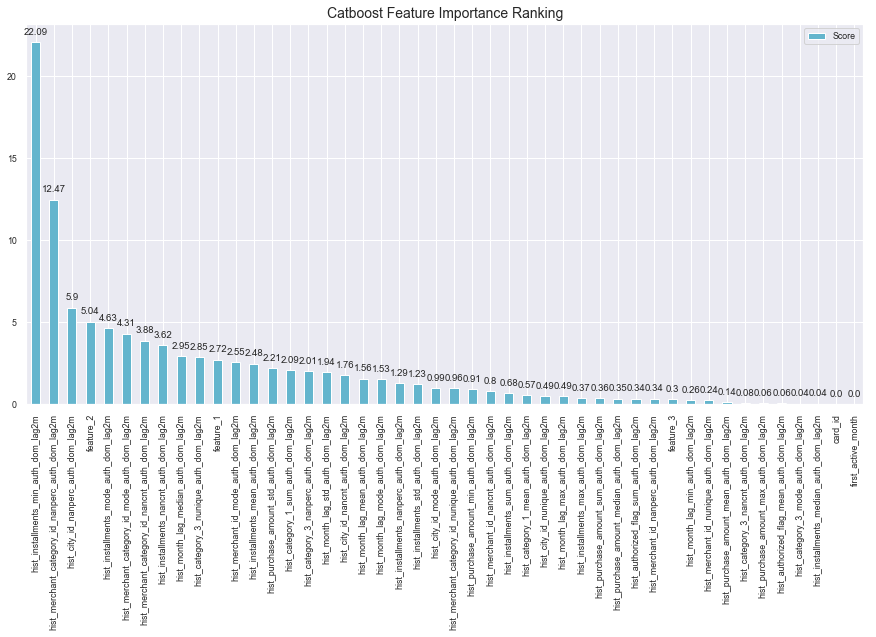

In [62]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, cbr.get_feature_importance())),
                             columns = ['Feature','Score'])

feature_score = feature_score.sort_values(by ='Score', ascending = False, inplace = False, kind = 'quicksort', 
                                          na_position = 'last')

plt.rcParams["figure.figsize"] = (15,7)
ax = feature_score.plot('Feature', 'Score', kind = 'bar', color = 'c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

### Generate submission

In [63]:
for col in categorical_features_restricted:
    X_test_restricted[col] = X_test_restricted[col].astype('category').cat.codes

test_pred = cbr.predict(X_test_restricted)

submission = pd.read_csv(SAMPLE_SUBMISSION_FILE)
submission['target'] = test_pred
submission.head()

card_id    target
0  C_ID_0ab67a22ab -0.216138
1  C_ID_130fd0cbdd -0.588263
2  C_ID_b709037bc5 -0.575594
3  C_ID_d27d835a9f -0.033547
4  C_ID_2b5e3df5c2 -1.197749

In [64]:
NUM = 0
submission.to_csv(SUBMIT_FILENAME + str(NUM) + '.csv', index = False)
# Public score: 3.933

In [66]:
params

{'learning_rate': 0.01, 'iterations': 9800, 'depth': 6, 'l2_leaf_reg': 125}